# 使用 RNN 做文本分类

文本分类任务使用 [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) 在 [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) 数据机上训练情感分类任务。

## 导入依赖

无法导入则需要安装对应的软件包。

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I was raised in a "very Christian" household since birth. I was saved before I saw this movie and the rest of the series and was forced to watch it in a youth group at my church. This movie was highly disturbing. I saw it when I was about 12 years old and literally had nightmares about it for years. I used to lay awake in bed and listen for the sounds of my mom\'s footsteps upstairs. If I didn\'t hear her footsteps, I would sneak upstairs to make sure she hadn\'t been raptured. I used to pray so hard every night for salvation because I was terrified of Jesus forgetting me. This is definitely not something I will show to my kids until they are much older, if at all. It took me years to shake the fear that this movie gave me.'
 b"Many of the American people would say...What??? to my opening comment. Yes I know that my comparison is without doubts an insult for the fans of the Master Akira Kurosawa, but if you analyze this movie, my comment is right. We have the peasant who goe

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,  14,   1, ...,   0,   0,   0],
       [106,   5,   2, ...,   0,   0,   0],
       [  1,  33,   1, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I was raised in a "very Christian" household since birth. I was saved before I saw this movie and the rest of the series and was forced to watch it in a youth group at my church. This movie was highly disturbing. I saw it when I was about 12 years old and literally had nightmares about it for years. I used to lay awake in bed and listen for the sounds of my mom\'s footsteps upstairs. If I didn\'t hear her footsteps, I would sneak upstairs to make sure she hadn\'t been raptured. I used to pray so hard every night for salvation because I was terrified of Jesus forgetting me. This is definitely not something I will show to my kids until they are much older, if at all. It took me years to shake the fear that this movie gave me.'
Round-trip:  i was [UNK] in a very [UNK] [UNK] since [UNK] i was [UNK] before i saw this movie and the rest of the series and was forced to watch it in a [UNK] group at my [UNK] this movie was highly [UNK] i saw it when i was about [UNK] years old and 

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00106721]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.0010672]


Compile the Keras model to configure the training process:

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10



  1/391 [..............................] - ETA: 59:48 - loss: 0.6934 - accuracy: 0.5000


  2/391 [..............................] - ETA: 34s - loss: 0.6940 - accuracy: 0.5234  


  3/391 [..............................] - ETA: 33s - loss: 0.6939 - accuracy: 0.5260


  4/391 [..............................] - ETA: 31s - loss: 0.6940 - accuracy: 0.5508


  5/391 [..............................] - ETA: 30s - loss: 0.6939 - accuracy: 0.5437


  6/391 [..............................] - ETA: 29s - loss: 0.6936 - accuracy: 0.5547


  7/391 [..............................] - ETA: 27s - loss: 0.6935 - accuracy: 0.5379


  8/391 [..............................] - ETA: 27s - loss: 0.6935 - accuracy: 0.5352


  9/391 [..............................] - ETA: 27s - loss: 0.6935 - accuracy: 0.5365


 10/391 [..............................] - ETA: 27s - loss: 0.6934 - accuracy: 0.5437


 11/391 [..............................] - ETA: 27s - loss: 0.6934 - accuracy: 0.5469


 12/391 [..............................] - ETA: 32s - loss: 0.6935 - accuracy: 0.5326


 13/391 [..............................] - ETA: 32s - loss: 0.6934 - accuracy: 0.5228


 14/391 [>.............................] - ETA: 31s - loss: 0.6935 - accuracy: 0.5156


 15/391 [>.............................] - ETA: 30s - loss: 0.6935 - accuracy: 0.5135


 16/391 [>.............................] - ETA: 30s - loss: 0.6935 - accuracy: 0.5137


 17/391 [>.............................] - ETA: 30s - loss: 0.6934 - accuracy: 0.5175


 18/391 [>.............................] - ETA: 29s - loss: 0.6934 - accuracy: 0.5182


 19/391 [>.............................] - ETA: 29s - loss: 0.6934 - accuracy: 0.5206


 20/391 [>.............................] - ETA: 29s - loss: 0.6934 - accuracy: 0.5172


 21/391 [>.............................] - ETA: 29s - loss: 0.6933 - accuracy: 0.5171


 22/391 [>.............................] - ETA: 28s - loss: 0.6933 - accuracy: 0.5163


 23/391 [>.............................] - ETA: 28s - loss: 0.6934 - accuracy: 0.5149


 24/391 [>.............................] - ETA: 28s - loss: 0.6934 - accuracy: 0.5169


 25/391 [>.............................] - ETA: 28s - loss: 0.6934 - accuracy: 0.5194


 26/391 [>.............................] - ETA: 28s - loss: 0.6934 - accuracy: 0.5228


 27/391 [=>............................] - ETA: 27s - loss: 0.6934 - accuracy: 0.5214


 28/391 [=>............................] - ETA: 27s - loss: 0.6934 - accuracy: 0.5195


 29/391 [=>............................] - ETA: 27s - loss: 0.6934 - accuracy: 0.5194


 30/391 [=>............................] - ETA: 27s - loss: 0.6933 - accuracy: 0.5224


 31/391 [=>............................] - ETA: 27s - loss: 0.6933 - accuracy: 0.5217


 32/391 [=>............................] - ETA: 27s - loss: 0.6934 - accuracy: 0.5200


 33/391 [=>............................] - ETA: 27s - loss: 0.6934 - accuracy: 0.5152


 34/391 [=>............................] - ETA: 27s - loss: 0.6933 - accuracy: 0.5156


 35/391 [=>............................] - ETA: 27s - loss: 0.6933 - accuracy: 0.5161


 36/391 [=>............................] - ETA: 27s - loss: 0.6933 - accuracy: 0.5169


 37/391 [=>............................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5165


 38/391 [=>............................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5169


 39/391 [=>............................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5180


 40/391 [==>...........................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5184


 41/391 [==>...........................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5175


 42/391 [==>...........................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5171


 43/391 [==>...........................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5131


 44/391 [==>...........................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5117


 45/391 [==>...........................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5146


 46/391 [==>...........................] - ETA: 25s - loss: 0.6933 - accuracy: 0.5143


 47/391 [==>...........................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5123


 48/391 [==>...........................] - ETA: 25s - loss: 0.6933 - accuracy: 0.5111


 49/391 [==>...........................] - ETA: 25s - loss: 0.6933 - accuracy: 0.5121


 50/391 [==>...........................] - ETA: 25s - loss: 0.6933 - accuracy: 0.5128


 51/391 [==>...........................] - ETA: 25s - loss: 0.6933 - accuracy: 0.5135


 52/391 [==>...........................] - ETA: 25s - loss: 0.6932 - accuracy: 0.5147


 53/391 [===>..........................] - ETA: 25s - loss: 0.6933 - accuracy: 0.5112


 54/391 [===>..........................] - ETA: 25s - loss: 0.6933 - accuracy: 0.5110


 55/391 [===>..........................] - ETA: 25s - loss: 0.6933 - accuracy: 0.5102


 56/391 [===>..........................] - ETA: 25s - loss: 0.6933 - accuracy: 0.5114


 57/391 [===>..........................] - ETA: 25s - loss: 0.6933 - accuracy: 0.5099


 59/391 [===>..........................] - ETA: 24s - loss: 0.6932 - accuracy: 0.5106


 60/391 [===>..........................] - ETA: 24s - loss: 0.6932 - accuracy: 0.5117


 61/391 [===>..........................] - ETA: 24s - loss: 0.6932 - accuracy: 0.5123


 62/391 [===>..........................] - ETA: 24s - loss: 0.6932 - accuracy: 0.5118


 63/391 [===>..........................] - ETA: 24s - loss: 0.6932 - accuracy: 0.5122


 64/391 [===>..........................] - ETA: 24s - loss: 0.6932 - accuracy: 0.5139


 65/391 [===>..........................] - ETA: 24s - loss: 0.6932 - accuracy: 0.5137


 66/391 [====>.........................] - ETA: 24s - loss: 0.6932 - accuracy: 0.5135


 67/391 [====>.........................] - ETA: 24s - loss: 0.6932 - accuracy: 0.5135


 68/391 [====>.........................] - ETA: 24s - loss: 0.6932 - accuracy: 0.5145


 69/391 [====>.........................] - ETA: 23s - loss: 0.6931 - accuracy: 0.5147


 70/391 [====>.........................] - ETA: 23s - loss: 0.6932 - accuracy: 0.5132


 71/391 [====>.........................] - ETA: 23s - loss: 0.6932 - accuracy: 0.5132


 72/391 [====>.........................] - ETA: 23s - loss: 0.6931 - accuracy: 0.5141


 73/391 [====>.........................] - ETA: 23s - loss: 0.6931 - accuracy: 0.5135


 74/391 [====>.........................] - ETA: 23s - loss: 0.6931 - accuracy: 0.5144


 75/391 [====>.........................] - ETA: 23s - loss: 0.6931 - accuracy: 0.5129


 76/391 [====>.........................] - ETA: 23s - loss: 0.6931 - accuracy: 0.5138


 77/391 [====>.........................] - ETA: 23s - loss: 0.6931 - accuracy: 0.5140


 78/391 [====>.........................] - ETA: 23s - loss: 0.6931 - accuracy: 0.5138


 79/391 [=====>........................] - ETA: 23s - loss: 0.6931 - accuracy: 0.5138


 80/391 [=====>........................] - ETA: 22s - loss: 0.6931 - accuracy: 0.5137


 81/391 [=====>........................] - ETA: 22s - loss: 0.6931 - accuracy: 0.5135


 82/391 [=====>........................] - ETA: 22s - loss: 0.6931 - accuracy: 0.5133


 83/391 [=====>........................] - ETA: 22s - loss: 0.6931 - accuracy: 0.5132


 84/391 [=====>........................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5130


 85/391 [=====>........................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5142


 86/391 [=====>........................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5134


 87/391 [=====>........................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5133


 88/391 [=====>........................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5128


 89/391 [=====>........................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5126


 90/391 [=====>........................] - ETA: 21s - loss: 0.6930 - accuracy: 0.5118


 91/391 [=====>........................] - ETA: 21s - loss: 0.6930 - accuracy: 0.5129


 92/391 [======>.......................] - ETA: 21s - loss: 0.6930 - accuracy: 0.5136


 93/391 [======>.......................] - ETA: 21s - loss: 0.6930 - accuracy: 0.5144


 94/391 [======>.......................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5150


 95/391 [======>.......................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5148


 96/391 [======>.......................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5148


 97/391 [======>.......................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5145


 98/391 [======>.......................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5140


 99/391 [======>.......................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5134


100/391 [======>.......................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5130


101/391 [======>.......................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5138


102/391 [======>.......................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5144


103/391 [======>.......................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5152


104/391 [======>.......................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5152


105/391 [=======>......................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5143


106/391 [=======>......................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5136


107/391 [=======>......................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5133


108/391 [=======>......................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5124


109/391 [=======>......................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5128


110/391 [=======>......................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5131


111/391 [=======>......................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5128


112/391 [=======>......................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5120


113/391 [=======>......................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5122


114/391 [=======>......................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5114


115/391 [=======>......................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5109


116/391 [=======>......................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5116


117/391 [=======>......................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5114


118/391 [========>.....................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5105


119/391 [========>.....................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5104


120/391 [========>.....................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5094


121/391 [========>.....................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5098


122/391 [========>.....................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5092


123/391 [========>.....................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5093


124/391 [========>.....................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5091


125/391 [========>.....................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5101


126/391 [========>.....................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5105


127/391 [========>.....................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5111


128/391 [========>.....................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5112


129/391 [========>.....................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5113


130/391 [========>.....................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5124


131/391 [=========>....................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5125


132/391 [=========>....................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5125


133/391 [=========>....................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5129


134/391 [=========>....................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5124


135/391 [=========>....................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5124


136/391 [=========>....................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5123


137/391 [=========>....................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5124


138/391 [=========>....................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5119


139/391 [=========>....................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5125


140/391 [=========>....................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5124


141/391 [=========>....................] - ETA: 18s - loss: 0.6926 - accuracy: 0.5132


142/391 [=========>....................] - ETA: 18s - loss: 0.6926 - accuracy: 0.5124


143/391 [=========>....................] - ETA: 18s - loss: 0.6926 - accuracy: 0.5123


144/391 [==========>...................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5127


145/391 [==========>...................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5127


146/391 [==========>...................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5125


147/391 [==========>...................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5121


148/391 [==========>...................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5120


149/391 [==========>...................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5112


150/391 [==========>...................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5114


151/391 [==========>...................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5112


152/391 [==========>...................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5109


153/391 [==========>...................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5101


154/391 [==========>...................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5100


155/391 [==========>...................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5098


156/391 [==========>...................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5101


157/391 [===========>..................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5102


158/391 [===========>..................] - ETA: 16s - loss: 0.6926 - accuracy: 0.5098


159/391 [===========>..................] - ETA: 16s - loss: 0.6926 - accuracy: 0.5093


160/391 [===========>..................] - ETA: 16s - loss: 0.6926 - accuracy: 0.5093


161/391 [===========>..................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5100


162/391 [===========>..................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5097


163/391 [===========>..................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5097


164/391 [===========>..................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5093


165/391 [===========>..................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5087


166/391 [===========>..................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5088


167/391 [===========>..................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5080


169/391 [===========>..................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5068


170/391 [============>.................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5067


171/391 [============>.................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5069


172/391 [============>.................] - ETA: 15s - loss: 0.6925 - accuracy: 0.5072


173/391 [============>.................] - ETA: 15s - loss: 0.6924 - accuracy: 0.5067


174/391 [============>.................] - ETA: 15s - loss: 0.6924 - accuracy: 0.5064


175/391 [============>.................] - ETA: 15s - loss: 0.6925 - accuracy: 0.5070


176/391 [============>.................] - ETA: 15s - loss: 0.6924 - accuracy: 0.5071


177/391 [============>.................] - ETA: 15s - loss: 0.6924 - accuracy: 0.5070


178/391 [============>.................] - ETA: 15s - loss: 0.6924 - accuracy: 0.5068


179/391 [============>.................] - ETA: 15s - loss: 0.6924 - accuracy: 0.5065


180/391 [============>.................] - ETA: 15s - loss: 0.6924 - accuracy: 0.5070


181/391 [============>.................] - ETA: 15s - loss: 0.6924 - accuracy: 0.5072


182/391 [============>.................] - ETA: 15s - loss: 0.6924 - accuracy: 0.5065


183/391 [=============>................] - ETA: 15s - loss: 0.6923 - accuracy: 0.5064


184/391 [=============>................] - ETA: 15s - loss: 0.6923 - accuracy: 0.5062


185/391 [=============>................] - ETA: 15s - loss: 0.6923 - accuracy: 0.5061


186/391 [=============>................] - ETA: 14s - loss: 0.6923 - accuracy: 0.5058


187/391 [=============>................] - ETA: 14s - loss: 0.6923 - accuracy: 0.5058


188/391 [=============>................] - ETA: 14s - loss: 0.6923 - accuracy: 0.5059


189/391 [=============>................] - ETA: 14s - loss: 0.6923 - accuracy: 0.5055


190/391 [=============>................] - ETA: 14s - loss: 0.6923 - accuracy: 0.5058


191/391 [=============>................] - ETA: 14s - loss: 0.6922 - accuracy: 0.5052


192/391 [=============>................] - ETA: 14s - loss: 0.6922 - accuracy: 0.5050


193/391 [=============>................] - ETA: 14s - loss: 0.6922 - accuracy: 0.5050


194/391 [=============>................] - ETA: 14s - loss: 0.6922 - accuracy: 0.5050


195/391 [=============>................] - ETA: 14s - loss: 0.6922 - accuracy: 0.5050


196/391 [==============>...............] - ETA: 14s - loss: 0.6921 - accuracy: 0.5041


197/391 [==============>...............] - ETA: 14s - loss: 0.6921 - accuracy: 0.5042


198/391 [==============>...............] - ETA: 14s - loss: 0.6921 - accuracy: 0.5042


199/391 [==============>...............] - ETA: 13s - loss: 0.6921 - accuracy: 0.5037


200/391 [==============>...............] - ETA: 13s - loss: 0.6921 - accuracy: 0.5038


201/391 [==============>...............] - ETA: 13s - loss: 0.6921 - accuracy: 0.5044


202/391 [==============>...............] - ETA: 13s - loss: 0.6921 - accuracy: 0.5043


203/391 [==============>...............] - ETA: 13s - loss: 0.6921 - accuracy: 0.5045


204/391 [==============>...............] - ETA: 13s - loss: 0.6921 - accuracy: 0.5046


205/391 [==============>...............] - ETA: 13s - loss: 0.6921 - accuracy: 0.5051


206/391 [==============>...............] - ETA: 13s - loss: 0.6921 - accuracy: 0.5049


207/391 [==============>...............] - ETA: 13s - loss: 0.6920 - accuracy: 0.5048


208/391 [==============>...............] - ETA: 13s - loss: 0.6920 - accuracy: 0.5047


209/391 [===============>..............] - ETA: 13s - loss: 0.6920 - accuracy: 0.5046


210/391 [===============>..............] - ETA: 13s - loss: 0.6920 - accuracy: 0.5050


211/391 [===============>..............] - ETA: 13s - loss: 0.6920 - accuracy: 0.5050


212/391 [===============>..............] - ETA: 12s - loss: 0.6920 - accuracy: 0.5049


213/391 [===============>..............] - ETA: 12s - loss: 0.6920 - accuracy: 0.5048


214/391 [===============>..............] - ETA: 12s - loss: 0.6920 - accuracy: 0.5048


215/391 [===============>..............] - ETA: 12s - loss: 0.6919 - accuracy: 0.5049


216/391 [===============>..............] - ETA: 12s - loss: 0.6919 - accuracy: 0.5051


217/391 [===============>..............] - ETA: 12s - loss: 0.6919 - accuracy: 0.5050


218/391 [===============>..............] - ETA: 12s - loss: 0.6919 - accuracy: 0.5051


219/391 [===============>..............] - ETA: 12s - loss: 0.6919 - accuracy: 0.5051


220/391 [===============>..............] - ETA: 12s - loss: 0.6918 - accuracy: 0.5053


221/391 [===============>..............] - ETA: 12s - loss: 0.6918 - accuracy: 0.5054


222/391 [================>.............] - ETA: 12s - loss: 0.6918 - accuracy: 0.5056


223/391 [================>.............] - ETA: 12s - loss: 0.6918 - accuracy: 0.5055


224/391 [================>.............] - ETA: 12s - loss: 0.6918 - accuracy: 0.5057


225/391 [================>.............] - ETA: 12s - loss: 0.6917 - accuracy: 0.5056


226/391 [================>.............] - ETA: 11s - loss: 0.6917 - accuracy: 0.5055


227/391 [================>.............] - ETA: 11s - loss: 0.6917 - accuracy: 0.5056


228/391 [================>.............] - ETA: 11s - loss: 0.6917 - accuracy: 0.5056


229/391 [================>.............] - ETA: 11s - loss: 0.6916 - accuracy: 0.5059


230/391 [================>.............] - ETA: 11s - loss: 0.6916 - accuracy: 0.5059


231/391 [================>.............] - ETA: 11s - loss: 0.6916 - accuracy: 0.5062


233/391 [================>.............] - ETA: 11s - loss: 0.6915 - accuracy: 0.5062


234/391 [================>.............] - ETA: 11s - loss: 0.6915 - accuracy: 0.5060


235/391 [=================>............] - ETA: 11s - loss: 0.6915 - accuracy: 0.5059


236/391 [=================>............] - ETA: 11s - loss: 0.6915 - accuracy: 0.5060


237/391 [=================>............] - ETA: 11s - loss: 0.6914 - accuracy: 0.5062


238/391 [=================>............] - ETA: 11s - loss: 0.6914 - accuracy: 0.5066


239/391 [=================>............] - ETA: 11s - loss: 0.6914 - accuracy: 0.5062


240/391 [=================>............] - ETA: 10s - loss: 0.6913 - accuracy: 0.5065


241/391 [=================>............] - ETA: 10s - loss: 0.6913 - accuracy: 0.5067


242/391 [=================>............] - ETA: 10s - loss: 0.6913 - accuracy: 0.5067


243/391 [=================>............] - ETA: 10s - loss: 0.6913 - accuracy: 0.5070


244/391 [=================>............] - ETA: 10s - loss: 0.6912 - accuracy: 0.5071


245/391 [=================>............] - ETA: 10s - loss: 0.6912 - accuracy: 0.5072


246/391 [=================>............] - ETA: 10s - loss: 0.6912 - accuracy: 0.5071


247/391 [=================>............] - ETA: 10s - loss: 0.6912 - accuracy: 0.5070


248/391 [==================>...........] - ETA: 10s - loss: 0.6911 - accuracy: 0.5067


249/391 [==================>...........] - ETA: 10s - loss: 0.6911 - accuracy: 0.5068


250/391 [==================>...........] - ETA: 10s - loss: 0.6911 - accuracy: 0.5070


251/391 [==================>...........] - ETA: 10s - loss: 0.6911 - accuracy: 0.5072


252/391 [==================>...........] - ETA: 10s - loss: 0.6910 - accuracy: 0.5074


253/391 [==================>...........] - ETA: 10s - loss: 0.6910 - accuracy: 0.5075


254/391 [==================>...........] - ETA: 9s - loss: 0.6910 - accuracy: 0.5073 


255/391 [==================>...........] - ETA: 9s - loss: 0.6909 - accuracy: 0.5074


256/391 [==================>...........] - ETA: 9s - loss: 0.6909 - accuracy: 0.5072


258/391 [==================>...........] - ETA: 9s - loss: 0.6908 - accuracy: 0.5071


259/391 [==================>...........] - ETA: 9s - loss: 0.6907 - accuracy: 0.5068


260/391 [==================>...........] - ETA: 9s - loss: 0.6907 - accuracy: 0.5070


261/391 [===================>..........] - ETA: 9s - loss: 0.6906 - accuracy: 0.5070


262/391 [===================>..........] - ETA: 9s - loss: 0.6905 - accuracy: 0.5064


263/391 [===================>..........] - ETA: 9s - loss: 0.6905 - accuracy: 0.5066


264/391 [===================>..........] - ETA: 9s - loss: 0.6904 - accuracy: 0.5064


265/391 [===================>..........] - ETA: 9s - loss: 0.6904 - accuracy: 0.5065


266/391 [===================>..........] - ETA: 9s - loss: 0.6903 - accuracy: 0.5065


267/391 [===================>..........] - ETA: 9s - loss: 0.6902 - accuracy: 0.5063


268/391 [===================>..........] - ETA: 8s - loss: 0.6901 - accuracy: 0.5064


269/391 [===================>..........] - ETA: 8s - loss: 0.6900 - accuracy: 0.5059


270/391 [===================>..........] - ETA: 8s - loss: 0.6899 - accuracy: 0.5060


271/391 [===================>..........] - ETA: 8s - loss: 0.6899 - accuracy: 0.5060


272/391 [===================>..........] - ETA: 8s - loss: 0.6897 - accuracy: 0.5063


273/391 [===================>..........] - ETA: 8s - loss: 0.6896 - accuracy: 0.5066


274/391 [====================>.........] - ETA: 8s - loss: 0.6895 - accuracy: 0.5069


275/391 [====================>.........] - ETA: 8s - loss: 0.6893 - accuracy: 0.5071


276/391 [====================>.........] - ETA: 8s - loss: 0.6891 - accuracy: 0.5071


277/391 [====================>.........] - ETA: 8s - loss: 0.6890 - accuracy: 0.5076


278/391 [====================>.........] - ETA: 8s - loss: 0.6887 - accuracy: 0.5079


279/391 [====================>.........] - ETA: 8s - loss: 0.6886 - accuracy: 0.5078


280/391 [====================>.........] - ETA: 8s - loss: 0.6883 - accuracy: 0.5084


281/391 [====================>.........] - ETA: 7s - loss: 0.6880 - accuracy: 0.5088


282/391 [====================>.........] - ETA: 7s - loss: 0.6878 - accuracy: 0.5094


283/391 [====================>.........] - ETA: 7s - loss: 0.6876 - accuracy: 0.5096


284/391 [====================>.........] - ETA: 7s - loss: 0.6874 - accuracy: 0.5097


285/391 [====================>.........] - ETA: 7s - loss: 0.6871 - accuracy: 0.5103


286/391 [====================>.........] - ETA: 7s - loss: 0.6871 - accuracy: 0.5103


287/391 [=====================>........] - ETA: 7s - loss: 0.6870 - accuracy: 0.5105


288/391 [=====================>........] - ETA: 7s - loss: 0.6865 - accuracy: 0.5110


289/391 [=====================>........] - ETA: 7s - loss: 0.6862 - accuracy: 0.5113


290/391 [=====================>........] - ETA: 7s - loss: 0.6861 - accuracy: 0.5117


291/391 [=====================>........] - ETA: 7s - loss: 0.6855 - accuracy: 0.5122


292/391 [=====================>........] - ETA: 7s - loss: 0.6850 - accuracy: 0.5129


293/391 [=====================>........] - ETA: 7s - loss: 0.6848 - accuracy: 0.5133


294/391 [=====================>........] - ETA: 7s - loss: 0.6843 - accuracy: 0.5137


295/391 [=====================>........] - ETA: 6s - loss: 0.6842 - accuracy: 0.5139


296/391 [=====================>........] - ETA: 6s - loss: 0.6841 - accuracy: 0.5141


297/391 [=====================>........] - ETA: 6s - loss: 0.6837 - accuracy: 0.5143


298/391 [=====================>........] - ETA: 6s - loss: 0.6833 - accuracy: 0.5150


299/391 [=====================>........] - ETA: 6s - loss: 0.6832 - accuracy: 0.5156


300/391 [======================>.......] - ETA: 6s - loss: 0.6833 - accuracy: 0.5159


301/391 [======================>.......] - ETA: 6s - loss: 0.6830 - accuracy: 0.5168


302/391 [======================>.......] - ETA: 6s - loss: 0.6828 - accuracy: 0.5173


303/391 [======================>.......] - ETA: 6s - loss: 0.6829 - accuracy: 0.5177


304/391 [======================>.......] - ETA: 6s - loss: 0.6823 - accuracy: 0.5183


305/391 [======================>.......] - ETA: 6s - loss: 0.6815 - accuracy: 0.5191


306/391 [======================>.......] - ETA: 6s - loss: 0.6815 - accuracy: 0.5193


307/391 [======================>.......] - ETA: 6s - loss: 0.6810 - accuracy: 0.5199


308/391 [======================>.......] - ETA: 6s - loss: 0.6813 - accuracy: 0.5198


309/391 [======================>.......] - ETA: 5s - loss: 0.6813 - accuracy: 0.5201


310/391 [======================>.......] - ETA: 5s - loss: 0.6810 - accuracy: 0.5205


311/391 [======================>.......] - ETA: 5s - loss: 0.6806 - accuracy: 0.5211


312/391 [======================>.......] - ETA: 5s - loss: 0.6803 - accuracy: 0.5213


313/391 [=======================>......] - ETA: 5s - loss: 0.6799 - accuracy: 0.5219


314/391 [=======================>......] - ETA: 5s - loss: 0.6794 - accuracy: 0.5224


315/391 [=======================>......] - ETA: 5s - loss: 0.6791 - accuracy: 0.5229


316/391 [=======================>......] - ETA: 5s - loss: 0.6787 - accuracy: 0.5231


317/391 [=======================>......] - ETA: 5s - loss: 0.6783 - accuracy: 0.5236


318/391 [=======================>......] - ETA: 5s - loss: 0.6780 - accuracy: 0.5240


319/391 [=======================>......] - ETA: 5s - loss: 0.6777 - accuracy: 0.5248


320/391 [=======================>......] - ETA: 5s - loss: 0.6779 - accuracy: 0.5251


321/391 [=======================>......] - ETA: 5s - loss: 0.6775 - accuracy: 0.5257


322/391 [=======================>......] - ETA: 5s - loss: 0.6773 - accuracy: 0.5263


323/391 [=======================>......] - ETA: 4s - loss: 0.6770 - accuracy: 0.5270


324/391 [=======================>......] - ETA: 4s - loss: 0.6768 - accuracy: 0.5276


325/391 [=======================>......] - ETA: 4s - loss: 0.6766 - accuracy: 0.5282


326/391 [========================>.....] - ETA: 4s - loss: 0.6765 - accuracy: 0.5285


327/391 [========================>.....] - ETA: 4s - loss: 0.6759 - accuracy: 0.5291


328/391 [========================>.....] - ETA: 4s - loss: 0.6757 - accuracy: 0.5293


329/391 [========================>.....] - ETA: 4s - loss: 0.6753 - accuracy: 0.5297


330/391 [========================>.....] - ETA: 4s - loss: 0.6753 - accuracy: 0.5295


331/391 [========================>.....] - ETA: 4s - loss: 0.6749 - accuracy: 0.5297


332/391 [========================>.....] - ETA: 4s - loss: 0.6746 - accuracy: 0.5299


333/391 [========================>.....] - ETA: 4s - loss: 0.6743 - accuracy: 0.5303


334/391 [========================>.....] - ETA: 4s - loss: 0.6739 - accuracy: 0.5305


335/391 [========================>.....] - ETA: 4s - loss: 0.6736 - accuracy: 0.5310


336/391 [========================>.....] - ETA: 3s - loss: 0.6730 - accuracy: 0.5315


337/391 [========================>.....] - ETA: 3s - loss: 0.6726 - accuracy: 0.5320


338/391 [========================>.....] - ETA: 3s - loss: 0.6721 - accuracy: 0.5325


339/391 [=========================>....] - ETA: 3s - loss: 0.6718 - accuracy: 0.5329


340/391 [=========================>....] - ETA: 3s - loss: 0.6714 - accuracy: 0.5336


341/391 [=========================>....] - ETA: 3s - loss: 0.6709 - accuracy: 0.5343


342/391 [=========================>....] - ETA: 3s - loss: 0.6706 - accuracy: 0.5347


343/391 [=========================>....] - ETA: 3s - loss: 0.6699 - accuracy: 0.5355


344/391 [=========================>....] - ETA: 3s - loss: 0.6697 - accuracy: 0.5361


345/391 [=========================>....] - ETA: 3s - loss: 0.6692 - accuracy: 0.5370


346/391 [=========================>....] - ETA: 3s - loss: 0.6688 - accuracy: 0.5373


347/391 [=========================>....] - ETA: 3s - loss: 0.6687 - accuracy: 0.5372


348/391 [=========================>....] - ETA: 3s - loss: 0.6685 - accuracy: 0.5373


349/391 [=========================>....] - ETA: 3s - loss: 0.6685 - accuracy: 0.5372


350/391 [=========================>....] - ETA: 2s - loss: 0.6682 - accuracy: 0.5375


351/391 [=========================>....] - ETA: 2s - loss: 0.6680 - accuracy: 0.5376


352/391 [==========================>...] - ETA: 2s - loss: 0.6678 - accuracy: 0.5378


353/391 [==========================>...] - ETA: 2s - loss: 0.6676 - accuracy: 0.5379


354/391 [==========================>...] - ETA: 2s - loss: 0.6674 - accuracy: 0.5383


355/391 [==========================>...] - ETA: 2s - loss: 0.6669 - accuracy: 0.5389


356/391 [==========================>...] - ETA: 2s - loss: 0.6666 - accuracy: 0.5390


357/391 [==========================>...] - ETA: 2s - loss: 0.6661 - accuracy: 0.5399


358/391 [==========================>...] - ETA: 2s - loss: 0.6658 - accuracy: 0.5403


359/391 [==========================>...] - ETA: 2s - loss: 0.6654 - accuracy: 0.5408


361/391 [==========================>...] - ETA: 2s - loss: 0.6647 - accuracy: 0.5422


362/391 [==========================>...] - ETA: 2s - loss: 0.6645 - accuracy: 0.5429


363/391 [==========================>...] - ETA: 2s - loss: 0.6640 - accuracy: 0.5436


364/391 [==========================>...] - ETA: 1s - loss: 0.6637 - accuracy: 0.5440


365/391 [===========================>..] - ETA: 1s - loss: 0.6634 - accuracy: 0.5445


366/391 [===========================>..] - ETA: 1s - loss: 0.6630 - accuracy: 0.5449


367/391 [===========================>..] - ETA: 1s - loss: 0.6628 - accuracy: 0.5452


368/391 [===========================>..] - ETA: 1s - loss: 0.6623 - accuracy: 0.5457


369/391 [===========================>..] - ETA: 1s - loss: 0.6619 - accuracy: 0.5461


370/391 [===========================>..] - ETA: 1s - loss: 0.6616 - accuracy: 0.5464


371/391 [===========================>..] - ETA: 1s - loss: 0.6613 - accuracy: 0.5468


372/391 [===========================>..] - ETA: 1s - loss: 0.6611 - accuracy: 0.5473


373/391 [===========================>..] - ETA: 1s - loss: 0.6610 - accuracy: 0.5477


374/391 [===========================>..] - ETA: 1s - loss: 0.6607 - accuracy: 0.5483


375/391 [===========================>..] - ETA: 1s - loss: 0.6600 - accuracy: 0.5491


376/391 [===========================>..] - ETA: 1s - loss: 0.6597 - accuracy: 0.5497


377/391 [===========================>..] - ETA: 1s - loss: 0.6591 - accuracy: 0.5504


378/391 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.5508


379/391 [============================>.] - ETA: 0s - loss: 0.6581 - accuracy: 0.5515


380/391 [============================>.] - ETA: 0s - loss: 0.6576 - accuracy: 0.5520


381/391 [============================>.] - ETA: 0s - loss: 0.6573 - accuracy: 0.5525


382/391 [============================>.] - ETA: 0s - loss: 0.6569 - accuracy: 0.5531


383/391 [============================>.] - ETA: 0s - loss: 0.6567 - accuracy: 0.5533


384/391 [============================>.] - ETA: 0s - loss: 0.6565 - accuracy: 0.5537


385/391 [============================>.] - ETA: 0s - loss: 0.6559 - accuracy: 0.5542


386/391 [============================>.] - ETA: 0s - loss: 0.6554 - accuracy: 0.5549


387/391 [============================>.] - ETA: 0s - loss: 0.6548 - accuracy: 0.5555


388/391 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.5560


389/391 [============================>.] - ETA: 0s - loss: 0.6537 - accuracy: 0.5564


390/391 [============================>.] - ETA: 0s - loss: 0.6531 - accuracy: 0.5570


391/391 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.5573


391/391 [==============================] - 43s 86ms/step - loss: 0.6528 - accuracy: 0.5573 - val_loss: 0.4968 - val_accuracy: 0.7349


Epoch 2/10



  1/391 [..............................] - ETA: 5:31 - loss: 0.4168 - accuracy: 0.7344


  2/391 [..............................] - ETA: 23s - loss: 0.5106 - accuracy: 0.7031 


  3/391 [..............................] - ETA: 23s - loss: 0.4865 - accuracy: 0.7292


  4/391 [..............................] - ETA: 23s - loss: 0.4612 - accuracy: 0.7578


  5/391 [..............................] - ETA: 24s - loss: 0.4656 - accuracy: 0.7594


  6/391 [..............................] - ETA: 24s - loss: 0.4848 - accuracy: 0.7552


  7/391 [..............................] - ETA: 25s - loss: 0.4813 - accuracy: 0.7656


  8/391 [..............................] - ETA: 25s - loss: 0.4862 - accuracy: 0.7617


  9/391 [..............................] - ETA: 25s - loss: 0.4881 - accuracy: 0.7656


 10/391 [..............................] - ETA: 26s - loss: 0.4976 - accuracy: 0.7563


 11/391 [..............................] - ETA: 26s - loss: 0.4932 - accuracy: 0.7599


 12/391 [..............................] - ETA: 26s - loss: 0.4959 - accuracy: 0.7539


 13/391 [..............................] - ETA: 26s - loss: 0.4968 - accuracy: 0.7488


 14/391 [>.............................] - ETA: 25s - loss: 0.4964 - accuracy: 0.7467


 15/391 [>.............................] - ETA: 25s - loss: 0.4941 - accuracy: 0.7490


 17/391 [>.............................] - ETA: 25s - loss: 0.4916 - accuracy: 0.7463


 18/391 [>.............................] - ETA: 25s - loss: 0.4929 - accuracy: 0.7457


 19/391 [>.............................] - ETA: 25s - loss: 0.4928 - accuracy: 0.7426


 20/391 [>.............................] - ETA: 25s - loss: 0.4947 - accuracy: 0.7398


 21/391 [>.............................] - ETA: 25s - loss: 0.4911 - accuracy: 0.7411


 23/391 [>.............................] - ETA: 25s - loss: 0.4905 - accuracy: 0.7412


 24/391 [>.............................] - ETA: 25s - loss: 0.4918 - accuracy: 0.7402


 25/391 [>.............................] - ETA: 25s - loss: 0.4939 - accuracy: 0.7381


 26/391 [>.............................] - ETA: 24s - loss: 0.4946 - accuracy: 0.7368


 27/391 [=>............................] - ETA: 24s - loss: 0.4919 - accuracy: 0.7361


 28/391 [=>............................] - ETA: 24s - loss: 0.4916 - accuracy: 0.7338


 29/391 [=>............................] - ETA: 24s - loss: 0.4941 - accuracy: 0.7344


 30/391 [=>............................] - ETA: 24s - loss: 0.4975 - accuracy: 0.7344


 31/391 [=>............................] - ETA: 24s - loss: 0.4991 - accuracy: 0.7303


 32/391 [=>............................] - ETA: 24s - loss: 0.5012 - accuracy: 0.7285


 33/391 [=>............................] - ETA: 24s - loss: 0.5011 - accuracy: 0.7282


 34/391 [=>............................] - ETA: 24s - loss: 0.5022 - accuracy: 0.7270


 35/391 [=>............................] - ETA: 23s - loss: 0.5018 - accuracy: 0.7317


 36/391 [=>............................] - ETA: 23s - loss: 0.5012 - accuracy: 0.7331


 37/391 [=>............................] - ETA: 23s - loss: 0.5018 - accuracy: 0.7323


 38/391 [=>............................] - ETA: 23s - loss: 0.5015 - accuracy: 0.7319


 39/391 [=>............................] - ETA: 23s - loss: 0.5021 - accuracy: 0.7300


 40/391 [==>...........................] - ETA: 23s - loss: 0.5031 - accuracy: 0.7289


 41/391 [==>...........................] - ETA: 23s - loss: 0.5028 - accuracy: 0.7290


 42/391 [==>...........................] - ETA: 23s - loss: 0.5022 - accuracy: 0.7284


 43/391 [==>...........................] - ETA: 23s - loss: 0.5021 - accuracy: 0.7275


 44/391 [==>...........................] - ETA: 23s - loss: 0.5005 - accuracy: 0.7283


 45/391 [==>...........................] - ETA: 23s - loss: 0.5010 - accuracy: 0.7271


 46/391 [==>...........................] - ETA: 23s - loss: 0.5021 - accuracy: 0.7259


 47/391 [==>...........................] - ETA: 23s - loss: 0.5011 - accuracy: 0.7267


 48/391 [==>...........................] - ETA: 23s - loss: 0.5005 - accuracy: 0.7275


 49/391 [==>...........................] - ETA: 23s - loss: 0.4996 - accuracy: 0.7267


 50/391 [==>...........................] - ETA: 23s - loss: 0.5002 - accuracy: 0.7269


 51/391 [==>...........................] - ETA: 22s - loss: 0.4997 - accuracy: 0.7270


 52/391 [==>...........................] - ETA: 22s - loss: 0.5000 - accuracy: 0.7269


 53/391 [===>..........................] - ETA: 22s - loss: 0.4994 - accuracy: 0.7288


 54/391 [===>..........................] - ETA: 22s - loss: 0.4992 - accuracy: 0.7300


 55/391 [===>..........................] - ETA: 22s - loss: 0.4998 - accuracy: 0.7301


 56/391 [===>..........................] - ETA: 22s - loss: 0.4995 - accuracy: 0.7294


 57/391 [===>..........................] - ETA: 22s - loss: 0.4980 - accuracy: 0.7303


 58/391 [===>..........................] - ETA: 22s - loss: 0.4969 - accuracy: 0.7309


 59/391 [===>..........................] - ETA: 22s - loss: 0.4977 - accuracy: 0.7312


 60/391 [===>..........................] - ETA: 22s - loss: 0.4983 - accuracy: 0.7320


 61/391 [===>..........................] - ETA: 22s - loss: 0.4958 - accuracy: 0.7351


 62/391 [===>..........................] - ETA: 22s - loss: 0.4948 - accuracy: 0.7351


 63/391 [===>..........................] - ETA: 22s - loss: 0.4933 - accuracy: 0.7361


 64/391 [===>..........................] - ETA: 22s - loss: 0.4932 - accuracy: 0.7351


 65/391 [===>..........................] - ETA: 21s - loss: 0.4917 - accuracy: 0.7356


 66/391 [====>.........................] - ETA: 21s - loss: 0.4909 - accuracy: 0.7370


 67/391 [====>.........................] - ETA: 21s - loss: 0.4902 - accuracy: 0.7374


 68/391 [====>.........................] - ETA: 21s - loss: 0.4902 - accuracy: 0.7381


 69/391 [====>.........................] - ETA: 21s - loss: 0.4900 - accuracy: 0.7382


 70/391 [====>.........................] - ETA: 21s - loss: 0.4897 - accuracy: 0.7386


 71/391 [====>.........................] - ETA: 21s - loss: 0.4898 - accuracy: 0.7390


 72/391 [====>.........................] - ETA: 21s - loss: 0.4897 - accuracy: 0.7400


 73/391 [====>.........................] - ETA: 21s - loss: 0.4895 - accuracy: 0.7404


 74/391 [====>.........................] - ETA: 21s - loss: 0.4881 - accuracy: 0.7411


 76/391 [====>.........................] - ETA: 21s - loss: 0.4879 - accuracy: 0.7428


 77/391 [====>.........................] - ETA: 21s - loss: 0.4863 - accuracy: 0.7441


 78/391 [====>.........................] - ETA: 21s - loss: 0.4849 - accuracy: 0.7452


 79/391 [=====>........................] - ETA: 21s - loss: 0.4843 - accuracy: 0.7449


 80/391 [=====>........................] - ETA: 21s - loss: 0.4835 - accuracy: 0.7457


 81/391 [=====>........................] - ETA: 21s - loss: 0.4830 - accuracy: 0.7458


 82/391 [=====>........................] - ETA: 21s - loss: 0.4838 - accuracy: 0.7458


 83/391 [=====>........................] - ETA: 20s - loss: 0.4837 - accuracy: 0.7453


 84/391 [=====>........................] - ETA: 20s - loss: 0.4831 - accuracy: 0.7459


 85/391 [=====>........................] - ETA: 20s - loss: 0.4820 - accuracy: 0.7471


 86/391 [=====>........................] - ETA: 20s - loss: 0.4824 - accuracy: 0.7475


 87/391 [=====>........................] - ETA: 20s - loss: 0.4816 - accuracy: 0.7480


 88/391 [=====>........................] - ETA: 20s - loss: 0.4815 - accuracy: 0.7486


 89/391 [=====>........................] - ETA: 20s - loss: 0.4814 - accuracy: 0.7486


 90/391 [=====>........................] - ETA: 20s - loss: 0.4813 - accuracy: 0.7491


 91/391 [=====>........................] - ETA: 20s - loss: 0.4820 - accuracy: 0.7497


 92/391 [======>.......................] - ETA: 20s - loss: 0.4824 - accuracy: 0.7497


 93/391 [======>.......................] - ETA: 20s - loss: 0.4825 - accuracy: 0.7500


 94/391 [======>.......................] - ETA: 20s - loss: 0.4834 - accuracy: 0.7500


 95/391 [======>.......................] - ETA: 20s - loss: 0.4831 - accuracy: 0.7507


 96/391 [======>.......................] - ETA: 20s - loss: 0.4845 - accuracy: 0.7503


 97/391 [======>.......................] - ETA: 20s - loss: 0.4841 - accuracy: 0.7502


 98/391 [======>.......................] - ETA: 20s - loss: 0.4836 - accuracy: 0.7495


 99/391 [======>.......................] - ETA: 20s - loss: 0.4847 - accuracy: 0.7472


100/391 [======>.......................] - ETA: 20s - loss: 0.4842 - accuracy: 0.7464


101/391 [======>.......................] - ETA: 20s - loss: 0.4842 - accuracy: 0.7464


102/391 [======>.......................] - ETA: 20s - loss: 0.4835 - accuracy: 0.7471


103/391 [======>.......................] - ETA: 20s - loss: 0.4825 - accuracy: 0.7482


104/391 [======>.......................] - ETA: 19s - loss: 0.4815 - accuracy: 0.7492


105/391 [=======>......................] - ETA: 19s - loss: 0.4818 - accuracy: 0.7496


106/391 [=======>......................] - ETA: 19s - loss: 0.4822 - accuracy: 0.7496


107/391 [=======>......................] - ETA: 19s - loss: 0.4828 - accuracy: 0.7496


108/391 [=======>......................] - ETA: 19s - loss: 0.4822 - accuracy: 0.7500


109/391 [=======>......................] - ETA: 19s - loss: 0.4814 - accuracy: 0.7503


110/391 [=======>......................] - ETA: 19s - loss: 0.4802 - accuracy: 0.7513


111/391 [=======>......................] - ETA: 19s - loss: 0.4809 - accuracy: 0.7511


112/391 [=======>......................] - ETA: 19s - loss: 0.4805 - accuracy: 0.7522


113/391 [=======>......................] - ETA: 19s - loss: 0.4810 - accuracy: 0.7525


114/391 [=======>......................] - ETA: 19s - loss: 0.4810 - accuracy: 0.7527


115/391 [=======>......................] - ETA: 19s - loss: 0.4808 - accuracy: 0.7533


116/391 [=======>......................] - ETA: 19s - loss: 0.4809 - accuracy: 0.7531


117/391 [=======>......................] - ETA: 19s - loss: 0.4805 - accuracy: 0.7533


118/391 [========>.....................] - ETA: 19s - loss: 0.4807 - accuracy: 0.7534


119/391 [========>.....................] - ETA: 19s - loss: 0.4797 - accuracy: 0.7543


120/391 [========>.....................] - ETA: 19s - loss: 0.4784 - accuracy: 0.7552


121/391 [========>.....................] - ETA: 18s - loss: 0.4778 - accuracy: 0.7554


122/391 [========>.....................] - ETA: 18s - loss: 0.4781 - accuracy: 0.7553


123/391 [========>.....................] - ETA: 18s - loss: 0.4777 - accuracy: 0.7555


124/391 [========>.....................] - ETA: 18s - loss: 0.4774 - accuracy: 0.7558


125/391 [========>.....................] - ETA: 18s - loss: 0.4775 - accuracy: 0.7558


127/391 [========>.....................] - ETA: 18s - loss: 0.4778 - accuracy: 0.7560


128/391 [========>.....................] - ETA: 18s - loss: 0.4774 - accuracy: 0.7559


129/391 [========>.....................] - ETA: 18s - loss: 0.4780 - accuracy: 0.7561


130/391 [========>.....................] - ETA: 18s - loss: 0.4775 - accuracy: 0.7559


131/391 [=========>....................] - ETA: 18s - loss: 0.4773 - accuracy: 0.7556


132/391 [=========>....................] - ETA: 18s - loss: 0.4768 - accuracy: 0.7553


133/391 [=========>....................] - ETA: 18s - loss: 0.4762 - accuracy: 0.7555


134/391 [=========>....................] - ETA: 18s - loss: 0.4767 - accuracy: 0.7552


135/391 [=========>....................] - ETA: 17s - loss: 0.4765 - accuracy: 0.7561


136/391 [=========>....................] - ETA: 17s - loss: 0.4770 - accuracy: 0.7554


137/391 [=========>....................] - ETA: 17s - loss: 0.4766 - accuracy: 0.7554


138/391 [=========>....................] - ETA: 17s - loss: 0.4759 - accuracy: 0.7552


139/391 [=========>....................] - ETA: 17s - loss: 0.4754 - accuracy: 0.7554


140/391 [=========>....................] - ETA: 17s - loss: 0.4740 - accuracy: 0.7565


141/391 [=========>....................] - ETA: 17s - loss: 0.4733 - accuracy: 0.7570


142/391 [=========>....................] - ETA: 17s - loss: 0.4735 - accuracy: 0.7572


143/391 [=========>....................] - ETA: 17s - loss: 0.4727 - accuracy: 0.7578


144/391 [==========>...................] - ETA: 17s - loss: 0.4734 - accuracy: 0.7574


145/391 [==========>...................] - ETA: 17s - loss: 0.4730 - accuracy: 0.7579


146/391 [==========>...................] - ETA: 17s - loss: 0.4726 - accuracy: 0.7580


147/391 [==========>...................] - ETA: 17s - loss: 0.4723 - accuracy: 0.7582


148/391 [==========>...................] - ETA: 17s - loss: 0.4709 - accuracy: 0.7591


149/391 [==========>...................] - ETA: 17s - loss: 0.4702 - accuracy: 0.7595


150/391 [==========>...................] - ETA: 17s - loss: 0.4693 - accuracy: 0.7598


151/391 [==========>...................] - ETA: 17s - loss: 0.4694 - accuracy: 0.7597


152/391 [==========>...................] - ETA: 16s - loss: 0.4690 - accuracy: 0.7601


153/391 [==========>...................] - ETA: 16s - loss: 0.4688 - accuracy: 0.7601


154/391 [==========>...................] - ETA: 16s - loss: 0.4689 - accuracy: 0.7601


155/391 [==========>...................] - ETA: 16s - loss: 0.4682 - accuracy: 0.7609


156/391 [==========>...................] - ETA: 16s - loss: 0.4685 - accuracy: 0.7612


157/391 [===========>..................] - ETA: 16s - loss: 0.4683 - accuracy: 0.7612


158/391 [===========>..................] - ETA: 16s - loss: 0.4673 - accuracy: 0.7623


159/391 [===========>..................] - ETA: 16s - loss: 0.4664 - accuracy: 0.7628


160/391 [===========>..................] - ETA: 16s - loss: 0.4664 - accuracy: 0.7628


161/391 [===========>..................] - ETA: 16s - loss: 0.4664 - accuracy: 0.7629


162/391 [===========>..................] - ETA: 16s - loss: 0.4667 - accuracy: 0.7629


163/391 [===========>..................] - ETA: 16s - loss: 0.4672 - accuracy: 0.7627


164/391 [===========>..................] - ETA: 16s - loss: 0.4667 - accuracy: 0.7631


165/391 [===========>..................] - ETA: 16s - loss: 0.4664 - accuracy: 0.7631


166/391 [===========>..................] - ETA: 16s - loss: 0.4666 - accuracy: 0.7631


167/391 [===========>..................] - ETA: 16s - loss: 0.4663 - accuracy: 0.7634


168/391 [===========>..................] - ETA: 16s - loss: 0.4659 - accuracy: 0.7635


169/391 [===========>..................] - ETA: 15s - loss: 0.4666 - accuracy: 0.7632


170/391 [============>.................] - ETA: 15s - loss: 0.4668 - accuracy: 0.7631


171/391 [============>.................] - ETA: 15s - loss: 0.4671 - accuracy: 0.7628


172/391 [============>.................] - ETA: 15s - loss: 0.4671 - accuracy: 0.7626


173/391 [============>.................] - ETA: 15s - loss: 0.4671 - accuracy: 0.7629


174/391 [============>.................] - ETA: 15s - loss: 0.4671 - accuracy: 0.7629


175/391 [============>.................] - ETA: 15s - loss: 0.4669 - accuracy: 0.7629


177/391 [============>.................] - ETA: 15s - loss: 0.4667 - accuracy: 0.7629


178/391 [============>.................] - ETA: 15s - loss: 0.4668 - accuracy: 0.7629


179/391 [============>.................] - ETA: 15s - loss: 0.4666 - accuracy: 0.7635


180/391 [============>.................] - ETA: 15s - loss: 0.4670 - accuracy: 0.7634


181/391 [============>.................] - ETA: 15s - loss: 0.4666 - accuracy: 0.7638


182/391 [============>.................] - ETA: 14s - loss: 0.4667 - accuracy: 0.7638


183/391 [=============>................] - ETA: 14s - loss: 0.4666 - accuracy: 0.7641


184/391 [=============>................] - ETA: 14s - loss: 0.4665 - accuracy: 0.7641


185/391 [=============>................] - ETA: 14s - loss: 0.4666 - accuracy: 0.7642


186/391 [=============>................] - ETA: 14s - loss: 0.4666 - accuracy: 0.7641


187/391 [=============>................] - ETA: 14s - loss: 0.4665 - accuracy: 0.7643


188/391 [=============>................] - ETA: 14s - loss: 0.4661 - accuracy: 0.7647


189/391 [=============>................] - ETA: 14s - loss: 0.4657 - accuracy: 0.7649


190/391 [=============>................] - ETA: 14s - loss: 0.4658 - accuracy: 0.7653


191/391 [=============>................] - ETA: 14s - loss: 0.4658 - accuracy: 0.7655


192/391 [=============>................] - ETA: 14s - loss: 0.4655 - accuracy: 0.7657


193/391 [=============>................] - ETA: 14s - loss: 0.4654 - accuracy: 0.7655


194/391 [=============>................] - ETA: 14s - loss: 0.4652 - accuracy: 0.7657


195/391 [=============>................] - ETA: 14s - loss: 0.4648 - accuracy: 0.7659


196/391 [==============>...............] - ETA: 13s - loss: 0.4647 - accuracy: 0.7658


197/391 [==============>...............] - ETA: 13s - loss: 0.4644 - accuracy: 0.7658


198/391 [==============>...............] - ETA: 13s - loss: 0.4647 - accuracy: 0.7658


199/391 [==============>...............] - ETA: 13s - loss: 0.4639 - accuracy: 0.7662


200/391 [==============>...............] - ETA: 13s - loss: 0.4641 - accuracy: 0.7661


201/391 [==============>...............] - ETA: 13s - loss: 0.4638 - accuracy: 0.7664


202/391 [==============>...............] - ETA: 13s - loss: 0.4637 - accuracy: 0.7660


203/391 [==============>...............] - ETA: 13s - loss: 0.4631 - accuracy: 0.7665


204/391 [==============>...............] - ETA: 13s - loss: 0.4628 - accuracy: 0.7667


205/391 [==============>...............] - ETA: 13s - loss: 0.4625 - accuracy: 0.7667


206/391 [==============>...............] - ETA: 13s - loss: 0.4620 - accuracy: 0.7672


207/391 [==============>...............] - ETA: 13s - loss: 0.4625 - accuracy: 0.7671


208/391 [==============>...............] - ETA: 13s - loss: 0.4623 - accuracy: 0.7674


209/391 [===============>..............] - ETA: 13s - loss: 0.4620 - accuracy: 0.7676


210/391 [===============>..............] - ETA: 12s - loss: 0.4620 - accuracy: 0.7676


211/391 [===============>..............] - ETA: 12s - loss: 0.4612 - accuracy: 0.7684


212/391 [===============>..............] - ETA: 12s - loss: 0.4612 - accuracy: 0.7686


213/391 [===============>..............] - ETA: 12s - loss: 0.4612 - accuracy: 0.7689


214/391 [===============>..............] - ETA: 12s - loss: 0.4612 - accuracy: 0.7693


215/391 [===============>..............] - ETA: 12s - loss: 0.4609 - accuracy: 0.7696


216/391 [===============>..............] - ETA: 12s - loss: 0.4607 - accuracy: 0.7698


217/391 [===============>..............] - ETA: 12s - loss: 0.4602 - accuracy: 0.7702


218/391 [===============>..............] - ETA: 12s - loss: 0.4600 - accuracy: 0.7704


219/391 [===============>..............] - ETA: 12s - loss: 0.4597 - accuracy: 0.7706


220/391 [===============>..............] - ETA: 12s - loss: 0.4591 - accuracy: 0.7712


221/391 [===============>..............] - ETA: 12s - loss: 0.4585 - accuracy: 0.7717


222/391 [================>.............] - ETA: 12s - loss: 0.4587 - accuracy: 0.7717


223/391 [================>.............] - ETA: 11s - loss: 0.4587 - accuracy: 0.7719


224/391 [================>.............] - ETA: 11s - loss: 0.4586 - accuracy: 0.7721


225/391 [================>.............] - ETA: 11s - loss: 0.4582 - accuracy: 0.7723


226/391 [================>.............] - ETA: 11s - loss: 0.4581 - accuracy: 0.7724


227/391 [================>.............] - ETA: 11s - loss: 0.4579 - accuracy: 0.7724


228/391 [================>.............] - ETA: 11s - loss: 0.4578 - accuracy: 0.7725


229/391 [================>.............] - ETA: 11s - loss: 0.4583 - accuracy: 0.7724


230/391 [================>.............] - ETA: 11s - loss: 0.4579 - accuracy: 0.7727


231/391 [================>.............] - ETA: 11s - loss: 0.4580 - accuracy: 0.7727


232/391 [================>.............] - ETA: 11s - loss: 0.4575 - accuracy: 0.7731


233/391 [================>.............] - ETA: 11s - loss: 0.4575 - accuracy: 0.7731


234/391 [================>.............] - ETA: 11s - loss: 0.4575 - accuracy: 0.7732


235/391 [=================>............] - ETA: 11s - loss: 0.4569 - accuracy: 0.7736


236/391 [=================>............] - ETA: 11s - loss: 0.4573 - accuracy: 0.7736


237/391 [=================>............] - ETA: 10s - loss: 0.4576 - accuracy: 0.7735


238/391 [=================>............] - ETA: 10s - loss: 0.4582 - accuracy: 0.7732


239/391 [=================>............] - ETA: 10s - loss: 0.4586 - accuracy: 0.7730


240/391 [=================>............] - ETA: 10s - loss: 0.4592 - accuracy: 0.7726


241/391 [=================>............] - ETA: 10s - loss: 0.4590 - accuracy: 0.7725


242/391 [=================>............] - ETA: 10s - loss: 0.4586 - accuracy: 0.7726


243/391 [=================>............] - ETA: 10s - loss: 0.4586 - accuracy: 0.7726


244/391 [=================>............] - ETA: 10s - loss: 0.4584 - accuracy: 0.7729


245/391 [=================>............] - ETA: 10s - loss: 0.4584 - accuracy: 0.7730


246/391 [=================>............] - ETA: 10s - loss: 0.4586 - accuracy: 0.7729


247/391 [=================>............] - ETA: 10s - loss: 0.4590 - accuracy: 0.7727


248/391 [==================>...........] - ETA: 10s - loss: 0.4587 - accuracy: 0.7730


249/391 [==================>...........] - ETA: 10s - loss: 0.4584 - accuracy: 0.7731


250/391 [==================>...........] - ETA: 10s - loss: 0.4586 - accuracy: 0.7731


251/391 [==================>...........] - ETA: 9s - loss: 0.4586 - accuracy: 0.7732 


252/391 [==================>...........] - ETA: 9s - loss: 0.4584 - accuracy: 0.7735


253/391 [==================>...........] - ETA: 9s - loss: 0.4584 - accuracy: 0.7736


254/391 [==================>...........] - ETA: 9s - loss: 0.4586 - accuracy: 0.7736


255/391 [==================>...........] - ETA: 9s - loss: 0.4584 - accuracy: 0.7738


256/391 [==================>...........] - ETA: 9s - loss: 0.4581 - accuracy: 0.7741


257/391 [==================>...........] - ETA: 9s - loss: 0.4581 - accuracy: 0.7740


258/391 [==================>...........] - ETA: 9s - loss: 0.4580 - accuracy: 0.7742


259/391 [==================>...........] - ETA: 9s - loss: 0.4579 - accuracy: 0.7741


260/391 [==================>...........] - ETA: 9s - loss: 0.4578 - accuracy: 0.7742


261/391 [===================>..........] - ETA: 9s - loss: 0.4575 - accuracy: 0.7744


262/391 [===================>..........] - ETA: 9s - loss: 0.4574 - accuracy: 0.7743


263/391 [===================>..........] - ETA: 9s - loss: 0.4576 - accuracy: 0.7740


264/391 [===================>..........] - ETA: 9s - loss: 0.4574 - accuracy: 0.7741


265/391 [===================>..........] - ETA: 8s - loss: 0.4572 - accuracy: 0.7742


266/391 [===================>..........] - ETA: 8s - loss: 0.4570 - accuracy: 0.7746


267/391 [===================>..........] - ETA: 8s - loss: 0.4568 - accuracy: 0.7746


268/391 [===================>..........] - ETA: 8s - loss: 0.4565 - accuracy: 0.7750


269/391 [===================>..........] - ETA: 8s - loss: 0.4560 - accuracy: 0.7754


270/391 [===================>..........] - ETA: 8s - loss: 0.4558 - accuracy: 0.7757


271/391 [===================>..........] - ETA: 8s - loss: 0.4555 - accuracy: 0.7760


272/391 [===================>..........] - ETA: 8s - loss: 0.4553 - accuracy: 0.7762


273/391 [===================>..........] - ETA: 8s - loss: 0.4553 - accuracy: 0.7762


274/391 [====================>.........] - ETA: 8s - loss: 0.4551 - accuracy: 0.7766


275/391 [====================>.........] - ETA: 8s - loss: 0.4548 - accuracy: 0.7768


276/391 [====================>.........] - ETA: 8s - loss: 0.4552 - accuracy: 0.7768


277/391 [====================>.........] - ETA: 8s - loss: 0.4549 - accuracy: 0.7771


278/391 [====================>.........] - ETA: 8s - loss: 0.4547 - accuracy: 0.7772


279/391 [====================>.........] - ETA: 8s - loss: 0.4542 - accuracy: 0.7774


280/391 [====================>.........] - ETA: 7s - loss: 0.4540 - accuracy: 0.7772


281/391 [====================>.........] - ETA: 7s - loss: 0.4541 - accuracy: 0.7771


282/391 [====================>.........] - ETA: 7s - loss: 0.4539 - accuracy: 0.7771


283/391 [====================>.........] - ETA: 7s - loss: 0.4533 - accuracy: 0.7775


284/391 [====================>.........] - ETA: 7s - loss: 0.4530 - accuracy: 0.7777


285/391 [====================>.........] - ETA: 7s - loss: 0.4528 - accuracy: 0.7781


286/391 [====================>.........] - ETA: 7s - loss: 0.4531 - accuracy: 0.7779


287/391 [=====================>........] - ETA: 7s - loss: 0.4530 - accuracy: 0.7780


288/391 [=====================>........] - ETA: 7s - loss: 0.4525 - accuracy: 0.7784


289/391 [=====================>........] - ETA: 7s - loss: 0.4527 - accuracy: 0.7785


290/391 [=====================>........] - ETA: 7s - loss: 0.4526 - accuracy: 0.7787


291/391 [=====================>........] - ETA: 7s - loss: 0.4523 - accuracy: 0.7790


292/391 [=====================>........] - ETA: 7s - loss: 0.4525 - accuracy: 0.7789


293/391 [=====================>........] - ETA: 7s - loss: 0.4527 - accuracy: 0.7789


294/391 [=====================>........] - ETA: 6s - loss: 0.4521 - accuracy: 0.7793


295/391 [=====================>........] - ETA: 6s - loss: 0.4522 - accuracy: 0.7792


296/391 [=====================>........] - ETA: 6s - loss: 0.4519 - accuracy: 0.7792


297/391 [=====================>........] - ETA: 6s - loss: 0.4512 - accuracy: 0.7796


298/391 [=====================>........] - ETA: 6s - loss: 0.4514 - accuracy: 0.7796


299/391 [=====================>........] - ETA: 6s - loss: 0.4511 - accuracy: 0.7799


300/391 [======================>.......] - ETA: 6s - loss: 0.4509 - accuracy: 0.7800


301/391 [======================>.......] - ETA: 6s - loss: 0.4506 - accuracy: 0.7802


302/391 [======================>.......] - ETA: 6s - loss: 0.4506 - accuracy: 0.7802


303/391 [======================>.......] - ETA: 6s - loss: 0.4506 - accuracy: 0.7804


304/391 [======================>.......] - ETA: 6s - loss: 0.4504 - accuracy: 0.7807


305/391 [======================>.......] - ETA: 6s - loss: 0.4507 - accuracy: 0.7809


306/391 [======================>.......] - ETA: 6s - loss: 0.4505 - accuracy: 0.7812


307/391 [======================>.......] - ETA: 6s - loss: 0.4505 - accuracy: 0.7815


308/391 [======================>.......] - ETA: 5s - loss: 0.4507 - accuracy: 0.7817


309/391 [======================>.......] - ETA: 5s - loss: 0.4510 - accuracy: 0.7817


310/391 [======================>.......] - ETA: 5s - loss: 0.4516 - accuracy: 0.7816


311/391 [======================>.......] - ETA: 5s - loss: 0.4519 - accuracy: 0.7814


312/391 [======================>.......] - ETA: 5s - loss: 0.4524 - accuracy: 0.7812


313/391 [=======================>......] - ETA: 5s - loss: 0.4526 - accuracy: 0.7814


314/391 [=======================>......] - ETA: 5s - loss: 0.4531 - accuracy: 0.7813


315/391 [=======================>......] - ETA: 5s - loss: 0.4535 - accuracy: 0.7813


316/391 [=======================>......] - ETA: 5s - loss: 0.4536 - accuracy: 0.7814


317/391 [=======================>......] - ETA: 5s - loss: 0.4538 - accuracy: 0.7814


318/391 [=======================>......] - ETA: 5s - loss: 0.4538 - accuracy: 0.7814


319/391 [=======================>......] - ETA: 5s - loss: 0.4538 - accuracy: 0.7814


320/391 [=======================>......] - ETA: 5s - loss: 0.4540 - accuracy: 0.7814


321/391 [=======================>......] - ETA: 5s - loss: 0.4539 - accuracy: 0.7813


322/391 [=======================>......] - ETA: 4s - loss: 0.4541 - accuracy: 0.7812


323/391 [=======================>......] - ETA: 4s - loss: 0.4540 - accuracy: 0.7815


324/391 [=======================>......] - ETA: 4s - loss: 0.4541 - accuracy: 0.7814


325/391 [=======================>......] - ETA: 4s - loss: 0.4542 - accuracy: 0.7812


326/391 [========================>.....] - ETA: 4s - loss: 0.4544 - accuracy: 0.7812


327/391 [========================>.....] - ETA: 4s - loss: 0.4542 - accuracy: 0.7813


328/391 [========================>.....] - ETA: 4s - loss: 0.4543 - accuracy: 0.7813


329/391 [========================>.....] - ETA: 4s - loss: 0.4544 - accuracy: 0.7811


330/391 [========================>.....] - ETA: 4s - loss: 0.4544 - accuracy: 0.7812


331/391 [========================>.....] - ETA: 4s - loss: 0.4545 - accuracy: 0.7810


332/391 [========================>.....] - ETA: 4s - loss: 0.4544 - accuracy: 0.7812


333/391 [========================>.....] - ETA: 4s - loss: 0.4546 - accuracy: 0.7812


334/391 [========================>.....] - ETA: 4s - loss: 0.4547 - accuracy: 0.7814


335/391 [========================>.....] - ETA: 3s - loss: 0.4547 - accuracy: 0.7815


336/391 [========================>.....] - ETA: 3s - loss: 0.4550 - accuracy: 0.7812


337/391 [========================>.....] - ETA: 3s - loss: 0.4549 - accuracy: 0.7812


338/391 [========================>.....] - ETA: 3s - loss: 0.4549 - accuracy: 0.7812


339/391 [=========================>....] - ETA: 3s - loss: 0.4551 - accuracy: 0.7812


340/391 [=========================>....] - ETA: 3s - loss: 0.4551 - accuracy: 0.7813


341/391 [=========================>....] - ETA: 3s - loss: 0.4549 - accuracy: 0.7817


342/391 [=========================>....] - ETA: 3s - loss: 0.4549 - accuracy: 0.7818


343/391 [=========================>....] - ETA: 3s - loss: 0.4549 - accuracy: 0.7818


344/391 [=========================>....] - ETA: 3s - loss: 0.4549 - accuracy: 0.7819


345/391 [=========================>....] - ETA: 3s - loss: 0.4550 - accuracy: 0.7820


346/391 [=========================>....] - ETA: 3s - loss: 0.4550 - accuracy: 0.7820


347/391 [=========================>....] - ETA: 3s - loss: 0.4553 - accuracy: 0.7817


348/391 [=========================>....] - ETA: 3s - loss: 0.4554 - accuracy: 0.7817


349/391 [=========================>....] - ETA: 2s - loss: 0.4552 - accuracy: 0.7819


350/391 [=========================>....] - ETA: 2s - loss: 0.4551 - accuracy: 0.7821


351/391 [=========================>....] - ETA: 2s - loss: 0.4551 - accuracy: 0.7822


352/391 [==========================>...] - ETA: 2s - loss: 0.4549 - accuracy: 0.7825


353/391 [==========================>...] - ETA: 2s - loss: 0.4549 - accuracy: 0.7826


354/391 [==========================>...] - ETA: 2s - loss: 0.4551 - accuracy: 0.7824


355/391 [==========================>...] - ETA: 2s - loss: 0.4553 - accuracy: 0.7824


356/391 [==========================>...] - ETA: 2s - loss: 0.4552 - accuracy: 0.7826


357/391 [==========================>...] - ETA: 2s - loss: 0.4552 - accuracy: 0.7826


358/391 [==========================>...] - ETA: 2s - loss: 0.4551 - accuracy: 0.7828


359/391 [==========================>...] - ETA: 2s - loss: 0.4551 - accuracy: 0.7829


360/391 [==========================>...] - ETA: 2s - loss: 0.4551 - accuracy: 0.7830


361/391 [==========================>...] - ETA: 2s - loss: 0.4552 - accuracy: 0.7830


362/391 [==========================>...] - ETA: 2s - loss: 0.4552 - accuracy: 0.7831


363/391 [==========================>...] - ETA: 1s - loss: 0.4554 - accuracy: 0.7831


364/391 [==========================>...] - ETA: 1s - loss: 0.4555 - accuracy: 0.7832


365/391 [===========================>..] - ETA: 1s - loss: 0.4553 - accuracy: 0.7834


366/391 [===========================>..] - ETA: 1s - loss: 0.4556 - accuracy: 0.7832


367/391 [===========================>..] - ETA: 1s - loss: 0.4556 - accuracy: 0.7833


368/391 [===========================>..] - ETA: 1s - loss: 0.4557 - accuracy: 0.7834


369/391 [===========================>..] - ETA: 1s - loss: 0.4558 - accuracy: 0.7835


370/391 [===========================>..] - ETA: 1s - loss: 0.4558 - accuracy: 0.7834


371/391 [===========================>..] - ETA: 1s - loss: 0.4558 - accuracy: 0.7834


372/391 [===========================>..] - ETA: 1s - loss: 0.4558 - accuracy: 0.7834


373/391 [===========================>..] - ETA: 1s - loss: 0.4560 - accuracy: 0.7834


374/391 [===========================>..] - ETA: 1s - loss: 0.4560 - accuracy: 0.7833


375/391 [===========================>..] - ETA: 1s - loss: 0.4561 - accuracy: 0.7832


376/391 [===========================>..] - ETA: 1s - loss: 0.4561 - accuracy: 0.7832


377/391 [===========================>..] - ETA: 0s - loss: 0.4559 - accuracy: 0.7836


378/391 [============================>.] - ETA: 0s - loss: 0.4558 - accuracy: 0.7837


379/391 [============================>.] - ETA: 0s - loss: 0.4554 - accuracy: 0.7841


380/391 [============================>.] - ETA: 0s - loss: 0.4556 - accuracy: 0.7840


381/391 [============================>.] - ETA: 0s - loss: 0.4556 - accuracy: 0.7840


382/391 [============================>.] - ETA: 0s - loss: 0.4553 - accuracy: 0.7844


383/391 [============================>.] - ETA: 0s - loss: 0.4551 - accuracy: 0.7847


384/391 [============================>.] - ETA: 0s - loss: 0.4553 - accuracy: 0.7845


385/391 [============================>.] - ETA: 0s - loss: 0.4553 - accuracy: 0.7846


386/391 [============================>.] - ETA: 0s - loss: 0.4552 - accuracy: 0.7848


387/391 [============================>.] - ETA: 0s - loss: 0.4553 - accuracy: 0.7848


388/391 [============================>.] - ETA: 0s - loss: 0.4553 - accuracy: 0.7850


389/391 [============================>.] - ETA: 0s - loss: 0.4551 - accuracy: 0.7853


390/391 [============================>.] - ETA: 0s - loss: 0.4549 - accuracy: 0.7856


391/391 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.7858


391/391 [==============================] - 30s 76ms/step - loss: 0.4547 - accuracy: 0.7858 - val_loss: 0.4449 - val_accuracy: 0.8245


Epoch 3/10



  1/391 [..............................] - ETA: 5:08 - loss: 0.5005 - accuracy: 0.7812


  2/391 [..............................] - ETA: 30s - loss: 0.4806 - accuracy: 0.8047 


  3/391 [..............................] - ETA: 28s - loss: 0.4934 - accuracy: 0.7865


  4/391 [..............................] - ETA: 29s - loss: 0.4702 - accuracy: 0.8008


  5/391 [..............................] - ETA: 29s - loss: 0.4597 - accuracy: 0.8031


  6/391 [..............................] - ETA: 29s - loss: 0.4854 - accuracy: 0.7760


  7/391 [..............................] - ETA: 29s - loss: 0.4771 - accuracy: 0.7812


  8/391 [..............................] - ETA: 29s - loss: 0.4792 - accuracy: 0.7773


  9/391 [..............................] - ETA: 29s - loss: 0.4765 - accuracy: 0.7708


 10/391 [..............................] - ETA: 29s - loss: 0.4826 - accuracy: 0.7594


 11/391 [..............................] - ETA: 28s - loss: 0.4848 - accuracy: 0.7528


 12/391 [..............................] - ETA: 28s - loss: 0.4835 - accuracy: 0.7474


 13/391 [..............................] - ETA: 29s - loss: 0.4865 - accuracy: 0.7476


 14/391 [>.............................] - ETA: 28s - loss: 0.4872 - accuracy: 0.7444


 15/391 [>.............................] - ETA: 28s - loss: 0.4910 - accuracy: 0.7406


 16/391 [>.............................] - ETA: 28s - loss: 0.4938 - accuracy: 0.7383


 17/391 [>.............................] - ETA: 28s - loss: 0.4911 - accuracy: 0.7454


 18/391 [>.............................] - ETA: 27s - loss: 0.4912 - accuracy: 0.7474


 19/391 [>.............................] - ETA: 27s - loss: 0.4922 - accuracy: 0.7451


 20/391 [>.............................] - ETA: 27s - loss: 0.4948 - accuracy: 0.7430


 21/391 [>.............................] - ETA: 27s - loss: 0.4958 - accuracy: 0.7403


 22/391 [>.............................] - ETA: 27s - loss: 0.4963 - accuracy: 0.7393


 23/391 [>.............................] - ETA: 27s - loss: 0.4978 - accuracy: 0.7398


 24/391 [>.............................] - ETA: 27s - loss: 0.4972 - accuracy: 0.7415


 25/391 [>.............................] - ETA: 26s - loss: 0.4981 - accuracy: 0.7400


 26/391 [>.............................] - ETA: 26s - loss: 0.4987 - accuracy: 0.7380


 27/391 [=>............................] - ETA: 26s - loss: 0.5008 - accuracy: 0.7361


 28/391 [=>............................] - ETA: 26s - loss: 0.5008 - accuracy: 0.7372


 29/391 [=>............................] - ETA: 26s - loss: 0.5018 - accuracy: 0.7344


 30/391 [=>............................] - ETA: 26s - loss: 0.5016 - accuracy: 0.7344


 31/391 [=>............................] - ETA: 26s - loss: 0.5022 - accuracy: 0.7324


 32/391 [=>............................] - ETA: 25s - loss: 0.5022 - accuracy: 0.7310


 33/391 [=>............................] - ETA: 25s - loss: 0.5021 - accuracy: 0.7296


 34/391 [=>............................] - ETA: 26s - loss: 0.5028 - accuracy: 0.7284


 35/391 [=>............................] - ETA: 26s - loss: 0.5028 - accuracy: 0.7295


 36/391 [=>............................] - ETA: 25s - loss: 0.5021 - accuracy: 0.7287


 37/391 [=>............................] - ETA: 25s - loss: 0.5020 - accuracy: 0.7272


 38/391 [=>............................] - ETA: 25s - loss: 0.5013 - accuracy: 0.7290


 39/391 [=>............................] - ETA: 25s - loss: 0.5006 - accuracy: 0.7304


 40/391 [==>...........................] - ETA: 25s - loss: 0.4988 - accuracy: 0.7340


 41/391 [==>...........................] - ETA: 25s - loss: 0.4990 - accuracy: 0.7348


 42/391 [==>...........................] - ETA: 25s - loss: 0.4981 - accuracy: 0.7344


 43/391 [==>...........................] - ETA: 25s - loss: 0.4959 - accuracy: 0.7358


 44/391 [==>...........................] - ETA: 25s - loss: 0.4939 - accuracy: 0.7365


 45/391 [==>...........................] - ETA: 24s - loss: 0.4927 - accuracy: 0.7368


 46/391 [==>...........................] - ETA: 24s - loss: 0.4913 - accuracy: 0.7388


 47/391 [==>...........................] - ETA: 24s - loss: 0.4895 - accuracy: 0.7407


 48/391 [==>...........................] - ETA: 24s - loss: 0.4890 - accuracy: 0.7422


 49/391 [==>...........................] - ETA: 24s - loss: 0.4885 - accuracy: 0.7430


 50/391 [==>...........................] - ETA: 24s - loss: 0.4882 - accuracy: 0.7441


 51/391 [==>...........................] - ETA: 24s - loss: 0.4872 - accuracy: 0.7457


 52/391 [==>...........................] - ETA: 24s - loss: 0.4859 - accuracy: 0.7473


 53/391 [===>..........................] - ETA: 24s - loss: 0.4861 - accuracy: 0.7473


 54/391 [===>..........................] - ETA: 24s - loss: 0.4851 - accuracy: 0.7491


 55/391 [===>..........................] - ETA: 24s - loss: 0.4853 - accuracy: 0.7491


 56/391 [===>..........................] - ETA: 24s - loss: 0.4839 - accuracy: 0.7503


 57/391 [===>..........................] - ETA: 24s - loss: 0.4842 - accuracy: 0.7511


 58/391 [===>..........................] - ETA: 24s - loss: 0.4831 - accuracy: 0.7527


 59/391 [===>..........................] - ETA: 24s - loss: 0.4834 - accuracy: 0.7524


 60/391 [===>..........................] - ETA: 24s - loss: 0.4827 - accuracy: 0.7534


 61/391 [===>..........................] - ETA: 24s - loss: 0.4817 - accuracy: 0.7559


 62/391 [===>..........................] - ETA: 24s - loss: 0.4820 - accuracy: 0.7563


 63/391 [===>..........................] - ETA: 24s - loss: 0.4820 - accuracy: 0.7574


 64/391 [===>..........................] - ETA: 24s - loss: 0.4810 - accuracy: 0.7585


 65/391 [===>..........................] - ETA: 23s - loss: 0.4800 - accuracy: 0.7601


 66/391 [====>.........................] - ETA: 23s - loss: 0.4798 - accuracy: 0.7607


 67/391 [====>.........................] - ETA: 23s - loss: 0.4789 - accuracy: 0.7612


 68/391 [====>.........................] - ETA: 23s - loss: 0.4776 - accuracy: 0.7624


 69/391 [====>.........................] - ETA: 23s - loss: 0.4762 - accuracy: 0.7640


 70/391 [====>.........................] - ETA: 23s - loss: 0.4755 - accuracy: 0.7654


 71/391 [====>.........................] - ETA: 23s - loss: 0.4759 - accuracy: 0.7658


 72/391 [====>.........................] - ETA: 23s - loss: 0.4741 - accuracy: 0.7669


 73/391 [====>.........................] - ETA: 23s - loss: 0.4721 - accuracy: 0.7693


 74/391 [====>.........................] - ETA: 23s - loss: 0.4716 - accuracy: 0.7692


 75/391 [====>.........................] - ETA: 23s - loss: 0.4714 - accuracy: 0.7694


 76/391 [====>.........................] - ETA: 22s - loss: 0.4699 - accuracy: 0.7706


 77/391 [====>.........................] - ETA: 22s - loss: 0.4685 - accuracy: 0.7725


 78/391 [====>.........................] - ETA: 22s - loss: 0.4679 - accuracy: 0.7726


 79/391 [=====>........................] - ETA: 22s - loss: 0.4678 - accuracy: 0.7733


 80/391 [=====>........................] - ETA: 22s - loss: 0.4675 - accuracy: 0.7740


 81/391 [=====>........................] - ETA: 22s - loss: 0.4671 - accuracy: 0.7743


 82/391 [=====>........................] - ETA: 22s - loss: 0.4660 - accuracy: 0.7753


 83/391 [=====>........................] - ETA: 22s - loss: 0.4659 - accuracy: 0.7758


 84/391 [=====>........................] - ETA: 22s - loss: 0.4655 - accuracy: 0.7770


 85/391 [=====>........................] - ETA: 22s - loss: 0.4654 - accuracy: 0.7776


 86/391 [=====>........................] - ETA: 22s - loss: 0.4646 - accuracy: 0.7782


 87/391 [=====>........................] - ETA: 22s - loss: 0.4655 - accuracy: 0.7775


 88/391 [=====>........................] - ETA: 22s - loss: 0.4652 - accuracy: 0.7781


 89/391 [=====>........................] - ETA: 21s - loss: 0.4650 - accuracy: 0.7786


 90/391 [=====>........................] - ETA: 21s - loss: 0.4654 - accuracy: 0.7785


 91/391 [=====>........................] - ETA: 21s - loss: 0.4646 - accuracy: 0.7795


 92/391 [======>.......................] - ETA: 21s - loss: 0.4642 - accuracy: 0.7802


 93/391 [======>.......................] - ETA: 21s - loss: 0.4643 - accuracy: 0.7806


 94/391 [======>.......................] - ETA: 21s - loss: 0.4640 - accuracy: 0.7806


 95/391 [======>.......................] - ETA: 21s - loss: 0.4638 - accuracy: 0.7808


 96/391 [======>.......................] - ETA: 21s - loss: 0.4627 - accuracy: 0.7817


 97/391 [======>.......................] - ETA: 21s - loss: 0.4620 - accuracy: 0.7827


 98/391 [======>.......................] - ETA: 21s - loss: 0.4606 - accuracy: 0.7840


 99/391 [======>.......................] - ETA: 21s - loss: 0.4606 - accuracy: 0.7842


100/391 [======>.......................] - ETA: 21s - loss: 0.4601 - accuracy: 0.7847


101/391 [======>.......................] - ETA: 20s - loss: 0.4593 - accuracy: 0.7854


102/391 [======>.......................] - ETA: 21s - loss: 0.4591 - accuracy: 0.7858


103/391 [======>.......................] - ETA: 21s - loss: 0.4581 - accuracy: 0.7866


104/391 [======>.......................] - ETA: 21s - loss: 0.4577 - accuracy: 0.7867


105/391 [=======>......................] - ETA: 21s - loss: 0.4571 - accuracy: 0.7868


106/391 [=======>......................] - ETA: 21s - loss: 0.4567 - accuracy: 0.7869


107/391 [=======>......................] - ETA: 20s - loss: 0.4556 - accuracy: 0.7878


108/391 [=======>......................] - ETA: 20s - loss: 0.4550 - accuracy: 0.7883


109/391 [=======>......................] - ETA: 20s - loss: 0.4550 - accuracy: 0.7881


110/391 [=======>......................] - ETA: 20s - loss: 0.4554 - accuracy: 0.7881


111/391 [=======>......................] - ETA: 20s - loss: 0.4547 - accuracy: 0.7890


112/391 [=======>......................] - ETA: 20s - loss: 0.4541 - accuracy: 0.7896


113/391 [=======>......................] - ETA: 20s - loss: 0.4538 - accuracy: 0.7900


114/391 [=======>......................] - ETA: 20s - loss: 0.4533 - accuracy: 0.7902


115/391 [=======>......................] - ETA: 20s - loss: 0.4528 - accuracy: 0.7910


116/391 [=======>......................] - ETA: 20s - loss: 0.4521 - accuracy: 0.7918


117/391 [=======>......................] - ETA: 20s - loss: 0.4518 - accuracy: 0.7918


118/391 [========>.....................] - ETA: 20s - loss: 0.4517 - accuracy: 0.7922


119/391 [========>.....................] - ETA: 19s - loss: 0.4509 - accuracy: 0.7929


120/391 [========>.....................] - ETA: 19s - loss: 0.4502 - accuracy: 0.7936


121/391 [========>.....................] - ETA: 19s - loss: 0.4500 - accuracy: 0.7939


122/391 [========>.....................] - ETA: 19s - loss: 0.4501 - accuracy: 0.7941


123/391 [========>.....................] - ETA: 19s - loss: 0.4496 - accuracy: 0.7950


124/391 [========>.....................] - ETA: 19s - loss: 0.4495 - accuracy: 0.7951


125/391 [========>.....................] - ETA: 19s - loss: 0.4490 - accuracy: 0.7955


126/391 [========>.....................] - ETA: 19s - loss: 0.4488 - accuracy: 0.7956


127/391 [========>.....................] - ETA: 19s - loss: 0.4488 - accuracy: 0.7953


128/391 [========>.....................] - ETA: 19s - loss: 0.4481 - accuracy: 0.7960


129/391 [========>.....................] - ETA: 19s - loss: 0.4473 - accuracy: 0.7968


130/391 [========>.....................] - ETA: 19s - loss: 0.4472 - accuracy: 0.7969


131/391 [=========>....................] - ETA: 19s - loss: 0.4478 - accuracy: 0.7965


132/391 [=========>....................] - ETA: 18s - loss: 0.4472 - accuracy: 0.7970


133/391 [=========>....................] - ETA: 18s - loss: 0.4462 - accuracy: 0.7978


134/391 [=========>....................] - ETA: 18s - loss: 0.4454 - accuracy: 0.7984


135/391 [=========>....................] - ETA: 18s - loss: 0.4454 - accuracy: 0.7985


136/391 [=========>....................] - ETA: 18s - loss: 0.4447 - accuracy: 0.7991


137/391 [=========>....................] - ETA: 18s - loss: 0.4442 - accuracy: 0.7996


138/391 [=========>....................] - ETA: 18s - loss: 0.4434 - accuracy: 0.8003


139/391 [=========>....................] - ETA: 18s - loss: 0.4431 - accuracy: 0.8007


140/391 [=========>....................] - ETA: 18s - loss: 0.4428 - accuracy: 0.8006


141/391 [=========>....................] - ETA: 18s - loss: 0.4424 - accuracy: 0.8006


142/391 [=========>....................] - ETA: 18s - loss: 0.4426 - accuracy: 0.8004


143/391 [=========>....................] - ETA: 18s - loss: 0.4426 - accuracy: 0.8005


144/391 [==========>...................] - ETA: 18s - loss: 0.4419 - accuracy: 0.8007


145/391 [==========>...................] - ETA: 18s - loss: 0.4410 - accuracy: 0.8010


146/391 [==========>...................] - ETA: 18s - loss: 0.4406 - accuracy: 0.8014


147/391 [==========>...................] - ETA: 17s - loss: 0.4402 - accuracy: 0.8017


148/391 [==========>...................] - ETA: 17s - loss: 0.4404 - accuracy: 0.8015


149/391 [==========>...................] - ETA: 17s - loss: 0.4404 - accuracy: 0.8018


150/391 [==========>...................] - ETA: 17s - loss: 0.4401 - accuracy: 0.8022


151/391 [==========>...................] - ETA: 17s - loss: 0.4396 - accuracy: 0.8026


152/391 [==========>...................] - ETA: 17s - loss: 0.4391 - accuracy: 0.8029


153/391 [==========>...................] - ETA: 17s - loss: 0.4390 - accuracy: 0.8027


154/391 [==========>...................] - ETA: 17s - loss: 0.4388 - accuracy: 0.8030


155/391 [==========>...................] - ETA: 17s - loss: 0.4393 - accuracy: 0.8025


156/391 [==========>...................] - ETA: 17s - loss: 0.4403 - accuracy: 0.8020


157/391 [===========>..................] - ETA: 17s - loss: 0.4402 - accuracy: 0.8021


158/391 [===========>..................] - ETA: 17s - loss: 0.4396 - accuracy: 0.8023


159/391 [===========>..................] - ETA: 17s - loss: 0.4387 - accuracy: 0.8031


160/391 [===========>..................] - ETA: 17s - loss: 0.4379 - accuracy: 0.8036


161/391 [===========>..................] - ETA: 16s - loss: 0.4382 - accuracy: 0.8037


162/391 [===========>..................] - ETA: 16s - loss: 0.4377 - accuracy: 0.8041


163/391 [===========>..................] - ETA: 16s - loss: 0.4373 - accuracy: 0.8044


164/391 [===========>..................] - ETA: 16s - loss: 0.4367 - accuracy: 0.8044


165/391 [===========>..................] - ETA: 16s - loss: 0.4369 - accuracy: 0.8041


166/391 [===========>..................] - ETA: 16s - loss: 0.4370 - accuracy: 0.8041


167/391 [===========>..................] - ETA: 16s - loss: 0.4375 - accuracy: 0.8040


168/391 [===========>..................] - ETA: 16s - loss: 0.4371 - accuracy: 0.8043


169/391 [===========>..................] - ETA: 16s - loss: 0.4375 - accuracy: 0.8040


170/391 [============>.................] - ETA: 16s - loss: 0.4374 - accuracy: 0.8040


172/391 [============>.................] - ETA: 16s - loss: 0.4378 - accuracy: 0.8040


173/391 [============>.................] - ETA: 16s - loss: 0.4378 - accuracy: 0.8042


174/391 [============>.................] - ETA: 16s - loss: 0.4379 - accuracy: 0.8041


175/391 [============>.................] - ETA: 15s - loss: 0.4379 - accuracy: 0.8038


176/391 [============>.................] - ETA: 15s - loss: 0.4375 - accuracy: 0.8039


177/391 [============>.................] - ETA: 15s - loss: 0.4373 - accuracy: 0.8039


178/391 [============>.................] - ETA: 15s - loss: 0.4370 - accuracy: 0.8038


179/391 [============>.................] - ETA: 15s - loss: 0.4370 - accuracy: 0.8038


180/391 [============>.................] - ETA: 15s - loss: 0.4362 - accuracy: 0.8041


181/391 [============>.................] - ETA: 15s - loss: 0.4357 - accuracy: 0.8040


182/391 [============>.................] - ETA: 15s - loss: 0.4357 - accuracy: 0.8042


183/391 [=============>................] - ETA: 15s - loss: 0.4349 - accuracy: 0.8048


184/391 [=============>................] - ETA: 15s - loss: 0.4349 - accuracy: 0.8048


185/391 [=============>................] - ETA: 15s - loss: 0.4350 - accuracy: 0.8048


186/391 [=============>................] - ETA: 15s - loss: 0.4351 - accuracy: 0.8046


187/391 [=============>................] - ETA: 14s - loss: 0.4348 - accuracy: 0.8048


188/391 [=============>................] - ETA: 14s - loss: 0.4349 - accuracy: 0.8050


189/391 [=============>................] - ETA: 14s - loss: 0.4343 - accuracy: 0.8052


190/391 [=============>................] - ETA: 14s - loss: 0.4339 - accuracy: 0.8055


191/391 [=============>................] - ETA: 14s - loss: 0.4336 - accuracy: 0.8058


192/391 [=============>................] - ETA: 14s - loss: 0.4328 - accuracy: 0.8063


193/391 [=============>................] - ETA: 14s - loss: 0.4321 - accuracy: 0.8065


194/391 [=============>................] - ETA: 14s - loss: 0.4314 - accuracy: 0.8070


195/391 [=============>................] - ETA: 14s - loss: 0.4312 - accuracy: 0.8071


196/391 [==============>...............] - ETA: 14s - loss: 0.4308 - accuracy: 0.8072


197/391 [==============>...............] - ETA: 14s - loss: 0.4310 - accuracy: 0.8073


198/391 [==============>...............] - ETA: 14s - loss: 0.4311 - accuracy: 0.8074


199/391 [==============>...............] - ETA: 14s - loss: 0.4307 - accuracy: 0.8076


200/391 [==============>...............] - ETA: 14s - loss: 0.4302 - accuracy: 0.8079


201/391 [==============>...............] - ETA: 14s - loss: 0.4303 - accuracy: 0.8078


202/391 [==============>...............] - ETA: 13s - loss: 0.4303 - accuracy: 0.8078


203/391 [==============>...............] - ETA: 13s - loss: 0.4300 - accuracy: 0.8080


204/391 [==============>...............] - ETA: 13s - loss: 0.4296 - accuracy: 0.8082


205/391 [==============>...............] - ETA: 13s - loss: 0.4295 - accuracy: 0.8081


206/391 [==============>...............] - ETA: 13s - loss: 0.4297 - accuracy: 0.8079


207/391 [==============>...............] - ETA: 13s - loss: 0.4296 - accuracy: 0.8081


208/391 [==============>...............] - ETA: 13s - loss: 0.4293 - accuracy: 0.8081


209/391 [===============>..............] - ETA: 13s - loss: 0.4294 - accuracy: 0.8081


210/391 [===============>..............] - ETA: 13s - loss: 0.4289 - accuracy: 0.8085


211/391 [===============>..............] - ETA: 13s - loss: 0.4285 - accuracy: 0.8088


212/391 [===============>..............] - ETA: 13s - loss: 0.4282 - accuracy: 0.8091


213/391 [===============>..............] - ETA: 13s - loss: 0.4281 - accuracy: 0.8091


214/391 [===============>..............] - ETA: 13s - loss: 0.4278 - accuracy: 0.8092


215/391 [===============>..............] - ETA: 12s - loss: 0.4273 - accuracy: 0.8095


216/391 [===============>..............] - ETA: 12s - loss: 0.4268 - accuracy: 0.8099


217/391 [===============>..............] - ETA: 12s - loss: 0.4262 - accuracy: 0.8103


218/391 [===============>..............] - ETA: 12s - loss: 0.4261 - accuracy: 0.8101


219/391 [===============>..............] - ETA: 12s - loss: 0.4256 - accuracy: 0.8104


220/391 [===============>..............] - ETA: 12s - loss: 0.4258 - accuracy: 0.8103


221/391 [===============>..............] - ETA: 12s - loss: 0.4256 - accuracy: 0.8102


222/391 [================>.............] - ETA: 12s - loss: 0.4263 - accuracy: 0.8098


223/391 [================>.............] - ETA: 12s - loss: 0.4259 - accuracy: 0.8100


224/391 [================>.............] - ETA: 12s - loss: 0.4257 - accuracy: 0.8099


225/391 [================>.............] - ETA: 12s - loss: 0.4254 - accuracy: 0.8100


226/391 [================>.............] - ETA: 12s - loss: 0.4250 - accuracy: 0.8102


227/391 [================>.............] - ETA: 12s - loss: 0.4249 - accuracy: 0.8102


228/391 [================>.............] - ETA: 11s - loss: 0.4247 - accuracy: 0.8103


229/391 [================>.............] - ETA: 11s - loss: 0.4246 - accuracy: 0.8104


230/391 [================>.............] - ETA: 11s - loss: 0.4245 - accuracy: 0.8103


231/391 [================>.............] - ETA: 11s - loss: 0.4244 - accuracy: 0.8105


232/391 [================>.............] - ETA: 11s - loss: 0.4238 - accuracy: 0.8107


233/391 [================>.............] - ETA: 11s - loss: 0.4237 - accuracy: 0.8106


234/391 [================>.............] - ETA: 11s - loss: 0.4230 - accuracy: 0.8111


236/391 [=================>............] - ETA: 11s - loss: 0.4227 - accuracy: 0.8113


237/391 [=================>............] - ETA: 11s - loss: 0.4229 - accuracy: 0.8111


238/391 [=================>............] - ETA: 11s - loss: 0.4224 - accuracy: 0.8116


239/391 [=================>............] - ETA: 11s - loss: 0.4223 - accuracy: 0.8114


240/391 [=================>............] - ETA: 11s - loss: 0.4221 - accuracy: 0.8115


241/391 [=================>............] - ETA: 11s - loss: 0.4216 - accuracy: 0.8119


242/391 [=================>............] - ETA: 10s - loss: 0.4212 - accuracy: 0.8119


243/391 [=================>............] - ETA: 10s - loss: 0.4210 - accuracy: 0.8120


244/391 [=================>............] - ETA: 10s - loss: 0.4211 - accuracy: 0.8119


245/391 [=================>............] - ETA: 10s - loss: 0.4204 - accuracy: 0.8121


246/391 [=================>............] - ETA: 10s - loss: 0.4205 - accuracy: 0.8120


247/391 [=================>............] - ETA: 10s - loss: 0.4202 - accuracy: 0.8120


248/391 [==================>...........] - ETA: 10s - loss: 0.4198 - accuracy: 0.8124


249/391 [==================>...........] - ETA: 10s - loss: 0.4196 - accuracy: 0.8124


250/391 [==================>...........] - ETA: 10s - loss: 0.4193 - accuracy: 0.8124


251/391 [==================>...........] - ETA: 10s - loss: 0.4191 - accuracy: 0.8126


252/391 [==================>...........] - ETA: 10s - loss: 0.4187 - accuracy: 0.8129


253/391 [==================>...........] - ETA: 10s - loss: 0.4186 - accuracy: 0.8129


254/391 [==================>...........] - ETA: 10s - loss: 0.4182 - accuracy: 0.8132


255/391 [==================>...........] - ETA: 9s - loss: 0.4189 - accuracy: 0.8131 


256/391 [==================>...........] - ETA: 9s - loss: 0.4188 - accuracy: 0.8132


257/391 [==================>...........] - ETA: 9s - loss: 0.4189 - accuracy: 0.8131


258/391 [==================>...........] - ETA: 9s - loss: 0.4188 - accuracy: 0.8130


259/391 [==================>...........] - ETA: 9s - loss: 0.4184 - accuracy: 0.8133


260/391 [==================>...........] - ETA: 9s - loss: 0.4187 - accuracy: 0.8133


261/391 [===================>..........] - ETA: 9s - loss: 0.4185 - accuracy: 0.8135


262/391 [===================>..........] - ETA: 9s - loss: 0.4183 - accuracy: 0.8136


263/391 [===================>..........] - ETA: 9s - loss: 0.4180 - accuracy: 0.8137


264/391 [===================>..........] - ETA: 9s - loss: 0.4179 - accuracy: 0.8138


265/391 [===================>..........] - ETA: 9s - loss: 0.4179 - accuracy: 0.8137


266/391 [===================>..........] - ETA: 9s - loss: 0.4178 - accuracy: 0.8139


267/391 [===================>..........] - ETA: 9s - loss: 0.4175 - accuracy: 0.8139


268/391 [===================>..........] - ETA: 9s - loss: 0.4172 - accuracy: 0.8140


269/391 [===================>..........] - ETA: 8s - loss: 0.4174 - accuracy: 0.8140


270/391 [===================>..........] - ETA: 8s - loss: 0.4169 - accuracy: 0.8144


272/391 [===================>..........] - ETA: 8s - loss: 0.4166 - accuracy: 0.8144


273/391 [===================>..........] - ETA: 8s - loss: 0.4166 - accuracy: 0.8143


274/391 [====================>.........] - ETA: 8s - loss: 0.4163 - accuracy: 0.8146


275/391 [====================>.........] - ETA: 8s - loss: 0.4162 - accuracy: 0.8148


276/391 [====================>.........] - ETA: 8s - loss: 0.4157 - accuracy: 0.8151


277/391 [====================>.........] - ETA: 8s - loss: 0.4153 - accuracy: 0.8154


278/391 [====================>.........] - ETA: 8s - loss: 0.4149 - accuracy: 0.8155


279/391 [====================>.........] - ETA: 8s - loss: 0.4148 - accuracy: 0.8156


280/391 [====================>.........] - ETA: 8s - loss: 0.4144 - accuracy: 0.8158


281/391 [====================>.........] - ETA: 8s - loss: 0.4146 - accuracy: 0.8157


282/391 [====================>.........] - ETA: 7s - loss: 0.4148 - accuracy: 0.8154


284/391 [====================>.........] - ETA: 7s - loss: 0.4148 - accuracy: 0.8151


285/391 [====================>.........] - ETA: 7s - loss: 0.4147 - accuracy: 0.8154


286/391 [====================>.........] - ETA: 7s - loss: 0.4147 - accuracy: 0.8153


287/391 [=====================>........] - ETA: 7s - loss: 0.4145 - accuracy: 0.8153


288/391 [=====================>........] - ETA: 7s - loss: 0.4141 - accuracy: 0.8156


289/391 [=====================>........] - ETA: 7s - loss: 0.4139 - accuracy: 0.8156


290/391 [=====================>........] - ETA: 7s - loss: 0.4139 - accuracy: 0.8155


291/391 [=====================>........] - ETA: 7s - loss: 0.4134 - accuracy: 0.8158


292/391 [=====================>........] - ETA: 7s - loss: 0.4132 - accuracy: 0.8160


293/391 [=====================>........] - ETA: 7s - loss: 0.4130 - accuracy: 0.8160


294/391 [=====================>........] - ETA: 7s - loss: 0.4124 - accuracy: 0.8163


295/391 [=====================>........] - ETA: 6s - loss: 0.4124 - accuracy: 0.8164


296/391 [=====================>........] - ETA: 6s - loss: 0.4122 - accuracy: 0.8165


297/391 [=====================>........] - ETA: 6s - loss: 0.4117 - accuracy: 0.8166


298/391 [=====================>........] - ETA: 6s - loss: 0.4119 - accuracy: 0.8166


299/391 [=====================>........] - ETA: 6s - loss: 0.4119 - accuracy: 0.8165


300/391 [======================>.......] - ETA: 6s - loss: 0.4120 - accuracy: 0.8163


301/391 [======================>.......] - ETA: 6s - loss: 0.4121 - accuracy: 0.8161


302/391 [======================>.......] - ETA: 6s - loss: 0.4126 - accuracy: 0.8160


303/391 [======================>.......] - ETA: 6s - loss: 0.4119 - accuracy: 0.8164


304/391 [======================>.......] - ETA: 6s - loss: 0.4116 - accuracy: 0.8165


305/391 [======================>.......] - ETA: 6s - loss: 0.4111 - accuracy: 0.8169


306/391 [======================>.......] - ETA: 6s - loss: 0.4112 - accuracy: 0.8169


307/391 [======================>.......] - ETA: 6s - loss: 0.4108 - accuracy: 0.8172


308/391 [======================>.......] - ETA: 6s - loss: 0.4106 - accuracy: 0.8174


309/391 [======================>.......] - ETA: 5s - loss: 0.4103 - accuracy: 0.8176


310/391 [======================>.......] - ETA: 5s - loss: 0.4098 - accuracy: 0.8179


311/391 [======================>.......] - ETA: 5s - loss: 0.4096 - accuracy: 0.8182


312/391 [======================>.......] - ETA: 5s - loss: 0.4095 - accuracy: 0.8183


313/391 [=======================>......] - ETA: 5s - loss: 0.4093 - accuracy: 0.8184


314/391 [=======================>......] - ETA: 5s - loss: 0.4090 - accuracy: 0.8187


315/391 [=======================>......] - ETA: 5s - loss: 0.4088 - accuracy: 0.8188


316/391 [=======================>......] - ETA: 5s - loss: 0.4085 - accuracy: 0.8190


317/391 [=======================>......] - ETA: 5s - loss: 0.4086 - accuracy: 0.8190


318/391 [=======================>......] - ETA: 5s - loss: 0.4084 - accuracy: 0.8191


319/391 [=======================>......] - ETA: 5s - loss: 0.4081 - accuracy: 0.8193


320/391 [=======================>......] - ETA: 5s - loss: 0.4082 - accuracy: 0.8192


321/391 [=======================>......] - ETA: 5s - loss: 0.4078 - accuracy: 0.8194


322/391 [=======================>......] - ETA: 5s - loss: 0.4078 - accuracy: 0.8196


323/391 [=======================>......] - ETA: 4s - loss: 0.4078 - accuracy: 0.8195


324/391 [=======================>......] - ETA: 4s - loss: 0.4078 - accuracy: 0.8195


325/391 [=======================>......] - ETA: 4s - loss: 0.4076 - accuracy: 0.8196


326/391 [========================>.....] - ETA: 4s - loss: 0.4078 - accuracy: 0.8195


327/391 [========================>.....] - ETA: 4s - loss: 0.4077 - accuracy: 0.8194


328/391 [========================>.....] - ETA: 4s - loss: 0.4075 - accuracy: 0.8195


329/391 [========================>.....] - ETA: 4s - loss: 0.4073 - accuracy: 0.8195


330/391 [========================>.....] - ETA: 4s - loss: 0.4070 - accuracy: 0.8197


331/391 [========================>.....] - ETA: 4s - loss: 0.4070 - accuracy: 0.8196


332/391 [========================>.....] - ETA: 4s - loss: 0.4071 - accuracy: 0.8196


333/391 [========================>.....] - ETA: 4s - loss: 0.4071 - accuracy: 0.8195


334/391 [========================>.....] - ETA: 4s - loss: 0.4070 - accuracy: 0.8198


335/391 [========================>.....] - ETA: 4s - loss: 0.4070 - accuracy: 0.8199


336/391 [========================>.....] - ETA: 3s - loss: 0.4072 - accuracy: 0.8198


337/391 [========================>.....] - ETA: 3s - loss: 0.4072 - accuracy: 0.8198


338/391 [========================>.....] - ETA: 3s - loss: 0.4071 - accuracy: 0.8199


339/391 [=========================>....] - ETA: 3s - loss: 0.4071 - accuracy: 0.8201


341/391 [=========================>....] - ETA: 3s - loss: 0.4066 - accuracy: 0.8203


342/391 [=========================>....] - ETA: 3s - loss: 0.4065 - accuracy: 0.8204


343/391 [=========================>....] - ETA: 3s - loss: 0.4067 - accuracy: 0.8203


344/391 [=========================>....] - ETA: 3s - loss: 0.4068 - accuracy: 0.8202


345/391 [=========================>....] - ETA: 3s - loss: 0.4065 - accuracy: 0.8203


346/391 [=========================>....] - ETA: 3s - loss: 0.4062 - accuracy: 0.8205


347/391 [=========================>....] - ETA: 3s - loss: 0.4063 - accuracy: 0.8205


348/391 [=========================>....] - ETA: 3s - loss: 0.4061 - accuracy: 0.8206


350/391 [=========================>....] - ETA: 2s - loss: 0.4060 - accuracy: 0.8206


351/391 [=========================>....] - ETA: 2s - loss: 0.4056 - accuracy: 0.8210


352/391 [==========================>...] - ETA: 2s - loss: 0.4056 - accuracy: 0.8210


353/391 [==========================>...] - ETA: 2s - loss: 0.4057 - accuracy: 0.8210


354/391 [==========================>...] - ETA: 2s - loss: 0.4058 - accuracy: 0.8208


355/391 [==========================>...] - ETA: 2s - loss: 0.4056 - accuracy: 0.8210


356/391 [==========================>...] - ETA: 2s - loss: 0.4052 - accuracy: 0.8211


357/391 [==========================>...] - ETA: 2s - loss: 0.4049 - accuracy: 0.8213


358/391 [==========================>...] - ETA: 2s - loss: 0.4051 - accuracy: 0.8212


359/391 [==========================>...] - ETA: 2s - loss: 0.4051 - accuracy: 0.8213


360/391 [==========================>...] - ETA: 2s - loss: 0.4050 - accuracy: 0.8214


361/391 [==========================>...] - ETA: 2s - loss: 0.4047 - accuracy: 0.8215


362/391 [==========================>...] - ETA: 2s - loss: 0.4047 - accuracy: 0.8215


363/391 [==========================>...] - ETA: 2s - loss: 0.4048 - accuracy: 0.8214


364/391 [==========================>...] - ETA: 1s - loss: 0.4048 - accuracy: 0.8214


365/391 [===========================>..] - ETA: 1s - loss: 0.4047 - accuracy: 0.8215


366/391 [===========================>..] - ETA: 1s - loss: 0.4044 - accuracy: 0.8217


367/391 [===========================>..] - ETA: 1s - loss: 0.4043 - accuracy: 0.8217


368/391 [===========================>..] - ETA: 1s - loss: 0.4041 - accuracy: 0.8218


369/391 [===========================>..] - ETA: 1s - loss: 0.4043 - accuracy: 0.8216


370/391 [===========================>..] - ETA: 1s - loss: 0.4042 - accuracy: 0.8216


371/391 [===========================>..] - ETA: 1s - loss: 0.4043 - accuracy: 0.8217


372/391 [===========================>..] - ETA: 1s - loss: 0.4039 - accuracy: 0.8220


373/391 [===========================>..] - ETA: 1s - loss: 0.4036 - accuracy: 0.8222


374/391 [===========================>..] - ETA: 1s - loss: 0.4034 - accuracy: 0.8222


375/391 [===========================>..] - ETA: 1s - loss: 0.4032 - accuracy: 0.8223


376/391 [===========================>..] - ETA: 1s - loss: 0.4029 - accuracy: 0.8226


377/391 [===========================>..] - ETA: 1s - loss: 0.4028 - accuracy: 0.8227


378/391 [============================>.] - ETA: 0s - loss: 0.4030 - accuracy: 0.8225


379/391 [============================>.] - ETA: 0s - loss: 0.4031 - accuracy: 0.8224


380/391 [============================>.] - ETA: 0s - loss: 0.4030 - accuracy: 0.8225


381/391 [============================>.] - ETA: 0s - loss: 0.4028 - accuracy: 0.8225


382/391 [============================>.] - ETA: 0s - loss: 0.4029 - accuracy: 0.8226


383/391 [============================>.] - ETA: 0s - loss: 0.4028 - accuracy: 0.8227


384/391 [============================>.] - ETA: 0s - loss: 0.4025 - accuracy: 0.8230


385/391 [============================>.] - ETA: 0s - loss: 0.4022 - accuracy: 0.8231


386/391 [============================>.] - ETA: 0s - loss: 0.4019 - accuracy: 0.8232


387/391 [============================>.] - ETA: 0s - loss: 0.4015 - accuracy: 0.8234


388/391 [============================>.] - ETA: 0s - loss: 0.4015 - accuracy: 0.8234


389/391 [============================>.] - ETA: 0s - loss: 0.4012 - accuracy: 0.8236


390/391 [============================>.] - ETA: 0s - loss: 0.4007 - accuracy: 0.8239


391/391 [==============================] - ETA: 0s - loss: 0.4006 - accuracy: 0.8239


391/391 [==============================] - 32s 80ms/step - loss: 0.4006 - accuracy: 0.8239 - val_loss: 0.3702 - val_accuracy: 0.8438


Epoch 4/10



  1/391 [..............................] - ETA: 12:05 - loss: 0.2574 - accuracy: 0.8594


  2/391 [..............................] - ETA: 27s - loss: 0.2490 - accuracy: 0.8828  


  3/391 [..............................] - ETA: 29s - loss: 0.2748 - accuracy: 0.8750


  4/391 [..............................] - ETA: 28s - loss: 0.3023 - accuracy: 0.8555


  5/391 [..............................] - ETA: 27s - loss: 0.3281 - accuracy: 0.8438


  6/391 [..............................] - ETA: 27s - loss: 0.3346 - accuracy: 0.8438


  7/391 [..............................] - ETA: 26s - loss: 0.3393 - accuracy: 0.8482


  8/391 [..............................] - ETA: 26s - loss: 0.3671 - accuracy: 0.8398


  9/391 [..............................] - ETA: 26s - loss: 0.3664 - accuracy: 0.8438


 10/391 [..............................] - ETA: 25s - loss: 0.3634 - accuracy: 0.8469


 11/391 [..............................] - ETA: 26s - loss: 0.3555 - accuracy: 0.8480


 12/391 [..............................] - ETA: 26s - loss: 0.3485 - accuracy: 0.8490


 13/391 [..............................] - ETA: 26s - loss: 0.3542 - accuracy: 0.8474


 14/391 [>.............................] - ETA: 26s - loss: 0.3585 - accuracy: 0.8449


 15/391 [>.............................] - ETA: 26s - loss: 0.3600 - accuracy: 0.8448


 16/391 [>.............................] - ETA: 26s - loss: 0.3601 - accuracy: 0.8496


 17/391 [>.............................] - ETA: 26s - loss: 0.3590 - accuracy: 0.8529


 18/391 [>.............................] - ETA: 27s - loss: 0.3597 - accuracy: 0.8507


 19/391 [>.............................] - ETA: 26s - loss: 0.3634 - accuracy: 0.8503


 20/391 [>.............................] - ETA: 26s - loss: 0.3629 - accuracy: 0.8516


 21/391 [>.............................] - ETA: 26s - loss: 0.3629 - accuracy: 0.8519


 22/391 [>.............................] - ETA: 26s - loss: 0.3588 - accuracy: 0.8544


 23/391 [>.............................] - ETA: 26s - loss: 0.3632 - accuracy: 0.8519


 24/391 [>.............................] - ETA: 26s - loss: 0.3628 - accuracy: 0.8516


 25/391 [>.............................] - ETA: 26s - loss: 0.3612 - accuracy: 0.8531


 26/391 [>.............................] - ETA: 26s - loss: 0.3615 - accuracy: 0.8528


 27/391 [=>............................] - ETA: 26s - loss: 0.3589 - accuracy: 0.8547


 28/391 [=>............................] - ETA: 26s - loss: 0.3607 - accuracy: 0.8521


 29/391 [=>............................] - ETA: 26s - loss: 0.3636 - accuracy: 0.8497


 30/391 [=>............................] - ETA: 26s - loss: 0.3608 - accuracy: 0.8500


 31/391 [=>............................] - ETA: 26s - loss: 0.3599 - accuracy: 0.8503


 32/391 [=>............................] - ETA: 26s - loss: 0.3584 - accuracy: 0.8516


 33/391 [=>............................] - ETA: 25s - loss: 0.3613 - accuracy: 0.8494


 34/391 [=>............................] - ETA: 25s - loss: 0.3618 - accuracy: 0.8483


 35/391 [=>............................] - ETA: 25s - loss: 0.3614 - accuracy: 0.8473


 36/391 [=>............................] - ETA: 25s - loss: 0.3597 - accuracy: 0.8485


 37/391 [=>............................] - ETA: 25s - loss: 0.3580 - accuracy: 0.8497


 38/391 [=>............................] - ETA: 25s - loss: 0.3605 - accuracy: 0.8479


 39/391 [=>............................] - ETA: 25s - loss: 0.3613 - accuracy: 0.8478


 40/391 [==>...........................] - ETA: 25s - loss: 0.3596 - accuracy: 0.8500


 41/391 [==>...........................] - ETA: 25s - loss: 0.3603 - accuracy: 0.8495


 42/391 [==>...........................] - ETA: 24s - loss: 0.3578 - accuracy: 0.8512


 43/391 [==>...........................] - ETA: 24s - loss: 0.3584 - accuracy: 0.8496


 44/391 [==>...........................] - ETA: 24s - loss: 0.3578 - accuracy: 0.8501


 45/391 [==>...........................] - ETA: 24s - loss: 0.3569 - accuracy: 0.8507


 46/391 [==>...........................] - ETA: 24s - loss: 0.3578 - accuracy: 0.8505


 47/391 [==>...........................] - ETA: 24s - loss: 0.3585 - accuracy: 0.8507


 48/391 [==>...........................] - ETA: 24s - loss: 0.3589 - accuracy: 0.8499


 49/391 [==>...........................] - ETA: 24s - loss: 0.3563 - accuracy: 0.8508


 50/391 [==>...........................] - ETA: 24s - loss: 0.3560 - accuracy: 0.8509


 51/391 [==>...........................] - ETA: 24s - loss: 0.3570 - accuracy: 0.8499


 52/391 [==>...........................] - ETA: 24s - loss: 0.3589 - accuracy: 0.8495


 53/391 [===>..........................] - ETA: 24s - loss: 0.3586 - accuracy: 0.8496


 54/391 [===>..........................] - ETA: 24s - loss: 0.3576 - accuracy: 0.8507


 55/391 [===>..........................] - ETA: 24s - loss: 0.3594 - accuracy: 0.8494


 56/391 [===>..........................] - ETA: 24s - loss: 0.3588 - accuracy: 0.8491


 57/391 [===>..........................] - ETA: 24s - loss: 0.3567 - accuracy: 0.8503


 58/391 [===>..........................] - ETA: 23s - loss: 0.3590 - accuracy: 0.8483


 59/391 [===>..........................] - ETA: 23s - loss: 0.3584 - accuracy: 0.8488


 60/391 [===>..........................] - ETA: 23s - loss: 0.3588 - accuracy: 0.8487


 61/391 [===>..........................] - ETA: 23s - loss: 0.3590 - accuracy: 0.8481


 62/391 [===>..........................] - ETA: 23s - loss: 0.3607 - accuracy: 0.8468


 64/391 [===>..........................] - ETA: 23s - loss: 0.3618 - accuracy: 0.8462


 65/391 [===>..........................] - ETA: 23s - loss: 0.3618 - accuracy: 0.8459


 66/391 [====>.........................] - ETA: 23s - loss: 0.3607 - accuracy: 0.8466


 67/391 [====>.........................] - ETA: 23s - loss: 0.3605 - accuracy: 0.8468


 68/391 [====>.........................] - ETA: 22s - loss: 0.3588 - accuracy: 0.8474


 69/391 [====>.........................] - ETA: 22s - loss: 0.3596 - accuracy: 0.8476


 70/391 [====>.........................] - ETA: 22s - loss: 0.3593 - accuracy: 0.8475


 71/391 [====>.........................] - ETA: 22s - loss: 0.3615 - accuracy: 0.8464


 72/391 [====>.........................] - ETA: 22s - loss: 0.3617 - accuracy: 0.8464


 73/391 [====>.........................] - ETA: 22s - loss: 0.3611 - accuracy: 0.8474


 74/391 [====>.........................] - ETA: 22s - loss: 0.3609 - accuracy: 0.8473


 75/391 [====>.........................] - ETA: 22s - loss: 0.3605 - accuracy: 0.8471


 76/391 [====>.........................] - ETA: 22s - loss: 0.3617 - accuracy: 0.8456


 77/391 [====>.........................] - ETA: 22s - loss: 0.3613 - accuracy: 0.8454


 78/391 [====>.........................] - ETA: 22s - loss: 0.3627 - accuracy: 0.8444


 79/391 [=====>........................] - ETA: 22s - loss: 0.3632 - accuracy: 0.8439


 80/391 [=====>........................] - ETA: 22s - loss: 0.3637 - accuracy: 0.8432


 81/391 [=====>........................] - ETA: 22s - loss: 0.3631 - accuracy: 0.8438


 82/391 [=====>........................] - ETA: 22s - loss: 0.3636 - accuracy: 0.8424


 83/391 [=====>........................] - ETA: 21s - loss: 0.3630 - accuracy: 0.8424


 84/391 [=====>........................] - ETA: 21s - loss: 0.3626 - accuracy: 0.8430


 85/391 [=====>........................] - ETA: 21s - loss: 0.3630 - accuracy: 0.8428


 86/391 [=====>........................] - ETA: 21s - loss: 0.3615 - accuracy: 0.8436


 87/391 [=====>........................] - ETA: 21s - loss: 0.3615 - accuracy: 0.8439


 88/391 [=====>........................] - ETA: 21s - loss: 0.3614 - accuracy: 0.8439


 89/391 [=====>........................] - ETA: 21s - loss: 0.3609 - accuracy: 0.8441


 90/391 [=====>........................] - ETA: 21s - loss: 0.3604 - accuracy: 0.8446


 91/391 [=====>........................] - ETA: 21s - loss: 0.3599 - accuracy: 0.8455


 92/391 [======>.......................] - ETA: 21s - loss: 0.3588 - accuracy: 0.8466


 93/391 [======>.......................] - ETA: 21s - loss: 0.3583 - accuracy: 0.8469


 94/391 [======>.......................] - ETA: 20s - loss: 0.3578 - accuracy: 0.8472


 95/391 [======>.......................] - ETA: 20s - loss: 0.3588 - accuracy: 0.8469


 96/391 [======>.......................] - ETA: 20s - loss: 0.3588 - accuracy: 0.8473


 97/391 [======>.......................] - ETA: 20s - loss: 0.3584 - accuracy: 0.8473


 98/391 [======>.......................] - ETA: 20s - loss: 0.3571 - accuracy: 0.8484


 99/391 [======>.......................] - ETA: 20s - loss: 0.3563 - accuracy: 0.8488


100/391 [======>.......................] - ETA: 20s - loss: 0.3559 - accuracy: 0.8489


101/391 [======>.......................] - ETA: 20s - loss: 0.3556 - accuracy: 0.8485


102/391 [======>.......................] - ETA: 20s - loss: 0.3550 - accuracy: 0.8490


103/391 [======>.......................] - ETA: 20s - loss: 0.3536 - accuracy: 0.8500


104/391 [======>.......................] - ETA: 20s - loss: 0.3534 - accuracy: 0.8501


105/391 [=======>......................] - ETA: 20s - loss: 0.3531 - accuracy: 0.8497


106/391 [=======>......................] - ETA: 20s - loss: 0.3521 - accuracy: 0.8502


107/391 [=======>......................] - ETA: 20s - loss: 0.3518 - accuracy: 0.8503


108/391 [=======>......................] - ETA: 20s - loss: 0.3515 - accuracy: 0.8504


109/391 [=======>......................] - ETA: 19s - loss: 0.3515 - accuracy: 0.8509


110/391 [=======>......................] - ETA: 19s - loss: 0.3515 - accuracy: 0.8507


111/391 [=======>......................] - ETA: 19s - loss: 0.3515 - accuracy: 0.8505


112/391 [=======>......................] - ETA: 19s - loss: 0.3519 - accuracy: 0.8502


113/391 [=======>......................] - ETA: 19s - loss: 0.3518 - accuracy: 0.8501


114/391 [=======>......................] - ETA: 19s - loss: 0.3518 - accuracy: 0.8501


115/391 [=======>......................] - ETA: 19s - loss: 0.3518 - accuracy: 0.8501


116/391 [=======>......................] - ETA: 19s - loss: 0.3523 - accuracy: 0.8498


117/391 [=======>......................] - ETA: 19s - loss: 0.3513 - accuracy: 0.8504


118/391 [========>.....................] - ETA: 19s - loss: 0.3503 - accuracy: 0.8514


119/391 [========>.....................] - ETA: 19s - loss: 0.3503 - accuracy: 0.8510


120/391 [========>.....................] - ETA: 19s - loss: 0.3505 - accuracy: 0.8505


121/391 [========>.....................] - ETA: 18s - loss: 0.3499 - accuracy: 0.8507


122/391 [========>.....................] - ETA: 18s - loss: 0.3499 - accuracy: 0.8503


123/391 [========>.....................] - ETA: 18s - loss: 0.3508 - accuracy: 0.8498


124/391 [========>.....................] - ETA: 18s - loss: 0.3504 - accuracy: 0.8502


125/391 [========>.....................] - ETA: 18s - loss: 0.3506 - accuracy: 0.8496


126/391 [========>.....................] - ETA: 18s - loss: 0.3498 - accuracy: 0.8501


127/391 [========>.....................] - ETA: 18s - loss: 0.3502 - accuracy: 0.8499


128/391 [========>.....................] - ETA: 18s - loss: 0.3499 - accuracy: 0.8502


129/391 [========>.....................] - ETA: 18s - loss: 0.3495 - accuracy: 0.8503


130/391 [========>.....................] - ETA: 18s - loss: 0.3498 - accuracy: 0.8504


131/391 [=========>....................] - ETA: 18s - loss: 0.3493 - accuracy: 0.8504


132/391 [=========>....................] - ETA: 18s - loss: 0.3503 - accuracy: 0.8498


133/391 [=========>....................] - ETA: 18s - loss: 0.3499 - accuracy: 0.8501


134/391 [=========>....................] - ETA: 18s - loss: 0.3498 - accuracy: 0.8499


135/391 [=========>....................] - ETA: 18s - loss: 0.3495 - accuracy: 0.8502


136/391 [=========>....................] - ETA: 17s - loss: 0.3491 - accuracy: 0.8502


137/391 [=========>....................] - ETA: 17s - loss: 0.3488 - accuracy: 0.8506


138/391 [=========>....................] - ETA: 17s - loss: 0.3489 - accuracy: 0.8508


139/391 [=========>....................] - ETA: 17s - loss: 0.3495 - accuracy: 0.8504


140/391 [=========>....................] - ETA: 17s - loss: 0.3487 - accuracy: 0.8509


141/391 [=========>....................] - ETA: 17s - loss: 0.3480 - accuracy: 0.8512


142/391 [=========>....................] - ETA: 17s - loss: 0.3490 - accuracy: 0.8507


143/391 [=========>....................] - ETA: 17s - loss: 0.3492 - accuracy: 0.8504


144/391 [==========>...................] - ETA: 17s - loss: 0.3499 - accuracy: 0.8500


145/391 [==========>...................] - ETA: 17s - loss: 0.3505 - accuracy: 0.8494


146/391 [==========>...................] - ETA: 17s - loss: 0.3509 - accuracy: 0.8493


147/391 [==========>...................] - ETA: 17s - loss: 0.3518 - accuracy: 0.8490


148/391 [==========>...................] - ETA: 17s - loss: 0.3514 - accuracy: 0.8491


149/391 [==========>...................] - ETA: 17s - loss: 0.3512 - accuracy: 0.8491


150/391 [==========>...................] - ETA: 16s - loss: 0.3514 - accuracy: 0.8491


151/391 [==========>...................] - ETA: 16s - loss: 0.3519 - accuracy: 0.8487


152/391 [==========>...................] - ETA: 16s - loss: 0.3517 - accuracy: 0.8488


153/391 [==========>...................] - ETA: 16s - loss: 0.3513 - accuracy: 0.8490


154/391 [==========>...................] - ETA: 16s - loss: 0.3512 - accuracy: 0.8491


155/391 [==========>...................] - ETA: 16s - loss: 0.3507 - accuracy: 0.8496


156/391 [==========>...................] - ETA: 16s - loss: 0.3504 - accuracy: 0.8498


157/391 [===========>..................] - ETA: 16s - loss: 0.3507 - accuracy: 0.8496


158/391 [===========>..................] - ETA: 16s - loss: 0.3519 - accuracy: 0.8492


159/391 [===========>..................] - ETA: 16s - loss: 0.3521 - accuracy: 0.8491


160/391 [===========>..................] - ETA: 16s - loss: 0.3519 - accuracy: 0.8494


161/391 [===========>..................] - ETA: 16s - loss: 0.3518 - accuracy: 0.8492


162/391 [===========>..................] - ETA: 16s - loss: 0.3508 - accuracy: 0.8496


163/391 [===========>..................] - ETA: 16s - loss: 0.3507 - accuracy: 0.8498


164/391 [===========>..................] - ETA: 16s - loss: 0.3504 - accuracy: 0.8499


165/391 [===========>..................] - ETA: 15s - loss: 0.3509 - accuracy: 0.8497


166/391 [===========>..................] - ETA: 15s - loss: 0.3515 - accuracy: 0.8494


167/391 [===========>..................] - ETA: 15s - loss: 0.3518 - accuracy: 0.8491


168/391 [===========>..................] - ETA: 15s - loss: 0.3517 - accuracy: 0.8492


169/391 [===========>..................] - ETA: 15s - loss: 0.3520 - accuracy: 0.8490


170/391 [============>.................] - ETA: 15s - loss: 0.3518 - accuracy: 0.8491


171/391 [============>.................] - ETA: 15s - loss: 0.3521 - accuracy: 0.8488


172/391 [============>.................] - ETA: 15s - loss: 0.3515 - accuracy: 0.8490


173/391 [============>.................] - ETA: 15s - loss: 0.3516 - accuracy: 0.8490


174/391 [============>.................] - ETA: 15s - loss: 0.3513 - accuracy: 0.8494


175/391 [============>.................] - ETA: 15s - loss: 0.3525 - accuracy: 0.8489


176/391 [============>.................] - ETA: 15s - loss: 0.3522 - accuracy: 0.8494


177/391 [============>.................] - ETA: 15s - loss: 0.3520 - accuracy: 0.8496


178/391 [============>.................] - ETA: 15s - loss: 0.3518 - accuracy: 0.8498


179/391 [============>.................] - ETA: 15s - loss: 0.3521 - accuracy: 0.8494


180/391 [============>.................] - ETA: 14s - loss: 0.3525 - accuracy: 0.8491


181/391 [============>.................] - ETA: 14s - loss: 0.3525 - accuracy: 0.8491


182/391 [============>.................] - ETA: 14s - loss: 0.3520 - accuracy: 0.8495


183/391 [=============>................] - ETA: 14s - loss: 0.3518 - accuracy: 0.8495


184/391 [=============>................] - ETA: 14s - loss: 0.3516 - accuracy: 0.8496


185/391 [=============>................] - ETA: 14s - loss: 0.3517 - accuracy: 0.8493


186/391 [=============>................] - ETA: 14s - loss: 0.3518 - accuracy: 0.8490


187/391 [=============>................] - ETA: 14s - loss: 0.3514 - accuracy: 0.8494


188/391 [=============>................] - ETA: 14s - loss: 0.3510 - accuracy: 0.8494


189/391 [=============>................] - ETA: 14s - loss: 0.3508 - accuracy: 0.8494


190/391 [=============>................] - ETA: 14s - loss: 0.3505 - accuracy: 0.8497


191/391 [=============>................] - ETA: 14s - loss: 0.3501 - accuracy: 0.8496


192/391 [=============>................] - ETA: 14s - loss: 0.3497 - accuracy: 0.8499


193/391 [=============>................] - ETA: 14s - loss: 0.3502 - accuracy: 0.8495


194/391 [=============>................] - ETA: 13s - loss: 0.3498 - accuracy: 0.8497


195/391 [=============>................] - ETA: 13s - loss: 0.3494 - accuracy: 0.8498


196/391 [==============>...............] - ETA: 13s - loss: 0.3490 - accuracy: 0.8499


197/391 [==============>...............] - ETA: 13s - loss: 0.3491 - accuracy: 0.8499


198/391 [==============>...............] - ETA: 13s - loss: 0.3492 - accuracy: 0.8501


199/391 [==============>...............] - ETA: 13s - loss: 0.3488 - accuracy: 0.8503


200/391 [==============>...............] - ETA: 13s - loss: 0.3492 - accuracy: 0.8501


201/391 [==============>...............] - ETA: 13s - loss: 0.3497 - accuracy: 0.8497


202/391 [==============>...............] - ETA: 13s - loss: 0.3499 - accuracy: 0.8496


203/391 [==============>...............] - ETA: 13s - loss: 0.3497 - accuracy: 0.8496


204/391 [==============>...............] - ETA: 13s - loss: 0.3496 - accuracy: 0.8496


205/391 [==============>...............] - ETA: 13s - loss: 0.3501 - accuracy: 0.8493


206/391 [==============>...............] - ETA: 13s - loss: 0.3504 - accuracy: 0.8490


207/391 [==============>...............] - ETA: 13s - loss: 0.3501 - accuracy: 0.8491


208/391 [==============>...............] - ETA: 12s - loss: 0.3500 - accuracy: 0.8493


209/391 [===============>..............] - ETA: 12s - loss: 0.3501 - accuracy: 0.8494


210/391 [===============>..............] - ETA: 12s - loss: 0.3500 - accuracy: 0.8493


211/391 [===============>..............] - ETA: 12s - loss: 0.3505 - accuracy: 0.8489


212/391 [===============>..............] - ETA: 12s - loss: 0.3500 - accuracy: 0.8494


213/391 [===============>..............] - ETA: 12s - loss: 0.3501 - accuracy: 0.8493


214/391 [===============>..............] - ETA: 12s - loss: 0.3501 - accuracy: 0.8492


215/391 [===============>..............] - ETA: 12s - loss: 0.3499 - accuracy: 0.8493


216/391 [===============>..............] - ETA: 12s - loss: 0.3497 - accuracy: 0.8495


217/391 [===============>..............] - ETA: 12s - loss: 0.3496 - accuracy: 0.8497


218/391 [===============>..............] - ETA: 12s - loss: 0.3495 - accuracy: 0.8497


219/391 [===============>..............] - ETA: 12s - loss: 0.3495 - accuracy: 0.8499


220/391 [===============>..............] - ETA: 12s - loss: 0.3494 - accuracy: 0.8499


221/391 [===============>..............] - ETA: 12s - loss: 0.3493 - accuracy: 0.8498


222/391 [================>.............] - ETA: 11s - loss: 0.3488 - accuracy: 0.8502


223/391 [================>.............] - ETA: 11s - loss: 0.3485 - accuracy: 0.8501


224/391 [================>.............] - ETA: 11s - loss: 0.3482 - accuracy: 0.8502


225/391 [================>.............] - ETA: 11s - loss: 0.3483 - accuracy: 0.8502


226/391 [================>.............] - ETA: 11s - loss: 0.3480 - accuracy: 0.8503


227/391 [================>.............] - ETA: 11s - loss: 0.3480 - accuracy: 0.8503


228/391 [================>.............] - ETA: 11s - loss: 0.3476 - accuracy: 0.8505


229/391 [================>.............] - ETA: 11s - loss: 0.3479 - accuracy: 0.8505


230/391 [================>.............] - ETA: 11s - loss: 0.3482 - accuracy: 0.8504


231/391 [================>.............] - ETA: 11s - loss: 0.3480 - accuracy: 0.8506


232/391 [================>.............] - ETA: 11s - loss: 0.3478 - accuracy: 0.8508


233/391 [================>.............] - ETA: 11s - loss: 0.3484 - accuracy: 0.8506


234/391 [================>.............] - ETA: 11s - loss: 0.3483 - accuracy: 0.8506


235/391 [=================>............] - ETA: 11s - loss: 0.3489 - accuracy: 0.8504


236/391 [=================>............] - ETA: 11s - loss: 0.3489 - accuracy: 0.8504


237/391 [=================>............] - ETA: 10s - loss: 0.3485 - accuracy: 0.8506


238/391 [=================>............] - ETA: 10s - loss: 0.3485 - accuracy: 0.8507


239/391 [=================>............] - ETA: 10s - loss: 0.3481 - accuracy: 0.8511


240/391 [=================>............] - ETA: 10s - loss: 0.3485 - accuracy: 0.8509


241/391 [=================>............] - ETA: 10s - loss: 0.3483 - accuracy: 0.8509


242/391 [=================>............] - ETA: 10s - loss: 0.3483 - accuracy: 0.8507


243/391 [=================>............] - ETA: 10s - loss: 0.3492 - accuracy: 0.8504


244/391 [=================>............] - ETA: 10s - loss: 0.3489 - accuracy: 0.8506


245/391 [=================>............] - ETA: 10s - loss: 0.3490 - accuracy: 0.8506


246/391 [=================>............] - ETA: 10s - loss: 0.3494 - accuracy: 0.8503


247/391 [=================>............] - ETA: 10s - loss: 0.3496 - accuracy: 0.8502


248/391 [==================>...........] - ETA: 10s - loss: 0.3502 - accuracy: 0.8500


249/391 [==================>...........] - ETA: 10s - loss: 0.3496 - accuracy: 0.8504


250/391 [==================>...........] - ETA: 10s - loss: 0.3498 - accuracy: 0.8504


251/391 [==================>...........] - ETA: 10s - loss: 0.3496 - accuracy: 0.8505


252/391 [==================>...........] - ETA: 9s - loss: 0.3494 - accuracy: 0.8504 


253/391 [==================>...........] - ETA: 9s - loss: 0.3498 - accuracy: 0.8500


254/391 [==================>...........] - ETA: 9s - loss: 0.3500 - accuracy: 0.8498


255/391 [==================>...........] - ETA: 9s - loss: 0.3501 - accuracy: 0.8498


256/391 [==================>...........] - ETA: 9s - loss: 0.3503 - accuracy: 0.8498


257/391 [==================>...........] - ETA: 9s - loss: 0.3499 - accuracy: 0.8501


258/391 [==================>...........] - ETA: 9s - loss: 0.3499 - accuracy: 0.8500


259/391 [==================>...........] - ETA: 9s - loss: 0.3498 - accuracy: 0.8501


260/391 [==================>...........] - ETA: 9s - loss: 0.3495 - accuracy: 0.8502


261/391 [===================>..........] - ETA: 9s - loss: 0.3498 - accuracy: 0.8501


262/391 [===================>..........] - ETA: 9s - loss: 0.3496 - accuracy: 0.8501


264/391 [===================>..........] - ETA: 9s - loss: 0.3493 - accuracy: 0.8501


265/391 [===================>..........] - ETA: 9s - loss: 0.3495 - accuracy: 0.8500


266/391 [===================>..........] - ETA: 8s - loss: 0.3495 - accuracy: 0.8500


267/391 [===================>..........] - ETA: 8s - loss: 0.3499 - accuracy: 0.8500


268/391 [===================>..........] - ETA: 8s - loss: 0.3498 - accuracy: 0.8499


269/391 [===================>..........] - ETA: 8s - loss: 0.3497 - accuracy: 0.8501


270/391 [===================>..........] - ETA: 8s - loss: 0.3497 - accuracy: 0.8501


271/391 [===================>..........] - ETA: 8s - loss: 0.3496 - accuracy: 0.8503


272/391 [===================>..........] - ETA: 8s - loss: 0.3491 - accuracy: 0.8505


273/391 [===================>..........] - ETA: 8s - loss: 0.3496 - accuracy: 0.8502


274/391 [====================>.........] - ETA: 8s - loss: 0.3495 - accuracy: 0.8502


275/391 [====================>.........] - ETA: 8s - loss: 0.3495 - accuracy: 0.8501


276/391 [====================>.........] - ETA: 8s - loss: 0.3500 - accuracy: 0.8499


277/391 [====================>.........] - ETA: 8s - loss: 0.3497 - accuracy: 0.8500


278/391 [====================>.........] - ETA: 8s - loss: 0.3494 - accuracy: 0.8502


279/391 [====================>.........] - ETA: 8s - loss: 0.3493 - accuracy: 0.8503


280/391 [====================>.........] - ETA: 7s - loss: 0.3497 - accuracy: 0.8501


281/391 [====================>.........] - ETA: 7s - loss: 0.3499 - accuracy: 0.8499


282/391 [====================>.........] - ETA: 7s - loss: 0.3497 - accuracy: 0.8501


283/391 [====================>.........] - ETA: 7s - loss: 0.3496 - accuracy: 0.8500


284/391 [====================>.........] - ETA: 7s - loss: 0.3493 - accuracy: 0.8503


285/391 [====================>.........] - ETA: 7s - loss: 0.3494 - accuracy: 0.8501


286/391 [====================>.........] - ETA: 7s - loss: 0.3493 - accuracy: 0.8503


287/391 [=====================>........] - ETA: 7s - loss: 0.3494 - accuracy: 0.8501


288/391 [=====================>........] - ETA: 7s - loss: 0.3492 - accuracy: 0.8503


289/391 [=====================>........] - ETA: 7s - loss: 0.3492 - accuracy: 0.8502


290/391 [=====================>........] - ETA: 7s - loss: 0.3488 - accuracy: 0.8504


291/391 [=====================>........] - ETA: 7s - loss: 0.3488 - accuracy: 0.8506


292/391 [=====================>........] - ETA: 7s - loss: 0.3487 - accuracy: 0.8507


293/391 [=====================>........] - ETA: 7s - loss: 0.3491 - accuracy: 0.8505


294/391 [=====================>........] - ETA: 6s - loss: 0.3490 - accuracy: 0.8505


295/391 [=====================>........] - ETA: 6s - loss: 0.3487 - accuracy: 0.8507


297/391 [=====================>........] - ETA: 6s - loss: 0.3495 - accuracy: 0.8504


298/391 [=====================>........] - ETA: 6s - loss: 0.3497 - accuracy: 0.8503


299/391 [=====================>........] - ETA: 6s - loss: 0.3497 - accuracy: 0.8504


300/391 [======================>.......] - ETA: 6s - loss: 0.3497 - accuracy: 0.8504


301/391 [======================>.......] - ETA: 6s - loss: 0.3496 - accuracy: 0.8504


302/391 [======================>.......] - ETA: 6s - loss: 0.3495 - accuracy: 0.8505


303/391 [======================>.......] - ETA: 6s - loss: 0.3494 - accuracy: 0.8506


304/391 [======================>.......] - ETA: 6s - loss: 0.3490 - accuracy: 0.8508


305/391 [======================>.......] - ETA: 6s - loss: 0.3488 - accuracy: 0.8509


306/391 [======================>.......] - ETA: 6s - loss: 0.3488 - accuracy: 0.8509


307/391 [======================>.......] - ETA: 6s - loss: 0.3486 - accuracy: 0.8511


308/391 [======================>.......] - ETA: 5s - loss: 0.3484 - accuracy: 0.8512


309/391 [======================>.......] - ETA: 5s - loss: 0.3486 - accuracy: 0.8511


310/391 [======================>.......] - ETA: 5s - loss: 0.3486 - accuracy: 0.8510


311/391 [======================>.......] - ETA: 5s - loss: 0.3481 - accuracy: 0.8511


312/391 [======================>.......] - ETA: 5s - loss: 0.3479 - accuracy: 0.8512


314/391 [=======================>......] - ETA: 5s - loss: 0.3476 - accuracy: 0.8514


315/391 [=======================>......] - ETA: 5s - loss: 0.3473 - accuracy: 0.8514


316/391 [=======================>......] - ETA: 5s - loss: 0.3469 - accuracy: 0.8516


317/391 [=======================>......] - ETA: 5s - loss: 0.3467 - accuracy: 0.8516


318/391 [=======================>......] - ETA: 5s - loss: 0.3470 - accuracy: 0.8516


319/391 [=======================>......] - ETA: 5s - loss: 0.3469 - accuracy: 0.8517


320/391 [=======================>......] - ETA: 5s - loss: 0.3473 - accuracy: 0.8516


321/391 [=======================>......] - ETA: 5s - loss: 0.3473 - accuracy: 0.8515


322/391 [=======================>......] - ETA: 4s - loss: 0.3473 - accuracy: 0.8516


323/391 [=======================>......] - ETA: 4s - loss: 0.3474 - accuracy: 0.8514


324/391 [=======================>......] - ETA: 4s - loss: 0.3470 - accuracy: 0.8516


325/391 [=======================>......] - ETA: 4s - loss: 0.3468 - accuracy: 0.8517


326/391 [========================>.....] - ETA: 4s - loss: 0.3468 - accuracy: 0.8517


327/391 [========================>.....] - ETA: 4s - loss: 0.3468 - accuracy: 0.8518


328/391 [========================>.....] - ETA: 4s - loss: 0.3468 - accuracy: 0.8518


329/391 [========================>.....] - ETA: 4s - loss: 0.3468 - accuracy: 0.8516


330/391 [========================>.....] - ETA: 4s - loss: 0.3469 - accuracy: 0.8516


331/391 [========================>.....] - ETA: 4s - loss: 0.3467 - accuracy: 0.8516


332/391 [========================>.....] - ETA: 4s - loss: 0.3467 - accuracy: 0.8517


333/391 [========================>.....] - ETA: 4s - loss: 0.3471 - accuracy: 0.8513


334/391 [========================>.....] - ETA: 4s - loss: 0.3475 - accuracy: 0.8512


335/391 [========================>.....] - ETA: 4s - loss: 0.3474 - accuracy: 0.8512


336/391 [========================>.....] - ETA: 3s - loss: 0.3473 - accuracy: 0.8511


337/391 [========================>.....] - ETA: 3s - loss: 0.3475 - accuracy: 0.8509


338/391 [========================>.....] - ETA: 3s - loss: 0.3474 - accuracy: 0.8510


339/391 [=========================>....] - ETA: 3s - loss: 0.3473 - accuracy: 0.8510


340/391 [=========================>....] - ETA: 3s - loss: 0.3472 - accuracy: 0.8511


341/391 [=========================>....] - ETA: 3s - loss: 0.3472 - accuracy: 0.8511


342/391 [=========================>....] - ETA: 3s - loss: 0.3472 - accuracy: 0.8511


343/391 [=========================>....] - ETA: 3s - loss: 0.3469 - accuracy: 0.8514


344/391 [=========================>....] - ETA: 3s - loss: 0.3470 - accuracy: 0.8512


345/391 [=========================>....] - ETA: 3s - loss: 0.3469 - accuracy: 0.8513


346/391 [=========================>....] - ETA: 3s - loss: 0.3469 - accuracy: 0.8513


347/391 [=========================>....] - ETA: 3s - loss: 0.3466 - accuracy: 0.8515


348/391 [=========================>....] - ETA: 3s - loss: 0.3469 - accuracy: 0.8513


349/391 [=========================>....] - ETA: 3s - loss: 0.3468 - accuracy: 0.8514


350/391 [=========================>....] - ETA: 2s - loss: 0.3466 - accuracy: 0.8515


351/391 [=========================>....] - ETA: 2s - loss: 0.3467 - accuracy: 0.8514


352/391 [==========================>...] - ETA: 2s - loss: 0.3463 - accuracy: 0.8516


353/391 [==========================>...] - ETA: 2s - loss: 0.3463 - accuracy: 0.8516


354/391 [==========================>...] - ETA: 2s - loss: 0.3462 - accuracy: 0.8517


355/391 [==========================>...] - ETA: 2s - loss: 0.3460 - accuracy: 0.8518


356/391 [==========================>...] - ETA: 2s - loss: 0.3459 - accuracy: 0.8519


357/391 [==========================>...] - ETA: 2s - loss: 0.3458 - accuracy: 0.8518


358/391 [==========================>...] - ETA: 2s - loss: 0.3457 - accuracy: 0.8518


359/391 [==========================>...] - ETA: 2s - loss: 0.3455 - accuracy: 0.8519


360/391 [==========================>...] - ETA: 2s - loss: 0.3454 - accuracy: 0.8520


361/391 [==========================>...] - ETA: 2s - loss: 0.3452 - accuracy: 0.8521


362/391 [==========================>...] - ETA: 2s - loss: 0.3449 - accuracy: 0.8522


363/391 [==========================>...] - ETA: 2s - loss: 0.3449 - accuracy: 0.8523


364/391 [==========================>...] - ETA: 1s - loss: 0.3451 - accuracy: 0.8521


365/391 [===========================>..] - ETA: 1s - loss: 0.3452 - accuracy: 0.8522


366/391 [===========================>..] - ETA: 1s - loss: 0.3457 - accuracy: 0.8519


367/391 [===========================>..] - ETA: 1s - loss: 0.3457 - accuracy: 0.8519


368/391 [===========================>..] - ETA: 1s - loss: 0.3454 - accuracy: 0.8519


369/391 [===========================>..] - ETA: 1s - loss: 0.3452 - accuracy: 0.8521


370/391 [===========================>..] - ETA: 1s - loss: 0.3451 - accuracy: 0.8522


371/391 [===========================>..] - ETA: 1s - loss: 0.3453 - accuracy: 0.8521


372/391 [===========================>..] - ETA: 1s - loss: 0.3452 - accuracy: 0.8522


373/391 [===========================>..] - ETA: 1s - loss: 0.3450 - accuracy: 0.8522


374/391 [===========================>..] - ETA: 1s - loss: 0.3448 - accuracy: 0.8524


375/391 [===========================>..] - ETA: 1s - loss: 0.3446 - accuracy: 0.8524


376/391 [===========================>..] - ETA: 1s - loss: 0.3447 - accuracy: 0.8524


377/391 [===========================>..] - ETA: 1s - loss: 0.3447 - accuracy: 0.8523


378/391 [============================>.] - ETA: 0s - loss: 0.3447 - accuracy: 0.8523


379/391 [============================>.] - ETA: 0s - loss: 0.3444 - accuracy: 0.8525


380/391 [============================>.] - ETA: 0s - loss: 0.3441 - accuracy: 0.8526


381/391 [============================>.] - ETA: 0s - loss: 0.3439 - accuracy: 0.8528


382/391 [============================>.] - ETA: 0s - loss: 0.3438 - accuracy: 0.8529


383/391 [============================>.] - ETA: 0s - loss: 0.3435 - accuracy: 0.8531


384/391 [============================>.] - ETA: 0s - loss: 0.3437 - accuracy: 0.8530


385/391 [============================>.] - ETA: 0s - loss: 0.3435 - accuracy: 0.8531


386/391 [============================>.] - ETA: 0s - loss: 0.3440 - accuracy: 0.8529


387/391 [============================>.] - ETA: 0s - loss: 0.3442 - accuracy: 0.8530


388/391 [============================>.] - ETA: 0s - loss: 0.3441 - accuracy: 0.8529


389/391 [============================>.] - ETA: 0s - loss: 0.3441 - accuracy: 0.8528


390/391 [============================>.] - ETA: 0s - loss: 0.3442 - accuracy: 0.8528


391/391 [==============================] - 31s 76ms/step - loss: 0.3441 - accuracy: 0.8528 - val_loss: 0.3450 - val_accuracy: 0.8557


Epoch 5/10



  1/391 [..............................] - ETA: 10:08 - loss: 0.2903 - accuracy: 0.8750


  2/391 [..............................] - ETA: 23s - loss: 0.2525 - accuracy: 0.8984  


  3/391 [..............................] - ETA: 24s - loss: 0.2461 - accuracy: 0.9062


  4/391 [..............................] - ETA: 24s - loss: 0.2634 - accuracy: 0.8984


  5/391 [..............................] - ETA: 24s - loss: 0.2776 - accuracy: 0.8938


  6/391 [..............................] - ETA: 25s - loss: 0.3093 - accuracy: 0.8750


  7/391 [..............................] - ETA: 24s - loss: 0.3170 - accuracy: 0.8750


  8/391 [..............................] - ETA: 24s - loss: 0.3316 - accuracy: 0.8652


  9/391 [..............................] - ETA: 25s - loss: 0.3300 - accuracy: 0.8681


 10/391 [..............................] - ETA: 25s - loss: 0.3375 - accuracy: 0.8687


 11/391 [..............................] - ETA: 25s - loss: 0.3403 - accuracy: 0.8693


 12/391 [..............................] - ETA: 25s - loss: 0.3482 - accuracy: 0.8620


 13/391 [..............................] - ETA: 25s - loss: 0.3534 - accuracy: 0.8570


 14/391 [>.............................] - ETA: 25s - loss: 0.3535 - accuracy: 0.8549


 15/391 [>.............................] - ETA: 24s - loss: 0.3589 - accuracy: 0.8500


 16/391 [>.............................] - ETA: 24s - loss: 0.3653 - accuracy: 0.8418


 17/391 [>.............................] - ETA: 24s - loss: 0.3647 - accuracy: 0.8428


 18/391 [>.............................] - ETA: 24s - loss: 0.3585 - accuracy: 0.8464


 19/391 [>.............................] - ETA: 24s - loss: 0.3542 - accuracy: 0.8487


 20/391 [>.............................] - ETA: 24s - loss: 0.3498 - accuracy: 0.8516


 21/391 [>.............................] - ETA: 24s - loss: 0.3439 - accuracy: 0.8542


 22/391 [>.............................] - ETA: 24s - loss: 0.3464 - accuracy: 0.8530


 23/391 [>.............................] - ETA: 24s - loss: 0.3426 - accuracy: 0.8553


 24/391 [>.............................] - ETA: 24s - loss: 0.3386 - accuracy: 0.8574


 25/391 [>.............................] - ETA: 24s - loss: 0.3400 - accuracy: 0.8562


 26/391 [>.............................] - ETA: 24s - loss: 0.3405 - accuracy: 0.8558


 27/391 [=>............................] - ETA: 24s - loss: 0.3386 - accuracy: 0.8571


 28/391 [=>............................] - ETA: 24s - loss: 0.3390 - accuracy: 0.8577


 29/391 [=>............................] - ETA: 24s - loss: 0.3391 - accuracy: 0.8578


 30/391 [=>............................] - ETA: 24s - loss: 0.3389 - accuracy: 0.8562


 31/391 [=>............................] - ETA: 24s - loss: 0.3383 - accuracy: 0.8564


 32/391 [=>............................] - ETA: 24s - loss: 0.3389 - accuracy: 0.8560


 33/391 [=>............................] - ETA: 24s - loss: 0.3380 - accuracy: 0.8561


 34/391 [=>............................] - ETA: 24s - loss: 0.3349 - accuracy: 0.8571


 35/391 [=>............................] - ETA: 24s - loss: 0.3367 - accuracy: 0.8558


 36/391 [=>............................] - ETA: 24s - loss: 0.3349 - accuracy: 0.8576


 37/391 [=>............................] - ETA: 24s - loss: 0.3360 - accuracy: 0.8564


 38/391 [=>............................] - ETA: 24s - loss: 0.3328 - accuracy: 0.8581


 39/391 [=>............................] - ETA: 24s - loss: 0.3313 - accuracy: 0.8586


 40/391 [==>...........................] - ETA: 24s - loss: 0.3314 - accuracy: 0.8590


 41/391 [==>...........................] - ETA: 24s - loss: 0.3358 - accuracy: 0.8575


 42/391 [==>...........................] - ETA: 24s - loss: 0.3348 - accuracy: 0.8579


 43/391 [==>...........................] - ETA: 23s - loss: 0.3365 - accuracy: 0.8576


 44/391 [==>...........................] - ETA: 23s - loss: 0.3376 - accuracy: 0.8572


 45/391 [==>...........................] - ETA: 23s - loss: 0.3373 - accuracy: 0.8569


 46/391 [==>...........................] - ETA: 23s - loss: 0.3381 - accuracy: 0.8563


 47/391 [==>...........................] - ETA: 23s - loss: 0.3364 - accuracy: 0.8567


 48/391 [==>...........................] - ETA: 23s - loss: 0.3358 - accuracy: 0.8571


 49/391 [==>...........................] - ETA: 23s - loss: 0.3358 - accuracy: 0.8575


 50/391 [==>...........................] - ETA: 23s - loss: 0.3382 - accuracy: 0.8566


 51/391 [==>...........................] - ETA: 23s - loss: 0.3383 - accuracy: 0.8566


 52/391 [==>...........................] - ETA: 23s - loss: 0.3374 - accuracy: 0.8567


 53/391 [===>..........................] - ETA: 23s - loss: 0.3378 - accuracy: 0.8561


 54/391 [===>..........................] - ETA: 23s - loss: 0.3362 - accuracy: 0.8573


 55/391 [===>..........................] - ETA: 23s - loss: 0.3353 - accuracy: 0.8571


 56/391 [===>..........................] - ETA: 23s - loss: 0.3361 - accuracy: 0.8563


 57/391 [===>..........................] - ETA: 23s - loss: 0.3353 - accuracy: 0.8566


 58/391 [===>..........................] - ETA: 23s - loss: 0.3348 - accuracy: 0.8572


 59/391 [===>..........................] - ETA: 23s - loss: 0.3362 - accuracy: 0.8570


 60/391 [===>..........................] - ETA: 22s - loss: 0.3361 - accuracy: 0.8576


 61/391 [===>..........................] - ETA: 22s - loss: 0.3363 - accuracy: 0.8576


 62/391 [===>..........................] - ETA: 22s - loss: 0.3365 - accuracy: 0.8571


 63/391 [===>..........................] - ETA: 22s - loss: 0.3371 - accuracy: 0.8564


 64/391 [===>..........................] - ETA: 22s - loss: 0.3387 - accuracy: 0.8552


 65/391 [===>..........................] - ETA: 22s - loss: 0.3385 - accuracy: 0.8543


 66/391 [====>.........................] - ETA: 22s - loss: 0.3375 - accuracy: 0.8544


 67/391 [====>.........................] - ETA: 22s - loss: 0.3368 - accuracy: 0.8542


 68/391 [====>.........................] - ETA: 22s - loss: 0.3375 - accuracy: 0.8534


 69/391 [====>.........................] - ETA: 22s - loss: 0.3376 - accuracy: 0.8528


 70/391 [====>.........................] - ETA: 22s - loss: 0.3365 - accuracy: 0.8538


 71/391 [====>.........................] - ETA: 22s - loss: 0.3360 - accuracy: 0.8530


 72/391 [====>.........................] - ETA: 21s - loss: 0.3371 - accuracy: 0.8529


 73/391 [====>.........................] - ETA: 21s - loss: 0.3365 - accuracy: 0.8534


 74/391 [====>.........................] - ETA: 21s - loss: 0.3367 - accuracy: 0.8537


 75/391 [====>.........................] - ETA: 21s - loss: 0.3365 - accuracy: 0.8535


 76/391 [====>.........................] - ETA: 21s - loss: 0.3348 - accuracy: 0.8544


 77/391 [====>.........................] - ETA: 21s - loss: 0.3343 - accuracy: 0.8547


 78/391 [====>.........................] - ETA: 21s - loss: 0.3344 - accuracy: 0.8552


 79/391 [=====>........................] - ETA: 21s - loss: 0.3344 - accuracy: 0.8554


 80/391 [=====>........................] - ETA: 21s - loss: 0.3353 - accuracy: 0.8553


 81/391 [=====>........................] - ETA: 21s - loss: 0.3378 - accuracy: 0.8544


 82/391 [=====>........................] - ETA: 21s - loss: 0.3377 - accuracy: 0.8538


 83/391 [=====>........................] - ETA: 21s - loss: 0.3370 - accuracy: 0.8541


 84/391 [=====>........................] - ETA: 21s - loss: 0.3371 - accuracy: 0.8536


 85/391 [=====>........................] - ETA: 21s - loss: 0.3365 - accuracy: 0.8539


 86/391 [=====>........................] - ETA: 21s - loss: 0.3357 - accuracy: 0.8541


 87/391 [=====>........................] - ETA: 21s - loss: 0.3369 - accuracy: 0.8529


 88/391 [=====>........................] - ETA: 21s - loss: 0.3364 - accuracy: 0.8528


 89/391 [=====>........................] - ETA: 20s - loss: 0.3371 - accuracy: 0.8524


 90/391 [=====>........................] - ETA: 20s - loss: 0.3365 - accuracy: 0.8533


 91/391 [=====>........................] - ETA: 20s - loss: 0.3374 - accuracy: 0.8532


 92/391 [======>.......................] - ETA: 20s - loss: 0.3383 - accuracy: 0.8526


 93/391 [======>.......................] - ETA: 20s - loss: 0.3381 - accuracy: 0.8525


 94/391 [======>.......................] - ETA: 20s - loss: 0.3380 - accuracy: 0.8531


 95/391 [======>.......................] - ETA: 20s - loss: 0.3382 - accuracy: 0.8536


 96/391 [======>.......................] - ETA: 20s - loss: 0.3385 - accuracy: 0.8542


 97/391 [======>.......................] - ETA: 20s - loss: 0.3385 - accuracy: 0.8537


 98/391 [======>.......................] - ETA: 20s - loss: 0.3384 - accuracy: 0.8538


 99/391 [======>.......................] - ETA: 20s - loss: 0.3377 - accuracy: 0.8539


100/391 [======>.......................] - ETA: 20s - loss: 0.3380 - accuracy: 0.8537


101/391 [======>.......................] - ETA: 20s - loss: 0.3380 - accuracy: 0.8533


102/391 [======>.......................] - ETA: 19s - loss: 0.3383 - accuracy: 0.8532


103/391 [======>.......................] - ETA: 19s - loss: 0.3383 - accuracy: 0.8532


104/391 [======>.......................] - ETA: 19s - loss: 0.3378 - accuracy: 0.8532


105/391 [=======>......................] - ETA: 19s - loss: 0.3374 - accuracy: 0.8533


106/391 [=======>......................] - ETA: 19s - loss: 0.3378 - accuracy: 0.8527


107/391 [=======>......................] - ETA: 19s - loss: 0.3378 - accuracy: 0.8529


108/391 [=======>......................] - ETA: 19s - loss: 0.3380 - accuracy: 0.8530


109/391 [=======>......................] - ETA: 19s - loss: 0.3373 - accuracy: 0.8535


110/391 [=======>......................] - ETA: 19s - loss: 0.3372 - accuracy: 0.8537


111/391 [=======>......................] - ETA: 19s - loss: 0.3369 - accuracy: 0.8539


112/391 [=======>......................] - ETA: 19s - loss: 0.3364 - accuracy: 0.8544


113/391 [=======>......................] - ETA: 19s - loss: 0.3362 - accuracy: 0.8544


114/391 [=======>......................] - ETA: 19s - loss: 0.3366 - accuracy: 0.8546


115/391 [=======>......................] - ETA: 19s - loss: 0.3375 - accuracy: 0.8542


117/391 [=======>......................] - ETA: 18s - loss: 0.3379 - accuracy: 0.8544


118/391 [========>.....................] - ETA: 18s - loss: 0.3366 - accuracy: 0.8550


119/391 [========>.....................] - ETA: 18s - loss: 0.3366 - accuracy: 0.8552


120/391 [========>.....................] - ETA: 18s - loss: 0.3365 - accuracy: 0.8552


121/391 [========>.....................] - ETA: 18s - loss: 0.3367 - accuracy: 0.8551


122/391 [========>.....................] - ETA: 18s - loss: 0.3365 - accuracy: 0.8553


123/391 [========>.....................] - ETA: 18s - loss: 0.3370 - accuracy: 0.8553


124/391 [========>.....................] - ETA: 18s - loss: 0.3368 - accuracy: 0.8555


125/391 [========>.....................] - ETA: 18s - loss: 0.3359 - accuracy: 0.8560


126/391 [========>.....................] - ETA: 18s - loss: 0.3355 - accuracy: 0.8560


127/391 [========>.....................] - ETA: 18s - loss: 0.3351 - accuracy: 0.8562


128/391 [========>.....................] - ETA: 18s - loss: 0.3353 - accuracy: 0.8561


129/391 [========>.....................] - ETA: 18s - loss: 0.3354 - accuracy: 0.8561


130/391 [========>.....................] - ETA: 17s - loss: 0.3358 - accuracy: 0.8559


131/391 [=========>....................] - ETA: 17s - loss: 0.3354 - accuracy: 0.8560


132/391 [=========>....................] - ETA: 17s - loss: 0.3347 - accuracy: 0.8565


133/391 [=========>....................] - ETA: 17s - loss: 0.3341 - accuracy: 0.8570


134/391 [=========>....................] - ETA: 17s - loss: 0.3339 - accuracy: 0.8573


135/391 [=========>....................] - ETA: 17s - loss: 0.3344 - accuracy: 0.8566


136/391 [=========>....................] - ETA: 17s - loss: 0.3343 - accuracy: 0.8567


137/391 [=========>....................] - ETA: 17s - loss: 0.3341 - accuracy: 0.8568


138/391 [=========>....................] - ETA: 17s - loss: 0.3347 - accuracy: 0.8563


139/391 [=========>....................] - ETA: 17s - loss: 0.3344 - accuracy: 0.8565


140/391 [=========>....................] - ETA: 17s - loss: 0.3339 - accuracy: 0.8565


141/391 [=========>....................] - ETA: 17s - loss: 0.3347 - accuracy: 0.8563


142/391 [=========>....................] - ETA: 17s - loss: 0.3339 - accuracy: 0.8568


143/391 [=========>....................] - ETA: 17s - loss: 0.3330 - accuracy: 0.8573


144/391 [==========>...................] - ETA: 17s - loss: 0.3327 - accuracy: 0.8575


145/391 [==========>...................] - ETA: 17s - loss: 0.3323 - accuracy: 0.8578


146/391 [==========>...................] - ETA: 17s - loss: 0.3319 - accuracy: 0.8582


147/391 [==========>...................] - ETA: 17s - loss: 0.3314 - accuracy: 0.8584


148/391 [==========>...................] - ETA: 17s - loss: 0.3315 - accuracy: 0.8582


149/391 [==========>...................] - ETA: 16s - loss: 0.3314 - accuracy: 0.8582


150/391 [==========>...................] - ETA: 16s - loss: 0.3302 - accuracy: 0.8590


151/391 [==========>...................] - ETA: 16s - loss: 0.3301 - accuracy: 0.8590


152/391 [==========>...................] - ETA: 16s - loss: 0.3298 - accuracy: 0.8591


153/391 [==========>...................] - ETA: 16s - loss: 0.3299 - accuracy: 0.8589


154/391 [==========>...................] - ETA: 16s - loss: 0.3296 - accuracy: 0.8589


155/391 [==========>...................] - ETA: 16s - loss: 0.3299 - accuracy: 0.8589


156/391 [==========>...................] - ETA: 16s - loss: 0.3294 - accuracy: 0.8593


157/391 [===========>..................] - ETA: 16s - loss: 0.3295 - accuracy: 0.8592


158/391 [===========>..................] - ETA: 16s - loss: 0.3293 - accuracy: 0.8593


159/391 [===========>..................] - ETA: 16s - loss: 0.3286 - accuracy: 0.8597


160/391 [===========>..................] - ETA: 16s - loss: 0.3279 - accuracy: 0.8601


161/391 [===========>..................] - ETA: 16s - loss: 0.3280 - accuracy: 0.8601


162/391 [===========>..................] - ETA: 16s - loss: 0.3276 - accuracy: 0.8603


163/391 [===========>..................] - ETA: 16s - loss: 0.3280 - accuracy: 0.8601


164/391 [===========>..................] - ETA: 16s - loss: 0.3276 - accuracy: 0.8601


165/391 [===========>..................] - ETA: 15s - loss: 0.3284 - accuracy: 0.8598


166/391 [===========>..................] - ETA: 15s - loss: 0.3289 - accuracy: 0.8595


167/391 [===========>..................] - ETA: 15s - loss: 0.3289 - accuracy: 0.8597


168/391 [===========>..................] - ETA: 15s - loss: 0.3283 - accuracy: 0.8597


169/391 [===========>..................] - ETA: 15s - loss: 0.3287 - accuracy: 0.8597


170/391 [============>.................] - ETA: 15s - loss: 0.3281 - accuracy: 0.8601


171/391 [============>.................] - ETA: 15s - loss: 0.3280 - accuracy: 0.8604


172/391 [============>.................] - ETA: 15s - loss: 0.3280 - accuracy: 0.8602


173/391 [============>.................] - ETA: 15s - loss: 0.3274 - accuracy: 0.8606


174/391 [============>.................] - ETA: 15s - loss: 0.3269 - accuracy: 0.8609


175/391 [============>.................] - ETA: 15s - loss: 0.3271 - accuracy: 0.8612


176/391 [============>.................] - ETA: 15s - loss: 0.3270 - accuracy: 0.8615


177/391 [============>.................] - ETA: 15s - loss: 0.3268 - accuracy: 0.8616


178/391 [============>.................] - ETA: 15s - loss: 0.3271 - accuracy: 0.8617


179/391 [============>.................] - ETA: 14s - loss: 0.3276 - accuracy: 0.8613


180/391 [============>.................] - ETA: 14s - loss: 0.3276 - accuracy: 0.8610


181/391 [============>.................] - ETA: 14s - loss: 0.3281 - accuracy: 0.8607


182/391 [============>.................] - ETA: 14s - loss: 0.3276 - accuracy: 0.8609


183/391 [=============>................] - ETA: 14s - loss: 0.3283 - accuracy: 0.8606


184/391 [=============>................] - ETA: 14s - loss: 0.3280 - accuracy: 0.8606


185/391 [=============>................] - ETA: 14s - loss: 0.3273 - accuracy: 0.8611


186/391 [=============>................] - ETA: 14s - loss: 0.3266 - accuracy: 0.8613


187/391 [=============>................] - ETA: 14s - loss: 0.3262 - accuracy: 0.8616


188/391 [=============>................] - ETA: 14s - loss: 0.3257 - accuracy: 0.8619


189/391 [=============>................] - ETA: 14s - loss: 0.3260 - accuracy: 0.8616


190/391 [=============>................] - ETA: 14s - loss: 0.3255 - accuracy: 0.8619


191/391 [=============>................] - ETA: 14s - loss: 0.3253 - accuracy: 0.8621


192/391 [=============>................] - ETA: 14s - loss: 0.3250 - accuracy: 0.8622


193/391 [=============>................] - ETA: 14s - loss: 0.3254 - accuracy: 0.8620


194/391 [=============>................] - ETA: 13s - loss: 0.3249 - accuracy: 0.8623


195/391 [=============>................] - ETA: 13s - loss: 0.3247 - accuracy: 0.8622


196/391 [==============>...............] - ETA: 13s - loss: 0.3247 - accuracy: 0.8620


197/391 [==============>...............] - ETA: 13s - loss: 0.3248 - accuracy: 0.8620


198/391 [==============>...............] - ETA: 13s - loss: 0.3251 - accuracy: 0.8617


199/391 [==============>...............] - ETA: 13s - loss: 0.3248 - accuracy: 0.8619


200/391 [==============>...............] - ETA: 13s - loss: 0.3245 - accuracy: 0.8620


201/391 [==============>...............] - ETA: 13s - loss: 0.3248 - accuracy: 0.8619


202/391 [==============>...............] - ETA: 13s - loss: 0.3249 - accuracy: 0.8615


203/391 [==============>...............] - ETA: 13s - loss: 0.3248 - accuracy: 0.8615


204/391 [==============>...............] - ETA: 13s - loss: 0.3250 - accuracy: 0.8613


205/391 [==============>...............] - ETA: 13s - loss: 0.3254 - accuracy: 0.8613


206/391 [==============>...............] - ETA: 13s - loss: 0.3249 - accuracy: 0.8616


207/391 [==============>...............] - ETA: 13s - loss: 0.3246 - accuracy: 0.8617


208/391 [==============>...............] - ETA: 12s - loss: 0.3241 - accuracy: 0.8619


209/391 [===============>..............] - ETA: 12s - loss: 0.3245 - accuracy: 0.8617


210/391 [===============>..............] - ETA: 12s - loss: 0.3244 - accuracy: 0.8617


211/391 [===============>..............] - ETA: 12s - loss: 0.3238 - accuracy: 0.8621


212/391 [===============>..............] - ETA: 12s - loss: 0.3239 - accuracy: 0.8620


213/391 [===============>..............] - ETA: 12s - loss: 0.3240 - accuracy: 0.8621


214/391 [===============>..............] - ETA: 12s - loss: 0.3242 - accuracy: 0.8619


215/391 [===============>..............] - ETA: 12s - loss: 0.3242 - accuracy: 0.8618


216/391 [===============>..............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8617


217/391 [===============>..............] - ETA: 12s - loss: 0.3242 - accuracy: 0.8621


218/391 [===============>..............] - ETA: 12s - loss: 0.3244 - accuracy: 0.8620


219/391 [===============>..............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8622


220/391 [===============>..............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8621


221/391 [===============>..............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8621


222/391 [================>.............] - ETA: 12s - loss: 0.3247 - accuracy: 0.8620


223/391 [================>.............] - ETA: 11s - loss: 0.3245 - accuracy: 0.8621


224/391 [================>.............] - ETA: 11s - loss: 0.3246 - accuracy: 0.8621


225/391 [================>.............] - ETA: 11s - loss: 0.3248 - accuracy: 0.8622


226/391 [================>.............] - ETA: 11s - loss: 0.3247 - accuracy: 0.8621


227/391 [================>.............] - ETA: 11s - loss: 0.3254 - accuracy: 0.8620


228/391 [================>.............] - ETA: 11s - loss: 0.3256 - accuracy: 0.8619


229/391 [================>.............] - ETA: 11s - loss: 0.3255 - accuracy: 0.8620


230/391 [================>.............] - ETA: 11s - loss: 0.3254 - accuracy: 0.8621


231/391 [================>.............] - ETA: 11s - loss: 0.3254 - accuracy: 0.8619


232/391 [================>.............] - ETA: 11s - loss: 0.3258 - accuracy: 0.8615


233/391 [================>.............] - ETA: 11s - loss: 0.3255 - accuracy: 0.8617


234/391 [================>.............] - ETA: 11s - loss: 0.3250 - accuracy: 0.8620


235/391 [=================>............] - ETA: 11s - loss: 0.3250 - accuracy: 0.8622


236/391 [=================>............] - ETA: 11s - loss: 0.3254 - accuracy: 0.8618


237/391 [=================>............] - ETA: 10s - loss: 0.3248 - accuracy: 0.8621


238/391 [=================>............] - ETA: 10s - loss: 0.3247 - accuracy: 0.8621


239/391 [=================>............] - ETA: 10s - loss: 0.3247 - accuracy: 0.8622


240/391 [=================>............] - ETA: 10s - loss: 0.3246 - accuracy: 0.8621


241/391 [=================>............] - ETA: 10s - loss: 0.3245 - accuracy: 0.8621


242/391 [=================>............] - ETA: 10s - loss: 0.3249 - accuracy: 0.8620


243/391 [=================>............] - ETA: 10s - loss: 0.3248 - accuracy: 0.8622


244/391 [=================>............] - ETA: 10s - loss: 0.3248 - accuracy: 0.8623


245/391 [=================>............] - ETA: 10s - loss: 0.3249 - accuracy: 0.8622


246/391 [=================>............] - ETA: 10s - loss: 0.3248 - accuracy: 0.8624


247/391 [=================>............] - ETA: 10s - loss: 0.3250 - accuracy: 0.8623


248/391 [==================>...........] - ETA: 10s - loss: 0.3251 - accuracy: 0.8622


249/391 [==================>...........] - ETA: 10s - loss: 0.3248 - accuracy: 0.8624


250/391 [==================>...........] - ETA: 10s - loss: 0.3248 - accuracy: 0.8624


251/391 [==================>...........] - ETA: 9s - loss: 0.3250 - accuracy: 0.8622 


252/391 [==================>...........] - ETA: 9s - loss: 0.3252 - accuracy: 0.8619


253/391 [==================>...........] - ETA: 9s - loss: 0.3251 - accuracy: 0.8619


254/391 [==================>...........] - ETA: 9s - loss: 0.3248 - accuracy: 0.8623


255/391 [==================>...........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8623


256/391 [==================>...........] - ETA: 9s - loss: 0.3246 - accuracy: 0.8623


257/391 [==================>...........] - ETA: 9s - loss: 0.3244 - accuracy: 0.8624


258/391 [==================>...........] - ETA: 9s - loss: 0.3243 - accuracy: 0.8623


259/391 [==================>...........] - ETA: 9s - loss: 0.3245 - accuracy: 0.8622


260/391 [==================>...........] - ETA: 9s - loss: 0.3245 - accuracy: 0.8621


261/391 [===================>..........] - ETA: 9s - loss: 0.3246 - accuracy: 0.8619


263/391 [===================>..........] - ETA: 9s - loss: 0.3244 - accuracy: 0.8620


265/391 [===================>..........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8616


266/391 [===================>..........] - ETA: 8s - loss: 0.3253 - accuracy: 0.8614


267/391 [===================>..........] - ETA: 8s - loss: 0.3254 - accuracy: 0.8614


268/391 [===================>..........] - ETA: 8s - loss: 0.3255 - accuracy: 0.8614


270/391 [===================>..........] - ETA: 8s - loss: 0.3260 - accuracy: 0.8613


271/391 [===================>..........] - ETA: 8s - loss: 0.3266 - accuracy: 0.8610


272/391 [===================>..........] - ETA: 8s - loss: 0.3267 - accuracy: 0.8610


273/391 [===================>..........] - ETA: 8s - loss: 0.3267 - accuracy: 0.8609


274/391 [====================>.........] - ETA: 8s - loss: 0.3273 - accuracy: 0.8607


275/391 [====================>.........] - ETA: 8s - loss: 0.3276 - accuracy: 0.8605


276/391 [====================>.........] - ETA: 8s - loss: 0.3280 - accuracy: 0.8602


277/391 [====================>.........] - ETA: 8s - loss: 0.3277 - accuracy: 0.8603


278/391 [====================>.........] - ETA: 7s - loss: 0.3274 - accuracy: 0.8604


279/391 [====================>.........] - ETA: 7s - loss: 0.3273 - accuracy: 0.8606


280/391 [====================>.........] - ETA: 7s - loss: 0.3275 - accuracy: 0.8603


281/391 [====================>.........] - ETA: 7s - loss: 0.3274 - accuracy: 0.8604


282/391 [====================>.........] - ETA: 7s - loss: 0.3274 - accuracy: 0.8603


283/391 [====================>.........] - ETA: 7s - loss: 0.3277 - accuracy: 0.8601


284/391 [====================>.........] - ETA: 7s - loss: 0.3273 - accuracy: 0.8603


285/391 [====================>.........] - ETA: 7s - loss: 0.3274 - accuracy: 0.8603


286/391 [====================>.........] - ETA: 7s - loss: 0.3278 - accuracy: 0.8600


287/391 [=====================>........] - ETA: 7s - loss: 0.3276 - accuracy: 0.8601


288/391 [=====================>........] - ETA: 7s - loss: 0.3276 - accuracy: 0.8602


289/391 [=====================>........] - ETA: 7s - loss: 0.3277 - accuracy: 0.8602


290/391 [=====================>........] - ETA: 7s - loss: 0.3276 - accuracy: 0.8602


291/391 [=====================>........] - ETA: 7s - loss: 0.3276 - accuracy: 0.8602


292/391 [=====================>........] - ETA: 7s - loss: 0.3278 - accuracy: 0.8602


293/391 [=====================>........] - ETA: 6s - loss: 0.3276 - accuracy: 0.8603


295/391 [=====================>........] - ETA: 6s - loss: 0.3275 - accuracy: 0.8602


296/391 [=====================>........] - ETA: 6s - loss: 0.3274 - accuracy: 0.8601


297/391 [=====================>........] - ETA: 6s - loss: 0.3270 - accuracy: 0.8605


298/391 [=====================>........] - ETA: 6s - loss: 0.3268 - accuracy: 0.8607


299/391 [=====================>........] - ETA: 6s - loss: 0.3271 - accuracy: 0.8606


300/391 [======================>.......] - ETA: 6s - loss: 0.3270 - accuracy: 0.8606


301/391 [======================>.......] - ETA: 6s - loss: 0.3266 - accuracy: 0.8608


302/391 [======================>.......] - ETA: 6s - loss: 0.3263 - accuracy: 0.8609


303/391 [======================>.......] - ETA: 6s - loss: 0.3264 - accuracy: 0.8609


304/391 [======================>.......] - ETA: 6s - loss: 0.3265 - accuracy: 0.8609


305/391 [======================>.......] - ETA: 6s - loss: 0.3267 - accuracy: 0.8607


306/391 [======================>.......] - ETA: 6s - loss: 0.3269 - accuracy: 0.8604


307/391 [======================>.......] - ETA: 5s - loss: 0.3269 - accuracy: 0.8605


308/391 [======================>.......] - ETA: 5s - loss: 0.3271 - accuracy: 0.8604


309/391 [======================>.......] - ETA: 5s - loss: 0.3267 - accuracy: 0.8606


310/391 [======================>.......] - ETA: 5s - loss: 0.3265 - accuracy: 0.8608


311/391 [======================>.......] - ETA: 5s - loss: 0.3260 - accuracy: 0.8611


312/391 [======================>.......] - ETA: 5s - loss: 0.3258 - accuracy: 0.8612


313/391 [=======================>......] - ETA: 5s - loss: 0.3257 - accuracy: 0.8612


314/391 [=======================>......] - ETA: 5s - loss: 0.3253 - accuracy: 0.8614


315/391 [=======================>......] - ETA: 5s - loss: 0.3256 - accuracy: 0.8614


316/391 [=======================>......] - ETA: 5s - loss: 0.3259 - accuracy: 0.8612


317/391 [=======================>......] - ETA: 5s - loss: 0.3257 - accuracy: 0.8613


318/391 [=======================>......] - ETA: 5s - loss: 0.3255 - accuracy: 0.8614


319/391 [=======================>......] - ETA: 5s - loss: 0.3260 - accuracy: 0.8613


320/391 [=======================>......] - ETA: 5s - loss: 0.3260 - accuracy: 0.8614


321/391 [=======================>......] - ETA: 4s - loss: 0.3259 - accuracy: 0.8615


322/391 [=======================>......] - ETA: 4s - loss: 0.3261 - accuracy: 0.8614


323/391 [=======================>......] - ETA: 4s - loss: 0.3264 - accuracy: 0.8612


324/391 [=======================>......] - ETA: 4s - loss: 0.3264 - accuracy: 0.8613


325/391 [=======================>......] - ETA: 4s - loss: 0.3263 - accuracy: 0.8613


326/391 [========================>.....] - ETA: 4s - loss: 0.3259 - accuracy: 0.8615


327/391 [========================>.....] - ETA: 4s - loss: 0.3262 - accuracy: 0.8613


328/391 [========================>.....] - ETA: 4s - loss: 0.3262 - accuracy: 0.8613


329/391 [========================>.....] - ETA: 4s - loss: 0.3263 - accuracy: 0.8612


330/391 [========================>.....] - ETA: 4s - loss: 0.3262 - accuracy: 0.8613


331/391 [========================>.....] - ETA: 4s - loss: 0.3264 - accuracy: 0.8612


332/391 [========================>.....] - ETA: 4s - loss: 0.3263 - accuracy: 0.8612


333/391 [========================>.....] - ETA: 4s - loss: 0.3262 - accuracy: 0.8612


334/391 [========================>.....] - ETA: 4s - loss: 0.3261 - accuracy: 0.8612


335/391 [========================>.....] - ETA: 3s - loss: 0.3264 - accuracy: 0.8611


336/391 [========================>.....] - ETA: 3s - loss: 0.3264 - accuracy: 0.8610


337/391 [========================>.....] - ETA: 3s - loss: 0.3260 - accuracy: 0.8613


338/391 [========================>.....] - ETA: 3s - loss: 0.3255 - accuracy: 0.8615


340/391 [=========================>....] - ETA: 3s - loss: 0.3257 - accuracy: 0.8616


341/391 [=========================>....] - ETA: 3s - loss: 0.3257 - accuracy: 0.8616


342/391 [=========================>....] - ETA: 3s - loss: 0.3256 - accuracy: 0.8616


343/391 [=========================>....] - ETA: 3s - loss: 0.3256 - accuracy: 0.8615


344/391 [=========================>....] - ETA: 3s - loss: 0.3256 - accuracy: 0.8616


345/391 [=========================>....] - ETA: 3s - loss: 0.3256 - accuracy: 0.8615


346/391 [=========================>....] - ETA: 3s - loss: 0.3258 - accuracy: 0.8614


348/391 [=========================>....] - ETA: 3s - loss: 0.3257 - accuracy: 0.8612


349/391 [=========================>....] - ETA: 2s - loss: 0.3256 - accuracy: 0.8613


350/391 [=========================>....] - ETA: 2s - loss: 0.3256 - accuracy: 0.8614


351/391 [=========================>....] - ETA: 2s - loss: 0.3257 - accuracy: 0.8614


352/391 [==========================>...] - ETA: 2s - loss: 0.3256 - accuracy: 0.8614


353/391 [==========================>...] - ETA: 2s - loss: 0.3256 - accuracy: 0.8614


354/391 [==========================>...] - ETA: 2s - loss: 0.3257 - accuracy: 0.8613


355/391 [==========================>...] - ETA: 2s - loss: 0.3258 - accuracy: 0.8612


356/391 [==========================>...] - ETA: 2s - loss: 0.3257 - accuracy: 0.8613


357/391 [==========================>...] - ETA: 2s - loss: 0.3260 - accuracy: 0.8612


358/391 [==========================>...] - ETA: 2s - loss: 0.3260 - accuracy: 0.8613


359/391 [==========================>...] - ETA: 2s - loss: 0.3258 - accuracy: 0.8615


360/391 [==========================>...] - ETA: 2s - loss: 0.3260 - accuracy: 0.8614


361/391 [==========================>...] - ETA: 2s - loss: 0.3262 - accuracy: 0.8613


362/391 [==========================>...] - ETA: 2s - loss: 0.3263 - accuracy: 0.8613


363/391 [==========================>...] - ETA: 1s - loss: 0.3264 - accuracy: 0.8612


364/391 [==========================>...] - ETA: 1s - loss: 0.3263 - accuracy: 0.8612


365/391 [===========================>..] - ETA: 1s - loss: 0.3265 - accuracy: 0.8611


366/391 [===========================>..] - ETA: 1s - loss: 0.3266 - accuracy: 0.8610


367/391 [===========================>..] - ETA: 1s - loss: 0.3269 - accuracy: 0.8608


368/391 [===========================>..] - ETA: 1s - loss: 0.3269 - accuracy: 0.8606


369/391 [===========================>..] - ETA: 1s - loss: 0.3268 - accuracy: 0.8606


370/391 [===========================>..] - ETA: 1s - loss: 0.3266 - accuracy: 0.8606


371/391 [===========================>..] - ETA: 1s - loss: 0.3263 - accuracy: 0.8608


372/391 [===========================>..] - ETA: 1s - loss: 0.3261 - accuracy: 0.8609


373/391 [===========================>..] - ETA: 1s - loss: 0.3260 - accuracy: 0.8610


374/391 [===========================>..] - ETA: 1s - loss: 0.3260 - accuracy: 0.8610


375/391 [===========================>..] - ETA: 1s - loss: 0.3258 - accuracy: 0.8612


376/391 [===========================>..] - ETA: 1s - loss: 0.3260 - accuracy: 0.8610


377/391 [===========================>..] - ETA: 0s - loss: 0.3258 - accuracy: 0.8612


378/391 [============================>.] - ETA: 0s - loss: 0.3259 - accuracy: 0.8611


379/391 [============================>.] - ETA: 0s - loss: 0.3256 - accuracy: 0.8612


380/391 [============================>.] - ETA: 0s - loss: 0.3257 - accuracy: 0.8612


381/391 [============================>.] - ETA: 0s - loss: 0.3255 - accuracy: 0.8612


382/391 [============================>.] - ETA: 0s - loss: 0.3253 - accuracy: 0.8613


383/391 [============================>.] - ETA: 0s - loss: 0.3253 - accuracy: 0.8614


384/391 [============================>.] - ETA: 0s - loss: 0.3252 - accuracy: 0.8615


385/391 [============================>.] - ETA: 0s - loss: 0.3249 - accuracy: 0.8616


386/391 [============================>.] - ETA: 0s - loss: 0.3251 - accuracy: 0.8615


387/391 [============================>.] - ETA: 0s - loss: 0.3254 - accuracy: 0.8614


388/391 [============================>.] - ETA: 0s - loss: 0.3254 - accuracy: 0.8615


389/391 [============================>.] - ETA: 0s - loss: 0.3255 - accuracy: 0.8615


390/391 [============================>.] - ETA: 0s - loss: 0.3253 - accuracy: 0.8616


391/391 [==============================] - ETA: 0s - loss: 0.3254 - accuracy: 0.8614


391/391 [==============================] - 31s 75ms/step - loss: 0.3254 - accuracy: 0.8614 - val_loss: 0.3418 - val_accuracy: 0.8625


Epoch 6/10



  1/391 [..............................] - ETA: 5:24 - loss: 0.3826 - accuracy: 0.8438


  2/391 [..............................] - ETA: 26s - loss: 0.3397 - accuracy: 0.8750 


  3/391 [..............................] - ETA: 27s - loss: 0.3306 - accuracy: 0.8802


  4/391 [..............................] - ETA: 25s - loss: 0.3478 - accuracy: 0.8711


  5/391 [..............................] - ETA: 26s - loss: 0.3322 - accuracy: 0.8781


  6/391 [..............................] - ETA: 27s - loss: 0.3346 - accuracy: 0.8802


  7/391 [..............................] - ETA: 26s - loss: 0.3328 - accuracy: 0.8772


  8/391 [..............................] - ETA: 26s - loss: 0.3459 - accuracy: 0.8691


  9/391 [..............................] - ETA: 26s - loss: 0.3453 - accuracy: 0.8698


 11/391 [..............................] - ETA: 25s - loss: 0.3451 - accuracy: 0.8636


 12/391 [..............................] - ETA: 25s - loss: 0.3462 - accuracy: 0.8620


 13/391 [..............................] - ETA: 25s - loss: 0.3497 - accuracy: 0.8534


 14/391 [>.............................] - ETA: 25s - loss: 0.3500 - accuracy: 0.8549


 15/391 [>.............................] - ETA: 25s - loss: 0.3508 - accuracy: 0.8531


 16/391 [>.............................] - ETA: 25s - loss: 0.3518 - accuracy: 0.8525


 17/391 [>.............................] - ETA: 25s - loss: 0.3524 - accuracy: 0.8483


 18/391 [>.............................] - ETA: 25s - loss: 0.3492 - accuracy: 0.8490


 19/391 [>.............................] - ETA: 25s - loss: 0.3494 - accuracy: 0.8503


 20/391 [>.............................] - ETA: 25s - loss: 0.3513 - accuracy: 0.8492


 21/391 [>.............................] - ETA: 24s - loss: 0.3500 - accuracy: 0.8490


 22/391 [>.............................] - ETA: 24s - loss: 0.3504 - accuracy: 0.8473


 23/391 [>.............................] - ETA: 24s - loss: 0.3446 - accuracy: 0.8519


 24/391 [>.............................] - ETA: 24s - loss: 0.3456 - accuracy: 0.8529


 25/391 [>.............................] - ETA: 24s - loss: 0.3425 - accuracy: 0.8525


 26/391 [>.............................] - ETA: 24s - loss: 0.3427 - accuracy: 0.8498


 27/391 [=>............................] - ETA: 24s - loss: 0.3443 - accuracy: 0.8490


 28/391 [=>............................] - ETA: 24s - loss: 0.3440 - accuracy: 0.8493


 29/391 [=>............................] - ETA: 24s - loss: 0.3399 - accuracy: 0.8513


 30/391 [=>............................] - ETA: 24s - loss: 0.3405 - accuracy: 0.8516


 31/391 [=>............................] - ETA: 24s - loss: 0.3390 - accuracy: 0.8523


 32/391 [=>............................] - ETA: 24s - loss: 0.3413 - accuracy: 0.8501


 33/391 [=>............................] - ETA: 24s - loss: 0.3381 - accuracy: 0.8509


 34/391 [=>............................] - ETA: 24s - loss: 0.3368 - accuracy: 0.8534


 35/391 [=>............................] - ETA: 23s - loss: 0.3360 - accuracy: 0.8545


 36/391 [=>............................] - ETA: 23s - loss: 0.3365 - accuracy: 0.8537


 37/391 [=>............................] - ETA: 24s - loss: 0.3359 - accuracy: 0.8539


 38/391 [=>............................] - ETA: 24s - loss: 0.3353 - accuracy: 0.8553


 39/391 [=>............................] - ETA: 24s - loss: 0.3368 - accuracy: 0.8534


 40/391 [==>...........................] - ETA: 23s - loss: 0.3379 - accuracy: 0.8531


 41/391 [==>...........................] - ETA: 23s - loss: 0.3374 - accuracy: 0.8540


 42/391 [==>...........................] - ETA: 23s - loss: 0.3355 - accuracy: 0.8549


 43/391 [==>...........................] - ETA: 23s - loss: 0.3338 - accuracy: 0.8561


 44/391 [==>...........................] - ETA: 24s - loss: 0.3339 - accuracy: 0.8555


 45/391 [==>...........................] - ETA: 24s - loss: 0.3355 - accuracy: 0.8549


 46/391 [==>...........................] - ETA: 24s - loss: 0.3357 - accuracy: 0.8539


 47/391 [==>...........................] - ETA: 24s - loss: 0.3348 - accuracy: 0.8547


 48/391 [==>...........................] - ETA: 24s - loss: 0.3373 - accuracy: 0.8535


 49/391 [==>...........................] - ETA: 23s - loss: 0.3390 - accuracy: 0.8524


 50/391 [==>...........................] - ETA: 23s - loss: 0.3368 - accuracy: 0.8528


 52/391 [==>...........................] - ETA: 23s - loss: 0.3350 - accuracy: 0.8543


 53/391 [===>..........................] - ETA: 23s - loss: 0.3333 - accuracy: 0.8552


 54/391 [===>..........................] - ETA: 23s - loss: 0.3322 - accuracy: 0.8559


 55/391 [===>..........................] - ETA: 23s - loss: 0.3330 - accuracy: 0.8543


 56/391 [===>..........................] - ETA: 23s - loss: 0.3334 - accuracy: 0.8541


 57/391 [===>..........................] - ETA: 23s - loss: 0.3312 - accuracy: 0.8553


 58/391 [===>..........................] - ETA: 23s - loss: 0.3298 - accuracy: 0.8559


 59/391 [===>..........................] - ETA: 23s - loss: 0.3281 - accuracy: 0.8575


 60/391 [===>..........................] - ETA: 23s - loss: 0.3259 - accuracy: 0.8586


 61/391 [===>..........................] - ETA: 23s - loss: 0.3256 - accuracy: 0.8591


 62/391 [===>..........................] - ETA: 23s - loss: 0.3258 - accuracy: 0.8586


 63/391 [===>..........................] - ETA: 23s - loss: 0.3246 - accuracy: 0.8594


 64/391 [===>..........................] - ETA: 23s - loss: 0.3255 - accuracy: 0.8591


 65/391 [===>..........................] - ETA: 23s - loss: 0.3255 - accuracy: 0.8594


 66/391 [====>.........................] - ETA: 23s - loss: 0.3245 - accuracy: 0.8601


 67/391 [====>.........................] - ETA: 23s - loss: 0.3244 - accuracy: 0.8601


 68/391 [====>.........................] - ETA: 23s - loss: 0.3253 - accuracy: 0.8601


 69/391 [====>.........................] - ETA: 23s - loss: 0.3228 - accuracy: 0.8614


 70/391 [====>.........................] - ETA: 22s - loss: 0.3227 - accuracy: 0.8612


 71/391 [====>.........................] - ETA: 22s - loss: 0.3222 - accuracy: 0.8616


 72/391 [====>.........................] - ETA: 22s - loss: 0.3218 - accuracy: 0.8618


 73/391 [====>.........................] - ETA: 22s - loss: 0.3211 - accuracy: 0.8628


 74/391 [====>.........................] - ETA: 22s - loss: 0.3215 - accuracy: 0.8630


 75/391 [====>.........................] - ETA: 22s - loss: 0.3205 - accuracy: 0.8633


 76/391 [====>.........................] - ETA: 22s - loss: 0.3201 - accuracy: 0.8629


 77/391 [====>.........................] - ETA: 22s - loss: 0.3199 - accuracy: 0.8626


 78/391 [====>.........................] - ETA: 22s - loss: 0.3202 - accuracy: 0.8624


 79/391 [=====>........................] - ETA: 22s - loss: 0.3206 - accuracy: 0.8619


 80/391 [=====>........................] - ETA: 21s - loss: 0.3191 - accuracy: 0.8629


 81/391 [=====>........................] - ETA: 21s - loss: 0.3193 - accuracy: 0.8630


 83/391 [=====>........................] - ETA: 21s - loss: 0.3202 - accuracy: 0.8626


 84/391 [=====>........................] - ETA: 21s - loss: 0.3214 - accuracy: 0.8620


 85/391 [=====>........................] - ETA: 21s - loss: 0.3216 - accuracy: 0.8618


 86/391 [=====>........................] - ETA: 21s - loss: 0.3206 - accuracy: 0.8619


 87/391 [=====>........................] - ETA: 21s - loss: 0.3201 - accuracy: 0.8626


 88/391 [=====>........................] - ETA: 21s - loss: 0.3207 - accuracy: 0.8627


 89/391 [=====>........................] - ETA: 21s - loss: 0.3201 - accuracy: 0.8632


 90/391 [=====>........................] - ETA: 21s - loss: 0.3207 - accuracy: 0.8634


 91/391 [=====>........................] - ETA: 21s - loss: 0.3203 - accuracy: 0.8637


 92/391 [======>.......................] - ETA: 21s - loss: 0.3205 - accuracy: 0.8635


 93/391 [======>.......................] - ETA: 21s - loss: 0.3214 - accuracy: 0.8631


 94/391 [======>.......................] - ETA: 20s - loss: 0.3214 - accuracy: 0.8632


 95/391 [======>.......................] - ETA: 20s - loss: 0.3210 - accuracy: 0.8637


 96/391 [======>.......................] - ETA: 20s - loss: 0.3205 - accuracy: 0.8634


 97/391 [======>.......................] - ETA: 20s - loss: 0.3209 - accuracy: 0.8632


 98/391 [======>.......................] - ETA: 20s - loss: 0.3209 - accuracy: 0.8634


 99/391 [======>.......................] - ETA: 20s - loss: 0.3208 - accuracy: 0.8633


100/391 [======>.......................] - ETA: 20s - loss: 0.3203 - accuracy: 0.8639


101/391 [======>.......................] - ETA: 20s - loss: 0.3205 - accuracy: 0.8634


102/391 [======>.......................] - ETA: 20s - loss: 0.3210 - accuracy: 0.8632


103/391 [======>.......................] - ETA: 20s - loss: 0.3204 - accuracy: 0.8635


104/391 [======>.......................] - ETA: 20s - loss: 0.3199 - accuracy: 0.8636


105/391 [=======>......................] - ETA: 20s - loss: 0.3194 - accuracy: 0.8637


106/391 [=======>......................] - ETA: 20s - loss: 0.3183 - accuracy: 0.8641


107/391 [=======>......................] - ETA: 20s - loss: 0.3180 - accuracy: 0.8642


108/391 [=======>......................] - ETA: 20s - loss: 0.3194 - accuracy: 0.8636


109/391 [=======>......................] - ETA: 19s - loss: 0.3211 - accuracy: 0.8631


110/391 [=======>......................] - ETA: 19s - loss: 0.3210 - accuracy: 0.8631


111/391 [=======>......................] - ETA: 19s - loss: 0.3204 - accuracy: 0.8635


113/391 [=======>......................] - ETA: 19s - loss: 0.3207 - accuracy: 0.8638


114/391 [=======>......................] - ETA: 19s - loss: 0.3202 - accuracy: 0.8638


115/391 [=======>......................] - ETA: 19s - loss: 0.3200 - accuracy: 0.8639


116/391 [=======>......................] - ETA: 19s - loss: 0.3197 - accuracy: 0.8641


117/391 [=======>......................] - ETA: 19s - loss: 0.3192 - accuracy: 0.8642


118/391 [========>.....................] - ETA: 19s - loss: 0.3189 - accuracy: 0.8644


119/391 [========>.....................] - ETA: 19s - loss: 0.3185 - accuracy: 0.8644


121/391 [========>.....................] - ETA: 18s - loss: 0.3180 - accuracy: 0.8644


122/391 [========>.....................] - ETA: 18s - loss: 0.3197 - accuracy: 0.8639


123/391 [========>.....................] - ETA: 18s - loss: 0.3193 - accuracy: 0.8639


124/391 [========>.....................] - ETA: 18s - loss: 0.3193 - accuracy: 0.8642


125/391 [========>.....................] - ETA: 18s - loss: 0.3188 - accuracy: 0.8643


126/391 [========>.....................] - ETA: 18s - loss: 0.3184 - accuracy: 0.8645


127/391 [========>.....................] - ETA: 18s - loss: 0.3177 - accuracy: 0.8647


128/391 [========>.....................] - ETA: 18s - loss: 0.3167 - accuracy: 0.8652


129/391 [========>.....................] - ETA: 18s - loss: 0.3182 - accuracy: 0.8647


130/391 [========>.....................] - ETA: 18s - loss: 0.3190 - accuracy: 0.8644


131/391 [=========>....................] - ETA: 18s - loss: 0.3190 - accuracy: 0.8645


132/391 [=========>....................] - ETA: 18s - loss: 0.3191 - accuracy: 0.8641


133/391 [=========>....................] - ETA: 18s - loss: 0.3196 - accuracy: 0.8637


134/391 [=========>....................] - ETA: 18s - loss: 0.3190 - accuracy: 0.8640


135/391 [=========>....................] - ETA: 17s - loss: 0.3186 - accuracy: 0.8645


136/391 [=========>....................] - ETA: 17s - loss: 0.3191 - accuracy: 0.8642


137/391 [=========>....................] - ETA: 17s - loss: 0.3184 - accuracy: 0.8643


138/391 [=========>....................] - ETA: 17s - loss: 0.3190 - accuracy: 0.8640


139/391 [=========>....................] - ETA: 17s - loss: 0.3190 - accuracy: 0.8640


140/391 [=========>....................] - ETA: 17s - loss: 0.3185 - accuracy: 0.8645


141/391 [=========>....................] - ETA: 17s - loss: 0.3177 - accuracy: 0.8650


142/391 [=========>....................] - ETA: 17s - loss: 0.3175 - accuracy: 0.8653


143/391 [=========>....................] - ETA: 17s - loss: 0.3174 - accuracy: 0.8654


144/391 [==========>...................] - ETA: 17s - loss: 0.3182 - accuracy: 0.8649


145/391 [==========>...................] - ETA: 17s - loss: 0.3187 - accuracy: 0.8647


146/391 [==========>...................] - ETA: 17s - loss: 0.3180 - accuracy: 0.8650


147/391 [==========>...................] - ETA: 17s - loss: 0.3177 - accuracy: 0.8651


148/391 [==========>...................] - ETA: 16s - loss: 0.3186 - accuracy: 0.8648


149/391 [==========>...................] - ETA: 16s - loss: 0.3194 - accuracy: 0.8644


150/391 [==========>...................] - ETA: 16s - loss: 0.3191 - accuracy: 0.8649


151/391 [==========>...................] - ETA: 16s - loss: 0.3198 - accuracy: 0.8642


152/391 [==========>...................] - ETA: 16s - loss: 0.3197 - accuracy: 0.8643


153/391 [==========>...................] - ETA: 16s - loss: 0.3193 - accuracy: 0.8645


154/391 [==========>...................] - ETA: 16s - loss: 0.3194 - accuracy: 0.8645


155/391 [==========>...................] - ETA: 16s - loss: 0.3191 - accuracy: 0.8644


157/391 [===========>..................] - ETA: 16s - loss: 0.3185 - accuracy: 0.8646


158/391 [===========>..................] - ETA: 16s - loss: 0.3180 - accuracy: 0.8647


159/391 [===========>..................] - ETA: 16s - loss: 0.3174 - accuracy: 0.8649


160/391 [===========>..................] - ETA: 16s - loss: 0.3179 - accuracy: 0.8648


161/391 [===========>..................] - ETA: 16s - loss: 0.3171 - accuracy: 0.8654


162/391 [===========>..................] - ETA: 16s - loss: 0.3162 - accuracy: 0.8657


163/391 [===========>..................] - ETA: 15s - loss: 0.3166 - accuracy: 0.8655


164/391 [===========>..................] - ETA: 15s - loss: 0.3163 - accuracy: 0.8658


165/391 [===========>..................] - ETA: 15s - loss: 0.3165 - accuracy: 0.8655


166/391 [===========>..................] - ETA: 15s - loss: 0.3164 - accuracy: 0.8654


168/391 [===========>..................] - ETA: 15s - loss: 0.3158 - accuracy: 0.8658


169/391 [===========>..................] - ETA: 15s - loss: 0.3166 - accuracy: 0.8653


170/391 [============>.................] - ETA: 15s - loss: 0.3162 - accuracy: 0.8655


171/391 [============>.................] - ETA: 15s - loss: 0.3168 - accuracy: 0.8653


172/391 [============>.................] - ETA: 15s - loss: 0.3176 - accuracy: 0.8651


173/391 [============>.................] - ETA: 15s - loss: 0.3179 - accuracy: 0.8649


174/391 [============>.................] - ETA: 15s - loss: 0.3179 - accuracy: 0.8649


175/391 [============>.................] - ETA: 15s - loss: 0.3180 - accuracy: 0.8648


176/391 [============>.................] - ETA: 15s - loss: 0.3178 - accuracy: 0.8648


177/391 [============>.................] - ETA: 14s - loss: 0.3179 - accuracy: 0.8648


178/391 [============>.................] - ETA: 14s - loss: 0.3179 - accuracy: 0.8647


179/391 [============>.................] - ETA: 14s - loss: 0.3190 - accuracy: 0.8644


180/391 [============>.................] - ETA: 14s - loss: 0.3194 - accuracy: 0.8641


181/391 [============>.................] - ETA: 14s - loss: 0.3192 - accuracy: 0.8644


182/391 [============>.................] - ETA: 14s - loss: 0.3197 - accuracy: 0.8643


183/391 [=============>................] - ETA: 14s - loss: 0.3194 - accuracy: 0.8645


184/391 [=============>................] - ETA: 14s - loss: 0.3192 - accuracy: 0.8646


185/391 [=============>................] - ETA: 14s - loss: 0.3188 - accuracy: 0.8648


186/391 [=============>................] - ETA: 14s - loss: 0.3186 - accuracy: 0.8649


187/391 [=============>................] - ETA: 14s - loss: 0.3185 - accuracy: 0.8651


188/391 [=============>................] - ETA: 14s - loss: 0.3187 - accuracy: 0.8649


189/391 [=============>................] - ETA: 14s - loss: 0.3192 - accuracy: 0.8649


190/391 [=============>................] - ETA: 14s - loss: 0.3192 - accuracy: 0.8650


191/391 [=============>................] - ETA: 13s - loss: 0.3194 - accuracy: 0.8648


192/391 [=============>................] - ETA: 13s - loss: 0.3195 - accuracy: 0.8647


193/391 [=============>................] - ETA: 13s - loss: 0.3194 - accuracy: 0.8647


194/391 [=============>................] - ETA: 13s - loss: 0.3196 - accuracy: 0.8648


195/391 [=============>................] - ETA: 13s - loss: 0.3200 - accuracy: 0.8646


196/391 [==============>...............] - ETA: 13s - loss: 0.3198 - accuracy: 0.8646


197/391 [==============>...............] - ETA: 13s - loss: 0.3197 - accuracy: 0.8647


198/391 [==============>...............] - ETA: 13s - loss: 0.3190 - accuracy: 0.8651


199/391 [==============>...............] - ETA: 13s - loss: 0.3193 - accuracy: 0.8650


200/391 [==============>...............] - ETA: 13s - loss: 0.3194 - accuracy: 0.8648


201/391 [==============>...............] - ETA: 13s - loss: 0.3187 - accuracy: 0.8653


202/391 [==============>...............] - ETA: 13s - loss: 0.3183 - accuracy: 0.8656


203/391 [==============>...............] - ETA: 13s - loss: 0.3180 - accuracy: 0.8658


204/391 [==============>...............] - ETA: 12s - loss: 0.3179 - accuracy: 0.8657


205/391 [==============>...............] - ETA: 12s - loss: 0.3175 - accuracy: 0.8659


206/391 [==============>...............] - ETA: 12s - loss: 0.3178 - accuracy: 0.8657


207/391 [==============>...............] - ETA: 12s - loss: 0.3179 - accuracy: 0.8657


208/391 [==============>...............] - ETA: 12s - loss: 0.3179 - accuracy: 0.8655


209/391 [===============>..............] - ETA: 12s - loss: 0.3175 - accuracy: 0.8657


210/391 [===============>..............] - ETA: 12s - loss: 0.3176 - accuracy: 0.8657


211/391 [===============>..............] - ETA: 12s - loss: 0.3175 - accuracy: 0.8659


212/391 [===============>..............] - ETA: 12s - loss: 0.3177 - accuracy: 0.8657


213/391 [===============>..............] - ETA: 12s - loss: 0.3175 - accuracy: 0.8658


214/391 [===============>..............] - ETA: 12s - loss: 0.3175 - accuracy: 0.8660


216/391 [===============>..............] - ETA: 12s - loss: 0.3170 - accuracy: 0.8661


217/391 [===============>..............] - ETA: 12s - loss: 0.3168 - accuracy: 0.8661


218/391 [===============>..............] - ETA: 11s - loss: 0.3168 - accuracy: 0.8661


219/391 [===============>..............] - ETA: 11s - loss: 0.3168 - accuracy: 0.8662


220/391 [===============>..............] - ETA: 11s - loss: 0.3169 - accuracy: 0.8663


221/391 [===============>..............] - ETA: 11s - loss: 0.3165 - accuracy: 0.8666


222/391 [================>.............] - ETA: 11s - loss: 0.3171 - accuracy: 0.8664


223/391 [================>.............] - ETA: 11s - loss: 0.3174 - accuracy: 0.8662


224/391 [================>.............] - ETA: 11s - loss: 0.3172 - accuracy: 0.8664


225/391 [================>.............] - ETA: 11s - loss: 0.3169 - accuracy: 0.8664


226/391 [================>.............] - ETA: 11s - loss: 0.3167 - accuracy: 0.8664


227/391 [================>.............] - ETA: 11s - loss: 0.3174 - accuracy: 0.8661


228/391 [================>.............] - ETA: 11s - loss: 0.3172 - accuracy: 0.8662


229/391 [================>.............] - ETA: 11s - loss: 0.3170 - accuracy: 0.8663


230/391 [================>.............] - ETA: 11s - loss: 0.3179 - accuracy: 0.8658


231/391 [================>.............] - ETA: 11s - loss: 0.3179 - accuracy: 0.8653


232/391 [================>.............] - ETA: 11s - loss: 0.3178 - accuracy: 0.8654


233/391 [================>.............] - ETA: 11s - loss: 0.3175 - accuracy: 0.8656


234/391 [================>.............] - ETA: 10s - loss: 0.3172 - accuracy: 0.8657


235/391 [=================>............] - ETA: 10s - loss: 0.3172 - accuracy: 0.8656


236/391 [=================>............] - ETA: 10s - loss: 0.3178 - accuracy: 0.8654


237/391 [=================>............] - ETA: 10s - loss: 0.3178 - accuracy: 0.8653


238/391 [=================>............] - ETA: 10s - loss: 0.3172 - accuracy: 0.8655


239/391 [=================>............] - ETA: 10s - loss: 0.3170 - accuracy: 0.8657


240/391 [=================>............] - ETA: 10s - loss: 0.3166 - accuracy: 0.8660


241/391 [=================>............] - ETA: 10s - loss: 0.3166 - accuracy: 0.8659


242/391 [=================>............] - ETA: 10s - loss: 0.3166 - accuracy: 0.8660


243/391 [=================>............] - ETA: 10s - loss: 0.3161 - accuracy: 0.8664


244/391 [=================>............] - ETA: 10s - loss: 0.3158 - accuracy: 0.8665


245/391 [=================>............] - ETA: 10s - loss: 0.3161 - accuracy: 0.8665


246/391 [=================>............] - ETA: 10s - loss: 0.3165 - accuracy: 0.8665


247/391 [=================>............] - ETA: 10s - loss: 0.3161 - accuracy: 0.8667


248/391 [==================>...........] - ETA: 9s - loss: 0.3160 - accuracy: 0.8667 


249/391 [==================>...........] - ETA: 9s - loss: 0.3164 - accuracy: 0.8664


250/391 [==================>...........] - ETA: 9s - loss: 0.3164 - accuracy: 0.8662


251/391 [==================>...........] - ETA: 9s - loss: 0.3166 - accuracy: 0.8662


252/391 [==================>...........] - ETA: 9s - loss: 0.3163 - accuracy: 0.8663


253/391 [==================>...........] - ETA: 9s - loss: 0.3159 - accuracy: 0.8667


254/391 [==================>...........] - ETA: 9s - loss: 0.3161 - accuracy: 0.8667


255/391 [==================>...........] - ETA: 9s - loss: 0.3157 - accuracy: 0.8670


256/391 [==================>...........] - ETA: 9s - loss: 0.3159 - accuracy: 0.8667


257/391 [==================>...........] - ETA: 9s - loss: 0.3159 - accuracy: 0.8667


258/391 [==================>...........] - ETA: 9s - loss: 0.3161 - accuracy: 0.8666


259/391 [==================>...........] - ETA: 9s - loss: 0.3160 - accuracy: 0.8666


260/391 [==================>...........] - ETA: 9s - loss: 0.3166 - accuracy: 0.8665


261/391 [===================>..........] - ETA: 9s - loss: 0.3165 - accuracy: 0.8666


262/391 [===================>..........] - ETA: 9s - loss: 0.3164 - accuracy: 0.8666


263/391 [===================>..........] - ETA: 8s - loss: 0.3167 - accuracy: 0.8664


264/391 [===================>..........] - ETA: 8s - loss: 0.3167 - accuracy: 0.8664


265/391 [===================>..........] - ETA: 8s - loss: 0.3167 - accuracy: 0.8665


266/391 [===================>..........] - ETA: 8s - loss: 0.3163 - accuracy: 0.8667


267/391 [===================>..........] - ETA: 8s - loss: 0.3161 - accuracy: 0.8670


268/391 [===================>..........] - ETA: 8s - loss: 0.3168 - accuracy: 0.8666


269/391 [===================>..........] - ETA: 8s - loss: 0.3163 - accuracy: 0.8669


270/391 [===================>..........] - ETA: 8s - loss: 0.3162 - accuracy: 0.8670


271/391 [===================>..........] - ETA: 8s - loss: 0.3159 - accuracy: 0.8672


272/391 [===================>..........] - ETA: 8s - loss: 0.3164 - accuracy: 0.8668


273/391 [===================>..........] - ETA: 8s - loss: 0.3164 - accuracy: 0.8668


274/391 [====================>.........] - ETA: 8s - loss: 0.3163 - accuracy: 0.8668


275/391 [====================>.........] - ETA: 8s - loss: 0.3161 - accuracy: 0.8669


276/391 [====================>.........] - ETA: 8s - loss: 0.3161 - accuracy: 0.8668


277/391 [====================>.........] - ETA: 7s - loss: 0.3162 - accuracy: 0.8667


278/391 [====================>.........] - ETA: 7s - loss: 0.3161 - accuracy: 0.8668


279/391 [====================>.........] - ETA: 7s - loss: 0.3163 - accuracy: 0.8665


280/391 [====================>.........] - ETA: 7s - loss: 0.3163 - accuracy: 0.8663


281/391 [====================>.........] - ETA: 7s - loss: 0.3168 - accuracy: 0.8660


282/391 [====================>.........] - ETA: 7s - loss: 0.3168 - accuracy: 0.8659


283/391 [====================>.........] - ETA: 7s - loss: 0.3170 - accuracy: 0.8659


284/391 [====================>.........] - ETA: 7s - loss: 0.3167 - accuracy: 0.8661


285/391 [====================>.........] - ETA: 7s - loss: 0.3162 - accuracy: 0.8664


286/391 [====================>.........] - ETA: 7s - loss: 0.3159 - accuracy: 0.8666


287/391 [=====================>........] - ETA: 7s - loss: 0.3157 - accuracy: 0.8666


288/391 [=====================>........] - ETA: 7s - loss: 0.3154 - accuracy: 0.8668


289/391 [=====================>........] - ETA: 7s - loss: 0.3156 - accuracy: 0.8665


290/391 [=====================>........] - ETA: 7s - loss: 0.3158 - accuracy: 0.8663


291/391 [=====================>........] - ETA: 7s - loss: 0.3155 - accuracy: 0.8664


292/391 [=====================>........] - ETA: 6s - loss: 0.3157 - accuracy: 0.8663


293/391 [=====================>........] - ETA: 6s - loss: 0.3160 - accuracy: 0.8663


294/391 [=====================>........] - ETA: 6s - loss: 0.3160 - accuracy: 0.8662


295/391 [=====================>........] - ETA: 6s - loss: 0.3159 - accuracy: 0.8663


296/391 [=====================>........] - ETA: 6s - loss: 0.3158 - accuracy: 0.8663


297/391 [=====================>........] - ETA: 6s - loss: 0.3163 - accuracy: 0.8662


298/391 [=====================>........] - ETA: 6s - loss: 0.3164 - accuracy: 0.8660


299/391 [=====================>........] - ETA: 6s - loss: 0.3165 - accuracy: 0.8660


300/391 [======================>.......] - ETA: 6s - loss: 0.3167 - accuracy: 0.8661


301/391 [======================>.......] - ETA: 6s - loss: 0.3168 - accuracy: 0.8662


302/391 [======================>.......] - ETA: 6s - loss: 0.3170 - accuracy: 0.8662


303/391 [======================>.......] - ETA: 6s - loss: 0.3167 - accuracy: 0.8663


304/391 [======================>.......] - ETA: 6s - loss: 0.3171 - accuracy: 0.8661


305/391 [======================>.......] - ETA: 6s - loss: 0.3171 - accuracy: 0.8660


306/391 [======================>.......] - ETA: 5s - loss: 0.3172 - accuracy: 0.8660


307/391 [======================>.......] - ETA: 5s - loss: 0.3171 - accuracy: 0.8660


308/391 [======================>.......] - ETA: 5s - loss: 0.3170 - accuracy: 0.8659


310/391 [======================>.......] - ETA: 5s - loss: 0.3171 - accuracy: 0.8658


311/391 [======================>.......] - ETA: 5s - loss: 0.3171 - accuracy: 0.8659


312/391 [======================>.......] - ETA: 5s - loss: 0.3173 - accuracy: 0.8657


313/391 [=======================>......] - ETA: 5s - loss: 0.3172 - accuracy: 0.8657


314/391 [=======================>......] - ETA: 5s - loss: 0.3170 - accuracy: 0.8657


315/391 [=======================>......] - ETA: 5s - loss: 0.3166 - accuracy: 0.8659


316/391 [=======================>......] - ETA: 5s - loss: 0.3166 - accuracy: 0.8660


317/391 [=======================>......] - ETA: 5s - loss: 0.3167 - accuracy: 0.8658


318/391 [=======================>......] - ETA: 5s - loss: 0.3167 - accuracy: 0.8657


319/391 [=======================>......] - ETA: 5s - loss: 0.3166 - accuracy: 0.8659


320/391 [=======================>......] - ETA: 4s - loss: 0.3162 - accuracy: 0.8661


321/391 [=======================>......] - ETA: 4s - loss: 0.3159 - accuracy: 0.8661


322/391 [=======================>......] - ETA: 4s - loss: 0.3159 - accuracy: 0.8661


323/391 [=======================>......] - ETA: 4s - loss: 0.3163 - accuracy: 0.8658


324/391 [=======================>......] - ETA: 4s - loss: 0.3165 - accuracy: 0.8658


325/391 [=======================>......] - ETA: 4s - loss: 0.3165 - accuracy: 0.8657


326/391 [========================>.....] - ETA: 4s - loss: 0.3166 - accuracy: 0.8658


327/391 [========================>.....] - ETA: 4s - loss: 0.3163 - accuracy: 0.8660


328/391 [========================>.....] - ETA: 4s - loss: 0.3162 - accuracy: 0.8659


329/391 [========================>.....] - ETA: 4s - loss: 0.3164 - accuracy: 0.8659


330/391 [========================>.....] - ETA: 4s - loss: 0.3167 - accuracy: 0.8659


331/391 [========================>.....] - ETA: 4s - loss: 0.3167 - accuracy: 0.8659


332/391 [========================>.....] - ETA: 4s - loss: 0.3168 - accuracy: 0.8658


333/391 [========================>.....] - ETA: 4s - loss: 0.3165 - accuracy: 0.8659


334/391 [========================>.....] - ETA: 4s - loss: 0.3165 - accuracy: 0.8660


335/391 [========================>.....] - ETA: 3s - loss: 0.3166 - accuracy: 0.8660


336/391 [========================>.....] - ETA: 3s - loss: 0.3164 - accuracy: 0.8661


337/391 [========================>.....] - ETA: 3s - loss: 0.3165 - accuracy: 0.8660


338/391 [========================>.....] - ETA: 3s - loss: 0.3163 - accuracy: 0.8661


339/391 [=========================>....] - ETA: 3s - loss: 0.3165 - accuracy: 0.8660


340/391 [=========================>....] - ETA: 3s - loss: 0.3165 - accuracy: 0.8659


341/391 [=========================>....] - ETA: 3s - loss: 0.3165 - accuracy: 0.8660


342/391 [=========================>....] - ETA: 3s - loss: 0.3165 - accuracy: 0.8660


343/391 [=========================>....] - ETA: 3s - loss: 0.3165 - accuracy: 0.8660


344/391 [=========================>....] - ETA: 3s - loss: 0.3167 - accuracy: 0.8660


345/391 [=========================>....] - ETA: 3s - loss: 0.3168 - accuracy: 0.8660


346/391 [=========================>....] - ETA: 3s - loss: 0.3167 - accuracy: 0.8662


347/391 [=========================>....] - ETA: 3s - loss: 0.3166 - accuracy: 0.8663


348/391 [=========================>....] - ETA: 3s - loss: 0.3170 - accuracy: 0.8660


349/391 [=========================>....] - ETA: 2s - loss: 0.3168 - accuracy: 0.8660


350/391 [=========================>....] - ETA: 2s - loss: 0.3166 - accuracy: 0.8662


351/391 [=========================>....] - ETA: 2s - loss: 0.3170 - accuracy: 0.8659


352/391 [==========================>...] - ETA: 2s - loss: 0.3171 - accuracy: 0.8659


353/391 [==========================>...] - ETA: 2s - loss: 0.3172 - accuracy: 0.8659


355/391 [==========================>...] - ETA: 2s - loss: 0.3170 - accuracy: 0.8660


356/391 [==========================>...] - ETA: 2s - loss: 0.3170 - accuracy: 0.8660


357/391 [==========================>...] - ETA: 2s - loss: 0.3169 - accuracy: 0.8660


358/391 [==========================>...] - ETA: 2s - loss: 0.3167 - accuracy: 0.8661


359/391 [==========================>...] - ETA: 2s - loss: 0.3166 - accuracy: 0.8661


360/391 [==========================>...] - ETA: 2s - loss: 0.3164 - accuracy: 0.8662


361/391 [==========================>...] - ETA: 2s - loss: 0.3161 - accuracy: 0.8664


362/391 [==========================>...] - ETA: 2s - loss: 0.3160 - accuracy: 0.8664


363/391 [==========================>...] - ETA: 1s - loss: 0.3161 - accuracy: 0.8663


364/391 [==========================>...] - ETA: 1s - loss: 0.3160 - accuracy: 0.8664


365/391 [===========================>..] - ETA: 1s - loss: 0.3156 - accuracy: 0.8665


366/391 [===========================>..] - ETA: 1s - loss: 0.3154 - accuracy: 0.8666


367/391 [===========================>..] - ETA: 1s - loss: 0.3157 - accuracy: 0.8664


368/391 [===========================>..] - ETA: 1s - loss: 0.3156 - accuracy: 0.8665


369/391 [===========================>..] - ETA: 1s - loss: 0.3160 - accuracy: 0.8663


370/391 [===========================>..] - ETA: 1s - loss: 0.3158 - accuracy: 0.8665


371/391 [===========================>..] - ETA: 1s - loss: 0.3158 - accuracy: 0.8665


372/391 [===========================>..] - ETA: 1s - loss: 0.3156 - accuracy: 0.8666


373/391 [===========================>..] - ETA: 1s - loss: 0.3153 - accuracy: 0.8667


375/391 [===========================>..] - ETA: 1s - loss: 0.3151 - accuracy: 0.8669


376/391 [===========================>..] - ETA: 1s - loss: 0.3155 - accuracy: 0.8667


377/391 [===========================>..] - ETA: 0s - loss: 0.3158 - accuracy: 0.8666


378/391 [============================>.] - ETA: 0s - loss: 0.3156 - accuracy: 0.8667


379/391 [============================>.] - ETA: 0s - loss: 0.3154 - accuracy: 0.8669


380/391 [============================>.] - ETA: 0s - loss: 0.3156 - accuracy: 0.8667


381/391 [============================>.] - ETA: 0s - loss: 0.3156 - accuracy: 0.8667


382/391 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.8668


383/391 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.8668


384/391 [============================>.] - ETA: 0s - loss: 0.3154 - accuracy: 0.8668


385/391 [============================>.] - ETA: 0s - loss: 0.3154 - accuracy: 0.8668


386/391 [============================>.] - ETA: 0s - loss: 0.3154 - accuracy: 0.8667


387/391 [============================>.] - ETA: 0s - loss: 0.3156 - accuracy: 0.8667


388/391 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.8666


390/391 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.8668


391/391 [==============================] - 30s 74ms/step - loss: 0.3153 - accuracy: 0.8668 - val_loss: 0.3265 - val_accuracy: 0.8552


Epoch 7/10



  1/391 [..............................] - ETA: 12:57 - loss: 0.2376 - accuracy: 0.9062


  2/391 [..............................] - ETA: 20s - loss: 0.2195 - accuracy: 0.9297  


  3/391 [..............................] - ETA: 25s - loss: 0.2486 - accuracy: 0.9115


  4/391 [..............................] - ETA: 23s - loss: 0.2505 - accuracy: 0.9062


  5/391 [..............................] - ETA: 23s - loss: 0.2586 - accuracy: 0.9031


  6/391 [..............................] - ETA: 25s - loss: 0.2634 - accuracy: 0.9036


  7/391 [..............................] - ETA: 25s - loss: 0.2686 - accuracy: 0.8973


  8/391 [..............................] - ETA: 25s - loss: 0.2780 - accuracy: 0.8926


  9/391 [..............................] - ETA: 26s - loss: 0.2838 - accuracy: 0.8924


 10/391 [..............................] - ETA: 26s - loss: 0.2737 - accuracy: 0.8984


 11/391 [..............................] - ETA: 25s - loss: 0.2688 - accuracy: 0.9034


 12/391 [..............................] - ETA: 26s - loss: 0.2665 - accuracy: 0.9010


 13/391 [..............................] - ETA: 26s - loss: 0.2700 - accuracy: 0.8966


 14/391 [>.............................] - ETA: 26s - loss: 0.2647 - accuracy: 0.8973


 15/391 [>.............................] - ETA: 25s - loss: 0.2644 - accuracy: 0.8958


 17/391 [>.............................] - ETA: 25s - loss: 0.2680 - accuracy: 0.8915


 18/391 [>.............................] - ETA: 25s - loss: 0.2670 - accuracy: 0.8915


 19/391 [>.............................] - ETA: 25s - loss: 0.2714 - accuracy: 0.8914


 20/391 [>.............................] - ETA: 25s - loss: 0.2855 - accuracy: 0.8859


 21/391 [>.............................] - ETA: 25s - loss: 0.2923 - accuracy: 0.8839


 22/391 [>.............................] - ETA: 25s - loss: 0.2920 - accuracy: 0.8842


 23/391 [>.............................] - ETA: 25s - loss: 0.2922 - accuracy: 0.8818


 24/391 [>.............................] - ETA: 24s - loss: 0.2904 - accuracy: 0.8822


 25/391 [>.............................] - ETA: 24s - loss: 0.2920 - accuracy: 0.8806


 26/391 [>.............................] - ETA: 24s - loss: 0.2929 - accuracy: 0.8798


 28/391 [=>............................] - ETA: 24s - loss: 0.2945 - accuracy: 0.8750


 29/391 [=>............................] - ETA: 24s - loss: 0.2926 - accuracy: 0.8750


 30/391 [=>............................] - ETA: 24s - loss: 0.2932 - accuracy: 0.8745


 31/391 [=>............................] - ETA: 24s - loss: 0.2926 - accuracy: 0.8750


 32/391 [=>............................] - ETA: 24s - loss: 0.2943 - accuracy: 0.8745


 33/391 [=>............................] - ETA: 24s - loss: 0.2951 - accuracy: 0.8736


 34/391 [=>............................] - ETA: 24s - loss: 0.2929 - accuracy: 0.8750


 35/391 [=>............................] - ETA: 24s - loss: 0.2939 - accuracy: 0.8746


 36/391 [=>............................] - ETA: 24s - loss: 0.2936 - accuracy: 0.8750


 37/391 [=>............................] - ETA: 24s - loss: 0.2923 - accuracy: 0.8754


 38/391 [=>............................] - ETA: 24s - loss: 0.2944 - accuracy: 0.8734


 39/391 [=>............................] - ETA: 23s - loss: 0.2951 - accuracy: 0.8738


 40/391 [==>...........................] - ETA: 23s - loss: 0.2954 - accuracy: 0.8746


 41/391 [==>...........................] - ETA: 23s - loss: 0.2986 - accuracy: 0.8727


 42/391 [==>...........................] - ETA: 23s - loss: 0.2975 - accuracy: 0.8731


 43/391 [==>...........................] - ETA: 23s - loss: 0.2986 - accuracy: 0.8725


 44/391 [==>...........................] - ETA: 23s - loss: 0.2996 - accuracy: 0.8722


 45/391 [==>...........................] - ETA: 23s - loss: 0.3040 - accuracy: 0.8691


 46/391 [==>...........................] - ETA: 23s - loss: 0.3018 - accuracy: 0.8702


 47/391 [==>...........................] - ETA: 23s - loss: 0.2999 - accuracy: 0.8710


 48/391 [==>...........................] - ETA: 23s - loss: 0.2978 - accuracy: 0.8721


 49/391 [==>...........................] - ETA: 23s - loss: 0.2971 - accuracy: 0.8718


 50/391 [==>...........................] - ETA: 23s - loss: 0.2976 - accuracy: 0.8719


 51/391 [==>...........................] - ETA: 23s - loss: 0.2973 - accuracy: 0.8719


 52/391 [==>...........................] - ETA: 23s - loss: 0.2978 - accuracy: 0.8726


 53/391 [===>..........................] - ETA: 23s - loss: 0.2994 - accuracy: 0.8709


 54/391 [===>..........................] - ETA: 23s - loss: 0.2989 - accuracy: 0.8712


 55/391 [===>..........................] - ETA: 23s - loss: 0.2995 - accuracy: 0.8707


 56/391 [===>..........................] - ETA: 23s - loss: 0.2992 - accuracy: 0.8717


 57/391 [===>..........................] - ETA: 23s - loss: 0.3018 - accuracy: 0.8703


 58/391 [===>..........................] - ETA: 22s - loss: 0.3023 - accuracy: 0.8710


 59/391 [===>..........................] - ETA: 22s - loss: 0.3015 - accuracy: 0.8713


 60/391 [===>..........................] - ETA: 22s - loss: 0.3021 - accuracy: 0.8703


 61/391 [===>..........................] - ETA: 22s - loss: 0.3034 - accuracy: 0.8694


 62/391 [===>..........................] - ETA: 22s - loss: 0.3031 - accuracy: 0.8697


 63/391 [===>..........................] - ETA: 22s - loss: 0.3049 - accuracy: 0.8688


 64/391 [===>..........................] - ETA: 22s - loss: 0.3039 - accuracy: 0.8696


 65/391 [===>..........................] - ETA: 22s - loss: 0.3042 - accuracy: 0.8695


 66/391 [====>.........................] - ETA: 22s - loss: 0.3047 - accuracy: 0.8693


 67/391 [====>.........................] - ETA: 22s - loss: 0.3044 - accuracy: 0.8689


 68/391 [====>.........................] - ETA: 22s - loss: 0.3052 - accuracy: 0.8683


 69/391 [====>.........................] - ETA: 22s - loss: 0.3041 - accuracy: 0.8689


 70/391 [====>.........................] - ETA: 22s - loss: 0.3046 - accuracy: 0.8683


 71/391 [====>.........................] - ETA: 22s - loss: 0.3046 - accuracy: 0.8684


 72/391 [====>.........................] - ETA: 22s - loss: 0.3049 - accuracy: 0.8683


 73/391 [====>.........................] - ETA: 22s - loss: 0.3054 - accuracy: 0.8675


 74/391 [====>.........................] - ETA: 22s - loss: 0.3056 - accuracy: 0.8672


 75/391 [====>.........................] - ETA: 21s - loss: 0.3076 - accuracy: 0.8662


 76/391 [====>.........................] - ETA: 21s - loss: 0.3065 - accuracy: 0.8668


 77/391 [====>.........................] - ETA: 21s - loss: 0.3058 - accuracy: 0.8675


 78/391 [====>.........................] - ETA: 21s - loss: 0.3052 - accuracy: 0.8678


 79/391 [=====>........................] - ETA: 21s - loss: 0.3052 - accuracy: 0.8677


 80/391 [=====>........................] - ETA: 21s - loss: 0.3041 - accuracy: 0.8682


 81/391 [=====>........................] - ETA: 21s - loss: 0.3059 - accuracy: 0.8667


 82/391 [=====>........................] - ETA: 21s - loss: 0.3071 - accuracy: 0.8662


 83/391 [=====>........................] - ETA: 21s - loss: 0.3082 - accuracy: 0.8662


 84/391 [=====>........................] - ETA: 21s - loss: 0.3083 - accuracy: 0.8661


 85/391 [=====>........................] - ETA: 21s - loss: 0.3083 - accuracy: 0.8662


 86/391 [=====>........................] - ETA: 21s - loss: 0.3093 - accuracy: 0.8657


 87/391 [=====>........................] - ETA: 21s - loss: 0.3081 - accuracy: 0.8662


 88/391 [=====>........................] - ETA: 21s - loss: 0.3081 - accuracy: 0.8661


 89/391 [=====>........................] - ETA: 21s - loss: 0.3081 - accuracy: 0.8659


 90/391 [=====>........................] - ETA: 21s - loss: 0.3083 - accuracy: 0.8655


 91/391 [=====>........................] - ETA: 21s - loss: 0.3090 - accuracy: 0.8654


 92/391 [======>.......................] - ETA: 21s - loss: 0.3093 - accuracy: 0.8651


 93/391 [======>.......................] - ETA: 20s - loss: 0.3088 - accuracy: 0.8656


 94/391 [======>.......................] - ETA: 21s - loss: 0.3082 - accuracy: 0.8657


 95/391 [======>.......................] - ETA: 21s - loss: 0.3076 - accuracy: 0.8663


 96/391 [======>.......................] - ETA: 20s - loss: 0.3071 - accuracy: 0.8667


 97/391 [======>.......................] - ETA: 20s - loss: 0.3075 - accuracy: 0.8665


 98/391 [======>.......................] - ETA: 20s - loss: 0.3071 - accuracy: 0.8669


 99/391 [======>.......................] - ETA: 20s - loss: 0.3063 - accuracy: 0.8671


100/391 [======>.......................] - ETA: 20s - loss: 0.3061 - accuracy: 0.8675


101/391 [======>.......................] - ETA: 20s - loss: 0.3061 - accuracy: 0.8680


102/391 [======>.......................] - ETA: 20s - loss: 0.3061 - accuracy: 0.8683


103/391 [======>.......................] - ETA: 20s - loss: 0.3069 - accuracy: 0.8685


104/391 [======>.......................] - ETA: 20s - loss: 0.3061 - accuracy: 0.8690


105/391 [=======>......................] - ETA: 20s - loss: 0.3054 - accuracy: 0.8696


106/391 [=======>......................] - ETA: 20s - loss: 0.3053 - accuracy: 0.8694


107/391 [=======>......................] - ETA: 20s - loss: 0.3047 - accuracy: 0.8702


108/391 [=======>......................] - ETA: 20s - loss: 0.3037 - accuracy: 0.8705


109/391 [=======>......................] - ETA: 20s - loss: 0.3034 - accuracy: 0.8710


110/391 [=======>......................] - ETA: 20s - loss: 0.3046 - accuracy: 0.8703


111/391 [=======>......................] - ETA: 19s - loss: 0.3044 - accuracy: 0.8705


112/391 [=======>......................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8703


113/391 [=======>......................] - ETA: 19s - loss: 0.3041 - accuracy: 0.8704


114/391 [=======>......................] - ETA: 19s - loss: 0.3041 - accuracy: 0.8699


115/391 [=======>......................] - ETA: 19s - loss: 0.3050 - accuracy: 0.8696


116/391 [=======>......................] - ETA: 19s - loss: 0.3051 - accuracy: 0.8696


117/391 [=======>......................] - ETA: 19s - loss: 0.3052 - accuracy: 0.8697


118/391 [========>.....................] - ETA: 19s - loss: 0.3049 - accuracy: 0.8700


119/391 [========>.....................] - ETA: 19s - loss: 0.3051 - accuracy: 0.8700


120/391 [========>.....................] - ETA: 19s - loss: 0.3052 - accuracy: 0.8698


121/391 [========>.....................] - ETA: 19s - loss: 0.3043 - accuracy: 0.8701


122/391 [========>.....................] - ETA: 19s - loss: 0.3042 - accuracy: 0.8700


123/391 [========>.....................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8698


124/391 [========>.....................] - ETA: 19s - loss: 0.3041 - accuracy: 0.8701


125/391 [========>.....................] - ETA: 19s - loss: 0.3038 - accuracy: 0.8704


126/391 [========>.....................] - ETA: 18s - loss: 0.3033 - accuracy: 0.8707


127/391 [========>.....................] - ETA: 18s - loss: 0.3039 - accuracy: 0.8702


128/391 [========>.....................] - ETA: 18s - loss: 0.3041 - accuracy: 0.8700


129/391 [========>.....................] - ETA: 18s - loss: 0.3046 - accuracy: 0.8695


130/391 [========>.....................] - ETA: 18s - loss: 0.3047 - accuracy: 0.8695


131/391 [=========>....................] - ETA: 18s - loss: 0.3046 - accuracy: 0.8694


132/391 [=========>....................] - ETA: 18s - loss: 0.3046 - accuracy: 0.8690


133/391 [=========>....................] - ETA: 18s - loss: 0.3052 - accuracy: 0.8685


134/391 [=========>....................] - ETA: 18s - loss: 0.3057 - accuracy: 0.8686


135/391 [=========>....................] - ETA: 18s - loss: 0.3063 - accuracy: 0.8682


136/391 [=========>....................] - ETA: 18s - loss: 0.3064 - accuracy: 0.8680


137/391 [=========>....................] - ETA: 18s - loss: 0.3069 - accuracy: 0.8677


138/391 [=========>....................] - ETA: 18s - loss: 0.3068 - accuracy: 0.8680


139/391 [=========>....................] - ETA: 18s - loss: 0.3061 - accuracy: 0.8685


140/391 [=========>....................] - ETA: 18s - loss: 0.3057 - accuracy: 0.8687


141/391 [=========>....................] - ETA: 18s - loss: 0.3051 - accuracy: 0.8690


142/391 [=========>....................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8693


143/391 [=========>....................] - ETA: 17s - loss: 0.3039 - accuracy: 0.8695


144/391 [==========>...................] - ETA: 17s - loss: 0.3044 - accuracy: 0.8692


145/391 [==========>...................] - ETA: 17s - loss: 0.3044 - accuracy: 0.8694


146/391 [==========>...................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8696


147/391 [==========>...................] - ETA: 17s - loss: 0.3040 - accuracy: 0.8698


148/391 [==========>...................] - ETA: 17s - loss: 0.3046 - accuracy: 0.8694


149/391 [==========>...................] - ETA: 17s - loss: 0.3050 - accuracy: 0.8694


150/391 [==========>...................] - ETA: 17s - loss: 0.3050 - accuracy: 0.8697


151/391 [==========>...................] - ETA: 17s - loss: 0.3049 - accuracy: 0.8700


152/391 [==========>...................] - ETA: 17s - loss: 0.3051 - accuracy: 0.8701


153/391 [==========>...................] - ETA: 17s - loss: 0.3047 - accuracy: 0.8702


154/391 [==========>...................] - ETA: 17s - loss: 0.3047 - accuracy: 0.8703


155/391 [==========>...................] - ETA: 17s - loss: 0.3041 - accuracy: 0.8708


156/391 [==========>...................] - ETA: 16s - loss: 0.3038 - accuracy: 0.8709


157/391 [===========>..................] - ETA: 16s - loss: 0.3046 - accuracy: 0.8706


158/391 [===========>..................] - ETA: 16s - loss: 0.3055 - accuracy: 0.8703


159/391 [===========>..................] - ETA: 16s - loss: 0.3055 - accuracy: 0.8700


160/391 [===========>..................] - ETA: 16s - loss: 0.3053 - accuracy: 0.8698


161/391 [===========>..................] - ETA: 16s - loss: 0.3055 - accuracy: 0.8698


162/391 [===========>..................] - ETA: 16s - loss: 0.3054 - accuracy: 0.8698


163/391 [===========>..................] - ETA: 16s - loss: 0.3056 - accuracy: 0.8698


164/391 [===========>..................] - ETA: 16s - loss: 0.3051 - accuracy: 0.8701


165/391 [===========>..................] - ETA: 16s - loss: 0.3046 - accuracy: 0.8705


166/391 [===========>..................] - ETA: 16s - loss: 0.3041 - accuracy: 0.8709


167/391 [===========>..................] - ETA: 16s - loss: 0.3039 - accuracy: 0.8713


168/391 [===========>..................] - ETA: 16s - loss: 0.3041 - accuracy: 0.8710


169/391 [===========>..................] - ETA: 16s - loss: 0.3039 - accuracy: 0.8711


170/391 [============>.................] - ETA: 15s - loss: 0.3036 - accuracy: 0.8714


171/391 [============>.................] - ETA: 15s - loss: 0.3039 - accuracy: 0.8713


172/391 [============>.................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8712


173/391 [============>.................] - ETA: 15s - loss: 0.3035 - accuracy: 0.8715


174/391 [============>.................] - ETA: 15s - loss: 0.3037 - accuracy: 0.8714


176/391 [============>.................] - ETA: 15s - loss: 0.3029 - accuracy: 0.8715


177/391 [============>.................] - ETA: 15s - loss: 0.3031 - accuracy: 0.8713


178/391 [============>.................] - ETA: 15s - loss: 0.3032 - accuracy: 0.8712


179/391 [============>.................] - ETA: 15s - loss: 0.3032 - accuracy: 0.8714


180/391 [============>.................] - ETA: 15s - loss: 0.3029 - accuracy: 0.8716


181/391 [============>.................] - ETA: 15s - loss: 0.3037 - accuracy: 0.8710


182/391 [============>.................] - ETA: 15s - loss: 0.3038 - accuracy: 0.8711


183/391 [=============>................] - ETA: 15s - loss: 0.3039 - accuracy: 0.8711


184/391 [=============>................] - ETA: 14s - loss: 0.3039 - accuracy: 0.8709


186/391 [=============>................] - ETA: 14s - loss: 0.3046 - accuracy: 0.8707


187/391 [=============>................] - ETA: 14s - loss: 0.3052 - accuracy: 0.8703


188/391 [=============>................] - ETA: 14s - loss: 0.3048 - accuracy: 0.8705


190/391 [=============>................] - ETA: 14s - loss: 0.3046 - accuracy: 0.8706


191/391 [=============>................] - ETA: 14s - loss: 0.3046 - accuracy: 0.8707


192/391 [=============>................] - ETA: 14s - loss: 0.3045 - accuracy: 0.8707


193/391 [=============>................] - ETA: 14s - loss: 0.3050 - accuracy: 0.8705


194/391 [=============>................] - ETA: 14s - loss: 0.3046 - accuracy: 0.8707


195/391 [=============>................] - ETA: 14s - loss: 0.3048 - accuracy: 0.8704


196/391 [==============>...............] - ETA: 14s - loss: 0.3045 - accuracy: 0.8704


197/391 [==============>...............] - ETA: 13s - loss: 0.3043 - accuracy: 0.8705


198/391 [==============>...............] - ETA: 13s - loss: 0.3041 - accuracy: 0.8704


199/391 [==============>...............] - ETA: 13s - loss: 0.3039 - accuracy: 0.8705


200/391 [==============>...............] - ETA: 13s - loss: 0.3041 - accuracy: 0.8703


201/391 [==============>...............] - ETA: 13s - loss: 0.3038 - accuracy: 0.8705


202/391 [==============>...............] - ETA: 13s - loss: 0.3035 - accuracy: 0.8707


203/391 [==============>...............] - ETA: 13s - loss: 0.3030 - accuracy: 0.8710


204/391 [==============>...............] - ETA: 13s - loss: 0.3027 - accuracy: 0.8712


205/391 [==============>...............] - ETA: 13s - loss: 0.3025 - accuracy: 0.8713


206/391 [==============>...............] - ETA: 13s - loss: 0.3034 - accuracy: 0.8708


207/391 [==============>...............] - ETA: 13s - loss: 0.3042 - accuracy: 0.8705


208/391 [==============>...............] - ETA: 13s - loss: 0.3043 - accuracy: 0.8706


209/391 [===============>..............] - ETA: 13s - loss: 0.3042 - accuracy: 0.8707


210/391 [===============>..............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8708


211/391 [===============>..............] - ETA: 12s - loss: 0.3042 - accuracy: 0.8708


212/391 [===============>..............] - ETA: 12s - loss: 0.3044 - accuracy: 0.8708


213/391 [===============>..............] - ETA: 12s - loss: 0.3045 - accuracy: 0.8706


214/391 [===============>..............] - ETA: 12s - loss: 0.3048 - accuracy: 0.8707


215/391 [===============>..............] - ETA: 12s - loss: 0.3050 - accuracy: 0.8706


216/391 [===============>..............] - ETA: 12s - loss: 0.3047 - accuracy: 0.8707


217/391 [===============>..............] - ETA: 12s - loss: 0.3041 - accuracy: 0.8710


218/391 [===============>..............] - ETA: 12s - loss: 0.3042 - accuracy: 0.8711


219/391 [===============>..............] - ETA: 12s - loss: 0.3038 - accuracy: 0.8714


220/391 [===============>..............] - ETA: 12s - loss: 0.3038 - accuracy: 0.8714


221/391 [===============>..............] - ETA: 12s - loss: 0.3035 - accuracy: 0.8716


222/391 [================>.............] - ETA: 12s - loss: 0.3038 - accuracy: 0.8714


223/391 [================>.............] - ETA: 12s - loss: 0.3040 - accuracy: 0.8714


224/391 [================>.............] - ETA: 12s - loss: 0.3041 - accuracy: 0.8714


225/391 [================>.............] - ETA: 11s - loss: 0.3043 - accuracy: 0.8713


226/391 [================>.............] - ETA: 11s - loss: 0.3048 - accuracy: 0.8709


227/391 [================>.............] - ETA: 11s - loss: 0.3050 - accuracy: 0.8707


228/391 [================>.............] - ETA: 11s - loss: 0.3048 - accuracy: 0.8707


229/391 [================>.............] - ETA: 11s - loss: 0.3052 - accuracy: 0.8705


230/391 [================>.............] - ETA: 11s - loss: 0.3056 - accuracy: 0.8704


231/391 [================>.............] - ETA: 11s - loss: 0.3059 - accuracy: 0.8704


232/391 [================>.............] - ETA: 11s - loss: 0.3063 - accuracy: 0.8702


233/391 [================>.............] - ETA: 11s - loss: 0.3064 - accuracy: 0.8704


234/391 [================>.............] - ETA: 11s - loss: 0.3065 - accuracy: 0.8703


235/391 [=================>............] - ETA: 11s - loss: 0.3066 - accuracy: 0.8703


236/391 [=================>............] - ETA: 11s - loss: 0.3066 - accuracy: 0.8704


237/391 [=================>............] - ETA: 11s - loss: 0.3065 - accuracy: 0.8706


238/391 [=================>............] - ETA: 10s - loss: 0.3068 - accuracy: 0.8703


239/391 [=================>............] - ETA: 10s - loss: 0.3070 - accuracy: 0.8703


240/391 [=================>............] - ETA: 10s - loss: 0.3069 - accuracy: 0.8704


241/391 [=================>............] - ETA: 10s - loss: 0.3066 - accuracy: 0.8707


242/391 [=================>............] - ETA: 10s - loss: 0.3067 - accuracy: 0.8705


243/391 [=================>............] - ETA: 10s - loss: 0.3069 - accuracy: 0.8706


244/391 [=================>............] - ETA: 10s - loss: 0.3065 - accuracy: 0.8708


245/391 [=================>............] - ETA: 10s - loss: 0.3064 - accuracy: 0.8707


246/391 [=================>............] - ETA: 10s - loss: 0.3064 - accuracy: 0.8707


247/391 [=================>............] - ETA: 10s - loss: 0.3067 - accuracy: 0.8704


248/391 [==================>...........] - ETA: 10s - loss: 0.3066 - accuracy: 0.8706


249/391 [==================>...........] - ETA: 10s - loss: 0.3066 - accuracy: 0.8705


250/391 [==================>...........] - ETA: 10s - loss: 0.3065 - accuracy: 0.8705


251/391 [==================>...........] - ETA: 10s - loss: 0.3065 - accuracy: 0.8705


252/391 [==================>...........] - ETA: 9s - loss: 0.3069 - accuracy: 0.8702 


253/391 [==================>...........] - ETA: 9s - loss: 0.3065 - accuracy: 0.8702


254/391 [==================>...........] - ETA: 9s - loss: 0.3066 - accuracy: 0.8703


255/391 [==================>...........] - ETA: 9s - loss: 0.3062 - accuracy: 0.8704


256/391 [==================>...........] - ETA: 9s - loss: 0.3060 - accuracy: 0.8706


257/391 [==================>...........] - ETA: 9s - loss: 0.3063 - accuracy: 0.8704


258/391 [==================>...........] - ETA: 9s - loss: 0.3065 - accuracy: 0.8702


259/391 [==================>...........] - ETA: 9s - loss: 0.3062 - accuracy: 0.8702


260/391 [==================>...........] - ETA: 9s - loss: 0.3063 - accuracy: 0.8701


261/391 [===================>..........] - ETA: 9s - loss: 0.3067 - accuracy: 0.8700


262/391 [===================>..........] - ETA: 9s - loss: 0.3068 - accuracy: 0.8699


263/391 [===================>..........] - ETA: 9s - loss: 0.3070 - accuracy: 0.8698


264/391 [===================>..........] - ETA: 9s - loss: 0.3069 - accuracy: 0.8699


265/391 [===================>..........] - ETA: 9s - loss: 0.3067 - accuracy: 0.8700


266/391 [===================>..........] - ETA: 8s - loss: 0.3067 - accuracy: 0.8702


267/391 [===================>..........] - ETA: 8s - loss: 0.3066 - accuracy: 0.8703


268/391 [===================>..........] - ETA: 8s - loss: 0.3071 - accuracy: 0.8700


269/391 [===================>..........] - ETA: 8s - loss: 0.3069 - accuracy: 0.8702


270/391 [===================>..........] - ETA: 8s - loss: 0.3070 - accuracy: 0.8702


271/391 [===================>..........] - ETA: 8s - loss: 0.3070 - accuracy: 0.8702


272/391 [===================>..........] - ETA: 8s - loss: 0.3068 - accuracy: 0.8703


273/391 [===================>..........] - ETA: 8s - loss: 0.3070 - accuracy: 0.8702


274/391 [====================>.........] - ETA: 8s - loss: 0.3071 - accuracy: 0.8702


275/391 [====================>.........] - ETA: 8s - loss: 0.3070 - accuracy: 0.8701


276/391 [====================>.........] - ETA: 8s - loss: 0.3068 - accuracy: 0.8702


277/391 [====================>.........] - ETA: 8s - loss: 0.3071 - accuracy: 0.8700


278/391 [====================>.........] - ETA: 8s - loss: 0.3068 - accuracy: 0.8702


279/391 [====================>.........] - ETA: 8s - loss: 0.3066 - accuracy: 0.8702


280/391 [====================>.........] - ETA: 7s - loss: 0.3068 - accuracy: 0.8703


281/391 [====================>.........] - ETA: 7s - loss: 0.3068 - accuracy: 0.8703


282/391 [====================>.........] - ETA: 7s - loss: 0.3069 - accuracy: 0.8704


283/391 [====================>.........] - ETA: 7s - loss: 0.3072 - accuracy: 0.8703


284/391 [====================>.........] - ETA: 7s - loss: 0.3068 - accuracy: 0.8705


285/391 [====================>.........] - ETA: 7s - loss: 0.3065 - accuracy: 0.8707


286/391 [====================>.........] - ETA: 7s - loss: 0.3068 - accuracy: 0.8706


287/391 [=====================>........] - ETA: 7s - loss: 0.3063 - accuracy: 0.8709


288/391 [=====================>........] - ETA: 7s - loss: 0.3060 - accuracy: 0.8710


289/391 [=====================>........] - ETA: 7s - loss: 0.3060 - accuracy: 0.8709


290/391 [=====================>........] - ETA: 7s - loss: 0.3059 - accuracy: 0.8711


291/391 [=====================>........] - ETA: 7s - loss: 0.3056 - accuracy: 0.8713


292/391 [=====================>........] - ETA: 7s - loss: 0.3055 - accuracy: 0.8714


293/391 [=====================>........] - ETA: 7s - loss: 0.3055 - accuracy: 0.8715


294/391 [=====================>........] - ETA: 6s - loss: 0.3059 - accuracy: 0.8714


295/391 [=====================>........] - ETA: 6s - loss: 0.3058 - accuracy: 0.8713


296/391 [=====================>........] - ETA: 6s - loss: 0.3057 - accuracy: 0.8715


297/391 [=====================>........] - ETA: 6s - loss: 0.3055 - accuracy: 0.8716


298/391 [=====================>........] - ETA: 6s - loss: 0.3058 - accuracy: 0.8713


299/391 [=====================>........] - ETA: 6s - loss: 0.3059 - accuracy: 0.8712


300/391 [======================>.......] - ETA: 6s - loss: 0.3063 - accuracy: 0.8711


301/391 [======================>.......] - ETA: 6s - loss: 0.3066 - accuracy: 0.8710


302/391 [======================>.......] - ETA: 6s - loss: 0.3064 - accuracy: 0.8710


303/391 [======================>.......] - ETA: 6s - loss: 0.3063 - accuracy: 0.8709


304/391 [======================>.......] - ETA: 6s - loss: 0.3065 - accuracy: 0.8707


305/391 [======================>.......] - ETA: 6s - loss: 0.3066 - accuracy: 0.8706


306/391 [======================>.......] - ETA: 6s - loss: 0.3068 - accuracy: 0.8705


307/391 [======================>.......] - ETA: 6s - loss: 0.3069 - accuracy: 0.8704


308/391 [======================>.......] - ETA: 5s - loss: 0.3073 - accuracy: 0.8704


309/391 [======================>.......] - ETA: 5s - loss: 0.3074 - accuracy: 0.8704


310/391 [======================>.......] - ETA: 5s - loss: 0.3073 - accuracy: 0.8705


311/391 [======================>.......] - ETA: 5s - loss: 0.3071 - accuracy: 0.8706


312/391 [======================>.......] - ETA: 5s - loss: 0.3071 - accuracy: 0.8705


313/391 [=======================>......] - ETA: 5s - loss: 0.3070 - accuracy: 0.8705


314/391 [=======================>......] - ETA: 5s - loss: 0.3071 - accuracy: 0.8704


315/391 [=======================>......] - ETA: 5s - loss: 0.3074 - accuracy: 0.8704


316/391 [=======================>......] - ETA: 5s - loss: 0.3074 - accuracy: 0.8705


317/391 [=======================>......] - ETA: 5s - loss: 0.3073 - accuracy: 0.8705


318/391 [=======================>......] - ETA: 5s - loss: 0.3073 - accuracy: 0.8704


319/391 [=======================>......] - ETA: 5s - loss: 0.3073 - accuracy: 0.8703


320/391 [=======================>......] - ETA: 5s - loss: 0.3077 - accuracy: 0.8701


321/391 [=======================>......] - ETA: 5s - loss: 0.3077 - accuracy: 0.8702


322/391 [=======================>......] - ETA: 4s - loss: 0.3075 - accuracy: 0.8702


323/391 [=======================>......] - ETA: 4s - loss: 0.3075 - accuracy: 0.8703


324/391 [=======================>......] - ETA: 4s - loss: 0.3072 - accuracy: 0.8704


325/391 [=======================>......] - ETA: 4s - loss: 0.3076 - accuracy: 0.8702


326/391 [========================>.....] - ETA: 4s - loss: 0.3078 - accuracy: 0.8702


327/391 [========================>.....] - ETA: 4s - loss: 0.3077 - accuracy: 0.8701


328/391 [========================>.....] - ETA: 4s - loss: 0.3075 - accuracy: 0.8702


329/391 [========================>.....] - ETA: 4s - loss: 0.3076 - accuracy: 0.8702


330/391 [========================>.....] - ETA: 4s - loss: 0.3078 - accuracy: 0.8701


331/391 [========================>.....] - ETA: 4s - loss: 0.3080 - accuracy: 0.8700


332/391 [========================>.....] - ETA: 4s - loss: 0.3079 - accuracy: 0.8702


333/391 [========================>.....] - ETA: 4s - loss: 0.3079 - accuracy: 0.8702


334/391 [========================>.....] - ETA: 4s - loss: 0.3078 - accuracy: 0.8701


335/391 [========================>.....] - ETA: 3s - loss: 0.3078 - accuracy: 0.8701


336/391 [========================>.....] - ETA: 3s - loss: 0.3079 - accuracy: 0.8702


337/391 [========================>.....] - ETA: 3s - loss: 0.3082 - accuracy: 0.8700


338/391 [========================>.....] - ETA: 3s - loss: 0.3085 - accuracy: 0.8698


339/391 [=========================>....] - ETA: 3s - loss: 0.3085 - accuracy: 0.8699


341/391 [=========================>....] - ETA: 3s - loss: 0.3089 - accuracy: 0.8696


342/391 [=========================>....] - ETA: 3s - loss: 0.3087 - accuracy: 0.8697


343/391 [=========================>....] - ETA: 3s - loss: 0.3086 - accuracy: 0.8697


344/391 [=========================>....] - ETA: 3s - loss: 0.3086 - accuracy: 0.8696


345/391 [=========================>....] - ETA: 3s - loss: 0.3085 - accuracy: 0.8697


346/391 [=========================>....] - ETA: 3s - loss: 0.3084 - accuracy: 0.8698


347/391 [=========================>....] - ETA: 3s - loss: 0.3083 - accuracy: 0.8699


348/391 [=========================>....] - ETA: 3s - loss: 0.3084 - accuracy: 0.8698


350/391 [=========================>....] - ETA: 2s - loss: 0.3086 - accuracy: 0.8697


351/391 [=========================>....] - ETA: 2s - loss: 0.3088 - accuracy: 0.8697


352/391 [==========================>...] - ETA: 2s - loss: 0.3092 - accuracy: 0.8694


353/391 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8695


355/391 [==========================>...] - ETA: 2s - loss: 0.3091 - accuracy: 0.8695


356/391 [==========================>...] - ETA: 2s - loss: 0.3094 - accuracy: 0.8693


357/391 [==========================>...] - ETA: 2s - loss: 0.3094 - accuracy: 0.8692


358/391 [==========================>...] - ETA: 2s - loss: 0.3093 - accuracy: 0.8693


360/391 [==========================>...] - ETA: 2s - loss: 0.3095 - accuracy: 0.8691


361/391 [==========================>...] - ETA: 2s - loss: 0.3092 - accuracy: 0.8691


362/391 [==========================>...] - ETA: 2s - loss: 0.3093 - accuracy: 0.8690


363/391 [==========================>...] - ETA: 1s - loss: 0.3092 - accuracy: 0.8690


364/391 [==========================>...] - ETA: 1s - loss: 0.3090 - accuracy: 0.8691


365/391 [===========================>..] - ETA: 1s - loss: 0.3087 - accuracy: 0.8693


366/391 [===========================>..] - ETA: 1s - loss: 0.3087 - accuracy: 0.8693


367/391 [===========================>..] - ETA: 1s - loss: 0.3090 - accuracy: 0.8692


368/391 [===========================>..] - ETA: 1s - loss: 0.3088 - accuracy: 0.8693


369/391 [===========================>..] - ETA: 1s - loss: 0.3087 - accuracy: 0.8694


370/391 [===========================>..] - ETA: 1s - loss: 0.3089 - accuracy: 0.8693


371/391 [===========================>..] - ETA: 1s - loss: 0.3091 - accuracy: 0.8691


372/391 [===========================>..] - ETA: 1s - loss: 0.3087 - accuracy: 0.8692


373/391 [===========================>..] - ETA: 1s - loss: 0.3084 - accuracy: 0.8694


374/391 [===========================>..] - ETA: 1s - loss: 0.3084 - accuracy: 0.8694


375/391 [===========================>..] - ETA: 1s - loss: 0.3083 - accuracy: 0.8695


376/391 [===========================>..] - ETA: 1s - loss: 0.3085 - accuracy: 0.8695


377/391 [===========================>..] - ETA: 0s - loss: 0.3084 - accuracy: 0.8695


378/391 [============================>.] - ETA: 0s - loss: 0.3082 - accuracy: 0.8697


379/391 [============================>.] - ETA: 0s - loss: 0.3079 - accuracy: 0.8698


380/391 [============================>.] - ETA: 0s - loss: 0.3078 - accuracy: 0.8698


381/391 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8700


383/391 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8701


384/391 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8702


385/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8703


386/391 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8701


387/391 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8701


388/391 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8702


389/391 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8702


390/391 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8699


391/391 [==============================] - 31s 75ms/step - loss: 0.3075 - accuracy: 0.8700 - val_loss: 0.3228 - val_accuracy: 0.8620


Epoch 8/10



  1/391 [..............................] - ETA: 5:12 - loss: 0.2255 - accuracy: 0.9219


  2/391 [..............................] - ETA: 30s - loss: 0.2265 - accuracy: 0.9219 


  3/391 [..............................] - ETA: 29s - loss: 0.2459 - accuracy: 0.9115


  4/391 [..............................] - ETA: 29s - loss: 0.2418 - accuracy: 0.9219


  5/391 [..............................] - ETA: 29s - loss: 0.2563 - accuracy: 0.9156


  6/391 [..............................] - ETA: 28s - loss: 0.2567 - accuracy: 0.9089


  7/391 [..............................] - ETA: 29s - loss: 0.2624 - accuracy: 0.9085


  8/391 [..............................] - ETA: 29s - loss: 0.2641 - accuracy: 0.9023


  9/391 [..............................] - ETA: 29s - loss: 0.2742 - accuracy: 0.8924


 10/391 [..............................] - ETA: 28s - loss: 0.2827 - accuracy: 0.8891


 11/391 [..............................] - ETA: 28s - loss: 0.2871 - accuracy: 0.8849


 12/391 [..............................] - ETA: 27s - loss: 0.2934 - accuracy: 0.8828


 13/391 [..............................] - ETA: 27s - loss: 0.2988 - accuracy: 0.8798


 14/391 [>.............................] - ETA: 27s - loss: 0.3011 - accuracy: 0.8806


 15/391 [>.............................] - ETA: 26s - loss: 0.2977 - accuracy: 0.8833


 16/391 [>.............................] - ETA: 26s - loss: 0.3066 - accuracy: 0.8789


 17/391 [>.............................] - ETA: 26s - loss: 0.3012 - accuracy: 0.8796


 19/391 [>.............................] - ETA: 25s - loss: 0.3054 - accuracy: 0.8750


 20/391 [>.............................] - ETA: 25s - loss: 0.3010 - accuracy: 0.8773


 21/391 [>.............................] - ETA: 25s - loss: 0.2999 - accuracy: 0.8765


 22/391 [>.............................] - ETA: 25s - loss: 0.3076 - accuracy: 0.8700


 23/391 [>.............................] - ETA: 25s - loss: 0.3081 - accuracy: 0.8675


 24/391 [>.............................] - ETA: 26s - loss: 0.3058 - accuracy: 0.8685


 25/391 [>.............................] - ETA: 26s - loss: 0.3053 - accuracy: 0.8681


 26/391 [>.............................] - ETA: 26s - loss: 0.3100 - accuracy: 0.8648


 27/391 [=>............................] - ETA: 26s - loss: 0.3073 - accuracy: 0.8652


 28/391 [=>............................] - ETA: 26s - loss: 0.3070 - accuracy: 0.8661


 29/391 [=>............................] - ETA: 25s - loss: 0.3081 - accuracy: 0.8658


 30/391 [=>............................] - ETA: 27s - loss: 0.3086 - accuracy: 0.8661


 31/391 [=>............................] - ETA: 27s - loss: 0.3080 - accuracy: 0.8664


 32/391 [=>............................] - ETA: 27s - loss: 0.3073 - accuracy: 0.8667


 33/391 [=>............................] - ETA: 27s - loss: 0.3067 - accuracy: 0.8674


 34/391 [=>............................] - ETA: 27s - loss: 0.3071 - accuracy: 0.8672


 35/391 [=>............................] - ETA: 26s - loss: 0.3097 - accuracy: 0.8656


 36/391 [=>............................] - ETA: 26s - loss: 0.3119 - accuracy: 0.8646


 37/391 [=>............................] - ETA: 26s - loss: 0.3121 - accuracy: 0.8644


 39/391 [=>............................] - ETA: 26s - loss: 0.3093 - accuracy: 0.8654


 40/391 [==>...........................] - ETA: 26s - loss: 0.3078 - accuracy: 0.8672


 41/391 [==>...........................] - ETA: 25s - loss: 0.3092 - accuracy: 0.8659


 42/391 [==>...........................] - ETA: 25s - loss: 0.3107 - accuracy: 0.8646


 43/391 [==>...........................] - ETA: 25s - loss: 0.3102 - accuracy: 0.8641


 44/391 [==>...........................] - ETA: 25s - loss: 0.3098 - accuracy: 0.8640


 45/391 [==>...........................] - ETA: 25s - loss: 0.3078 - accuracy: 0.8649


 47/391 [==>...........................] - ETA: 25s - loss: 0.3063 - accuracy: 0.8660


 48/391 [==>...........................] - ETA: 25s - loss: 0.3053 - accuracy: 0.8669


 49/391 [==>...........................] - ETA: 25s - loss: 0.3032 - accuracy: 0.8680


 50/391 [==>...........................] - ETA: 24s - loss: 0.3034 - accuracy: 0.8684


 51/391 [==>...........................] - ETA: 24s - loss: 0.3054 - accuracy: 0.8680


 52/391 [==>...........................] - ETA: 24s - loss: 0.3061 - accuracy: 0.8678


 53/391 [===>..........................] - ETA: 24s - loss: 0.3081 - accuracy: 0.8665


 54/391 [===>..........................] - ETA: 24s - loss: 0.3079 - accuracy: 0.8675


 55/391 [===>..........................] - ETA: 24s - loss: 0.3074 - accuracy: 0.8676


 56/391 [===>..........................] - ETA: 24s - loss: 0.3060 - accuracy: 0.8683


 57/391 [===>..........................] - ETA: 24s - loss: 0.3053 - accuracy: 0.8687


 58/391 [===>..........................] - ETA: 24s - loss: 0.3044 - accuracy: 0.8691


 59/391 [===>..........................] - ETA: 24s - loss: 0.3047 - accuracy: 0.8678


 60/391 [===>..........................] - ETA: 23s - loss: 0.3052 - accuracy: 0.8677


 61/391 [===>..........................] - ETA: 23s - loss: 0.3049 - accuracy: 0.8683


 62/391 [===>..........................] - ETA: 23s - loss: 0.3064 - accuracy: 0.8677


 63/391 [===>..........................] - ETA: 23s - loss: 0.3046 - accuracy: 0.8688


 64/391 [===>..........................] - ETA: 23s - loss: 0.3052 - accuracy: 0.8687


 65/391 [===>..........................] - ETA: 23s - loss: 0.3053 - accuracy: 0.8687


 66/391 [====>.........................] - ETA: 23s - loss: 0.3043 - accuracy: 0.8693


 67/391 [====>.........................] - ETA: 23s - loss: 0.3046 - accuracy: 0.8685


 68/391 [====>.........................] - ETA: 23s - loss: 0.3038 - accuracy: 0.8686


 69/391 [====>.........................] - ETA: 22s - loss: 0.3054 - accuracy: 0.8680


 70/391 [====>.........................] - ETA: 22s - loss: 0.3041 - accuracy: 0.8692


 71/391 [====>.........................] - ETA: 22s - loss: 0.3035 - accuracy: 0.8695


 72/391 [====>.........................] - ETA: 22s - loss: 0.3045 - accuracy: 0.8685


 74/391 [====>.........................] - ETA: 22s - loss: 0.3047 - accuracy: 0.8682


 75/391 [====>.........................] - ETA: 22s - loss: 0.3045 - accuracy: 0.8683


 76/391 [====>.........................] - ETA: 22s - loss: 0.3031 - accuracy: 0.8694


 77/391 [====>.........................] - ETA: 22s - loss: 0.3023 - accuracy: 0.8695


 78/391 [====>.........................] - ETA: 22s - loss: 0.3018 - accuracy: 0.8702


 79/391 [=====>........................] - ETA: 22s - loss: 0.3011 - accuracy: 0.8703


 80/391 [=====>........................] - ETA: 21s - loss: 0.3012 - accuracy: 0.8705


 81/391 [=====>........................] - ETA: 21s - loss: 0.3000 - accuracy: 0.8711


 82/391 [=====>........................] - ETA: 21s - loss: 0.2992 - accuracy: 0.8718


 83/391 [=====>........................] - ETA: 21s - loss: 0.2991 - accuracy: 0.8718


 84/391 [=====>........................] - ETA: 21s - loss: 0.2980 - accuracy: 0.8722


 85/391 [=====>........................] - ETA: 21s - loss: 0.2972 - accuracy: 0.8724


 86/391 [=====>........................] - ETA: 21s - loss: 0.2969 - accuracy: 0.8719


 87/391 [=====>........................] - ETA: 21s - loss: 0.2977 - accuracy: 0.8716


 88/391 [=====>........................] - ETA: 21s - loss: 0.2979 - accuracy: 0.8718


 89/391 [=====>........................] - ETA: 21s - loss: 0.2972 - accuracy: 0.8720


 90/391 [=====>........................] - ETA: 21s - loss: 0.2974 - accuracy: 0.8722


 91/391 [=====>........................] - ETA: 21s - loss: 0.2965 - accuracy: 0.8726


 92/391 [======>.......................] - ETA: 21s - loss: 0.2963 - accuracy: 0.8728


 93/391 [======>.......................] - ETA: 21s - loss: 0.2960 - accuracy: 0.8732


 94/391 [======>.......................] - ETA: 21s - loss: 0.2977 - accuracy: 0.8727


 95/391 [======>.......................] - ETA: 21s - loss: 0.2978 - accuracy: 0.8727


 96/391 [======>.......................] - ETA: 20s - loss: 0.2980 - accuracy: 0.8726


 97/391 [======>.......................] - ETA: 20s - loss: 0.2990 - accuracy: 0.8723


 98/391 [======>.......................] - ETA: 20s - loss: 0.2991 - accuracy: 0.8720


 99/391 [======>.......................] - ETA: 20s - loss: 0.2998 - accuracy: 0.8712


100/391 [======>.......................] - ETA: 20s - loss: 0.2998 - accuracy: 0.8711


102/391 [======>.......................] - ETA: 20s - loss: 0.2998 - accuracy: 0.8709


103/391 [======>.......................] - ETA: 20s - loss: 0.2996 - accuracy: 0.8711


104/391 [======>.......................] - ETA: 20s - loss: 0.2992 - accuracy: 0.8715


105/391 [=======>......................] - ETA: 20s - loss: 0.2987 - accuracy: 0.8716


106/391 [=======>......................] - ETA: 20s - loss: 0.2985 - accuracy: 0.8719


107/391 [=======>......................] - ETA: 20s - loss: 0.2978 - accuracy: 0.8724


108/391 [=======>......................] - ETA: 19s - loss: 0.2977 - accuracy: 0.8724


109/391 [=======>......................] - ETA: 19s - loss: 0.2975 - accuracy: 0.8717


110/391 [=======>......................] - ETA: 19s - loss: 0.2978 - accuracy: 0.8717


111/391 [=======>......................] - ETA: 19s - loss: 0.2981 - accuracy: 0.8718


112/391 [=======>......................] - ETA: 19s - loss: 0.2981 - accuracy: 0.8719


113/391 [=======>......................] - ETA: 19s - loss: 0.2985 - accuracy: 0.8718


114/391 [=======>......................] - ETA: 19s - loss: 0.2974 - accuracy: 0.8721


115/391 [=======>......................] - ETA: 19s - loss: 0.2980 - accuracy: 0.8724


116/391 [=======>......................] - ETA: 19s - loss: 0.2982 - accuracy: 0.8720


117/391 [=======>......................] - ETA: 19s - loss: 0.2979 - accuracy: 0.8721


118/391 [========>.....................] - ETA: 19s - loss: 0.2977 - accuracy: 0.8725


119/391 [========>.....................] - ETA: 19s - loss: 0.2976 - accuracy: 0.8724


120/391 [========>.....................] - ETA: 18s - loss: 0.2987 - accuracy: 0.8715


121/391 [========>.....................] - ETA: 18s - loss: 0.2992 - accuracy: 0.8714


122/391 [========>.....................] - ETA: 18s - loss: 0.2996 - accuracy: 0.8715


123/391 [========>.....................] - ETA: 18s - loss: 0.2994 - accuracy: 0.8718


124/391 [========>.....................] - ETA: 18s - loss: 0.2999 - accuracy: 0.8717


125/391 [========>.....................] - ETA: 18s - loss: 0.2995 - accuracy: 0.8720


126/391 [========>.....................] - ETA: 18s - loss: 0.2998 - accuracy: 0.8719


127/391 [========>.....................] - ETA: 18s - loss: 0.3010 - accuracy: 0.8712


128/391 [========>.....................] - ETA: 18s - loss: 0.3017 - accuracy: 0.8708


129/391 [========>.....................] - ETA: 18s - loss: 0.3023 - accuracy: 0.8704


130/391 [========>.....................] - ETA: 18s - loss: 0.3031 - accuracy: 0.8700


131/391 [=========>....................] - ETA: 18s - loss: 0.3025 - accuracy: 0.8705


132/391 [=========>....................] - ETA: 18s - loss: 0.3030 - accuracy: 0.8698


133/391 [=========>....................] - ETA: 18s - loss: 0.3033 - accuracy: 0.8697


134/391 [=========>....................] - ETA: 18s - loss: 0.3032 - accuracy: 0.8699


135/391 [=========>....................] - ETA: 17s - loss: 0.3036 - accuracy: 0.8698


136/391 [=========>....................] - ETA: 17s - loss: 0.3037 - accuracy: 0.8697


137/391 [=========>....................] - ETA: 17s - loss: 0.3036 - accuracy: 0.8698


138/391 [=========>....................] - ETA: 17s - loss: 0.3037 - accuracy: 0.8696


139/391 [=========>....................] - ETA: 17s - loss: 0.3042 - accuracy: 0.8695


140/391 [=========>....................] - ETA: 17s - loss: 0.3045 - accuracy: 0.8692


141/391 [=========>....................] - ETA: 17s - loss: 0.3050 - accuracy: 0.8691


142/391 [=========>....................] - ETA: 17s - loss: 0.3050 - accuracy: 0.8688


143/391 [=========>....................] - ETA: 17s - loss: 0.3048 - accuracy: 0.8688


144/391 [==========>...................] - ETA: 17s - loss: 0.3041 - accuracy: 0.8691


145/391 [==========>...................] - ETA: 17s - loss: 0.3044 - accuracy: 0.8691


146/391 [==========>...................] - ETA: 17s - loss: 0.3040 - accuracy: 0.8691


147/391 [==========>...................] - ETA: 17s - loss: 0.3040 - accuracy: 0.8694


148/391 [==========>...................] - ETA: 17s - loss: 0.3042 - accuracy: 0.8692


149/391 [==========>...................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8691


150/391 [==========>...................] - ETA: 16s - loss: 0.3034 - accuracy: 0.8696


151/391 [==========>...................] - ETA: 16s - loss: 0.3031 - accuracy: 0.8698


152/391 [==========>...................] - ETA: 16s - loss: 0.3033 - accuracy: 0.8697


153/391 [==========>...................] - ETA: 16s - loss: 0.3034 - accuracy: 0.8697


154/391 [==========>...................] - ETA: 16s - loss: 0.3031 - accuracy: 0.8695


155/391 [==========>...................] - ETA: 16s - loss: 0.3029 - accuracy: 0.8698


156/391 [==========>...................] - ETA: 16s - loss: 0.3029 - accuracy: 0.8697


157/391 [===========>..................] - ETA: 16s - loss: 0.3035 - accuracy: 0.8694


158/391 [===========>..................] - ETA: 16s - loss: 0.3032 - accuracy: 0.8695


160/391 [===========>..................] - ETA: 16s - loss: 0.3021 - accuracy: 0.8701


161/391 [===========>..................] - ETA: 16s - loss: 0.3021 - accuracy: 0.8702


162/391 [===========>..................] - ETA: 16s - loss: 0.3019 - accuracy: 0.8704


163/391 [===========>..................] - ETA: 16s - loss: 0.3016 - accuracy: 0.8706


164/391 [===========>..................] - ETA: 15s - loss: 0.3017 - accuracy: 0.8704


165/391 [===========>..................] - ETA: 15s - loss: 0.3011 - accuracy: 0.8708


166/391 [===========>..................] - ETA: 15s - loss: 0.3005 - accuracy: 0.8710


167/391 [===========>..................] - ETA: 15s - loss: 0.2999 - accuracy: 0.8713


168/391 [===========>..................] - ETA: 15s - loss: 0.2997 - accuracy: 0.8711


169/391 [===========>..................] - ETA: 15s - loss: 0.2993 - accuracy: 0.8709


170/391 [============>.................] - ETA: 15s - loss: 0.2999 - accuracy: 0.8707


171/391 [============>.................] - ETA: 15s - loss: 0.3003 - accuracy: 0.8705


172/391 [============>.................] - ETA: 15s - loss: 0.3002 - accuracy: 0.8703


173/391 [============>.................] - ETA: 15s - loss: 0.3006 - accuracy: 0.8698


174/391 [============>.................] - ETA: 15s - loss: 0.3008 - accuracy: 0.8696


175/391 [============>.................] - ETA: 15s - loss: 0.3006 - accuracy: 0.8696


176/391 [============>.................] - ETA: 15s - loss: 0.3009 - accuracy: 0.8697


177/391 [============>.................] - ETA: 15s - loss: 0.3013 - accuracy: 0.8698


178/391 [============>.................] - ETA: 15s - loss: 0.3013 - accuracy: 0.8698


179/391 [============>.................] - ETA: 14s - loss: 0.3010 - accuracy: 0.8699


180/391 [============>.................] - ETA: 14s - loss: 0.3009 - accuracy: 0.8701


181/391 [============>.................] - ETA: 14s - loss: 0.3009 - accuracy: 0.8699


182/391 [============>.................] - ETA: 14s - loss: 0.3008 - accuracy: 0.8699


183/391 [=============>................] - ETA: 14s - loss: 0.3004 - accuracy: 0.8702


184/391 [=============>................] - ETA: 14s - loss: 0.3003 - accuracy: 0.8702


185/391 [=============>................] - ETA: 14s - loss: 0.3010 - accuracy: 0.8700


186/391 [=============>................] - ETA: 14s - loss: 0.3004 - accuracy: 0.8703


187/391 [=============>................] - ETA: 14s - loss: 0.3004 - accuracy: 0.8698


188/391 [=============>................] - ETA: 14s - loss: 0.3005 - accuracy: 0.8698


189/391 [=============>................] - ETA: 14s - loss: 0.3001 - accuracy: 0.8700


190/391 [=============>................] - ETA: 14s - loss: 0.3002 - accuracy: 0.8699


191/391 [=============>................] - ETA: 14s - loss: 0.2999 - accuracy: 0.8701


193/391 [=============>................] - ETA: 13s - loss: 0.2998 - accuracy: 0.8701


194/391 [=============>................] - ETA: 13s - loss: 0.2992 - accuracy: 0.8705


195/391 [=============>................] - ETA: 13s - loss: 0.2985 - accuracy: 0.8708


196/391 [==============>...............] - ETA: 13s - loss: 0.2982 - accuracy: 0.8709


197/391 [==============>...............] - ETA: 13s - loss: 0.2978 - accuracy: 0.8711


198/391 [==============>...............] - ETA: 13s - loss: 0.2977 - accuracy: 0.8714


199/391 [==============>...............] - ETA: 13s - loss: 0.2972 - accuracy: 0.8716


200/391 [==============>...............] - ETA: 13s - loss: 0.2977 - accuracy: 0.8713


201/391 [==============>...............] - ETA: 13s - loss: 0.2971 - accuracy: 0.8716


202/391 [==============>...............] - ETA: 13s - loss: 0.2970 - accuracy: 0.8718


203/391 [==============>...............] - ETA: 13s - loss: 0.2977 - accuracy: 0.8715


204/391 [==============>...............] - ETA: 13s - loss: 0.2980 - accuracy: 0.8712


205/391 [==============>...............] - ETA: 13s - loss: 0.2981 - accuracy: 0.8713


206/391 [==============>...............] - ETA: 12s - loss: 0.2978 - accuracy: 0.8714


207/391 [==============>...............] - ETA: 12s - loss: 0.2984 - accuracy: 0.8712


208/391 [==============>...............] - ETA: 12s - loss: 0.2988 - accuracy: 0.8710


209/391 [===============>..............] - ETA: 12s - loss: 0.2991 - accuracy: 0.8711


210/391 [===============>..............] - ETA: 12s - loss: 0.2990 - accuracy: 0.8713


211/391 [===============>..............] - ETA: 12s - loss: 0.2984 - accuracy: 0.8717


212/391 [===============>..............] - ETA: 12s - loss: 0.2986 - accuracy: 0.8715


213/391 [===============>..............] - ETA: 12s - loss: 0.2982 - accuracy: 0.8717


214/391 [===============>..............] - ETA: 12s - loss: 0.2979 - accuracy: 0.8719


215/391 [===============>..............] - ETA: 12s - loss: 0.2982 - accuracy: 0.8717


216/391 [===============>..............] - ETA: 12s - loss: 0.2984 - accuracy: 0.8715


217/391 [===============>..............] - ETA: 12s - loss: 0.2986 - accuracy: 0.8714


218/391 [===============>..............] - ETA: 12s - loss: 0.2984 - accuracy: 0.8714


219/391 [===============>..............] - ETA: 12s - loss: 0.2987 - accuracy: 0.8712


220/391 [===============>..............] - ETA: 11s - loss: 0.2983 - accuracy: 0.8714


221/391 [===============>..............] - ETA: 11s - loss: 0.2982 - accuracy: 0.8715


222/391 [================>.............] - ETA: 11s - loss: 0.2982 - accuracy: 0.8716


223/391 [================>.............] - ETA: 11s - loss: 0.2981 - accuracy: 0.8718


224/391 [================>.............] - ETA: 11s - loss: 0.2977 - accuracy: 0.8721


225/391 [================>.............] - ETA: 11s - loss: 0.2981 - accuracy: 0.8721


226/391 [================>.............] - ETA: 11s - loss: 0.2983 - accuracy: 0.8720


227/391 [================>.............] - ETA: 11s - loss: 0.2982 - accuracy: 0.8720


228/391 [================>.............] - ETA: 11s - loss: 0.2983 - accuracy: 0.8721


229/391 [================>.............] - ETA: 11s - loss: 0.2979 - accuracy: 0.8724


230/391 [================>.............] - ETA: 11s - loss: 0.2981 - accuracy: 0.8722


231/391 [================>.............] - ETA: 11s - loss: 0.2979 - accuracy: 0.8723


232/391 [================>.............] - ETA: 11s - loss: 0.2975 - accuracy: 0.8726


233/391 [================>.............] - ETA: 11s - loss: 0.2974 - accuracy: 0.8725


234/391 [================>.............] - ETA: 10s - loss: 0.2974 - accuracy: 0.8725


235/391 [=================>............] - ETA: 10s - loss: 0.2966 - accuracy: 0.8729


236/391 [=================>............] - ETA: 10s - loss: 0.2966 - accuracy: 0.8729


237/391 [=================>............] - ETA: 10s - loss: 0.2964 - accuracy: 0.8732


238/391 [=================>............] - ETA: 10s - loss: 0.2959 - accuracy: 0.8734


239/391 [=================>............] - ETA: 10s - loss: 0.2960 - accuracy: 0.8734


240/391 [=================>............] - ETA: 10s - loss: 0.2957 - accuracy: 0.8737


241/391 [=================>............] - ETA: 10s - loss: 0.2960 - accuracy: 0.8737


242/391 [=================>............] - ETA: 10s - loss: 0.2961 - accuracy: 0.8736


243/391 [=================>............] - ETA: 10s - loss: 0.2960 - accuracy: 0.8738


244/391 [=================>............] - ETA: 10s - loss: 0.2960 - accuracy: 0.8738


245/391 [=================>............] - ETA: 10s - loss: 0.2960 - accuracy: 0.8739


246/391 [=================>............] - ETA: 10s - loss: 0.2960 - accuracy: 0.8739


247/391 [=================>............] - ETA: 10s - loss: 0.2962 - accuracy: 0.8738


248/391 [==================>...........] - ETA: 10s - loss: 0.2964 - accuracy: 0.8737


249/391 [==================>...........] - ETA: 9s - loss: 0.2962 - accuracy: 0.8739 


250/391 [==================>...........] - ETA: 9s - loss: 0.2962 - accuracy: 0.8739


251/391 [==================>...........] - ETA: 9s - loss: 0.2966 - accuracy: 0.8738


252/391 [==================>...........] - ETA: 9s - loss: 0.2961 - accuracy: 0.8740


253/391 [==================>...........] - ETA: 9s - loss: 0.2966 - accuracy: 0.8737


254/391 [==================>...........] - ETA: 9s - loss: 0.2966 - accuracy: 0.8738


255/391 [==================>...........] - ETA: 9s - loss: 0.2965 - accuracy: 0.8738


256/391 [==================>...........] - ETA: 9s - loss: 0.2966 - accuracy: 0.8737


257/391 [==================>...........] - ETA: 9s - loss: 0.2968 - accuracy: 0.8736


258/391 [==================>...........] - ETA: 9s - loss: 0.2966 - accuracy: 0.8737


259/391 [==================>...........] - ETA: 9s - loss: 0.2970 - accuracy: 0.8734


260/391 [==================>...........] - ETA: 9s - loss: 0.2967 - accuracy: 0.8736


261/391 [===================>..........] - ETA: 9s - loss: 0.2969 - accuracy: 0.8735


262/391 [===================>..........] - ETA: 9s - loss: 0.2971 - accuracy: 0.8735


263/391 [===================>..........] - ETA: 8s - loss: 0.2974 - accuracy: 0.8733


264/391 [===================>..........] - ETA: 8s - loss: 0.2977 - accuracy: 0.8733


265/391 [===================>..........] - ETA: 8s - loss: 0.2978 - accuracy: 0.8731


266/391 [===================>..........] - ETA: 8s - loss: 0.2982 - accuracy: 0.8731


267/391 [===================>..........] - ETA: 8s - loss: 0.2981 - accuracy: 0.8730


268/391 [===================>..........] - ETA: 8s - loss: 0.2982 - accuracy: 0.8730


269/391 [===================>..........] - ETA: 8s - loss: 0.2980 - accuracy: 0.8730


270/391 [===================>..........] - ETA: 8s - loss: 0.2980 - accuracy: 0.8729


271/391 [===================>..........] - ETA: 8s - loss: 0.2980 - accuracy: 0.8729


272/391 [===================>..........] - ETA: 8s - loss: 0.2982 - accuracy: 0.8729


273/391 [===================>..........] - ETA: 8s - loss: 0.2982 - accuracy: 0.8729


274/391 [====================>.........] - ETA: 8s - loss: 0.2984 - accuracy: 0.8728


275/391 [====================>.........] - ETA: 8s - loss: 0.2983 - accuracy: 0.8728


276/391 [====================>.........] - ETA: 8s - loss: 0.2981 - accuracy: 0.8729


277/391 [====================>.........] - ETA: 8s - loss: 0.2986 - accuracy: 0.8726


278/391 [====================>.........] - ETA: 7s - loss: 0.2984 - accuracy: 0.8726


279/391 [====================>.........] - ETA: 7s - loss: 0.2982 - accuracy: 0.8728


280/391 [====================>.........] - ETA: 7s - loss: 0.2979 - accuracy: 0.8729


281/391 [====================>.........] - ETA: 7s - loss: 0.2977 - accuracy: 0.8731


282/391 [====================>.........] - ETA: 7s - loss: 0.2975 - accuracy: 0.8732


283/391 [====================>.........] - ETA: 7s - loss: 0.2969 - accuracy: 0.8736


284/391 [====================>.........] - ETA: 7s - loss: 0.2973 - accuracy: 0.8735


285/391 [====================>.........] - ETA: 7s - loss: 0.2975 - accuracy: 0.8735


286/391 [====================>.........] - ETA: 7s - loss: 0.2972 - accuracy: 0.8737


287/391 [=====================>........] - ETA: 7s - loss: 0.2976 - accuracy: 0.8735


288/391 [=====================>........] - ETA: 7s - loss: 0.2976 - accuracy: 0.8733


289/391 [=====================>........] - ETA: 7s - loss: 0.2976 - accuracy: 0.8733


290/391 [=====================>........] - ETA: 7s - loss: 0.2976 - accuracy: 0.8733


291/391 [=====================>........] - ETA: 7s - loss: 0.2981 - accuracy: 0.8730


292/391 [=====================>........] - ETA: 6s - loss: 0.2978 - accuracy: 0.8733


293/391 [=====================>........] - ETA: 6s - loss: 0.2976 - accuracy: 0.8734


294/391 [=====================>........] - ETA: 6s - loss: 0.2977 - accuracy: 0.8734


295/391 [=====================>........] - ETA: 6s - loss: 0.2977 - accuracy: 0.8734


296/391 [=====================>........] - ETA: 6s - loss: 0.2981 - accuracy: 0.8732


297/391 [=====================>........] - ETA: 6s - loss: 0.2977 - accuracy: 0.8733


298/391 [=====================>........] - ETA: 6s - loss: 0.2975 - accuracy: 0.8735


299/391 [=====================>........] - ETA: 6s - loss: 0.2975 - accuracy: 0.8736


300/391 [======================>.......] - ETA: 6s - loss: 0.2975 - accuracy: 0.8736


301/391 [======================>.......] - ETA: 6s - loss: 0.2973 - accuracy: 0.8738


302/391 [======================>.......] - ETA: 6s - loss: 0.2973 - accuracy: 0.8737


303/391 [======================>.......] - ETA: 6s - loss: 0.2974 - accuracy: 0.8735


304/391 [======================>.......] - ETA: 6s - loss: 0.2972 - accuracy: 0.8736


305/391 [======================>.......] - ETA: 6s - loss: 0.2972 - accuracy: 0.8736


306/391 [======================>.......] - ETA: 6s - loss: 0.2975 - accuracy: 0.8734


307/391 [======================>.......] - ETA: 5s - loss: 0.2975 - accuracy: 0.8733


308/391 [======================>.......] - ETA: 5s - loss: 0.2974 - accuracy: 0.8734


309/391 [======================>.......] - ETA: 5s - loss: 0.2975 - accuracy: 0.8734


310/391 [======================>.......] - ETA: 5s - loss: 0.2976 - accuracy: 0.8733


311/391 [======================>.......] - ETA: 5s - loss: 0.2978 - accuracy: 0.8731


313/391 [=======================>......] - ETA: 5s - loss: 0.2976 - accuracy: 0.8734


314/391 [=======================>......] - ETA: 5s - loss: 0.2976 - accuracy: 0.8733


315/391 [=======================>......] - ETA: 5s - loss: 0.2977 - accuracy: 0.8732


316/391 [=======================>......] - ETA: 5s - loss: 0.2977 - accuracy: 0.8733


317/391 [=======================>......] - ETA: 5s - loss: 0.2979 - accuracy: 0.8732


318/391 [=======================>......] - ETA: 5s - loss: 0.2978 - accuracy: 0.8732


319/391 [=======================>......] - ETA: 5s - loss: 0.2980 - accuracy: 0.8731


320/391 [=======================>......] - ETA: 5s - loss: 0.2981 - accuracy: 0.8730


321/391 [=======================>......] - ETA: 4s - loss: 0.2984 - accuracy: 0.8730


322/391 [=======================>......] - ETA: 4s - loss: 0.2987 - accuracy: 0.8729


323/391 [=======================>......] - ETA: 4s - loss: 0.2988 - accuracy: 0.8729


325/391 [=======================>......] - ETA: 4s - loss: 0.2984 - accuracy: 0.8731


326/391 [========================>.....] - ETA: 4s - loss: 0.2984 - accuracy: 0.8730


327/391 [========================>.....] - ETA: 4s - loss: 0.2988 - accuracy: 0.8727


328/391 [========================>.....] - ETA: 4s - loss: 0.2988 - accuracy: 0.8726


329/391 [========================>.....] - ETA: 4s - loss: 0.2989 - accuracy: 0.8726


330/391 [========================>.....] - ETA: 4s - loss: 0.2986 - accuracy: 0.8727


331/391 [========================>.....] - ETA: 4s - loss: 0.2983 - accuracy: 0.8729


332/391 [========================>.....] - ETA: 4s - loss: 0.2985 - accuracy: 0.8728


333/391 [========================>.....] - ETA: 4s - loss: 0.2985 - accuracy: 0.8728


334/391 [========================>.....] - ETA: 4s - loss: 0.2984 - accuracy: 0.8729


335/391 [========================>.....] - ETA: 3s - loss: 0.2986 - accuracy: 0.8729


336/391 [========================>.....] - ETA: 3s - loss: 0.2986 - accuracy: 0.8729


337/391 [========================>.....] - ETA: 3s - loss: 0.2987 - accuracy: 0.8729


338/391 [========================>.....] - ETA: 3s - loss: 0.2988 - accuracy: 0.8729


339/391 [=========================>....] - ETA: 3s - loss: 0.2987 - accuracy: 0.8730


340/391 [=========================>....] - ETA: 3s - loss: 0.2984 - accuracy: 0.8732


341/391 [=========================>....] - ETA: 3s - loss: 0.2990 - accuracy: 0.8728


342/391 [=========================>....] - ETA: 3s - loss: 0.2988 - accuracy: 0.8729


343/391 [=========================>....] - ETA: 3s - loss: 0.2983 - accuracy: 0.8732


344/391 [=========================>....] - ETA: 3s - loss: 0.2985 - accuracy: 0.8732


345/391 [=========================>....] - ETA: 3s - loss: 0.2986 - accuracy: 0.8731


346/391 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8728


347/391 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8728


348/391 [=========================>....] - ETA: 3s - loss: 0.2990 - accuracy: 0.8730


349/391 [=========================>....] - ETA: 2s - loss: 0.2991 - accuracy: 0.8729


350/391 [=========================>....] - ETA: 2s - loss: 0.2990 - accuracy: 0.8729


351/391 [=========================>....] - ETA: 2s - loss: 0.2992 - accuracy: 0.8727


352/391 [==========================>...] - ETA: 2s - loss: 0.2996 - accuracy: 0.8726


353/391 [==========================>...] - ETA: 2s - loss: 0.2991 - accuracy: 0.8728


354/391 [==========================>...] - ETA: 2s - loss: 0.2991 - accuracy: 0.8729


355/391 [==========================>...] - ETA: 2s - loss: 0.2993 - accuracy: 0.8728


356/391 [==========================>...] - ETA: 2s - loss: 0.2999 - accuracy: 0.8724


357/391 [==========================>...] - ETA: 2s - loss: 0.2997 - accuracy: 0.8725


358/391 [==========================>...] - ETA: 2s - loss: 0.2997 - accuracy: 0.8724


359/391 [==========================>...] - ETA: 2s - loss: 0.2993 - accuracy: 0.8726


360/391 [==========================>...] - ETA: 2s - loss: 0.2990 - accuracy: 0.8727


361/391 [==========================>...] - ETA: 2s - loss: 0.2992 - accuracy: 0.8726


362/391 [==========================>...] - ETA: 2s - loss: 0.2991 - accuracy: 0.8727


363/391 [==========================>...] - ETA: 1s - loss: 0.2989 - accuracy: 0.8728


364/391 [==========================>...] - ETA: 1s - loss: 0.2991 - accuracy: 0.8727


365/391 [===========================>..] - ETA: 1s - loss: 0.2995 - accuracy: 0.8726


366/391 [===========================>..] - ETA: 1s - loss: 0.2994 - accuracy: 0.8726


367/391 [===========================>..] - ETA: 1s - loss: 0.2994 - accuracy: 0.8725


368/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8726


369/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8725


370/391 [===========================>..] - ETA: 1s - loss: 0.2994 - accuracy: 0.8724


371/391 [===========================>..] - ETA: 1s - loss: 0.2998 - accuracy: 0.8722


372/391 [===========================>..] - ETA: 1s - loss: 0.2999 - accuracy: 0.8722


373/391 [===========================>..] - ETA: 1s - loss: 0.2997 - accuracy: 0.8724


374/391 [===========================>..] - ETA: 1s - loss: 0.3000 - accuracy: 0.8722


375/391 [===========================>..] - ETA: 1s - loss: 0.3001 - accuracy: 0.8720


376/391 [===========================>..] - ETA: 1s - loss: 0.3000 - accuracy: 0.8721


377/391 [===========================>..] - ETA: 0s - loss: 0.3004 - accuracy: 0.8718


378/391 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.8717


379/391 [============================>.] - ETA: 0s - loss: 0.3010 - accuracy: 0.8714


380/391 [============================>.] - ETA: 0s - loss: 0.3008 - accuracy: 0.8715


381/391 [============================>.] - ETA: 0s - loss: 0.3011 - accuracy: 0.8714


382/391 [============================>.] - ETA: 0s - loss: 0.3014 - accuracy: 0.8712


383/391 [============================>.] - ETA: 0s - loss: 0.3016 - accuracy: 0.8712


384/391 [============================>.] - ETA: 0s - loss: 0.3019 - accuracy: 0.8711


385/391 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.8711


386/391 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.8712


387/391 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8711


388/391 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8712


389/391 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8712


390/391 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8713


391/391 [==============================] - ETA: 0s - loss: 0.3022 - accuracy: 0.8713


391/391 [==============================] - 30s 74ms/step - loss: 0.3022 - accuracy: 0.8713 - val_loss: 0.3259 - val_accuracy: 0.8542


Epoch 9/10



  1/391 [..............................] - ETA: 4:57 - loss: 0.2470 - accuracy: 0.9219


  2/391 [..............................] - ETA: 29s - loss: 0.2847 - accuracy: 0.9062 


  3/391 [..............................] - ETA: 29s - loss: 0.2914 - accuracy: 0.8958


  4/391 [..............................] - ETA: 27s - loss: 0.3119 - accuracy: 0.8711


  5/391 [..............................] - ETA: 28s - loss: 0.3264 - accuracy: 0.8594


  6/391 [..............................] - ETA: 28s - loss: 0.3050 - accuracy: 0.8724


  7/391 [..............................] - ETA: 28s - loss: 0.3012 - accuracy: 0.8795


  8/391 [..............................] - ETA: 27s - loss: 0.3086 - accuracy: 0.8750


  9/391 [..............................] - ETA: 26s - loss: 0.3105 - accuracy: 0.8750


 11/391 [..............................] - ETA: 26s - loss: 0.3103 - accuracy: 0.8707


 12/391 [..............................] - ETA: 26s - loss: 0.3104 - accuracy: 0.8711


 13/391 [..............................] - ETA: 26s - loss: 0.3122 - accuracy: 0.8726


 14/391 [>.............................] - ETA: 25s - loss: 0.3158 - accuracy: 0.8728


 15/391 [>.............................] - ETA: 25s - loss: 0.3132 - accuracy: 0.8740


 16/391 [>.............................] - ETA: 26s - loss: 0.3137 - accuracy: 0.8740


 17/391 [>.............................] - ETA: 26s - loss: 0.3166 - accuracy: 0.8741


 18/391 [>.............................] - ETA: 25s - loss: 0.3149 - accuracy: 0.8724


 19/391 [>.............................] - ETA: 25s - loss: 0.3089 - accuracy: 0.8758


 20/391 [>.............................] - ETA: 25s - loss: 0.3046 - accuracy: 0.8773


 21/391 [>.............................] - ETA: 25s - loss: 0.3034 - accuracy: 0.8757


 22/391 [>.............................] - ETA: 25s - loss: 0.3062 - accuracy: 0.8743


 23/391 [>.............................] - ETA: 25s - loss: 0.3061 - accuracy: 0.8730


 24/391 [>.............................] - ETA: 25s - loss: 0.3084 - accuracy: 0.8711


 25/391 [>.............................] - ETA: 25s - loss: 0.3057 - accuracy: 0.8725


 26/391 [>.............................] - ETA: 25s - loss: 0.3038 - accuracy: 0.8750


 27/391 [=>............................] - ETA: 25s - loss: 0.3063 - accuracy: 0.8738


 28/391 [=>............................] - ETA: 25s - loss: 0.3042 - accuracy: 0.8744


 29/391 [=>............................] - ETA: 25s - loss: 0.3047 - accuracy: 0.8750


 30/391 [=>............................] - ETA: 24s - loss: 0.3042 - accuracy: 0.8755


 31/391 [=>............................] - ETA: 24s - loss: 0.3036 - accuracy: 0.8760


 32/391 [=>............................] - ETA: 24s - loss: 0.3031 - accuracy: 0.8755


 33/391 [=>............................] - ETA: 24s - loss: 0.3032 - accuracy: 0.8750


 34/391 [=>............................] - ETA: 24s - loss: 0.3048 - accuracy: 0.8732


 35/391 [=>............................] - ETA: 24s - loss: 0.3115 - accuracy: 0.8705


 36/391 [=>............................] - ETA: 24s - loss: 0.3074 - accuracy: 0.8728


 37/391 [=>............................] - ETA: 24s - loss: 0.3105 - accuracy: 0.8699


 38/391 [=>............................] - ETA: 24s - loss: 0.3082 - accuracy: 0.8709


 40/391 [==>...........................] - ETA: 23s - loss: 0.3035 - accuracy: 0.8730


 41/391 [==>...........................] - ETA: 23s - loss: 0.3062 - accuracy: 0.8723


 42/391 [==>...........................] - ETA: 23s - loss: 0.3073 - accuracy: 0.8717


 43/391 [==>...........................] - ETA: 23s - loss: 0.3077 - accuracy: 0.8710


 44/391 [==>...........................] - ETA: 23s - loss: 0.3056 - accuracy: 0.8722


 45/391 [==>...........................] - ETA: 23s - loss: 0.3032 - accuracy: 0.8740


 46/391 [==>...........................] - ETA: 23s - loss: 0.3040 - accuracy: 0.8740


 47/391 [==>...........................] - ETA: 23s - loss: 0.3043 - accuracy: 0.8740


 48/391 [==>...........................] - ETA: 23s - loss: 0.3042 - accuracy: 0.8740


 49/391 [==>...........................] - ETA: 22s - loss: 0.3060 - accuracy: 0.8728


 50/391 [==>...........................] - ETA: 22s - loss: 0.3063 - accuracy: 0.8731


 51/391 [==>...........................] - ETA: 22s - loss: 0.3072 - accuracy: 0.8710


 52/391 [==>...........................] - ETA: 22s - loss: 0.3097 - accuracy: 0.8699


 53/391 [===>..........................] - ETA: 22s - loss: 0.3099 - accuracy: 0.8694


 54/391 [===>..........................] - ETA: 22s - loss: 0.3090 - accuracy: 0.8707


 55/391 [===>..........................] - ETA: 22s - loss: 0.3100 - accuracy: 0.8702


 56/391 [===>..........................] - ETA: 22s - loss: 0.3099 - accuracy: 0.8703


 57/391 [===>..........................] - ETA: 22s - loss: 0.3107 - accuracy: 0.8698


 58/391 [===>..........................] - ETA: 22s - loss: 0.3110 - accuracy: 0.8702


 59/391 [===>..........................] - ETA: 22s - loss: 0.3081 - accuracy: 0.8718


 60/391 [===>..........................] - ETA: 22s - loss: 0.3063 - accuracy: 0.8724


 61/391 [===>..........................] - ETA: 22s - loss: 0.3074 - accuracy: 0.8719


 62/391 [===>..........................] - ETA: 22s - loss: 0.3090 - accuracy: 0.8712


 63/391 [===>..........................] - ETA: 22s - loss: 0.3065 - accuracy: 0.8725


 64/391 [===>..........................] - ETA: 22s - loss: 0.3068 - accuracy: 0.8721


 65/391 [===>..........................] - ETA: 22s - loss: 0.3065 - accuracy: 0.8721


 66/391 [====>.........................] - ETA: 22s - loss: 0.3073 - accuracy: 0.8712


 67/391 [====>.........................] - ETA: 22s - loss: 0.3088 - accuracy: 0.8703


 68/391 [====>.........................] - ETA: 22s - loss: 0.3089 - accuracy: 0.8709


 69/391 [====>.........................] - ETA: 22s - loss: 0.3082 - accuracy: 0.8712


 70/391 [====>.........................] - ETA: 22s - loss: 0.3074 - accuracy: 0.8714


 71/391 [====>.........................] - ETA: 21s - loss: 0.3081 - accuracy: 0.8706


 72/391 [====>.........................] - ETA: 21s - loss: 0.3061 - accuracy: 0.8715


 73/391 [====>.........................] - ETA: 21s - loss: 0.3072 - accuracy: 0.8718


 74/391 [====>.........................] - ETA: 21s - loss: 0.3071 - accuracy: 0.8714


 75/391 [====>.........................] - ETA: 21s - loss: 0.3082 - accuracy: 0.8706


 76/391 [====>.........................] - ETA: 21s - loss: 0.3080 - accuracy: 0.8707


 77/391 [====>.........................] - ETA: 21s - loss: 0.3079 - accuracy: 0.8703


 78/391 [====>.........................] - ETA: 21s - loss: 0.3071 - accuracy: 0.8702


 79/391 [=====>........................] - ETA: 21s - loss: 0.3070 - accuracy: 0.8699


 80/391 [=====>........................] - ETA: 21s - loss: 0.3067 - accuracy: 0.8697


 82/391 [=====>........................] - ETA: 21s - loss: 0.3060 - accuracy: 0.8710


 83/391 [=====>........................] - ETA: 21s - loss: 0.3061 - accuracy: 0.8705


 84/391 [=====>........................] - ETA: 20s - loss: 0.3052 - accuracy: 0.8713


 85/391 [=====>........................] - ETA: 20s - loss: 0.3056 - accuracy: 0.8715


 86/391 [=====>........................] - ETA: 20s - loss: 0.3058 - accuracy: 0.8715


 87/391 [=====>........................] - ETA: 20s - loss: 0.3045 - accuracy: 0.8721


 88/391 [=====>........................] - ETA: 20s - loss: 0.3040 - accuracy: 0.8722


 89/391 [=====>........................] - ETA: 20s - loss: 0.3042 - accuracy: 0.8717


 90/391 [=====>........................] - ETA: 20s - loss: 0.3045 - accuracy: 0.8715


 91/391 [=====>........................] - ETA: 20s - loss: 0.3039 - accuracy: 0.8719


 92/391 [======>.......................] - ETA: 20s - loss: 0.3041 - accuracy: 0.8718


 93/391 [======>.......................] - ETA: 20s - loss: 0.3052 - accuracy: 0.8715


 94/391 [======>.......................] - ETA: 20s - loss: 0.3058 - accuracy: 0.8713


 95/391 [======>.......................] - ETA: 20s - loss: 0.3070 - accuracy: 0.8709


 96/391 [======>.......................] - ETA: 20s - loss: 0.3077 - accuracy: 0.8708


 97/391 [======>.......................] - ETA: 20s - loss: 0.3085 - accuracy: 0.8700


 98/391 [======>.......................] - ETA: 20s - loss: 0.3080 - accuracy: 0.8702


 99/391 [======>.......................] - ETA: 20s - loss: 0.3079 - accuracy: 0.8704


100/391 [======>.......................] - ETA: 20s - loss: 0.3079 - accuracy: 0.8703


101/391 [======>.......................] - ETA: 20s - loss: 0.3081 - accuracy: 0.8699


102/391 [======>.......................] - ETA: 20s - loss: 0.3073 - accuracy: 0.8703


103/391 [======>.......................] - ETA: 20s - loss: 0.3062 - accuracy: 0.8709


104/391 [======>.......................] - ETA: 20s - loss: 0.3068 - accuracy: 0.8706


105/391 [=======>......................] - ETA: 20s - loss: 0.3064 - accuracy: 0.8708


106/391 [=======>......................] - ETA: 19s - loss: 0.3066 - accuracy: 0.8707


107/391 [=======>......................] - ETA: 19s - loss: 0.3071 - accuracy: 0.8703


108/391 [=======>......................] - ETA: 19s - loss: 0.3073 - accuracy: 0.8704


109/391 [=======>......................] - ETA: 19s - loss: 0.3071 - accuracy: 0.8708


110/391 [=======>......................] - ETA: 19s - loss: 0.3061 - accuracy: 0.8714


111/391 [=======>......................] - ETA: 19s - loss: 0.3066 - accuracy: 0.8715


112/391 [=======>......................] - ETA: 19s - loss: 0.3057 - accuracy: 0.8718


113/391 [=======>......................] - ETA: 19s - loss: 0.3062 - accuracy: 0.8715


114/391 [=======>......................] - ETA: 19s - loss: 0.3059 - accuracy: 0.8713


115/391 [=======>......................] - ETA: 19s - loss: 0.3051 - accuracy: 0.8715


116/391 [=======>......................] - ETA: 19s - loss: 0.3052 - accuracy: 0.8716


117/391 [=======>......................] - ETA: 19s - loss: 0.3046 - accuracy: 0.8718


118/391 [========>.....................] - ETA: 19s - loss: 0.3052 - accuracy: 0.8710


119/391 [========>.....................] - ETA: 19s - loss: 0.3053 - accuracy: 0.8708


120/391 [========>.....................] - ETA: 19s - loss: 0.3054 - accuracy: 0.8708


121/391 [========>.....................] - ETA: 18s - loss: 0.3050 - accuracy: 0.8710


122/391 [========>.....................] - ETA: 18s - loss: 0.3040 - accuracy: 0.8715


123/391 [========>.....................] - ETA: 18s - loss: 0.3038 - accuracy: 0.8716


124/391 [========>.....................] - ETA: 18s - loss: 0.3038 - accuracy: 0.8716


125/391 [========>.....................] - ETA: 18s - loss: 0.3039 - accuracy: 0.8715


126/391 [========>.....................] - ETA: 18s - loss: 0.3043 - accuracy: 0.8712


127/391 [========>.....................] - ETA: 18s - loss: 0.3035 - accuracy: 0.8718


128/391 [========>.....................] - ETA: 18s - loss: 0.3037 - accuracy: 0.8715


129/391 [========>.....................] - ETA: 18s - loss: 0.3038 - accuracy: 0.8712


130/391 [========>.....................] - ETA: 18s - loss: 0.3057 - accuracy: 0.8704


131/391 [=========>....................] - ETA: 18s - loss: 0.3050 - accuracy: 0.8709


132/391 [=========>....................] - ETA: 18s - loss: 0.3049 - accuracy: 0.8711


133/391 [=========>....................] - ETA: 18s - loss: 0.3041 - accuracy: 0.8715


134/391 [=========>....................] - ETA: 18s - loss: 0.3044 - accuracy: 0.8714


135/391 [=========>....................] - ETA: 18s - loss: 0.3047 - accuracy: 0.8713


136/391 [=========>....................] - ETA: 18s - loss: 0.3050 - accuracy: 0.8712


137/391 [=========>....................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8716


138/391 [=========>....................] - ETA: 17s - loss: 0.3042 - accuracy: 0.8716


139/391 [=========>....................] - ETA: 17s - loss: 0.3036 - accuracy: 0.8717


140/391 [=========>....................] - ETA: 17s - loss: 0.3034 - accuracy: 0.8717


141/391 [=========>....................] - ETA: 17s - loss: 0.3041 - accuracy: 0.8717


142/391 [=========>....................] - ETA: 17s - loss: 0.3041 - accuracy: 0.8715


144/391 [==========>...................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8712


145/391 [==========>...................] - ETA: 17s - loss: 0.3042 - accuracy: 0.8714


146/391 [==========>...................] - ETA: 17s - loss: 0.3042 - accuracy: 0.8717


147/391 [==========>...................] - ETA: 17s - loss: 0.3038 - accuracy: 0.8718


148/391 [==========>...................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8716


149/391 [==========>...................] - ETA: 17s - loss: 0.3045 - accuracy: 0.8714


150/391 [==========>...................] - ETA: 17s - loss: 0.3050 - accuracy: 0.8709


151/391 [==========>...................] - ETA: 16s - loss: 0.3048 - accuracy: 0.8709


152/391 [==========>...................] - ETA: 16s - loss: 0.3054 - accuracy: 0.8704


154/391 [==========>...................] - ETA: 16s - loss: 0.3048 - accuracy: 0.8707


155/391 [==========>...................] - ETA: 16s - loss: 0.3049 - accuracy: 0.8706


156/391 [==========>...................] - ETA: 16s - loss: 0.3048 - accuracy: 0.8708


157/391 [===========>..................] - ETA: 16s - loss: 0.3048 - accuracy: 0.8705


158/391 [===========>..................] - ETA: 16s - loss: 0.3045 - accuracy: 0.8705


159/391 [===========>..................] - ETA: 16s - loss: 0.3050 - accuracy: 0.8703


160/391 [===========>..................] - ETA: 16s - loss: 0.3052 - accuracy: 0.8702


161/391 [===========>..................] - ETA: 16s - loss: 0.3055 - accuracy: 0.8701


162/391 [===========>..................] - ETA: 16s - loss: 0.3057 - accuracy: 0.8698


163/391 [===========>..................] - ETA: 16s - loss: 0.3066 - accuracy: 0.8695


164/391 [===========>..................] - ETA: 16s - loss: 0.3059 - accuracy: 0.8700


165/391 [===========>..................] - ETA: 16s - loss: 0.3056 - accuracy: 0.8698


166/391 [===========>..................] - ETA: 15s - loss: 0.3051 - accuracy: 0.8701


167/391 [===========>..................] - ETA: 15s - loss: 0.3049 - accuracy: 0.8704


168/391 [===========>..................] - ETA: 15s - loss: 0.3050 - accuracy: 0.8705


169/391 [===========>..................] - ETA: 15s - loss: 0.3049 - accuracy: 0.8706


170/391 [============>.................] - ETA: 15s - loss: 0.3055 - accuracy: 0.8705


171/391 [============>.................] - ETA: 15s - loss: 0.3048 - accuracy: 0.8709


172/391 [============>.................] - ETA: 15s - loss: 0.3038 - accuracy: 0.8714


173/391 [============>.................] - ETA: 15s - loss: 0.3038 - accuracy: 0.8714


174/391 [============>.................] - ETA: 15s - loss: 0.3040 - accuracy: 0.8713


175/391 [============>.................] - ETA: 15s - loss: 0.3044 - accuracy: 0.8712


176/391 [============>.................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8715


177/391 [============>.................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8716


178/391 [============>.................] - ETA: 15s - loss: 0.3032 - accuracy: 0.8718


179/391 [============>.................] - ETA: 15s - loss: 0.3040 - accuracy: 0.8713


180/391 [============>.................] - ETA: 14s - loss: 0.3048 - accuracy: 0.8711


181/391 [============>.................] - ETA: 14s - loss: 0.3047 - accuracy: 0.8709


182/391 [============>.................] - ETA: 14s - loss: 0.3047 - accuracy: 0.8708


183/391 [=============>................] - ETA: 14s - loss: 0.3048 - accuracy: 0.8704


184/391 [=============>................] - ETA: 14s - loss: 0.3050 - accuracy: 0.8701


185/391 [=============>................] - ETA: 14s - loss: 0.3055 - accuracy: 0.8699


186/391 [=============>................] - ETA: 14s - loss: 0.3055 - accuracy: 0.8700


187/391 [=============>................] - ETA: 14s - loss: 0.3051 - accuracy: 0.8703


188/391 [=============>................] - ETA: 14s - loss: 0.3049 - accuracy: 0.8706


189/391 [=============>................] - ETA: 14s - loss: 0.3050 - accuracy: 0.8705


190/391 [=============>................] - ETA: 14s - loss: 0.3050 - accuracy: 0.8706


191/391 [=============>................] - ETA: 14s - loss: 0.3049 - accuracy: 0.8706


192/391 [=============>................] - ETA: 14s - loss: 0.3052 - accuracy: 0.8703


193/391 [=============>................] - ETA: 14s - loss: 0.3051 - accuracy: 0.8705


194/391 [=============>................] - ETA: 13s - loss: 0.3047 - accuracy: 0.8707


195/391 [=============>................] - ETA: 13s - loss: 0.3043 - accuracy: 0.8709


196/391 [==============>...............] - ETA: 13s - loss: 0.3050 - accuracy: 0.8705


197/391 [==============>...............] - ETA: 13s - loss: 0.3049 - accuracy: 0.8706


198/391 [==============>...............] - ETA: 13s - loss: 0.3049 - accuracy: 0.8704


199/391 [==============>...............] - ETA: 13s - loss: 0.3050 - accuracy: 0.8704


200/391 [==============>...............] - ETA: 13s - loss: 0.3054 - accuracy: 0.8700


201/391 [==============>...............] - ETA: 13s - loss: 0.3051 - accuracy: 0.8702


202/391 [==============>...............] - ETA: 13s - loss: 0.3046 - accuracy: 0.8704


203/391 [==============>...............] - ETA: 13s - loss: 0.3048 - accuracy: 0.8702


204/391 [==============>...............] - ETA: 13s - loss: 0.3050 - accuracy: 0.8702


205/391 [==============>...............] - ETA: 13s - loss: 0.3046 - accuracy: 0.8704


206/391 [==============>...............] - ETA: 13s - loss: 0.3044 - accuracy: 0.8705


207/391 [==============>...............] - ETA: 12s - loss: 0.3041 - accuracy: 0.8706


208/391 [==============>...............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8706


209/391 [===============>..............] - ETA: 12s - loss: 0.3038 - accuracy: 0.8707


210/391 [===============>..............] - ETA: 12s - loss: 0.3037 - accuracy: 0.8708


211/391 [===============>..............] - ETA: 12s - loss: 0.3037 - accuracy: 0.8709


212/391 [===============>..............] - ETA: 12s - loss: 0.3034 - accuracy: 0.8709


213/391 [===============>..............] - ETA: 12s - loss: 0.3034 - accuracy: 0.8709


214/391 [===============>..............] - ETA: 12s - loss: 0.3033 - accuracy: 0.8710


215/391 [===============>..............] - ETA: 12s - loss: 0.3030 - accuracy: 0.8711


216/391 [===============>..............] - ETA: 12s - loss: 0.3038 - accuracy: 0.8709


217/391 [===============>..............] - ETA: 12s - loss: 0.3033 - accuracy: 0.8714


218/391 [===============>..............] - ETA: 12s - loss: 0.3033 - accuracy: 0.8713


219/391 [===============>..............] - ETA: 12s - loss: 0.3030 - accuracy: 0.8713


220/391 [===============>..............] - ETA: 12s - loss: 0.3027 - accuracy: 0.8712


221/391 [===============>..............] - ETA: 11s - loss: 0.3026 - accuracy: 0.8713


222/391 [================>.............] - ETA: 11s - loss: 0.3023 - accuracy: 0.8714


223/391 [================>.............] - ETA: 11s - loss: 0.3020 - accuracy: 0.8715


224/391 [================>.............] - ETA: 11s - loss: 0.3022 - accuracy: 0.8714


225/391 [================>.............] - ETA: 11s - loss: 0.3021 - accuracy: 0.8715


226/391 [================>.............] - ETA: 11s - loss: 0.3021 - accuracy: 0.8716


227/391 [================>.............] - ETA: 11s - loss: 0.3021 - accuracy: 0.8715


228/391 [================>.............] - ETA: 11s - loss: 0.3020 - accuracy: 0.8714


229/391 [================>.............] - ETA: 11s - loss: 0.3018 - accuracy: 0.8715


230/391 [================>.............] - ETA: 11s - loss: 0.3016 - accuracy: 0.8714


231/391 [================>.............] - ETA: 11s - loss: 0.3013 - accuracy: 0.8716


232/391 [================>.............] - ETA: 11s - loss: 0.3008 - accuracy: 0.8718


233/391 [================>.............] - ETA: 11s - loss: 0.3010 - accuracy: 0.8720


234/391 [================>.............] - ETA: 11s - loss: 0.3009 - accuracy: 0.8719


235/391 [=================>............] - ETA: 11s - loss: 0.3005 - accuracy: 0.8723


236/391 [=================>............] - ETA: 10s - loss: 0.3006 - accuracy: 0.8721


237/391 [=================>............] - ETA: 10s - loss: 0.3005 - accuracy: 0.8722


238/391 [=================>............] - ETA: 10s - loss: 0.3004 - accuracy: 0.8723


239/391 [=================>............] - ETA: 10s - loss: 0.3003 - accuracy: 0.8725


240/391 [=================>............] - ETA: 10s - loss: 0.3007 - accuracy: 0.8723


241/391 [=================>............] - ETA: 10s - loss: 0.3013 - accuracy: 0.8721


242/391 [=================>............] - ETA: 10s - loss: 0.3012 - accuracy: 0.8722


243/391 [=================>............] - ETA: 10s - loss: 0.3015 - accuracy: 0.8721


244/391 [=================>............] - ETA: 10s - loss: 0.3014 - accuracy: 0.8722


245/391 [=================>............] - ETA: 10s - loss: 0.3015 - accuracy: 0.8719


246/391 [=================>............] - ETA: 10s - loss: 0.3014 - accuracy: 0.8720


248/391 [==================>...........] - ETA: 10s - loss: 0.3017 - accuracy: 0.8718


249/391 [==================>...........] - ETA: 10s - loss: 0.3016 - accuracy: 0.8719


250/391 [==================>...........] - ETA: 9s - loss: 0.3018 - accuracy: 0.8719 


251/391 [==================>...........] - ETA: 9s - loss: 0.3019 - accuracy: 0.8721


253/391 [==================>...........] - ETA: 9s - loss: 0.3014 - accuracy: 0.8725


254/391 [==================>...........] - ETA: 9s - loss: 0.3012 - accuracy: 0.8724


255/391 [==================>...........] - ETA: 9s - loss: 0.3014 - accuracy: 0.8723


256/391 [==================>...........] - ETA: 9s - loss: 0.3011 - accuracy: 0.8723


257/391 [==================>...........] - ETA: 9s - loss: 0.3012 - accuracy: 0.8721


258/391 [==================>...........] - ETA: 9s - loss: 0.3008 - accuracy: 0.8723


259/391 [==================>...........] - ETA: 9s - loss: 0.3006 - accuracy: 0.8724


260/391 [==================>...........] - ETA: 9s - loss: 0.3001 - accuracy: 0.8727


261/391 [===================>..........] - ETA: 9s - loss: 0.3003 - accuracy: 0.8725


262/391 [===================>..........] - ETA: 9s - loss: 0.3005 - accuracy: 0.8724


263/391 [===================>..........] - ETA: 9s - loss: 0.3012 - accuracy: 0.8720


264/391 [===================>..........] - ETA: 8s - loss: 0.3016 - accuracy: 0.8719


265/391 [===================>..........] - ETA: 8s - loss: 0.3013 - accuracy: 0.8720


266/391 [===================>..........] - ETA: 8s - loss: 0.3017 - accuracy: 0.8718


267/391 [===================>..........] - ETA: 8s - loss: 0.3016 - accuracy: 0.8719


268/391 [===================>..........] - ETA: 8s - loss: 0.3012 - accuracy: 0.8722


269/391 [===================>..........] - ETA: 8s - loss: 0.3007 - accuracy: 0.8724


270/391 [===================>..........] - ETA: 8s - loss: 0.3010 - accuracy: 0.8722


271/391 [===================>..........] - ETA: 8s - loss: 0.3009 - accuracy: 0.8722


272/391 [===================>..........] - ETA: 8s - loss: 0.3008 - accuracy: 0.8723


273/391 [===================>..........] - ETA: 8s - loss: 0.3005 - accuracy: 0.8725


274/391 [====================>.........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8728


275/391 [====================>.........] - ETA: 8s - loss: 0.2997 - accuracy: 0.8730


276/391 [====================>.........] - ETA: 8s - loss: 0.2995 - accuracy: 0.8731


277/391 [====================>.........] - ETA: 8s - loss: 0.2997 - accuracy: 0.8731


278/391 [====================>.........] - ETA: 7s - loss: 0.3000 - accuracy: 0.8730


279/391 [====================>.........] - ETA: 7s - loss: 0.3001 - accuracy: 0.8730


280/391 [====================>.........] - ETA: 7s - loss: 0.3001 - accuracy: 0.8728


281/391 [====================>.........] - ETA: 7s - loss: 0.3004 - accuracy: 0.8727


282/391 [====================>.........] - ETA: 7s - loss: 0.3001 - accuracy: 0.8728


283/391 [====================>.........] - ETA: 7s - loss: 0.3002 - accuracy: 0.8727


285/391 [====================>.........] - ETA: 7s - loss: 0.3004 - accuracy: 0.8724


286/391 [====================>.........] - ETA: 7s - loss: 0.3004 - accuracy: 0.8724


287/391 [=====================>........] - ETA: 7s - loss: 0.3005 - accuracy: 0.8723


288/391 [=====================>........] - ETA: 7s - loss: 0.3005 - accuracy: 0.8722


289/391 [=====================>........] - ETA: 7s - loss: 0.3008 - accuracy: 0.8721


290/391 [=====================>........] - ETA: 7s - loss: 0.3008 - accuracy: 0.8722


291/391 [=====================>........] - ETA: 7s - loss: 0.3007 - accuracy: 0.8724


292/391 [=====================>........] - ETA: 6s - loss: 0.3009 - accuracy: 0.8724


293/391 [=====================>........] - ETA: 6s - loss: 0.3008 - accuracy: 0.8725


294/391 [=====================>........] - ETA: 6s - loss: 0.3006 - accuracy: 0.8727


295/391 [=====================>........] - ETA: 6s - loss: 0.3005 - accuracy: 0.8726


296/391 [=====================>........] - ETA: 6s - loss: 0.3000 - accuracy: 0.8730


297/391 [=====================>........] - ETA: 6s - loss: 0.2998 - accuracy: 0.8731


298/391 [=====================>........] - ETA: 6s - loss: 0.2998 - accuracy: 0.8731


299/391 [=====================>........] - ETA: 6s - loss: 0.2999 - accuracy: 0.8729


300/391 [======================>.......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8730


301/391 [======================>.......] - ETA: 6s - loss: 0.2994 - accuracy: 0.8731


302/391 [======================>.......] - ETA: 6s - loss: 0.2992 - accuracy: 0.8732


303/391 [======================>.......] - ETA: 6s - loss: 0.2993 - accuracy: 0.8731


304/391 [======================>.......] - ETA: 6s - loss: 0.2994 - accuracy: 0.8731


305/391 [======================>.......] - ETA: 6s - loss: 0.2991 - accuracy: 0.8732


306/391 [======================>.......] - ETA: 5s - loss: 0.2991 - accuracy: 0.8732


307/391 [======================>.......] - ETA: 5s - loss: 0.2990 - accuracy: 0.8732


308/391 [======================>.......] - ETA: 5s - loss: 0.2988 - accuracy: 0.8734


309/391 [======================>.......] - ETA: 5s - loss: 0.2988 - accuracy: 0.8735


310/391 [======================>.......] - ETA: 5s - loss: 0.2986 - accuracy: 0.8737


311/391 [======================>.......] - ETA: 5s - loss: 0.2988 - accuracy: 0.8735


312/391 [======================>.......] - ETA: 5s - loss: 0.2987 - accuracy: 0.8737


313/391 [=======================>......] - ETA: 5s - loss: 0.2990 - accuracy: 0.8736


314/391 [=======================>......] - ETA: 5s - loss: 0.2991 - accuracy: 0.8736


315/391 [=======================>......] - ETA: 5s - loss: 0.2997 - accuracy: 0.8733


316/391 [=======================>......] - ETA: 5s - loss: 0.2994 - accuracy: 0.8734


317/391 [=======================>......] - ETA: 5s - loss: 0.2993 - accuracy: 0.8735


318/391 [=======================>......] - ETA: 5s - loss: 0.2994 - accuracy: 0.8734


319/391 [=======================>......] - ETA: 5s - loss: 0.2996 - accuracy: 0.8735


320/391 [=======================>......] - ETA: 5s - loss: 0.2996 - accuracy: 0.8734


321/391 [=======================>......] - ETA: 4s - loss: 0.2995 - accuracy: 0.8734


322/391 [=======================>......] - ETA: 4s - loss: 0.2998 - accuracy: 0.8733


323/391 [=======================>......] - ETA: 4s - loss: 0.2998 - accuracy: 0.8732


324/391 [=======================>......] - ETA: 4s - loss: 0.3001 - accuracy: 0.8731


325/391 [=======================>......] - ETA: 4s - loss: 0.3001 - accuracy: 0.8732


326/391 [========================>.....] - ETA: 4s - loss: 0.2998 - accuracy: 0.8733


327/391 [========================>.....] - ETA: 4s - loss: 0.2998 - accuracy: 0.8732


328/391 [========================>.....] - ETA: 4s - loss: 0.3000 - accuracy: 0.8730


329/391 [========================>.....] - ETA: 4s - loss: 0.3003 - accuracy: 0.8730


330/391 [========================>.....] - ETA: 4s - loss: 0.3003 - accuracy: 0.8729


331/391 [========================>.....] - ETA: 4s - loss: 0.3005 - accuracy: 0.8729


332/391 [========================>.....] - ETA: 4s - loss: 0.3006 - accuracy: 0.8728


333/391 [========================>.....] - ETA: 4s - loss: 0.3005 - accuracy: 0.8729


334/391 [========================>.....] - ETA: 4s - loss: 0.3005 - accuracy: 0.8729


335/391 [========================>.....] - ETA: 3s - loss: 0.3010 - accuracy: 0.8727


336/391 [========================>.....] - ETA: 3s - loss: 0.3009 - accuracy: 0.8726


337/391 [========================>.....] - ETA: 3s - loss: 0.3007 - accuracy: 0.8728


338/391 [========================>.....] - ETA: 3s - loss: 0.3004 - accuracy: 0.8730


339/391 [=========================>....] - ETA: 3s - loss: 0.3005 - accuracy: 0.8729


340/391 [=========================>....] - ETA: 3s - loss: 0.3004 - accuracy: 0.8730


341/391 [=========================>....] - ETA: 3s - loss: 0.3001 - accuracy: 0.8732


342/391 [=========================>....] - ETA: 3s - loss: 0.3002 - accuracy: 0.8731


343/391 [=========================>....] - ETA: 3s - loss: 0.3001 - accuracy: 0.8731


344/391 [=========================>....] - ETA: 3s - loss: 0.3004 - accuracy: 0.8729


345/391 [=========================>....] - ETA: 3s - loss: 0.3005 - accuracy: 0.8728


346/391 [=========================>....] - ETA: 3s - loss: 0.3003 - accuracy: 0.8730


347/391 [=========================>....] - ETA: 3s - loss: 0.3003 - accuracy: 0.8729


348/391 [=========================>....] - ETA: 3s - loss: 0.3006 - accuracy: 0.8728


349/391 [=========================>....] - ETA: 2s - loss: 0.3006 - accuracy: 0.8729


350/391 [=========================>....] - ETA: 2s - loss: 0.3007 - accuracy: 0.8729


351/391 [=========================>....] - ETA: 2s - loss: 0.3005 - accuracy: 0.8730


352/391 [==========================>...] - ETA: 2s - loss: 0.3004 - accuracy: 0.8728


353/391 [==========================>...] - ETA: 2s - loss: 0.3006 - accuracy: 0.8727


354/391 [==========================>...] - ETA: 2s - loss: 0.3005 - accuracy: 0.8726


355/391 [==========================>...] - ETA: 2s - loss: 0.3006 - accuracy: 0.8725


356/391 [==========================>...] - ETA: 2s - loss: 0.3006 - accuracy: 0.8725


358/391 [==========================>...] - ETA: 2s - loss: 0.3011 - accuracy: 0.8723


359/391 [==========================>...] - ETA: 2s - loss: 0.3010 - accuracy: 0.8723


360/391 [==========================>...] - ETA: 2s - loss: 0.3009 - accuracy: 0.8723


361/391 [==========================>...] - ETA: 2s - loss: 0.3012 - accuracy: 0.8723


362/391 [==========================>...] - ETA: 2s - loss: 0.3014 - accuracy: 0.8723


363/391 [==========================>...] - ETA: 1s - loss: 0.3013 - accuracy: 0.8724


364/391 [==========================>...] - ETA: 1s - loss: 0.3014 - accuracy: 0.8724


365/391 [===========================>..] - ETA: 1s - loss: 0.3013 - accuracy: 0.8724


366/391 [===========================>..] - ETA: 1s - loss: 0.3013 - accuracy: 0.8725


367/391 [===========================>..] - ETA: 1s - loss: 0.3013 - accuracy: 0.8726


368/391 [===========================>..] - ETA: 1s - loss: 0.3011 - accuracy: 0.8728


369/391 [===========================>..] - ETA: 1s - loss: 0.3008 - accuracy: 0.8729


370/391 [===========================>..] - ETA: 1s - loss: 0.3008 - accuracy: 0.8729


371/391 [===========================>..] - ETA: 1s - loss: 0.3009 - accuracy: 0.8729


372/391 [===========================>..] - ETA: 1s - loss: 0.3008 - accuracy: 0.8729


373/391 [===========================>..] - ETA: 1s - loss: 0.3009 - accuracy: 0.8729


374/391 [===========================>..] - ETA: 1s - loss: 0.3009 - accuracy: 0.8730


375/391 [===========================>..] - ETA: 1s - loss: 0.3010 - accuracy: 0.8729


376/391 [===========================>..] - ETA: 1s - loss: 0.3008 - accuracy: 0.8730


377/391 [===========================>..] - ETA: 0s - loss: 0.3007 - accuracy: 0.8729


378/391 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8729


379/391 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8729


380/391 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8729


381/391 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8729


382/391 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.8730


383/391 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8730


384/391 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8729


385/391 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8728


386/391 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8727


387/391 [============================>.] - ETA: 0s - loss: 0.3010 - accuracy: 0.8726


388/391 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8727


389/391 [============================>.] - ETA: 0s - loss: 0.3010 - accuracy: 0.8725


390/391 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8728


391/391 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8727


391/391 [==============================] - 30s 74ms/step - loss: 0.3008 - accuracy: 0.8727 - val_loss: 0.3189 - val_accuracy: 0.8630


Epoch 10/10



  1/391 [..............................] - ETA: 5:57 - loss: 0.2895 - accuracy: 0.8750


  2/391 [..............................] - ETA: 25s - loss: 0.2387 - accuracy: 0.8828 


  3/391 [..............................] - ETA: 26s - loss: 0.2626 - accuracy: 0.8646


  4/391 [..............................] - ETA: 26s - loss: 0.2593 - accuracy: 0.8789


  5/391 [..............................] - ETA: 28s - loss: 0.2836 - accuracy: 0.8844


  6/391 [..............................] - ETA: 27s - loss: 0.2988 - accuracy: 0.8802


  7/391 [..............................] - ETA: 27s - loss: 0.2946 - accuracy: 0.8862


  8/391 [..............................] - ETA: 27s - loss: 0.3064 - accuracy: 0.8750


  9/391 [..............................] - ETA: 27s - loss: 0.3118 - accuracy: 0.8733


 10/391 [..............................] - ETA: 26s - loss: 0.3119 - accuracy: 0.8687


 11/391 [..............................] - ETA: 26s - loss: 0.3190 - accuracy: 0.8636


 12/391 [..............................] - ETA: 27s - loss: 0.3181 - accuracy: 0.8620


 13/391 [..............................] - ETA: 26s - loss: 0.3117 - accuracy: 0.8654


 14/391 [>.............................] - ETA: 26s - loss: 0.3087 - accuracy: 0.8650


 16/391 [>.............................] - ETA: 25s - loss: 0.3084 - accuracy: 0.8623


 17/391 [>.............................] - ETA: 25s - loss: 0.3083 - accuracy: 0.8631


 18/391 [>.............................] - ETA: 25s - loss: 0.3080 - accuracy: 0.8637


 19/391 [>.............................] - ETA: 25s - loss: 0.3049 - accuracy: 0.8668


 20/391 [>.............................] - ETA: 25s - loss: 0.3123 - accuracy: 0.8633


 21/391 [>.............................] - ETA: 25s - loss: 0.3151 - accuracy: 0.8609


 22/391 [>.............................] - ETA: 25s - loss: 0.3093 - accuracy: 0.8658


 23/391 [>.............................] - ETA: 25s - loss: 0.3061 - accuracy: 0.8675


 24/391 [>.............................] - ETA: 25s - loss: 0.3072 - accuracy: 0.8659


 25/391 [>.............................] - ETA: 25s - loss: 0.3061 - accuracy: 0.8675


 26/391 [>.............................] - ETA: 25s - loss: 0.3041 - accuracy: 0.8684


 27/391 [=>............................] - ETA: 25s - loss: 0.3037 - accuracy: 0.8692


 28/391 [=>............................] - ETA: 25s - loss: 0.3020 - accuracy: 0.8705


 29/391 [=>............................] - ETA: 25s - loss: 0.3026 - accuracy: 0.8707


 30/391 [=>............................] - ETA: 25s - loss: 0.3076 - accuracy: 0.8703


 31/391 [=>............................] - ETA: 25s - loss: 0.3064 - accuracy: 0.8700


 32/391 [=>............................] - ETA: 25s - loss: 0.3064 - accuracy: 0.8691


 33/391 [=>............................] - ETA: 25s - loss: 0.3063 - accuracy: 0.8693


 34/391 [=>............................] - ETA: 25s - loss: 0.3023 - accuracy: 0.8718


 35/391 [=>............................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8723


 36/391 [=>............................] - ETA: 25s - loss: 0.3029 - accuracy: 0.8724


 37/391 [=>............................] - ETA: 24s - loss: 0.2998 - accuracy: 0.8742


 38/391 [=>............................] - ETA: 24s - loss: 0.2980 - accuracy: 0.8754


 39/391 [=>............................] - ETA: 24s - loss: 0.2990 - accuracy: 0.8754


 40/391 [==>...........................] - ETA: 24s - loss: 0.3004 - accuracy: 0.8754


 41/391 [==>...........................] - ETA: 24s - loss: 0.2985 - accuracy: 0.8761


 42/391 [==>...........................] - ETA: 24s - loss: 0.2968 - accuracy: 0.8772


 43/391 [==>...........................] - ETA: 24s - loss: 0.2978 - accuracy: 0.8765


 44/391 [==>...........................] - ETA: 24s - loss: 0.2984 - accuracy: 0.8761


 45/391 [==>...........................] - ETA: 24s - loss: 0.2960 - accuracy: 0.8767


 46/391 [==>...........................] - ETA: 24s - loss: 0.2965 - accuracy: 0.8764


 47/391 [==>...........................] - ETA: 24s - loss: 0.3007 - accuracy: 0.8743


 48/391 [==>...........................] - ETA: 23s - loss: 0.3008 - accuracy: 0.8747


 49/391 [==>...........................] - ETA: 23s - loss: 0.3012 - accuracy: 0.8737


 50/391 [==>...........................] - ETA: 23s - loss: 0.3005 - accuracy: 0.8737


 51/391 [==>...........................] - ETA: 23s - loss: 0.2976 - accuracy: 0.8756


 52/391 [==>...........................] - ETA: 23s - loss: 0.2975 - accuracy: 0.8753


 53/391 [===>..........................] - ETA: 23s - loss: 0.2969 - accuracy: 0.8759


 54/391 [===>..........................] - ETA: 23s - loss: 0.2986 - accuracy: 0.8747


 56/391 [===>..........................] - ETA: 23s - loss: 0.2986 - accuracy: 0.8758


 57/391 [===>..........................] - ETA: 23s - loss: 0.2989 - accuracy: 0.8755


 58/391 [===>..........................] - ETA: 23s - loss: 0.2982 - accuracy: 0.8763


 59/391 [===>..........................] - ETA: 23s - loss: 0.2967 - accuracy: 0.8774


 60/391 [===>..........................] - ETA: 23s - loss: 0.2967 - accuracy: 0.8776


 61/391 [===>..........................] - ETA: 22s - loss: 0.2967 - accuracy: 0.8773


 62/391 [===>..........................] - ETA: 22s - loss: 0.2967 - accuracy: 0.8773


 63/391 [===>..........................] - ETA: 22s - loss: 0.2983 - accuracy: 0.8762


 64/391 [===>..........................] - ETA: 22s - loss: 0.2984 - accuracy: 0.8760


 65/391 [===>..........................] - ETA: 22s - loss: 0.3002 - accuracy: 0.8752


 66/391 [====>.........................] - ETA: 22s - loss: 0.2998 - accuracy: 0.8745


 67/391 [====>.........................] - ETA: 22s - loss: 0.2986 - accuracy: 0.8750


 68/391 [====>.........................] - ETA: 22s - loss: 0.2994 - accuracy: 0.8736


 69/391 [====>.........................] - ETA: 22s - loss: 0.3003 - accuracy: 0.8734


 70/391 [====>.........................] - ETA: 22s - loss: 0.3014 - accuracy: 0.8732


 71/391 [====>.........................] - ETA: 22s - loss: 0.3006 - accuracy: 0.8737


 72/391 [====>.........................] - ETA: 22s - loss: 0.2997 - accuracy: 0.8741


 74/391 [====>.........................] - ETA: 21s - loss: 0.3013 - accuracy: 0.8739


 75/391 [====>.........................] - ETA: 21s - loss: 0.3009 - accuracy: 0.8740


 76/391 [====>.........................] - ETA: 21s - loss: 0.3012 - accuracy: 0.8744


 77/391 [====>.........................] - ETA: 21s - loss: 0.3008 - accuracy: 0.8746


 78/391 [====>.........................] - ETA: 21s - loss: 0.3010 - accuracy: 0.8750


 79/391 [=====>........................] - ETA: 21s - loss: 0.3004 - accuracy: 0.8760


 80/391 [=====>........................] - ETA: 21s - loss: 0.3004 - accuracy: 0.8764


 81/391 [=====>........................] - ETA: 21s - loss: 0.2998 - accuracy: 0.8764


 82/391 [=====>........................] - ETA: 21s - loss: 0.2996 - accuracy: 0.8761


 83/391 [=====>........................] - ETA: 21s - loss: 0.2998 - accuracy: 0.8759


 84/391 [=====>........................] - ETA: 20s - loss: 0.3011 - accuracy: 0.8752


 85/391 [=====>........................] - ETA: 20s - loss: 0.3021 - accuracy: 0.8743


 86/391 [=====>........................] - ETA: 20s - loss: 0.3018 - accuracy: 0.8746


 87/391 [=====>........................] - ETA: 20s - loss: 0.3018 - accuracy: 0.8745


 88/391 [=====>........................] - ETA: 20s - loss: 0.3020 - accuracy: 0.8743


 89/391 [=====>........................] - ETA: 20s - loss: 0.3028 - accuracy: 0.8738


 90/391 [=====>........................] - ETA: 20s - loss: 0.3020 - accuracy: 0.8745


 91/391 [=====>........................] - ETA: 20s - loss: 0.3018 - accuracy: 0.8745


 92/391 [======>.......................] - ETA: 20s - loss: 0.3016 - accuracy: 0.8742


 93/391 [======>.......................] - ETA: 20s - loss: 0.3015 - accuracy: 0.8740


 94/391 [======>.......................] - ETA: 20s - loss: 0.3018 - accuracy: 0.8740


 95/391 [======>.......................] - ETA: 20s - loss: 0.3020 - accuracy: 0.8735


 96/391 [======>.......................] - ETA: 19s - loss: 0.3012 - accuracy: 0.8739


 97/391 [======>.......................] - ETA: 19s - loss: 0.3016 - accuracy: 0.8736


 98/391 [======>.......................] - ETA: 19s - loss: 0.3014 - accuracy: 0.8736


 99/391 [======>.......................] - ETA: 19s - loss: 0.3009 - accuracy: 0.8739


100/391 [======>.......................] - ETA: 19s - loss: 0.3012 - accuracy: 0.8741


101/391 [======>.......................] - ETA: 19s - loss: 0.3010 - accuracy: 0.8738


102/391 [======>.......................] - ETA: 19s - loss: 0.3012 - accuracy: 0.8738


103/391 [======>.......................] - ETA: 19s - loss: 0.3014 - accuracy: 0.8738


104/391 [======>.......................] - ETA: 19s - loss: 0.3024 - accuracy: 0.8733


105/391 [=======>......................] - ETA: 19s - loss: 0.3024 - accuracy: 0.8732


106/391 [=======>......................] - ETA: 19s - loss: 0.3040 - accuracy: 0.8723


107/391 [=======>......................] - ETA: 19s - loss: 0.3039 - accuracy: 0.8722


108/391 [=======>......................] - ETA: 19s - loss: 0.3045 - accuracy: 0.8721


109/391 [=======>......................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8716


110/391 [=======>......................] - ETA: 19s - loss: 0.3059 - accuracy: 0.8709


111/391 [=======>......................] - ETA: 18s - loss: 0.3059 - accuracy: 0.8709


112/391 [=======>......................] - ETA: 18s - loss: 0.3060 - accuracy: 0.8710


114/391 [=======>......................] - ETA: 18s - loss: 0.3047 - accuracy: 0.8714


115/391 [=======>......................] - ETA: 18s - loss: 0.3037 - accuracy: 0.8719


116/391 [=======>......................] - ETA: 18s - loss: 0.3049 - accuracy: 0.8715


117/391 [=======>......................] - ETA: 18s - loss: 0.3047 - accuracy: 0.8713


118/391 [========>.....................] - ETA: 18s - loss: 0.3058 - accuracy: 0.8704


119/391 [========>.....................] - ETA: 18s - loss: 0.3050 - accuracy: 0.8708


120/391 [========>.....................] - ETA: 18s - loss: 0.3041 - accuracy: 0.8711


121/391 [========>.....................] - ETA: 18s - loss: 0.3040 - accuracy: 0.8709


122/391 [========>.....................] - ETA: 18s - loss: 0.3038 - accuracy: 0.8710


123/391 [========>.....................] - ETA: 18s - loss: 0.3037 - accuracy: 0.8708


124/391 [========>.....................] - ETA: 18s - loss: 0.3034 - accuracy: 0.8708


125/391 [========>.....................] - ETA: 17s - loss: 0.3038 - accuracy: 0.8702


126/391 [========>.....................] - ETA: 17s - loss: 0.3047 - accuracy: 0.8702


127/391 [========>.....................] - ETA: 17s - loss: 0.3047 - accuracy: 0.8706


128/391 [========>.....................] - ETA: 17s - loss: 0.3041 - accuracy: 0.8707


129/391 [========>.....................] - ETA: 17s - loss: 0.3038 - accuracy: 0.8709


130/391 [========>.....................] - ETA: 17s - loss: 0.3038 - accuracy: 0.8708


131/391 [=========>....................] - ETA: 17s - loss: 0.3034 - accuracy: 0.8711


132/391 [=========>....................] - ETA: 17s - loss: 0.3037 - accuracy: 0.8707


133/391 [=========>....................] - ETA: 17s - loss: 0.3038 - accuracy: 0.8705


134/391 [=========>....................] - ETA: 17s - loss: 0.3033 - accuracy: 0.8706


135/391 [=========>....................] - ETA: 17s - loss: 0.3036 - accuracy: 0.8706


136/391 [=========>....................] - ETA: 17s - loss: 0.3024 - accuracy: 0.8713


137/391 [=========>....................] - ETA: 17s - loss: 0.3025 - accuracy: 0.8716


138/391 [=========>....................] - ETA: 17s - loss: 0.3020 - accuracy: 0.8719


139/391 [=========>....................] - ETA: 17s - loss: 0.3018 - accuracy: 0.8719


140/391 [=========>....................] - ETA: 17s - loss: 0.3010 - accuracy: 0.8722


141/391 [=========>....................] - ETA: 17s - loss: 0.3004 - accuracy: 0.8728


142/391 [=========>....................] - ETA: 17s - loss: 0.2999 - accuracy: 0.8727


143/391 [=========>....................] - ETA: 17s - loss: 0.2999 - accuracy: 0.8729


144/391 [==========>...................] - ETA: 16s - loss: 0.2999 - accuracy: 0.8728


145/391 [==========>...................] - ETA: 16s - loss: 0.2988 - accuracy: 0.8736


146/391 [==========>...................] - ETA: 16s - loss: 0.2983 - accuracy: 0.8737


147/391 [==========>...................] - ETA: 16s - loss: 0.2981 - accuracy: 0.8739


148/391 [==========>...................] - ETA: 16s - loss: 0.2978 - accuracy: 0.8740


149/391 [==========>...................] - ETA: 16s - loss: 0.2974 - accuracy: 0.8744


150/391 [==========>...................] - ETA: 16s - loss: 0.2966 - accuracy: 0.8748


151/391 [==========>...................] - ETA: 16s - loss: 0.2963 - accuracy: 0.8750


152/391 [==========>...................] - ETA: 16s - loss: 0.2959 - accuracy: 0.8753


153/391 [==========>...................] - ETA: 16s - loss: 0.2955 - accuracy: 0.8758


154/391 [==========>...................] - ETA: 16s - loss: 0.2949 - accuracy: 0.8761


155/391 [==========>...................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8763


156/391 [==========>...................] - ETA: 16s - loss: 0.2951 - accuracy: 0.8760


157/391 [===========>..................] - ETA: 16s - loss: 0.2950 - accuracy: 0.8763


158/391 [===========>..................] - ETA: 16s - loss: 0.2952 - accuracy: 0.8763


159/391 [===========>..................] - ETA: 15s - loss: 0.2952 - accuracy: 0.8765


160/391 [===========>..................] - ETA: 15s - loss: 0.2951 - accuracy: 0.8766


161/391 [===========>..................] - ETA: 15s - loss: 0.2946 - accuracy: 0.8768


162/391 [===========>..................] - ETA: 15s - loss: 0.2952 - accuracy: 0.8768


163/391 [===========>..................] - ETA: 15s - loss: 0.2958 - accuracy: 0.8765


164/391 [===========>..................] - ETA: 15s - loss: 0.2967 - accuracy: 0.8762


165/391 [===========>..................] - ETA: 15s - loss: 0.2962 - accuracy: 0.8764


166/391 [===========>..................] - ETA: 15s - loss: 0.2960 - accuracy: 0.8766


167/391 [===========>..................] - ETA: 15s - loss: 0.2958 - accuracy: 0.8764


168/391 [===========>..................] - ETA: 15s - loss: 0.2961 - accuracy: 0.8761


169/391 [===========>..................] - ETA: 15s - loss: 0.2963 - accuracy: 0.8761


170/391 [============>.................] - ETA: 15s - loss: 0.2965 - accuracy: 0.8758


171/391 [============>.................] - ETA: 15s - loss: 0.2968 - accuracy: 0.8757


172/391 [============>.................] - ETA: 15s - loss: 0.2971 - accuracy: 0.8753


173/391 [============>.................] - ETA: 14s - loss: 0.2974 - accuracy: 0.8751


174/391 [============>.................] - ETA: 14s - loss: 0.2973 - accuracy: 0.8751


175/391 [============>.................] - ETA: 14s - loss: 0.2978 - accuracy: 0.8746


176/391 [============>.................] - ETA: 14s - loss: 0.2974 - accuracy: 0.8746


177/391 [============>.................] - ETA: 14s - loss: 0.2969 - accuracy: 0.8748


178/391 [============>.................] - ETA: 14s - loss: 0.2976 - accuracy: 0.8746


179/391 [============>.................] - ETA: 14s - loss: 0.2976 - accuracy: 0.8746


180/391 [============>.................] - ETA: 14s - loss: 0.2979 - accuracy: 0.8746


181/391 [============>.................] - ETA: 14s - loss: 0.2979 - accuracy: 0.8746


182/391 [============>.................] - ETA: 14s - loss: 0.2976 - accuracy: 0.8745


183/391 [=============>................] - ETA: 14s - loss: 0.2978 - accuracy: 0.8746


184/391 [=============>................] - ETA: 14s - loss: 0.2979 - accuracy: 0.8747


185/391 [=============>................] - ETA: 14s - loss: 0.2975 - accuracy: 0.8747


186/391 [=============>................] - ETA: 14s - loss: 0.2978 - accuracy: 0.8747


187/391 [=============>................] - ETA: 14s - loss: 0.2970 - accuracy: 0.8751


188/391 [=============>................] - ETA: 14s - loss: 0.2974 - accuracy: 0.8748


189/391 [=============>................] - ETA: 13s - loss: 0.2981 - accuracy: 0.8746


190/391 [=============>................] - ETA: 13s - loss: 0.2981 - accuracy: 0.8743


191/391 [=============>................] - ETA: 13s - loss: 0.2987 - accuracy: 0.8743


192/391 [=============>................] - ETA: 13s - loss: 0.2988 - accuracy: 0.8739


193/391 [=============>................] - ETA: 13s - loss: 0.2991 - accuracy: 0.8739


194/391 [=============>................] - ETA: 13s - loss: 0.2992 - accuracy: 0.8738


195/391 [=============>................] - ETA: 13s - loss: 0.2992 - accuracy: 0.8737


196/391 [==============>...............] - ETA: 13s - loss: 0.2989 - accuracy: 0.8738


197/391 [==============>...............] - ETA: 13s - loss: 0.2993 - accuracy: 0.8736


198/391 [==============>...............] - ETA: 13s - loss: 0.2988 - accuracy: 0.8737


199/391 [==============>...............] - ETA: 13s - loss: 0.2993 - accuracy: 0.8734


200/391 [==============>...............] - ETA: 13s - loss: 0.2987 - accuracy: 0.8737


201/391 [==============>...............] - ETA: 13s - loss: 0.2985 - accuracy: 0.8737


202/391 [==============>...............] - ETA: 13s - loss: 0.2986 - accuracy: 0.8737


203/391 [==============>...............] - ETA: 12s - loss: 0.2985 - accuracy: 0.8736


204/391 [==============>...............] - ETA: 12s - loss: 0.2982 - accuracy: 0.8739


205/391 [==============>...............] - ETA: 12s - loss: 0.2989 - accuracy: 0.8736


206/391 [==============>...............] - ETA: 12s - loss: 0.2988 - accuracy: 0.8738


207/391 [==============>...............] - ETA: 12s - loss: 0.2983 - accuracy: 0.8739


208/391 [==============>...............] - ETA: 12s - loss: 0.2983 - accuracy: 0.8741


209/391 [===============>..............] - ETA: 12s - loss: 0.2981 - accuracy: 0.8740


210/391 [===============>..............] - ETA: 12s - loss: 0.2984 - accuracy: 0.8740


211/391 [===============>..............] - ETA: 12s - loss: 0.2987 - accuracy: 0.8738


212/391 [===============>..............] - ETA: 12s - loss: 0.2987 - accuracy: 0.8740


213/391 [===============>..............] - ETA: 12s - loss: 0.2987 - accuracy: 0.8737


214/391 [===============>..............] - ETA: 12s - loss: 0.2989 - accuracy: 0.8735


215/391 [===============>..............] - ETA: 12s - loss: 0.2985 - accuracy: 0.8735


216/391 [===============>..............] - ETA: 12s - loss: 0.2985 - accuracy: 0.8735


217/391 [===============>..............] - ETA: 12s - loss: 0.2984 - accuracy: 0.8735


218/391 [===============>..............] - ETA: 12s - loss: 0.2983 - accuracy: 0.8736


219/391 [===============>..............] - ETA: 11s - loss: 0.2980 - accuracy: 0.8738


220/391 [===============>..............] - ETA: 11s - loss: 0.2985 - accuracy: 0.8735


221/391 [===============>..............] - ETA: 11s - loss: 0.2982 - accuracy: 0.8737


222/391 [================>.............] - ETA: 11s - loss: 0.2978 - accuracy: 0.8739


223/391 [================>.............] - ETA: 11s - loss: 0.2977 - accuracy: 0.8739


224/391 [================>.............] - ETA: 11s - loss: 0.2976 - accuracy: 0.8742


225/391 [================>.............] - ETA: 11s - loss: 0.2974 - accuracy: 0.8742


226/391 [================>.............] - ETA: 11s - loss: 0.2980 - accuracy: 0.8740


227/391 [================>.............] - ETA: 11s - loss: 0.2978 - accuracy: 0.8741


228/391 [================>.............] - ETA: 11s - loss: 0.2979 - accuracy: 0.8740


229/391 [================>.............] - ETA: 11s - loss: 0.2978 - accuracy: 0.8741


230/391 [================>.............] - ETA: 11s - loss: 0.2980 - accuracy: 0.8740


231/391 [================>.............] - ETA: 11s - loss: 0.2977 - accuracy: 0.8743


232/391 [================>.............] - ETA: 11s - loss: 0.2976 - accuracy: 0.8743


233/391 [================>.............] - ETA: 11s - loss: 0.2981 - accuracy: 0.8741


234/391 [================>.............] - ETA: 10s - loss: 0.2979 - accuracy: 0.8743


235/391 [=================>............] - ETA: 10s - loss: 0.2980 - accuracy: 0.8741


236/391 [=================>............] - ETA: 10s - loss: 0.2980 - accuracy: 0.8740


237/391 [=================>............] - ETA: 10s - loss: 0.2983 - accuracy: 0.8739


238/391 [=================>............] - ETA: 10s - loss: 0.2980 - accuracy: 0.8739


239/391 [=================>............] - ETA: 10s - loss: 0.2977 - accuracy: 0.8741


240/391 [=================>............] - ETA: 10s - loss: 0.2979 - accuracy: 0.8740


241/391 [=================>............] - ETA: 10s - loss: 0.2981 - accuracy: 0.8740


242/391 [=================>............] - ETA: 10s - loss: 0.2983 - accuracy: 0.8739


243/391 [=================>............] - ETA: 10s - loss: 0.2982 - accuracy: 0.8738


244/391 [=================>............] - ETA: 10s - loss: 0.2980 - accuracy: 0.8740


245/391 [=================>............] - ETA: 10s - loss: 0.2983 - accuracy: 0.8737


246/391 [=================>............] - ETA: 10s - loss: 0.2984 - accuracy: 0.8735


247/391 [=================>............] - ETA: 10s - loss: 0.2984 - accuracy: 0.8736


248/391 [==================>...........] - ETA: 9s - loss: 0.2985 - accuracy: 0.8737 


249/391 [==================>...........] - ETA: 9s - loss: 0.2985 - accuracy: 0.8736


250/391 [==================>...........] - ETA: 9s - loss: 0.2988 - accuracy: 0.8736


251/391 [==================>...........] - ETA: 9s - loss: 0.2985 - accuracy: 0.8736


252/391 [==================>...........] - ETA: 9s - loss: 0.2983 - accuracy: 0.8736


253/391 [==================>...........] - ETA: 9s - loss: 0.2979 - accuracy: 0.8740


254/391 [==================>...........] - ETA: 9s - loss: 0.2983 - accuracy: 0.8738


255/391 [==================>...........] - ETA: 9s - loss: 0.2984 - accuracy: 0.8737


256/391 [==================>...........] - ETA: 9s - loss: 0.2983 - accuracy: 0.8736


257/391 [==================>...........] - ETA: 9s - loss: 0.2980 - accuracy: 0.8737


258/391 [==================>...........] - ETA: 9s - loss: 0.2980 - accuracy: 0.8738


259/391 [==================>...........] - ETA: 9s - loss: 0.2979 - accuracy: 0.8739


260/391 [==================>...........] - ETA: 9s - loss: 0.2976 - accuracy: 0.8740


261/391 [===================>..........] - ETA: 9s - loss: 0.2974 - accuracy: 0.8742


262/391 [===================>..........] - ETA: 9s - loss: 0.2973 - accuracy: 0.8743


263/391 [===================>..........] - ETA: 8s - loss: 0.2969 - accuracy: 0.8745


264/391 [===================>..........] - ETA: 8s - loss: 0.2970 - accuracy: 0.8744


265/391 [===================>..........] - ETA: 8s - loss: 0.2970 - accuracy: 0.8744


266/391 [===================>..........] - ETA: 8s - loss: 0.2972 - accuracy: 0.8742


267/391 [===================>..........] - ETA: 8s - loss: 0.2969 - accuracy: 0.8744


268/391 [===================>..........] - ETA: 8s - loss: 0.2972 - accuracy: 0.8744


269/391 [===================>..........] - ETA: 8s - loss: 0.2970 - accuracy: 0.8744


270/391 [===================>..........] - ETA: 8s - loss: 0.2969 - accuracy: 0.8745


271/391 [===================>..........] - ETA: 8s - loss: 0.2968 - accuracy: 0.8745


272/391 [===================>..........] - ETA: 8s - loss: 0.2967 - accuracy: 0.8747


273/391 [===================>..........] - ETA: 8s - loss: 0.2969 - accuracy: 0.8747


274/391 [====================>.........] - ETA: 8s - loss: 0.2975 - accuracy: 0.8744


275/391 [====================>.........] - ETA: 8s - loss: 0.2970 - accuracy: 0.8747


276/391 [====================>.........] - ETA: 8s - loss: 0.2967 - accuracy: 0.8748


277/391 [====================>.........] - ETA: 7s - loss: 0.2968 - accuracy: 0.8746


278/391 [====================>.........] - ETA: 7s - loss: 0.2967 - accuracy: 0.8746


280/391 [====================>.........] - ETA: 7s - loss: 0.2963 - accuracy: 0.8749


281/391 [====================>.........] - ETA: 7s - loss: 0.2964 - accuracy: 0.8747


282/391 [====================>.........] - ETA: 7s - loss: 0.2964 - accuracy: 0.8746


283/391 [====================>.........] - ETA: 7s - loss: 0.2959 - accuracy: 0.8748


284/391 [====================>.........] - ETA: 7s - loss: 0.2961 - accuracy: 0.8747


285/391 [====================>.........] - ETA: 7s - loss: 0.2963 - accuracy: 0.8746


286/391 [====================>.........] - ETA: 7s - loss: 0.2963 - accuracy: 0.8743


287/391 [=====================>........] - ETA: 7s - loss: 0.2965 - accuracy: 0.8742


288/391 [=====================>........] - ETA: 7s - loss: 0.2965 - accuracy: 0.8742


289/391 [=====================>........] - ETA: 7s - loss: 0.2963 - accuracy: 0.8742


290/391 [=====================>........] - ETA: 7s - loss: 0.2960 - accuracy: 0.8743


291/391 [=====================>........] - ETA: 7s - loss: 0.2957 - accuracy: 0.8743


292/391 [=====================>........] - ETA: 6s - loss: 0.2953 - accuracy: 0.8746


293/391 [=====================>........] - ETA: 6s - loss: 0.2958 - accuracy: 0.8745


294/391 [=====================>........] - ETA: 6s - loss: 0.2957 - accuracy: 0.8744


295/391 [=====================>........] - ETA: 6s - loss: 0.2957 - accuracy: 0.8744


296/391 [=====================>........] - ETA: 6s - loss: 0.2955 - accuracy: 0.8745


297/391 [=====================>........] - ETA: 6s - loss: 0.2957 - accuracy: 0.8744


298/391 [=====================>........] - ETA: 6s - loss: 0.2957 - accuracy: 0.8745


299/391 [=====================>........] - ETA: 6s - loss: 0.2954 - accuracy: 0.8747


300/391 [======================>.......] - ETA: 6s - loss: 0.2957 - accuracy: 0.8746


301/391 [======================>.......] - ETA: 6s - loss: 0.2956 - accuracy: 0.8747


302/391 [======================>.......] - ETA: 6s - loss: 0.2958 - accuracy: 0.8747


303/391 [======================>.......] - ETA: 6s - loss: 0.2960 - accuracy: 0.8746


304/391 [======================>.......] - ETA: 6s - loss: 0.2959 - accuracy: 0.8746


305/391 [======================>.......] - ETA: 6s - loss: 0.2959 - accuracy: 0.8746


306/391 [======================>.......] - ETA: 5s - loss: 0.2959 - accuracy: 0.8746


307/391 [======================>.......] - ETA: 5s - loss: 0.2957 - accuracy: 0.8747


308/391 [======================>.......] - ETA: 5s - loss: 0.2953 - accuracy: 0.8749


309/391 [======================>.......] - ETA: 5s - loss: 0.2951 - accuracy: 0.8751


310/391 [======================>.......] - ETA: 5s - loss: 0.2953 - accuracy: 0.8749


311/391 [======================>.......] - ETA: 5s - loss: 0.2953 - accuracy: 0.8748


312/391 [======================>.......] - ETA: 5s - loss: 0.2952 - accuracy: 0.8748


313/391 [=======================>......] - ETA: 5s - loss: 0.2955 - accuracy: 0.8746


314/391 [=======================>......] - ETA: 5s - loss: 0.2959 - accuracy: 0.8746


315/391 [=======================>......] - ETA: 5s - loss: 0.2961 - accuracy: 0.8745


316/391 [=======================>......] - ETA: 5s - loss: 0.2960 - accuracy: 0.8745


317/391 [=======================>......] - ETA: 5s - loss: 0.2960 - accuracy: 0.8745


318/391 [=======================>......] - ETA: 5s - loss: 0.2961 - accuracy: 0.8744


319/391 [=======================>......] - ETA: 5s - loss: 0.2958 - accuracy: 0.8746


320/391 [=======================>......] - ETA: 4s - loss: 0.2960 - accuracy: 0.8744


321/391 [=======================>......] - ETA: 4s - loss: 0.2960 - accuracy: 0.8744


322/391 [=======================>......] - ETA: 4s - loss: 0.2960 - accuracy: 0.8743


323/391 [=======================>......] - ETA: 4s - loss: 0.2959 - accuracy: 0.8742


324/391 [=======================>......] - ETA: 4s - loss: 0.2957 - accuracy: 0.8742


325/391 [=======================>......] - ETA: 4s - loss: 0.2956 - accuracy: 0.8742


326/391 [========================>.....] - ETA: 4s - loss: 0.2957 - accuracy: 0.8741


327/391 [========================>.....] - ETA: 4s - loss: 0.2957 - accuracy: 0.8740


328/391 [========================>.....] - ETA: 4s - loss: 0.2957 - accuracy: 0.8741


330/391 [========================>.....] - ETA: 4s - loss: 0.2955 - accuracy: 0.8741


331/391 [========================>.....] - ETA: 4s - loss: 0.2956 - accuracy: 0.8742


332/391 [========================>.....] - ETA: 4s - loss: 0.2954 - accuracy: 0.8742


333/391 [========================>.....] - ETA: 4s - loss: 0.2955 - accuracy: 0.8742


334/391 [========================>.....] - ETA: 3s - loss: 0.2953 - accuracy: 0.8743


335/391 [========================>.....] - ETA: 3s - loss: 0.2957 - accuracy: 0.8742


336/391 [========================>.....] - ETA: 3s - loss: 0.2955 - accuracy: 0.8744


337/391 [========================>.....] - ETA: 3s - loss: 0.2952 - accuracy: 0.8744


338/391 [========================>.....] - ETA: 3s - loss: 0.2954 - accuracy: 0.8743


339/391 [=========================>....] - ETA: 3s - loss: 0.2955 - accuracy: 0.8743


340/391 [=========================>....] - ETA: 3s - loss: 0.2955 - accuracy: 0.8741


341/391 [=========================>....] - ETA: 3s - loss: 0.2956 - accuracy: 0.8740


342/391 [=========================>....] - ETA: 3s - loss: 0.2959 - accuracy: 0.8740


343/391 [=========================>....] - ETA: 3s - loss: 0.2959 - accuracy: 0.8740


344/391 [=========================>....] - ETA: 3s - loss: 0.2955 - accuracy: 0.8742


346/391 [=========================>....] - ETA: 3s - loss: 0.2958 - accuracy: 0.8740


347/391 [=========================>....] - ETA: 3s - loss: 0.2959 - accuracy: 0.8739


348/391 [=========================>....] - ETA: 3s - loss: 0.2958 - accuracy: 0.8739


349/391 [=========================>....] - ETA: 2s - loss: 0.2955 - accuracy: 0.8741


350/391 [=========================>....] - ETA: 2s - loss: 0.2953 - accuracy: 0.8743


351/391 [=========================>....] - ETA: 2s - loss: 0.2954 - accuracy: 0.8743


352/391 [==========================>...] - ETA: 2s - loss: 0.2952 - accuracy: 0.8744


353/391 [==========================>...] - ETA: 2s - loss: 0.2952 - accuracy: 0.8744


354/391 [==========================>...] - ETA: 2s - loss: 0.2953 - accuracy: 0.8743


355/391 [==========================>...] - ETA: 2s - loss: 0.2955 - accuracy: 0.8743


356/391 [==========================>...] - ETA: 2s - loss: 0.2957 - accuracy: 0.8742


357/391 [==========================>...] - ETA: 2s - loss: 0.2955 - accuracy: 0.8742


358/391 [==========================>...] - ETA: 2s - loss: 0.2953 - accuracy: 0.8743


359/391 [==========================>...] - ETA: 2s - loss: 0.2952 - accuracy: 0.8745


360/391 [==========================>...] - ETA: 2s - loss: 0.2954 - accuracy: 0.8743


361/391 [==========================>...] - ETA: 2s - loss: 0.2954 - accuracy: 0.8743


362/391 [==========================>...] - ETA: 2s - loss: 0.2953 - accuracy: 0.8744


363/391 [==========================>...] - ETA: 1s - loss: 0.2952 - accuracy: 0.8744


364/391 [==========================>...] - ETA: 1s - loss: 0.2960 - accuracy: 0.8741


365/391 [===========================>..] - ETA: 1s - loss: 0.2963 - accuracy: 0.8741


367/391 [===========================>..] - ETA: 1s - loss: 0.2965 - accuracy: 0.8739


368/391 [===========================>..] - ETA: 1s - loss: 0.2963 - accuracy: 0.8741


369/391 [===========================>..] - ETA: 1s - loss: 0.2963 - accuracy: 0.8741


370/391 [===========================>..] - ETA: 1s - loss: 0.2960 - accuracy: 0.8742


371/391 [===========================>..] - ETA: 1s - loss: 0.2958 - accuracy: 0.8743


372/391 [===========================>..] - ETA: 1s - loss: 0.2959 - accuracy: 0.8743


373/391 [===========================>..] - ETA: 1s - loss: 0.2960 - accuracy: 0.8744


374/391 [===========================>..] - ETA: 1s - loss: 0.2960 - accuracy: 0.8742


375/391 [===========================>..] - ETA: 1s - loss: 0.2959 - accuracy: 0.8742


376/391 [===========================>..] - ETA: 1s - loss: 0.2959 - accuracy: 0.8743


377/391 [===========================>..] - ETA: 0s - loss: 0.2959 - accuracy: 0.8743


378/391 [============================>.] - ETA: 0s - loss: 0.2964 - accuracy: 0.8742


379/391 [============================>.] - ETA: 0s - loss: 0.2966 - accuracy: 0.8740


380/391 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8739


381/391 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8737


382/391 [============================>.] - ETA: 0s - loss: 0.2970 - accuracy: 0.8739


383/391 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8740


384/391 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8740


385/391 [============================>.] - ETA: 0s - loss: 0.2970 - accuracy: 0.8738


386/391 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8738


387/391 [============================>.] - ETA: 0s - loss: 0.2973 - accuracy: 0.8738


388/391 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.8736


389/391 [============================>.] - ETA: 0s - loss: 0.2975 - accuracy: 0.8736


390/391 [============================>.] - ETA: 0s - loss: 0.2973 - accuracy: 0.8736


391/391 [==============================] - 30s 75ms/step - loss: 0.2972 - accuracy: 0.8736 - val_loss: 0.3240 - val_accuracy: 0.8641


In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


  1/391 [..............................] - ETA: 3:10 - loss: 0.4079 - accuracy: 0.8125


  2/391 [..............................] - ETA: 21s - loss: 0.3745 - accuracy: 0.8359 


  4/391 [..............................] - ETA: 17s - loss: 0.3808 - accuracy: 0.8516


  6/391 [..............................] - ETA: 15s - loss: 0.3498 - accuracy: 0.8594


  8/391 [..............................] - ETA: 14s - loss: 0.3297 - accuracy: 0.8672


 10/391 [..............................] - ETA: 14s - loss: 0.3587 - accuracy: 0.8547


 12/391 [..............................] - ETA: 14s - loss: 0.3512 - accuracy: 0.8568


 14/391 [>.............................] - ETA: 14s - loss: 0.3447 - accuracy: 0.8616


 16/391 [>.............................] - ETA: 14s - loss: 0.3436 - accuracy: 0.8613


 18/391 [>.............................] - ETA: 13s - loss: 0.3382 - accuracy: 0.8628


 20/391 [>.............................] - ETA: 13s - loss: 0.3405 - accuracy: 0.8586


 22/391 [>.............................] - ETA: 13s - loss: 0.3322 - accuracy: 0.8608


 24/391 [>.............................] - ETA: 13s - loss: 0.3300 - accuracy: 0.8620


 26/391 [>.............................] - ETA: 13s - loss: 0.3295 - accuracy: 0.8630


 28/391 [=>............................] - ETA: 12s - loss: 0.3215 - accuracy: 0.8666


 30/391 [=>............................] - ETA: 12s - loss: 0.3240 - accuracy: 0.8641


 32/391 [=>............................] - ETA: 12s - loss: 0.3269 - accuracy: 0.8638


 34/391 [=>............................] - ETA: 12s - loss: 0.3201 - accuracy: 0.8676


 36/391 [=>............................] - ETA: 12s - loss: 0.3170 - accuracy: 0.8685


 38/391 [=>............................] - ETA: 12s - loss: 0.3180 - accuracy: 0.8684


 40/391 [==>...........................] - ETA: 12s - loss: 0.3173 - accuracy: 0.8687


 42/391 [==>...........................] - ETA: 12s - loss: 0.3218 - accuracy: 0.8672


 44/391 [==>...........................] - ETA: 12s - loss: 0.3204 - accuracy: 0.8686


 46/391 [==>...........................] - ETA: 12s - loss: 0.3229 - accuracy: 0.8679


 48/391 [==>...........................] - ETA: 12s - loss: 0.3219 - accuracy: 0.8695


 50/391 [==>...........................] - ETA: 12s - loss: 0.3248 - accuracy: 0.8672


 52/391 [==>...........................] - ETA: 11s - loss: 0.3220 - accuracy: 0.8684


 54/391 [===>..........................] - ETA: 11s - loss: 0.3227 - accuracy: 0.8681


 56/391 [===>..........................] - ETA: 11s - loss: 0.3192 - accuracy: 0.8694


 58/391 [===>..........................] - ETA: 11s - loss: 0.3188 - accuracy: 0.8688


 60/391 [===>..........................] - ETA: 11s - loss: 0.3186 - accuracy: 0.8682


 62/391 [===>..........................] - ETA: 11s - loss: 0.3201 - accuracy: 0.8690


 64/391 [===>..........................] - ETA: 11s - loss: 0.3218 - accuracy: 0.8684


 66/391 [====>.........................] - ETA: 11s - loss: 0.3231 - accuracy: 0.8677


 68/391 [====>.........................] - ETA: 11s - loss: 0.3217 - accuracy: 0.8681


 70/391 [====>.........................] - ETA: 11s - loss: 0.3212 - accuracy: 0.8679


 72/391 [====>.........................] - ETA: 11s - loss: 0.3203 - accuracy: 0.8678


 74/391 [====>.........................] - ETA: 11s - loss: 0.3179 - accuracy: 0.8693


 76/391 [====>.........................] - ETA: 10s - loss: 0.3178 - accuracy: 0.8701


 78/391 [====>.........................] - ETA: 10s - loss: 0.3158 - accuracy: 0.8710


 80/391 [=====>........................] - ETA: 10s - loss: 0.3148 - accuracy: 0.8711


 82/391 [=====>........................] - ETA: 10s - loss: 0.3158 - accuracy: 0.8710


 84/391 [=====>........................] - ETA: 10s - loss: 0.3149 - accuracy: 0.8717


 86/391 [=====>........................] - ETA: 10s - loss: 0.3149 - accuracy: 0.8715


 87/391 [=====>........................] - ETA: 10s - loss: 0.3143 - accuracy: 0.8718


 89/391 [=====>........................] - ETA: 10s - loss: 0.3142 - accuracy: 0.8717


 92/391 [======>.......................] - ETA: 10s - loss: 0.3170 - accuracy: 0.8697


 94/391 [======>.......................] - ETA: 10s - loss: 0.3171 - accuracy: 0.8698


 96/391 [======>.......................] - ETA: 10s - loss: 0.3166 - accuracy: 0.8696


 98/391 [======>.......................] - ETA: 10s - loss: 0.3167 - accuracy: 0.8691


100/391 [======>.......................] - ETA: 10s - loss: 0.3179 - accuracy: 0.8686


102/391 [======>.......................] - ETA: 10s - loss: 0.3165 - accuracy: 0.8687


103/391 [======>.......................] - ETA: 10s - loss: 0.3151 - accuracy: 0.8692


105/391 [=======>......................] - ETA: 10s - loss: 0.3148 - accuracy: 0.8687


107/391 [=======>......................] - ETA: 10s - loss: 0.3161 - accuracy: 0.8686


109/391 [=======>......................] - ETA: 9s - loss: 0.3177 - accuracy: 0.8683 


111/391 [=======>......................] - ETA: 9s - loss: 0.3180 - accuracy: 0.8682


113/391 [=======>......................] - ETA: 9s - loss: 0.3194 - accuracy: 0.8678


115/391 [=======>......................] - ETA: 9s - loss: 0.3202 - accuracy: 0.8675


117/391 [=======>......................] - ETA: 9s - loss: 0.3206 - accuracy: 0.8678


119/391 [========>.....................] - ETA: 9s - loss: 0.3203 - accuracy: 0.8673


121/391 [========>.....................] - ETA: 9s - loss: 0.3204 - accuracy: 0.8673


123/391 [========>.....................] - ETA: 9s - loss: 0.3203 - accuracy: 0.8671


125/391 [========>.....................] - ETA: 9s - loss: 0.3223 - accuracy: 0.8666


127/391 [========>.....................] - ETA: 9s - loss: 0.3234 - accuracy: 0.8655


129/391 [========>.....................] - ETA: 9s - loss: 0.3220 - accuracy: 0.8662


131/391 [=========>....................] - ETA: 9s - loss: 0.3216 - accuracy: 0.8665


133/391 [=========>....................] - ETA: 9s - loss: 0.3211 - accuracy: 0.8663


135/391 [=========>....................] - ETA: 8s - loss: 0.3199 - accuracy: 0.8670


137/391 [=========>....................] - ETA: 8s - loss: 0.3205 - accuracy: 0.8669


139/391 [=========>....................] - ETA: 8s - loss: 0.3195 - accuracy: 0.8668


141/391 [=========>....................] - ETA: 8s - loss: 0.3209 - accuracy: 0.8660


143/391 [=========>....................] - ETA: 8s - loss: 0.3209 - accuracy: 0.8657


145/391 [==========>...................] - ETA: 8s - loss: 0.3220 - accuracy: 0.8655


147/391 [==========>...................] - ETA: 8s - loss: 0.3216 - accuracy: 0.8656


149/391 [==========>...................] - ETA: 8s - loss: 0.3210 - accuracy: 0.8659


151/391 [==========>...................] - ETA: 8s - loss: 0.3213 - accuracy: 0.8657


153/391 [==========>...................] - ETA: 8s - loss: 0.3204 - accuracy: 0.8661


155/391 [==========>...................] - ETA: 8s - loss: 0.3196 - accuracy: 0.8660


157/391 [===========>..................] - ETA: 8s - loss: 0.3203 - accuracy: 0.8656


159/391 [===========>..................] - ETA: 8s - loss: 0.3212 - accuracy: 0.8653


161/391 [===========>..................] - ETA: 8s - loss: 0.3219 - accuracy: 0.8649


163/391 [===========>..................] - ETA: 8s - loss: 0.3221 - accuracy: 0.8645


165/391 [===========>..................] - ETA: 8s - loss: 0.3225 - accuracy: 0.8641


167/391 [===========>..................] - ETA: 8s - loss: 0.3219 - accuracy: 0.8647


169/391 [===========>..................] - ETA: 8s - loss: 0.3222 - accuracy: 0.8646


171/391 [============>.................] - ETA: 7s - loss: 0.3217 - accuracy: 0.8649


173/391 [============>.................] - ETA: 7s - loss: 0.3217 - accuracy: 0.8651


175/391 [============>.................] - ETA: 7s - loss: 0.3223 - accuracy: 0.8646


177/391 [============>.................] - ETA: 7s - loss: 0.3216 - accuracy: 0.8648


179/391 [============>.................] - ETA: 7s - loss: 0.3232 - accuracy: 0.8642


181/391 [============>.................] - ETA: 7s - loss: 0.3235 - accuracy: 0.8640


183/391 [=============>................] - ETA: 7s - loss: 0.3231 - accuracy: 0.8645


185/391 [=============>................] - ETA: 7s - loss: 0.3235 - accuracy: 0.8644


187/391 [=============>................] - ETA: 7s - loss: 0.3230 - accuracy: 0.8644


189/391 [=============>................] - ETA: 7s - loss: 0.3232 - accuracy: 0.8642


191/391 [=============>................] - ETA: 7s - loss: 0.3226 - accuracy: 0.8640


193/391 [=============>................] - ETA: 7s - loss: 0.3236 - accuracy: 0.8637


195/391 [=============>................] - ETA: 7s - loss: 0.3233 - accuracy: 0.8639


197/391 [==============>...............] - ETA: 6s - loss: 0.3226 - accuracy: 0.8643


199/391 [==============>...............] - ETA: 6s - loss: 0.3220 - accuracy: 0.8648


201/391 [==============>...............] - ETA: 6s - loss: 0.3215 - accuracy: 0.8652


203/391 [==============>...............] - ETA: 6s - loss: 0.3221 - accuracy: 0.8647


205/391 [==============>...............] - ETA: 6s - loss: 0.3224 - accuracy: 0.8645


207/391 [==============>...............] - ETA: 6s - loss: 0.3226 - accuracy: 0.8644


209/391 [===============>..............] - ETA: 6s - loss: 0.3223 - accuracy: 0.8645


211/391 [===============>..............] - ETA: 6s - loss: 0.3221 - accuracy: 0.8648


213/391 [===============>..............] - ETA: 6s - loss: 0.3226 - accuracy: 0.8644


215/391 [===============>..............] - ETA: 6s - loss: 0.3221 - accuracy: 0.8648


217/391 [===============>..............] - ETA: 6s - loss: 0.3224 - accuracy: 0.8646


219/391 [===============>..............] - ETA: 6s - loss: 0.3234 - accuracy: 0.8640


221/391 [===============>..............] - ETA: 6s - loss: 0.3224 - accuracy: 0.8646


223/391 [================>.............] - ETA: 6s - loss: 0.3227 - accuracy: 0.8645


225/391 [================>.............] - ETA: 5s - loss: 0.3225 - accuracy: 0.8646


227/391 [================>.............] - ETA: 5s - loss: 0.3216 - accuracy: 0.8650


229/391 [================>.............] - ETA: 5s - loss: 0.3209 - accuracy: 0.8653


231/391 [================>.............] - ETA: 5s - loss: 0.3209 - accuracy: 0.8649


233/391 [================>.............] - ETA: 5s - loss: 0.3222 - accuracy: 0.8641


235/391 [=================>............] - ETA: 5s - loss: 0.3224 - accuracy: 0.8641


237/391 [=================>............] - ETA: 5s - loss: 0.3217 - accuracy: 0.8645


239/391 [=================>............] - ETA: 5s - loss: 0.3218 - accuracy: 0.8645


241/391 [=================>............] - ETA: 5s - loss: 0.3216 - accuracy: 0.8647


243/391 [=================>............] - ETA: 5s - loss: 0.3220 - accuracy: 0.8645


245/391 [=================>............] - ETA: 5s - loss: 0.3216 - accuracy: 0.8643


247/391 [=================>............] - ETA: 5s - loss: 0.3218 - accuracy: 0.8640


249/391 [==================>...........] - ETA: 5s - loss: 0.3219 - accuracy: 0.8643


251/391 [==================>...........] - ETA: 5s - loss: 0.3220 - accuracy: 0.8644


253/391 [==================>...........] - ETA: 4s - loss: 0.3217 - accuracy: 0.8644


255/391 [==================>...........] - ETA: 4s - loss: 0.3215 - accuracy: 0.8645


257/391 [==================>...........] - ETA: 4s - loss: 0.3212 - accuracy: 0.8645


259/391 [==================>...........] - ETA: 4s - loss: 0.3210 - accuracy: 0.8646


261/391 [===================>..........] - ETA: 4s - loss: 0.3204 - accuracy: 0.8649


263/391 [===================>..........] - ETA: 4s - loss: 0.3203 - accuracy: 0.8650


265/391 [===================>..........] - ETA: 4s - loss: 0.3200 - accuracy: 0.8652


267/391 [===================>..........] - ETA: 4s - loss: 0.3199 - accuracy: 0.8653


269/391 [===================>..........] - ETA: 4s - loss: 0.3204 - accuracy: 0.8651


271/391 [===================>..........] - ETA: 4s - loss: 0.3205 - accuracy: 0.8651


273/391 [===================>..........] - ETA: 4s - loss: 0.3204 - accuracy: 0.8653


275/391 [====================>.........] - ETA: 4s - loss: 0.3207 - accuracy: 0.8653


277/391 [====================>.........] - ETA: 4s - loss: 0.3211 - accuracy: 0.8652


279/391 [====================>.........] - ETA: 4s - loss: 0.3208 - accuracy: 0.8653


281/391 [====================>.........] - ETA: 3s - loss: 0.3201 - accuracy: 0.8655


283/391 [====================>.........] - ETA: 3s - loss: 0.3209 - accuracy: 0.8654


285/391 [====================>.........] - ETA: 3s - loss: 0.3215 - accuracy: 0.8651


287/391 [=====================>........] - ETA: 3s - loss: 0.3220 - accuracy: 0.8648


289/391 [=====================>........] - ETA: 3s - loss: 0.3224 - accuracy: 0.8646


291/391 [=====================>........] - ETA: 3s - loss: 0.3220 - accuracy: 0.8648


293/391 [=====================>........] - ETA: 3s - loss: 0.3219 - accuracy: 0.8650


295/391 [=====================>........] - ETA: 3s - loss: 0.3216 - accuracy: 0.8649


297/391 [=====================>........] - ETA: 3s - loss: 0.3207 - accuracy: 0.8654


299/391 [=====================>........] - ETA: 3s - loss: 0.3204 - accuracy: 0.8654


301/391 [======================>.......] - ETA: 3s - loss: 0.3207 - accuracy: 0.8652


303/391 [======================>.......] - ETA: 3s - loss: 0.3205 - accuracy: 0.8649


305/391 [======================>.......] - ETA: 3s - loss: 0.3201 - accuracy: 0.8651


307/391 [======================>.......] - ETA: 3s - loss: 0.3199 - accuracy: 0.8654


309/391 [======================>.......] - ETA: 2s - loss: 0.3200 - accuracy: 0.8652


311/391 [======================>.......] - ETA: 2s - loss: 0.3201 - accuracy: 0.8651


313/391 [=======================>......] - ETA: 2s - loss: 0.3202 - accuracy: 0.8651


315/391 [=======================>......] - ETA: 2s - loss: 0.3206 - accuracy: 0.8647


317/391 [=======================>......] - ETA: 2s - loss: 0.3205 - accuracy: 0.8648


319/391 [=======================>......] - ETA: 2s - loss: 0.3206 - accuracy: 0.8649


321/391 [=======================>......] - ETA: 2s - loss: 0.3203 - accuracy: 0.8650


323/391 [=======================>......] - ETA: 2s - loss: 0.3200 - accuracy: 0.8652


325/391 [=======================>......] - ETA: 2s - loss: 0.3195 - accuracy: 0.8654


327/391 [========================>.....] - ETA: 2s - loss: 0.3195 - accuracy: 0.8653


329/391 [========================>.....] - ETA: 2s - loss: 0.3192 - accuracy: 0.8655


331/391 [========================>.....] - ETA: 2s - loss: 0.3196 - accuracy: 0.8653


333/391 [========================>.....] - ETA: 2s - loss: 0.3194 - accuracy: 0.8650


335/391 [========================>.....] - ETA: 2s - loss: 0.3200 - accuracy: 0.8646


337/391 [========================>.....] - ETA: 1s - loss: 0.3196 - accuracy: 0.8648


339/391 [=========================>....] - ETA: 1s - loss: 0.3199 - accuracy: 0.8648


341/391 [=========================>....] - ETA: 1s - loss: 0.3199 - accuracy: 0.8649


343/391 [=========================>....] - ETA: 1s - loss: 0.3202 - accuracy: 0.8647


345/391 [=========================>....] - ETA: 1s - loss: 0.3203 - accuracy: 0.8645


347/391 [=========================>....] - ETA: 1s - loss: 0.3201 - accuracy: 0.8647


349/391 [=========================>....] - ETA: 1s - loss: 0.3199 - accuracy: 0.8649


351/391 [=========================>....] - ETA: 1s - loss: 0.3197 - accuracy: 0.8650


353/391 [==========================>...] - ETA: 1s - loss: 0.3197 - accuracy: 0.8650


355/391 [==========================>...] - ETA: 1s - loss: 0.3196 - accuracy: 0.8651


357/391 [==========================>...] - ETA: 1s - loss: 0.3195 - accuracy: 0.8650


359/391 [==========================>...] - ETA: 1s - loss: 0.3202 - accuracy: 0.8648


361/391 [==========================>...] - ETA: 1s - loss: 0.3202 - accuracy: 0.8647


362/391 [==========================>...] - ETA: 1s - loss: 0.3203 - accuracy: 0.8646


364/391 [==========================>...] - ETA: 0s - loss: 0.3203 - accuracy: 0.8645


366/391 [===========================>..] - ETA: 0s - loss: 0.3203 - accuracy: 0.8645


368/391 [===========================>..] - ETA: 0s - loss: 0.3203 - accuracy: 0.8645


370/391 [===========================>..] - ETA: 0s - loss: 0.3203 - accuracy: 0.8647


372/391 [===========================>..] - ETA: 0s - loss: 0.3212 - accuracy: 0.8642


374/391 [===========================>..] - ETA: 0s - loss: 0.3214 - accuracy: 0.8641


376/391 [===========================>..] - ETA: 0s - loss: 0.3217 - accuracy: 0.8641


378/391 [============================>.] - ETA: 0s - loss: 0.3217 - accuracy: 0.8641


380/391 [============================>.] - ETA: 0s - loss: 0.3218 - accuracy: 0.8641


382/391 [============================>.] - ETA: 0s - loss: 0.3218 - accuracy: 0.8641


384/391 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8642


386/391 [============================>.] - ETA: 0s - loss: 0.3218 - accuracy: 0.8643


388/391 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8644


390/391 [============================>.] - ETA: 0s - loss: 0.3219 - accuracy: 0.8642


391/391 [==============================] - 14s 35ms/step - loss: 0.3219 - accuracy: 0.8642


Test Loss: 0.32192152738571167
Test Accuracy: 0.8641999959945679


(0.0, 0.6705824166536332)

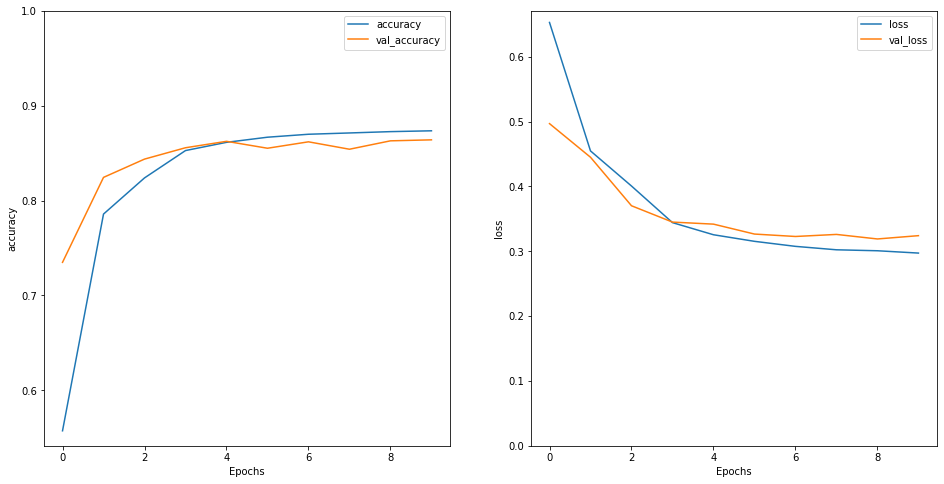

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10



  1/391 [..............................] - ETA: 1:32:05 - loss: 0.6937 - accuracy: 0.6250


  2/391 [..............................] - ETA: 55s - loss: 0.6932 - accuracy: 0.5703    


  3/391 [..............................] - ETA: 49s - loss: 0.6935 - accuracy: 0.5677


  4/391 [..............................] - ETA: 50s - loss: 0.6934 - accuracy: 0.5430


  5/391 [..............................] - ETA: 51s - loss: 0.6933 - accuracy: 0.5437


  6/391 [..............................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5365


  7/391 [..............................] - ETA: 52s - loss: 0.6932 - accuracy: 0.5379


  8/391 [..............................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5410


  9/391 [..............................] - ETA: 50s - loss: 0.6931 - accuracy: 0.5330


 10/391 [..............................] - ETA: 50s - loss: 0.6931 - accuracy: 0.5328


 11/391 [..............................] - ETA: 53s - loss: 0.6932 - accuracy: 0.5227


 12/391 [..............................] - ETA: 51s - loss: 0.6932 - accuracy: 0.5208


 13/391 [..............................] - ETA: 51s - loss: 0.6932 - accuracy: 0.5156


 14/391 [>.............................] - ETA: 51s - loss: 0.6932 - accuracy: 0.5234


 15/391 [>.............................] - ETA: 50s - loss: 0.6932 - accuracy: 0.5177


 16/391 [>.............................] - ETA: 50s - loss: 0.6932 - accuracy: 0.5186


 17/391 [>.............................] - ETA: 50s - loss: 0.6933 - accuracy: 0.5110


 18/391 [>.............................] - ETA: 49s - loss: 0.6932 - accuracy: 0.5095


 19/391 [>.............................] - ETA: 49s - loss: 0.6933 - accuracy: 0.5058


 20/391 [>.............................] - ETA: 49s - loss: 0.6933 - accuracy: 0.5023


 21/391 [>.............................] - ETA: 48s - loss: 0.6933 - accuracy: 0.5022


 22/391 [>.............................] - ETA: 48s - loss: 0.6933 - accuracy: 0.5007


 23/391 [>.............................] - ETA: 48s - loss: 0.6933 - accuracy: 0.4993


 24/391 [>.............................] - ETA: 48s - loss: 0.6933 - accuracy: 0.5033


 25/391 [>.............................] - ETA: 48s - loss: 0.6933 - accuracy: 0.5088


 26/391 [>.............................] - ETA: 48s - loss: 0.6933 - accuracy: 0.5084


 27/391 [=>............................] - ETA: 47s - loss: 0.6933 - accuracy: 0.5087


 28/391 [=>............................] - ETA: 47s - loss: 0.6933 - accuracy: 0.5123


 29/391 [=>............................] - ETA: 46s - loss: 0.6933 - accuracy: 0.5145


 30/391 [=>............................] - ETA: 46s - loss: 0.6933 - accuracy: 0.5104


 31/391 [=>............................] - ETA: 46s - loss: 0.6933 - accuracy: 0.5060


 32/391 [=>............................] - ETA: 46s - loss: 0.6933 - accuracy: 0.5073


 33/391 [=>............................] - ETA: 46s - loss: 0.6933 - accuracy: 0.5090


 34/391 [=>............................] - ETA: 46s - loss: 0.6933 - accuracy: 0.5055


 35/391 [=>............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.5089


 36/391 [=>............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.5061


 37/391 [=>............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.5055


 38/391 [=>............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.5021


 39/391 [=>............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.4988


 40/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.4980


 41/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5004


 42/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5004


 43/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.4996


 44/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5011


 45/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5035


 46/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5048


 47/391 [==>...........................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5060


 48/391 [==>...........................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5055


 49/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5054


 50/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5056


 51/391 [==>...........................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5064


 52/391 [==>...........................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5054


 53/391 [===>..........................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5029


 54/391 [===>..........................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5023


 55/391 [===>..........................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5031


 56/391 [===>..........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5061


 57/391 [===>..........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5055


 58/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5059


 59/391 [===>..........................] - ETA: 42s - loss: 0.6932 - accuracy: 0.5053


 60/391 [===>..........................] - ETA: 42s - loss: 0.6932 - accuracy: 0.5049


 61/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5056


 62/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5048


 63/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5042


 64/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5032


 65/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5041


 66/391 [====>.........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5040


 67/391 [====>.........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5056


 68/391 [====>.........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5067


 69/391 [====>.........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5072


 70/391 [====>.........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5078


 71/391 [====>.........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5075


 72/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5080


 73/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5077


 74/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5089


 75/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5085


 76/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5068


 77/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5071


 78/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5068


 79/391 [=====>........................] - ETA: 39s - loss: 0.6931 - accuracy: 0.5059


 80/391 [=====>........................] - ETA: 39s - loss: 0.6931 - accuracy: 0.5066


 81/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5068


 82/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5044


 83/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5040


 84/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5056


 85/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5055


 86/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5051


 87/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5054


 88/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5050


 89/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5054


 90/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5056


 91/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5057


 92/391 [======>.......................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5053


 93/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5054


 94/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5057


 95/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5054


 96/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5052


 97/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5058


 98/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5056


 99/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5057


100/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5061


101/391 [======>.......................] - ETA: 36s - loss: 0.6928 - accuracy: 0.5070


102/391 [======>.......................] - ETA: 36s - loss: 0.6928 - accuracy: 0.5064


103/391 [======>.......................] - ETA: 36s - loss: 0.6928 - accuracy: 0.5058


104/391 [======>.......................] - ETA: 36s - loss: 0.6928 - accuracy: 0.5066


105/391 [=======>......................] - ETA: 36s - loss: 0.6928 - accuracy: 0.5068


106/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5071


107/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5057


108/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5058


109/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5053


110/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5047


111/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5051


112/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5059


113/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5047


114/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5048


115/391 [=======>......................] - ETA: 34s - loss: 0.6927 - accuracy: 0.5042


116/391 [=======>......................] - ETA: 34s - loss: 0.6927 - accuracy: 0.5032


117/391 [=======>......................] - ETA: 34s - loss: 0.6927 - accuracy: 0.5028


118/391 [========>.....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.5025


119/391 [========>.....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.5022


120/391 [========>.....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.5021


121/391 [========>.....................] - ETA: 34s - loss: 0.6926 - accuracy: 0.5021


122/391 [========>.....................] - ETA: 33s - loss: 0.6927 - accuracy: 0.5028


123/391 [========>.....................] - ETA: 33s - loss: 0.6927 - accuracy: 0.5033


124/391 [========>.....................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5034


125/391 [========>.....................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5034


126/391 [========>.....................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5036


127/391 [========>.....................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5034


128/391 [========>.....................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5034


129/391 [========>.....................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5035


130/391 [========>.....................] - ETA: 32s - loss: 0.6926 - accuracy: 0.5034


131/391 [=========>....................] - ETA: 32s - loss: 0.6926 - accuracy: 0.5030


132/391 [=========>....................] - ETA: 32s - loss: 0.6926 - accuracy: 0.5026


133/391 [=========>....................] - ETA: 32s - loss: 0.6926 - accuracy: 0.5019


134/391 [=========>....................] - ETA: 32s - loss: 0.6925 - accuracy: 0.5019


135/391 [=========>....................] - ETA: 32s - loss: 0.6925 - accuracy: 0.5023


136/391 [=========>....................] - ETA: 32s - loss: 0.6925 - accuracy: 0.5023


137/391 [=========>....................] - ETA: 32s - loss: 0.6925 - accuracy: 0.5024


138/391 [=========>....................] - ETA: 32s - loss: 0.6925 - accuracy: 0.5028


139/391 [=========>....................] - ETA: 31s - loss: 0.6925 - accuracy: 0.5028


140/391 [=========>....................] - ETA: 31s - loss: 0.6925 - accuracy: 0.5025


141/391 [=========>....................] - ETA: 31s - loss: 0.6925 - accuracy: 0.5023


142/391 [=========>....................] - ETA: 31s - loss: 0.6925 - accuracy: 0.5029


143/391 [=========>....................] - ETA: 31s - loss: 0.6925 - accuracy: 0.5027


144/391 [==========>...................] - ETA: 31s - loss: 0.6925 - accuracy: 0.5028


145/391 [==========>...................] - ETA: 31s - loss: 0.6924 - accuracy: 0.5025


146/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5026


147/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5030


148/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5032


149/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5034


150/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5041


151/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5034


152/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5039


153/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5035


154/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5042


155/391 [==========>...................] - ETA: 29s - loss: 0.6924 - accuracy: 0.5043


156/391 [==========>...................] - ETA: 29s - loss: 0.6923 - accuracy: 0.5044


157/391 [===========>..................] - ETA: 29s - loss: 0.6923 - accuracy: 0.5049


158/391 [===========>..................] - ETA: 29s - loss: 0.6923 - accuracy: 0.5047


159/391 [===========>..................] - ETA: 29s - loss: 0.6923 - accuracy: 0.5049


160/391 [===========>..................] - ETA: 29s - loss: 0.6923 - accuracy: 0.5045


161/391 [===========>..................] - ETA: 29s - loss: 0.6923 - accuracy: 0.5049


162/391 [===========>..................] - ETA: 29s - loss: 0.6922 - accuracy: 0.5044


163/391 [===========>..................] - ETA: 28s - loss: 0.6922 - accuracy: 0.5049


164/391 [===========>..................] - ETA: 28s - loss: 0.6922 - accuracy: 0.5051


165/391 [===========>..................] - ETA: 28s - loss: 0.6922 - accuracy: 0.5052


166/391 [===========>..................] - ETA: 28s - loss: 0.6922 - accuracy: 0.5050


167/391 [===========>..................] - ETA: 28s - loss: 0.6921 - accuracy: 0.5051


168/391 [===========>..................] - ETA: 28s - loss: 0.6921 - accuracy: 0.5055


169/391 [===========>..................] - ETA: 28s - loss: 0.6921 - accuracy: 0.5054


170/391 [============>.................] - ETA: 27s - loss: 0.6921 - accuracy: 0.5051


171/391 [============>.................] - ETA: 27s - loss: 0.6920 - accuracy: 0.5054


172/391 [============>.................] - ETA: 27s - loss: 0.6920 - accuracy: 0.5051


173/391 [============>.................] - ETA: 27s - loss: 0.6920 - accuracy: 0.5052


174/391 [============>.................] - ETA: 27s - loss: 0.6920 - accuracy: 0.5049


175/391 [============>.................] - ETA: 27s - loss: 0.6920 - accuracy: 0.5053


176/391 [============>.................] - ETA: 27s - loss: 0.6919 - accuracy: 0.5055


177/391 [============>.................] - ETA: 27s - loss: 0.6919 - accuracy: 0.5053


178/391 [============>.................] - ETA: 26s - loss: 0.6919 - accuracy: 0.5054


179/391 [============>.................] - ETA: 26s - loss: 0.6919 - accuracy: 0.5054


180/391 [============>.................] - ETA: 26s - loss: 0.6919 - accuracy: 0.5050


181/391 [============>.................] - ETA: 26s - loss: 0.6919 - accuracy: 0.5050


182/391 [============>.................] - ETA: 26s - loss: 0.6918 - accuracy: 0.5046


183/391 [=============>................] - ETA: 26s - loss: 0.6918 - accuracy: 0.5045


184/391 [=============>................] - ETA: 26s - loss: 0.6918 - accuracy: 0.5048


185/391 [=============>................] - ETA: 26s - loss: 0.6918 - accuracy: 0.5045


186/391 [=============>................] - ETA: 26s - loss: 0.6917 - accuracy: 0.5046


187/391 [=============>................] - ETA: 25s - loss: 0.6917 - accuracy: 0.5047


188/391 [=============>................] - ETA: 25s - loss: 0.6917 - accuracy: 0.5044


189/391 [=============>................] - ETA: 25s - loss: 0.6917 - accuracy: 0.5049


190/391 [=============>................] - ETA: 25s - loss: 0.6917 - accuracy: 0.5043


191/391 [=============>................] - ETA: 25s - loss: 0.6916 - accuracy: 0.5037


192/391 [=============>................] - ETA: 25s - loss: 0.6916 - accuracy: 0.5031


193/391 [=============>................] - ETA: 25s - loss: 0.6915 - accuracy: 0.5024


194/391 [=============>................] - ETA: 25s - loss: 0.6915 - accuracy: 0.5023


195/391 [=============>................] - ETA: 24s - loss: 0.6915 - accuracy: 0.5021


196/391 [==============>...............] - ETA: 24s - loss: 0.6914 - accuracy: 0.5018


197/391 [==============>...............] - ETA: 24s - loss: 0.6914 - accuracy: 0.5017


198/391 [==============>...............] - ETA: 24s - loss: 0.6914 - accuracy: 0.5017


199/391 [==============>...............] - ETA: 24s - loss: 0.6914 - accuracy: 0.5012


200/391 [==============>...............] - ETA: 24s - loss: 0.6913 - accuracy: 0.5006


201/391 [==============>...............] - ETA: 24s - loss: 0.6913 - accuracy: 0.5005


202/391 [==============>...............] - ETA: 24s - loss: 0.6912 - accuracy: 0.5002


203/391 [==============>...............] - ETA: 23s - loss: 0.6912 - accuracy: 0.5002


204/391 [==============>...............] - ETA: 23s - loss: 0.6912 - accuracy: 0.5001


205/391 [==============>...............] - ETA: 23s - loss: 0.6912 - accuracy: 0.5000


206/391 [==============>...............] - ETA: 23s - loss: 0.6912 - accuracy: 0.5001


207/391 [==============>...............] - ETA: 23s - loss: 0.6911 - accuracy: 0.4999


208/391 [==============>...............] - ETA: 23s - loss: 0.6911 - accuracy: 0.5001


209/391 [===============>..............] - ETA: 23s - loss: 0.6910 - accuracy: 0.5001


210/391 [===============>..............] - ETA: 23s - loss: 0.6910 - accuracy: 0.5002


211/391 [===============>..............] - ETA: 22s - loss: 0.6910 - accuracy: 0.5004


212/391 [===============>..............] - ETA: 22s - loss: 0.6910 - accuracy: 0.5002


213/391 [===============>..............] - ETA: 22s - loss: 0.6909 - accuracy: 0.4999


214/391 [===============>..............] - ETA: 22s - loss: 0.6909 - accuracy: 0.5000


215/391 [===============>..............] - ETA: 22s - loss: 0.6908 - accuracy: 0.5000


216/391 [===============>..............] - ETA: 22s - loss: 0.6908 - accuracy: 0.5001


217/391 [===============>..............] - ETA: 22s - loss: 0.6908 - accuracy: 0.4999


218/391 [===============>..............] - ETA: 22s - loss: 0.6907 - accuracy: 0.4999


219/391 [===============>..............] - ETA: 21s - loss: 0.6907 - accuracy: 0.5002


220/391 [===============>..............] - ETA: 21s - loss: 0.6906 - accuracy: 0.5009


221/391 [===============>..............] - ETA: 21s - loss: 0.6906 - accuracy: 0.5013


222/391 [================>.............] - ETA: 21s - loss: 0.6905 - accuracy: 0.5011


223/391 [================>.............] - ETA: 21s - loss: 0.6905 - accuracy: 0.5006


224/391 [================>.............] - ETA: 21s - loss: 0.6904 - accuracy: 0.5007


225/391 [================>.............] - ETA: 21s - loss: 0.6904 - accuracy: 0.5002


226/391 [================>.............] - ETA: 21s - loss: 0.6903 - accuracy: 0.5006


227/391 [================>.............] - ETA: 20s - loss: 0.6902 - accuracy: 0.5004


228/391 [================>.............] - ETA: 20s - loss: 0.6901 - accuracy: 0.5009


229/391 [================>.............] - ETA: 20s - loss: 0.6899 - accuracy: 0.5011


230/391 [================>.............] - ETA: 20s - loss: 0.6899 - accuracy: 0.5010


231/391 [================>.............] - ETA: 20s - loss: 0.6898 - accuracy: 0.5009


232/391 [================>.............] - ETA: 20s - loss: 0.6896 - accuracy: 0.5009


233/391 [================>.............] - ETA: 20s - loss: 0.6894 - accuracy: 0.5011


234/391 [================>.............] - ETA: 20s - loss: 0.6892 - accuracy: 0.5011


235/391 [=================>............] - ETA: 19s - loss: 0.6891 - accuracy: 0.5009


236/391 [=================>............] - ETA: 19s - loss: 0.6891 - accuracy: 0.5007


237/391 [=================>............] - ETA: 19s - loss: 0.6890 - accuracy: 0.5009


238/391 [=================>............] - ETA: 19s - loss: 0.6888 - accuracy: 0.5012


239/391 [=================>............] - ETA: 19s - loss: 0.6887 - accuracy: 0.5011


240/391 [=================>............] - ETA: 19s - loss: 0.6884 - accuracy: 0.5018


241/391 [=================>............] - ETA: 19s - loss: 0.6882 - accuracy: 0.5020


242/391 [=================>............] - ETA: 18s - loss: 0.6880 - accuracy: 0.5022


243/391 [=================>............] - ETA: 18s - loss: 0.6879 - accuracy: 0.5023


244/391 [=================>............] - ETA: 18s - loss: 0.6876 - accuracy: 0.5023


245/391 [=================>............] - ETA: 18s - loss: 0.6873 - accuracy: 0.5030


246/391 [=================>............] - ETA: 18s - loss: 0.6873 - accuracy: 0.5034


247/391 [=================>............] - ETA: 18s - loss: 0.6869 - accuracy: 0.5042


248/391 [==================>...........] - ETA: 18s - loss: 0.6865 - accuracy: 0.5055


249/391 [==================>...........] - ETA: 18s - loss: 0.6863 - accuracy: 0.5063


250/391 [==================>...........] - ETA: 17s - loss: 0.6858 - accuracy: 0.5070


251/391 [==================>...........] - ETA: 17s - loss: 0.6854 - accuracy: 0.5075


252/391 [==================>...........] - ETA: 17s - loss: 0.6851 - accuracy: 0.5078


253/391 [==================>...........] - ETA: 17s - loss: 0.6847 - accuracy: 0.5083


254/391 [==================>...........] - ETA: 17s - loss: 0.6846 - accuracy: 0.5085


255/391 [==================>...........] - ETA: 17s - loss: 0.6841 - accuracy: 0.5089


256/391 [==================>...........] - ETA: 17s - loss: 0.6836 - accuracy: 0.5094


257/391 [==================>...........] - ETA: 17s - loss: 0.6831 - accuracy: 0.5103


258/391 [==================>...........] - ETA: 16s - loss: 0.6825 - accuracy: 0.5114


259/391 [==================>...........] - ETA: 16s - loss: 0.6818 - accuracy: 0.5123


260/391 [==================>...........] - ETA: 16s - loss: 0.6813 - accuracy: 0.5132


261/391 [===================>..........] - ETA: 16s - loss: 0.6812 - accuracy: 0.5135


262/391 [===================>..........] - ETA: 16s - loss: 0.6812 - accuracy: 0.5137


263/391 [===================>..........] - ETA: 16s - loss: 0.6806 - accuracy: 0.5147


264/391 [===================>..........] - ETA: 16s - loss: 0.6799 - accuracy: 0.5156


265/391 [===================>..........] - ETA: 16s - loss: 0.6793 - accuracy: 0.5166


266/391 [===================>..........] - ETA: 15s - loss: 0.6787 - accuracy: 0.5175


267/391 [===================>..........] - ETA: 15s - loss: 0.6784 - accuracy: 0.5181


268/391 [===================>..........] - ETA: 15s - loss: 0.6777 - accuracy: 0.5188


269/391 [===================>..........] - ETA: 15s - loss: 0.6772 - accuracy: 0.5198


270/391 [===================>..........] - ETA: 15s - loss: 0.6771 - accuracy: 0.5203


271/391 [===================>..........] - ETA: 15s - loss: 0.6767 - accuracy: 0.5210


272/391 [===================>..........] - ETA: 15s - loss: 0.6764 - accuracy: 0.5217


273/391 [===================>..........] - ETA: 14s - loss: 0.6760 - accuracy: 0.5223


274/391 [====================>.........] - ETA: 14s - loss: 0.6756 - accuracy: 0.5234


275/391 [====================>.........] - ETA: 14s - loss: 0.6751 - accuracy: 0.5241


276/391 [====================>.........] - ETA: 14s - loss: 0.6742 - accuracy: 0.5249


277/391 [====================>.........] - ETA: 14s - loss: 0.6738 - accuracy: 0.5253


278/391 [====================>.........] - ETA: 14s - loss: 0.6732 - accuracy: 0.5261


279/391 [====================>.........] - ETA: 14s - loss: 0.6727 - accuracy: 0.5268


280/391 [====================>.........] - ETA: 14s - loss: 0.6722 - accuracy: 0.5273


281/391 [====================>.........] - ETA: 13s - loss: 0.6717 - accuracy: 0.5282


282/391 [====================>.........] - ETA: 13s - loss: 0.6714 - accuracy: 0.5288


283/391 [====================>.........] - ETA: 13s - loss: 0.6708 - accuracy: 0.5296


284/391 [====================>.........] - ETA: 13s - loss: 0.6701 - accuracy: 0.5307


285/391 [====================>.........] - ETA: 13s - loss: 0.6695 - accuracy: 0.5318


286/391 [====================>.........] - ETA: 13s - loss: 0.6694 - accuracy: 0.5323


287/391 [=====================>........] - ETA: 13s - loss: 0.6687 - accuracy: 0.5334


288/391 [=====================>........] - ETA: 13s - loss: 0.6681 - accuracy: 0.5341


289/391 [=====================>........] - ETA: 12s - loss: 0.6675 - accuracy: 0.5348


290/391 [=====================>........] - ETA: 12s - loss: 0.6668 - accuracy: 0.5357


291/391 [=====================>........] - ETA: 12s - loss: 0.6661 - accuracy: 0.5367


292/391 [=====================>........] - ETA: 12s - loss: 0.6658 - accuracy: 0.5374


293/391 [=====================>........] - ETA: 12s - loss: 0.6655 - accuracy: 0.5379


294/391 [=====================>........] - ETA: 12s - loss: 0.6649 - accuracy: 0.5388


295/391 [=====================>........] - ETA: 12s - loss: 0.6645 - accuracy: 0.5394


296/391 [=====================>........] - ETA: 11s - loss: 0.6641 - accuracy: 0.5400


297/391 [=====================>........] - ETA: 11s - loss: 0.6633 - accuracy: 0.5408


298/391 [=====================>........] - ETA: 11s - loss: 0.6625 - accuracy: 0.5417


299/391 [=====================>........] - ETA: 11s - loss: 0.6620 - accuracy: 0.5424


300/391 [======================>.......] - ETA: 11s - loss: 0.6614 - accuracy: 0.5432


301/391 [======================>.......] - ETA: 11s - loss: 0.6607 - accuracy: 0.5442


302/391 [======================>.......] - ETA: 11s - loss: 0.6601 - accuracy: 0.5451


303/391 [======================>.......] - ETA: 11s - loss: 0.6595 - accuracy: 0.5458


304/391 [======================>.......] - ETA: 10s - loss: 0.6589 - accuracy: 0.5468


305/391 [======================>.......] - ETA: 10s - loss: 0.6585 - accuracy: 0.5474


306/391 [======================>.......] - ETA: 10s - loss: 0.6581 - accuracy: 0.5482


307/391 [======================>.......] - ETA: 10s - loss: 0.6571 - accuracy: 0.5493


308/391 [======================>.......] - ETA: 10s - loss: 0.6569 - accuracy: 0.5499


309/391 [======================>.......] - ETA: 10s - loss: 0.6564 - accuracy: 0.5507


310/391 [======================>.......] - ETA: 10s - loss: 0.6558 - accuracy: 0.5515


311/391 [======================>.......] - ETA: 10s - loss: 0.6551 - accuracy: 0.5524


312/391 [======================>.......] - ETA: 9s - loss: 0.6544 - accuracy: 0.5532 


313/391 [=======================>......] - ETA: 9s - loss: 0.6539 - accuracy: 0.5538


314/391 [=======================>......] - ETA: 9s - loss: 0.6538 - accuracy: 0.5544


315/391 [=======================>......] - ETA: 9s - loss: 0.6534 - accuracy: 0.5550


316/391 [=======================>......] - ETA: 9s - loss: 0.6528 - accuracy: 0.5557


317/391 [=======================>......] - ETA: 9s - loss: 0.6522 - accuracy: 0.5563


318/391 [=======================>......] - ETA: 9s - loss: 0.6518 - accuracy: 0.5570


319/391 [=======================>......] - ETA: 9s - loss: 0.6515 - accuracy: 0.5574


320/391 [=======================>......] - ETA: 8s - loss: 0.6507 - accuracy: 0.5583


321/391 [=======================>......] - ETA: 8s - loss: 0.6502 - accuracy: 0.5589


322/391 [=======================>......] - ETA: 8s - loss: 0.6497 - accuracy: 0.5594


323/391 [=======================>......] - ETA: 8s - loss: 0.6490 - accuracy: 0.5602


324/391 [=======================>......] - ETA: 8s - loss: 0.6484 - accuracy: 0.5609


325/391 [=======================>......] - ETA: 8s - loss: 0.6479 - accuracy: 0.5615


326/391 [========================>.....] - ETA: 8s - loss: 0.6475 - accuracy: 0.5621


327/391 [========================>.....] - ETA: 8s - loss: 0.6470 - accuracy: 0.5629


328/391 [========================>.....] - ETA: 7s - loss: 0.6467 - accuracy: 0.5632


329/391 [========================>.....] - ETA: 7s - loss: 0.6463 - accuracy: 0.5637


330/391 [========================>.....] - ETA: 7s - loss: 0.6461 - accuracy: 0.5643


331/391 [========================>.....] - ETA: 7s - loss: 0.6456 - accuracy: 0.5649


332/391 [========================>.....] - ETA: 7s - loss: 0.6451 - accuracy: 0.5655


333/391 [========================>.....] - ETA: 7s - loss: 0.6444 - accuracy: 0.5662


334/391 [========================>.....] - ETA: 7s - loss: 0.6438 - accuracy: 0.5669


335/391 [========================>.....] - ETA: 7s - loss: 0.6434 - accuracy: 0.5675


336/391 [========================>.....] - ETA: 6s - loss: 0.6427 - accuracy: 0.5683


337/391 [========================>.....] - ETA: 6s - loss: 0.6422 - accuracy: 0.5690


338/391 [========================>.....] - ETA: 6s - loss: 0.6421 - accuracy: 0.5694


339/391 [=========================>....] - ETA: 6s - loss: 0.6417 - accuracy: 0.5700


340/391 [=========================>....] - ETA: 6s - loss: 0.6410 - accuracy: 0.5709


341/391 [=========================>....] - ETA: 6s - loss: 0.6404 - accuracy: 0.5716


342/391 [=========================>....] - ETA: 6s - loss: 0.6399 - accuracy: 0.5721


343/391 [=========================>....] - ETA: 6s - loss: 0.6393 - accuracy: 0.5727


344/391 [=========================>....] - ETA: 5s - loss: 0.6386 - accuracy: 0.5736


345/391 [=========================>....] - ETA: 5s - loss: 0.6380 - accuracy: 0.5742


346/391 [=========================>....] - ETA: 5s - loss: 0.6374 - accuracy: 0.5749


347/391 [=========================>....] - ETA: 5s - loss: 0.6371 - accuracy: 0.5754


348/391 [=========================>....] - ETA: 5s - loss: 0.6371 - accuracy: 0.5757


349/391 [=========================>....] - ETA: 5s - loss: 0.6367 - accuracy: 0.5762


350/391 [=========================>....] - ETA: 5s - loss: 0.6365 - accuracy: 0.5767


351/391 [=========================>....] - ETA: 5s - loss: 0.6355 - accuracy: 0.5777


352/391 [==========================>...] - ETA: 4s - loss: 0.6348 - accuracy: 0.5785


353/391 [==========================>...] - ETA: 4s - loss: 0.6344 - accuracy: 0.5791


354/391 [==========================>...] - ETA: 4s - loss: 0.6338 - accuracy: 0.5798


355/391 [==========================>...] - ETA: 4s - loss: 0.6328 - accuracy: 0.5807


356/391 [==========================>...] - ETA: 4s - loss: 0.6323 - accuracy: 0.5813


357/391 [==========================>...] - ETA: 4s - loss: 0.6317 - accuracy: 0.5820


358/391 [==========================>...] - ETA: 4s - loss: 0.6315 - accuracy: 0.5825


359/391 [==========================>...] - ETA: 4s - loss: 0.6309 - accuracy: 0.5832


360/391 [==========================>...] - ETA: 3s - loss: 0.6303 - accuracy: 0.5838


361/391 [==========================>...] - ETA: 3s - loss: 0.6301 - accuracy: 0.5842


362/391 [==========================>...] - ETA: 3s - loss: 0.6298 - accuracy: 0.5846


363/391 [==========================>...] - ETA: 3s - loss: 0.6294 - accuracy: 0.5852


364/391 [==========================>...] - ETA: 3s - loss: 0.6288 - accuracy: 0.5859


365/391 [===========================>..] - ETA: 3s - loss: 0.6284 - accuracy: 0.5864


366/391 [===========================>..] - ETA: 3s - loss: 0.6282 - accuracy: 0.5868


367/391 [===========================>..] - ETA: 3s - loss: 0.6280 - accuracy: 0.5872


368/391 [===========================>..] - ETA: 2s - loss: 0.6273 - accuracy: 0.5878


369/391 [===========================>..] - ETA: 2s - loss: 0.6272 - accuracy: 0.5883


370/391 [===========================>..] - ETA: 2s - loss: 0.6265 - accuracy: 0.5891


371/391 [===========================>..] - ETA: 2s - loss: 0.6261 - accuracy: 0.5897


372/391 [===========================>..] - ETA: 2s - loss: 0.6255 - accuracy: 0.5903


373/391 [===========================>..] - ETA: 2s - loss: 0.6253 - accuracy: 0.5908


374/391 [===========================>..] - ETA: 2s - loss: 0.6246 - accuracy: 0.5915


375/391 [===========================>..] - ETA: 2s - loss: 0.6239 - accuracy: 0.5921


376/391 [===========================>..] - ETA: 1s - loss: 0.6234 - accuracy: 0.5927


377/391 [===========================>..] - ETA: 1s - loss: 0.6229 - accuracy: 0.5933


378/391 [============================>.] - ETA: 1s - loss: 0.6229 - accuracy: 0.5936


379/391 [============================>.] - ETA: 1s - loss: 0.6223 - accuracy: 0.5942


380/391 [============================>.] - ETA: 1s - loss: 0.6218 - accuracy: 0.5948


381/391 [============================>.] - ETA: 1s - loss: 0.6214 - accuracy: 0.5953


382/391 [============================>.] - ETA: 1s - loss: 0.6206 - accuracy: 0.5960


383/391 [============================>.] - ETA: 1s - loss: 0.6202 - accuracy: 0.5965


384/391 [============================>.] - ETA: 0s - loss: 0.6199 - accuracy: 0.5970


385/391 [============================>.] - ETA: 0s - loss: 0.6194 - accuracy: 0.5975


386/391 [============================>.] - ETA: 0s - loss: 0.6190 - accuracy: 0.5980


387/391 [============================>.] - ETA: 0s - loss: 0.6186 - accuracy: 0.5984


388/391 [============================>.] - ETA: 0s - loss: 0.6181 - accuracy: 0.5991


389/391 [============================>.] - ETA: 0s - loss: 0.6174 - accuracy: 0.5997


390/391 [============================>.] - ETA: 0s - loss: 0.6166 - accuracy: 0.6004


391/391 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.6006


391/391 [==============================] - 71s 145ms/step - loss: 0.6166 - accuracy: 0.6006 - val_loss: 0.4270 - val_accuracy: 0.8125


Epoch 2/10



  1/391 [..............................] - ETA: 4:52 - loss: 0.3987 - accuracy: 0.8125


  2/391 [..............................] - ETA: 51s - loss: 0.4086 - accuracy: 0.8047 


  3/391 [..............................] - ETA: 52s - loss: 0.4404 - accuracy: 0.7969


  4/391 [..............................] - ETA: 51s - loss: 0.4424 - accuracy: 0.8008


  5/391 [..............................] - ETA: 48s - loss: 0.4262 - accuracy: 0.8156


  6/391 [..............................] - ETA: 46s - loss: 0.4285 - accuracy: 0.8073


  7/391 [..............................] - ETA: 45s - loss: 0.4328 - accuracy: 0.8036


  8/391 [..............................] - ETA: 48s - loss: 0.4303 - accuracy: 0.8086


  9/391 [..............................] - ETA: 49s - loss: 0.4125 - accuracy: 0.8229


 10/391 [..............................] - ETA: 48s - loss: 0.4185 - accuracy: 0.8188


 11/391 [..............................] - ETA: 47s - loss: 0.4212 - accuracy: 0.8182


 12/391 [..............................] - ETA: 48s - loss: 0.4195 - accuracy: 0.8190


 13/391 [..............................] - ETA: 48s - loss: 0.4172 - accuracy: 0.8209


 14/391 [>.............................] - ETA: 47s - loss: 0.4192 - accuracy: 0.8203


 15/391 [>.............................] - ETA: 47s - loss: 0.4202 - accuracy: 0.8198


 16/391 [>.............................] - ETA: 47s - loss: 0.4229 - accuracy: 0.8174


 17/391 [>.............................] - ETA: 46s - loss: 0.4198 - accuracy: 0.8208


 18/391 [>.............................] - ETA: 46s - loss: 0.4234 - accuracy: 0.8186


 19/391 [>.............................] - ETA: 46s - loss: 0.4229 - accuracy: 0.8183


 20/391 [>.............................] - ETA: 45s - loss: 0.4264 - accuracy: 0.8164


 21/391 [>.............................] - ETA: 45s - loss: 0.4209 - accuracy: 0.8207


 22/391 [>.............................] - ETA: 45s - loss: 0.4244 - accuracy: 0.8189


 23/391 [>.............................] - ETA: 45s - loss: 0.4261 - accuracy: 0.8173


 24/391 [>.............................] - ETA: 45s - loss: 0.4276 - accuracy: 0.8158


 25/391 [>.............................] - ETA: 44s - loss: 0.4278 - accuracy: 0.8144


 26/391 [>.............................] - ETA: 45s - loss: 0.4294 - accuracy: 0.8143


 27/391 [=>............................] - ETA: 45s - loss: 0.4292 - accuracy: 0.8148


 28/391 [=>............................] - ETA: 45s - loss: 0.4270 - accuracy: 0.8158


 29/391 [=>............................] - ETA: 45s - loss: 0.4268 - accuracy: 0.8163


 30/391 [=>............................] - ETA: 45s - loss: 0.4242 - accuracy: 0.8177


 31/391 [=>............................] - ETA: 44s - loss: 0.4210 - accuracy: 0.8206


 32/391 [=>............................] - ETA: 44s - loss: 0.4189 - accuracy: 0.8208


 33/391 [=>............................] - ETA: 45s - loss: 0.4191 - accuracy: 0.8210


 34/391 [=>............................] - ETA: 45s - loss: 0.4206 - accuracy: 0.8203


 35/391 [=>............................] - ETA: 44s - loss: 0.4181 - accuracy: 0.8223


 36/391 [=>............................] - ETA: 44s - loss: 0.4188 - accuracy: 0.8220


 37/391 [=>............................] - ETA: 44s - loss: 0.4194 - accuracy: 0.8209


 38/391 [=>............................] - ETA: 44s - loss: 0.4176 - accuracy: 0.8207


 39/391 [=>............................] - ETA: 43s - loss: 0.4208 - accuracy: 0.8169


 40/391 [==>...........................] - ETA: 43s - loss: 0.4204 - accuracy: 0.8176


 41/391 [==>...........................] - ETA: 43s - loss: 0.4201 - accuracy: 0.8163


 42/391 [==>...........................] - ETA: 43s - loss: 0.4209 - accuracy: 0.8162


 43/391 [==>...........................] - ETA: 43s - loss: 0.4181 - accuracy: 0.8183


 44/391 [==>...........................] - ETA: 43s - loss: 0.4174 - accuracy: 0.8182


 45/391 [==>...........................] - ETA: 43s - loss: 0.4206 - accuracy: 0.8167


 46/391 [==>...........................] - ETA: 42s - loss: 0.4217 - accuracy: 0.8169


 47/391 [==>...........................] - ETA: 42s - loss: 0.4201 - accuracy: 0.8185


 48/391 [==>...........................] - ETA: 42s - loss: 0.4202 - accuracy: 0.8184


 49/391 [==>...........................] - ETA: 42s - loss: 0.4193 - accuracy: 0.8189


 50/391 [==>...........................] - ETA: 42s - loss: 0.4184 - accuracy: 0.8191


 51/391 [==>...........................] - ETA: 41s - loss: 0.4168 - accuracy: 0.8189


 52/391 [==>...........................] - ETA: 41s - loss: 0.4181 - accuracy: 0.8176


 53/391 [===>..........................] - ETA: 41s - loss: 0.4180 - accuracy: 0.8169


 54/391 [===>..........................] - ETA: 41s - loss: 0.4171 - accuracy: 0.8171


 55/391 [===>..........................] - ETA: 41s - loss: 0.4149 - accuracy: 0.8190


 56/391 [===>..........................] - ETA: 41s - loss: 0.4159 - accuracy: 0.8184


 57/391 [===>..........................] - ETA: 41s - loss: 0.4156 - accuracy: 0.8177


 58/391 [===>..........................] - ETA: 40s - loss: 0.4153 - accuracy: 0.8182


 59/391 [===>..........................] - ETA: 40s - loss: 0.4166 - accuracy: 0.8178


 60/391 [===>..........................] - ETA: 40s - loss: 0.4182 - accuracy: 0.8164


 61/391 [===>..........................] - ETA: 40s - loss: 0.4201 - accuracy: 0.8151


 62/391 [===>..........................] - ETA: 40s - loss: 0.4203 - accuracy: 0.8145


 63/391 [===>..........................] - ETA: 40s - loss: 0.4208 - accuracy: 0.8142


 64/391 [===>..........................] - ETA: 40s - loss: 0.4210 - accuracy: 0.8135


 65/391 [===>..........................] - ETA: 40s - loss: 0.4203 - accuracy: 0.8142


 66/391 [====>.........................] - ETA: 40s - loss: 0.4187 - accuracy: 0.8153


 67/391 [====>.........................] - ETA: 40s - loss: 0.4189 - accuracy: 0.8151


 68/391 [====>.........................] - ETA: 40s - loss: 0.4189 - accuracy: 0.8153


 69/391 [====>.........................] - ETA: 40s - loss: 0.4195 - accuracy: 0.8145


 70/391 [====>.........................] - ETA: 40s - loss: 0.4184 - accuracy: 0.8152


 71/391 [====>.........................] - ETA: 39s - loss: 0.4180 - accuracy: 0.8154


 72/391 [====>.........................] - ETA: 39s - loss: 0.4175 - accuracy: 0.8155


 73/391 [====>.........................] - ETA: 39s - loss: 0.4164 - accuracy: 0.8166


 74/391 [====>.........................] - ETA: 39s - loss: 0.4164 - accuracy: 0.8167


 75/391 [====>.........................] - ETA: 39s - loss: 0.4152 - accuracy: 0.8173


 76/391 [====>.........................] - ETA: 39s - loss: 0.4150 - accuracy: 0.8174


 77/391 [====>.........................] - ETA: 39s - loss: 0.4144 - accuracy: 0.8178


 78/391 [====>.........................] - ETA: 39s - loss: 0.4144 - accuracy: 0.8179


 79/391 [=====>........................] - ETA: 39s - loss: 0.4132 - accuracy: 0.8186


 80/391 [=====>........................] - ETA: 39s - loss: 0.4141 - accuracy: 0.8184


 81/391 [=====>........................] - ETA: 39s - loss: 0.4143 - accuracy: 0.8185


 82/391 [=====>........................] - ETA: 39s - loss: 0.4139 - accuracy: 0.8180


 83/391 [=====>........................] - ETA: 38s - loss: 0.4148 - accuracy: 0.8178


 84/391 [=====>........................] - ETA: 38s - loss: 0.4137 - accuracy: 0.8186


 85/391 [=====>........................] - ETA: 38s - loss: 0.4145 - accuracy: 0.8184


 86/391 [=====>........................] - ETA: 38s - loss: 0.4143 - accuracy: 0.8187


 87/391 [=====>........................] - ETA: 38s - loss: 0.4142 - accuracy: 0.8184


 88/391 [=====>........................] - ETA: 38s - loss: 0.4149 - accuracy: 0.8176


 89/391 [=====>........................] - ETA: 38s - loss: 0.4148 - accuracy: 0.8178


 90/391 [=====>........................] - ETA: 37s - loss: 0.4152 - accuracy: 0.8174


 91/391 [=====>........................] - ETA: 37s - loss: 0.4142 - accuracy: 0.8175


 92/391 [======>.......................] - ETA: 37s - loss: 0.4130 - accuracy: 0.8181


 93/391 [======>.......................] - ETA: 37s - loss: 0.4124 - accuracy: 0.8187


 94/391 [======>.......................] - ETA: 37s - loss: 0.4125 - accuracy: 0.8190


 95/391 [======>.......................] - ETA: 37s - loss: 0.4119 - accuracy: 0.8194


 96/391 [======>.......................] - ETA: 37s - loss: 0.4109 - accuracy: 0.8203


 97/391 [======>.......................] - ETA: 36s - loss: 0.4108 - accuracy: 0.8204


 98/391 [======>.......................] - ETA: 36s - loss: 0.4111 - accuracy: 0.8200


 99/391 [======>.......................] - ETA: 36s - loss: 0.4112 - accuracy: 0.8194


100/391 [======>.......................] - ETA: 36s - loss: 0.4121 - accuracy: 0.8189


101/391 [======>.......................] - ETA: 36s - loss: 0.4120 - accuracy: 0.8184


102/391 [======>.......................] - ETA: 36s - loss: 0.4116 - accuracy: 0.8188


103/391 [======>.......................] - ETA: 36s - loss: 0.4117 - accuracy: 0.8187


104/391 [======>.......................] - ETA: 36s - loss: 0.4109 - accuracy: 0.8193


105/391 [=======>......................] - ETA: 36s - loss: 0.4105 - accuracy: 0.8195


106/391 [=======>......................] - ETA: 35s - loss: 0.4104 - accuracy: 0.8197


107/391 [=======>......................] - ETA: 35s - loss: 0.4111 - accuracy: 0.8197


108/391 [=======>......................] - ETA: 35s - loss: 0.4108 - accuracy: 0.8203


109/391 [=======>......................] - ETA: 35s - loss: 0.4107 - accuracy: 0.8208


110/391 [=======>......................] - ETA: 35s - loss: 0.4106 - accuracy: 0.8202


111/391 [=======>......................] - ETA: 35s - loss: 0.4104 - accuracy: 0.8202


112/391 [=======>......................] - ETA: 35s - loss: 0.4111 - accuracy: 0.8200


113/391 [=======>......................] - ETA: 34s - loss: 0.4115 - accuracy: 0.8198


114/391 [=======>......................] - ETA: 34s - loss: 0.4109 - accuracy: 0.8202


115/391 [=======>......................] - ETA: 34s - loss: 0.4103 - accuracy: 0.8205


116/391 [=======>......................] - ETA: 34s - loss: 0.4103 - accuracy: 0.8206


117/391 [=======>......................] - ETA: 34s - loss: 0.4096 - accuracy: 0.8210


118/391 [========>.....................] - ETA: 34s - loss: 0.4101 - accuracy: 0.8208


119/391 [========>.....................] - ETA: 33s - loss: 0.4100 - accuracy: 0.8210


120/391 [========>.....................] - ETA: 33s - loss: 0.4086 - accuracy: 0.8219


121/391 [========>.....................] - ETA: 33s - loss: 0.4083 - accuracy: 0.8218


122/391 [========>.....................] - ETA: 33s - loss: 0.4074 - accuracy: 0.8220


123/391 [========>.....................] - ETA: 33s - loss: 0.4073 - accuracy: 0.8216


124/391 [========>.....................] - ETA: 33s - loss: 0.4060 - accuracy: 0.8222


125/391 [========>.....................] - ETA: 33s - loss: 0.4055 - accuracy: 0.8226


126/391 [========>.....................] - ETA: 33s - loss: 0.4054 - accuracy: 0.8228


127/391 [========>.....................] - ETA: 33s - loss: 0.4051 - accuracy: 0.8231


128/391 [========>.....................] - ETA: 32s - loss: 0.4044 - accuracy: 0.8230


129/391 [========>.....................] - ETA: 32s - loss: 0.4036 - accuracy: 0.8234


130/391 [========>.....................] - ETA: 32s - loss: 0.4033 - accuracy: 0.8234


131/391 [=========>....................] - ETA: 32s - loss: 0.4032 - accuracy: 0.8235


132/391 [=========>....................] - ETA: 32s - loss: 0.4040 - accuracy: 0.8233


133/391 [=========>....................] - ETA: 32s - loss: 0.4025 - accuracy: 0.8239


134/391 [=========>....................] - ETA: 32s - loss: 0.4019 - accuracy: 0.8243


135/391 [=========>....................] - ETA: 32s - loss: 0.4029 - accuracy: 0.8237


136/391 [=========>....................] - ETA: 31s - loss: 0.4039 - accuracy: 0.8231


137/391 [=========>....................] - ETA: 31s - loss: 0.4057 - accuracy: 0.8221


138/391 [=========>....................] - ETA: 31s - loss: 0.4058 - accuracy: 0.8219


139/391 [=========>....................] - ETA: 31s - loss: 0.4059 - accuracy: 0.8219


140/391 [=========>....................] - ETA: 31s - loss: 0.4067 - accuracy: 0.8214


141/391 [=========>....................] - ETA: 31s - loss: 0.4073 - accuracy: 0.8210


142/391 [=========>....................] - ETA: 31s - loss: 0.4074 - accuracy: 0.8210


143/391 [=========>....................] - ETA: 30s - loss: 0.4079 - accuracy: 0.8209


144/391 [==========>...................] - ETA: 30s - loss: 0.4086 - accuracy: 0.8207


145/391 [==========>...................] - ETA: 30s - loss: 0.4091 - accuracy: 0.8208


146/391 [==========>...................] - ETA: 30s - loss: 0.4094 - accuracy: 0.8206


147/391 [==========>...................] - ETA: 30s - loss: 0.4100 - accuracy: 0.8207


148/391 [==========>...................] - ETA: 30s - loss: 0.4101 - accuracy: 0.8209


149/391 [==========>...................] - ETA: 30s - loss: 0.4102 - accuracy: 0.8210


150/391 [==========>...................] - ETA: 30s - loss: 0.4108 - accuracy: 0.8209


151/391 [==========>...................] - ETA: 30s - loss: 0.4106 - accuracy: 0.8211


152/391 [==========>...................] - ETA: 29s - loss: 0.4111 - accuracy: 0.8203


153/391 [==========>...................] - ETA: 29s - loss: 0.4115 - accuracy: 0.8198


154/391 [==========>...................] - ETA: 29s - loss: 0.4118 - accuracy: 0.8195


155/391 [==========>...................] - ETA: 29s - loss: 0.4116 - accuracy: 0.8194


156/391 [==========>...................] - ETA: 29s - loss: 0.4120 - accuracy: 0.8194


157/391 [===========>..................] - ETA: 29s - loss: 0.4130 - accuracy: 0.8182


158/391 [===========>..................] - ETA: 29s - loss: 0.4126 - accuracy: 0.8182


159/391 [===========>..................] - ETA: 29s - loss: 0.4128 - accuracy: 0.8180


160/391 [===========>..................] - ETA: 29s - loss: 0.4123 - accuracy: 0.8186


161/391 [===========>..................] - ETA: 28s - loss: 0.4126 - accuracy: 0.8184


162/391 [===========>..................] - ETA: 28s - loss: 0.4128 - accuracy: 0.8185


163/391 [===========>..................] - ETA: 28s - loss: 0.4127 - accuracy: 0.8183


164/391 [===========>..................] - ETA: 28s - loss: 0.4123 - accuracy: 0.8184


165/391 [===========>..................] - ETA: 28s - loss: 0.4123 - accuracy: 0.8184


166/391 [===========>..................] - ETA: 28s - loss: 0.4123 - accuracy: 0.8184


167/391 [===========>..................] - ETA: 28s - loss: 0.4126 - accuracy: 0.8181


168/391 [===========>..................] - ETA: 28s - loss: 0.4123 - accuracy: 0.8181


169/391 [===========>..................] - ETA: 27s - loss: 0.4125 - accuracy: 0.8180


170/391 [============>.................] - ETA: 27s - loss: 0.4129 - accuracy: 0.8174


171/391 [============>.................] - ETA: 27s - loss: 0.4135 - accuracy: 0.8170


172/391 [============>.................] - ETA: 27s - loss: 0.4129 - accuracy: 0.8173


173/391 [============>.................] - ETA: 27s - loss: 0.4122 - accuracy: 0.8178


174/391 [============>.................] - ETA: 27s - loss: 0.4124 - accuracy: 0.8176


175/391 [============>.................] - ETA: 27s - loss: 0.4121 - accuracy: 0.8177


176/391 [============>.................] - ETA: 27s - loss: 0.4117 - accuracy: 0.8178


177/391 [============>.................] - ETA: 26s - loss: 0.4115 - accuracy: 0.8178


178/391 [============>.................] - ETA: 26s - loss: 0.4111 - accuracy: 0.8182


179/391 [============>.................] - ETA: 26s - loss: 0.4102 - accuracy: 0.8188


180/391 [============>.................] - ETA: 26s - loss: 0.4104 - accuracy: 0.8188


181/391 [============>.................] - ETA: 26s - loss: 0.4104 - accuracy: 0.8188


182/391 [============>.................] - ETA: 26s - loss: 0.4105 - accuracy: 0.8186


183/391 [=============>................] - ETA: 26s - loss: 0.4102 - accuracy: 0.8190


184/391 [=============>................] - ETA: 25s - loss: 0.4107 - accuracy: 0.8189


185/391 [=============>................] - ETA: 25s - loss: 0.4100 - accuracy: 0.8193


186/391 [=============>................] - ETA: 25s - loss: 0.4094 - accuracy: 0.8197


187/391 [=============>................] - ETA: 25s - loss: 0.4091 - accuracy: 0.8200


188/391 [=============>................] - ETA: 25s - loss: 0.4090 - accuracy: 0.8199


189/391 [=============>................] - ETA: 25s - loss: 0.4081 - accuracy: 0.8202


190/391 [=============>................] - ETA: 25s - loss: 0.4074 - accuracy: 0.8206


191/391 [=============>................] - ETA: 25s - loss: 0.4089 - accuracy: 0.8197


192/391 [=============>................] - ETA: 24s - loss: 0.4093 - accuracy: 0.8195


193/391 [=============>................] - ETA: 24s - loss: 0.4095 - accuracy: 0.8192


194/391 [=============>................] - ETA: 24s - loss: 0.4090 - accuracy: 0.8195


195/391 [=============>................] - ETA: 24s - loss: 0.4092 - accuracy: 0.8196


196/391 [==============>...............] - ETA: 24s - loss: 0.4093 - accuracy: 0.8196


197/391 [==============>...............] - ETA: 24s - loss: 0.4092 - accuracy: 0.8198


198/391 [==============>...............] - ETA: 24s - loss: 0.4087 - accuracy: 0.8202


199/391 [==============>...............] - ETA: 23s - loss: 0.4086 - accuracy: 0.8204


200/391 [==============>...............] - ETA: 23s - loss: 0.4083 - accuracy: 0.8206


201/391 [==============>...............] - ETA: 23s - loss: 0.4077 - accuracy: 0.8211


202/391 [==============>...............] - ETA: 23s - loss: 0.4083 - accuracy: 0.8206


203/391 [==============>...............] - ETA: 23s - loss: 0.4077 - accuracy: 0.8209


204/391 [==============>...............] - ETA: 23s - loss: 0.4077 - accuracy: 0.8207


205/391 [==============>...............] - ETA: 23s - loss: 0.4073 - accuracy: 0.8207


206/391 [==============>...............] - ETA: 23s - loss: 0.4074 - accuracy: 0.8205


207/391 [==============>...............] - ETA: 23s - loss: 0.4070 - accuracy: 0.8208


208/391 [==============>...............] - ETA: 22s - loss: 0.4070 - accuracy: 0.8208


209/391 [===============>..............] - ETA: 22s - loss: 0.4068 - accuracy: 0.8208


210/391 [===============>..............] - ETA: 22s - loss: 0.4066 - accuracy: 0.8207


211/391 [===============>..............] - ETA: 22s - loss: 0.4065 - accuracy: 0.8208


212/391 [===============>..............] - ETA: 22s - loss: 0.4062 - accuracy: 0.8209


213/391 [===============>..............] - ETA: 22s - loss: 0.4055 - accuracy: 0.8213


214/391 [===============>..............] - ETA: 22s - loss: 0.4058 - accuracy: 0.8213


215/391 [===============>..............] - ETA: 22s - loss: 0.4061 - accuracy: 0.8214


216/391 [===============>..............] - ETA: 21s - loss: 0.4060 - accuracy: 0.8217


217/391 [===============>..............] - ETA: 21s - loss: 0.4057 - accuracy: 0.8221


218/391 [===============>..............] - ETA: 21s - loss: 0.4058 - accuracy: 0.8222


219/391 [===============>..............] - ETA: 21s - loss: 0.4049 - accuracy: 0.8227


220/391 [===============>..............] - ETA: 21s - loss: 0.4049 - accuracy: 0.8225


221/391 [===============>..............] - ETA: 21s - loss: 0.4048 - accuracy: 0.8227


222/391 [================>.............] - ETA: 21s - loss: 0.4041 - accuracy: 0.8231


223/391 [================>.............] - ETA: 21s - loss: 0.4043 - accuracy: 0.8232


224/391 [================>.............] - ETA: 20s - loss: 0.4038 - accuracy: 0.8235


225/391 [================>.............] - ETA: 20s - loss: 0.4035 - accuracy: 0.8237


226/391 [================>.............] - ETA: 20s - loss: 0.4038 - accuracy: 0.8236


227/391 [================>.............] - ETA: 20s - loss: 0.4043 - accuracy: 0.8237


228/391 [================>.............] - ETA: 20s - loss: 0.4036 - accuracy: 0.8240


229/391 [================>.............] - ETA: 20s - loss: 0.4031 - accuracy: 0.8244


230/391 [================>.............] - ETA: 20s - loss: 0.4026 - accuracy: 0.8246


231/391 [================>.............] - ETA: 20s - loss: 0.4024 - accuracy: 0.8247


232/391 [================>.............] - ETA: 20s - loss: 0.4025 - accuracy: 0.8247


233/391 [================>.............] - ETA: 19s - loss: 0.4029 - accuracy: 0.8245


234/391 [================>.............] - ETA: 19s - loss: 0.4028 - accuracy: 0.8245


235/391 [=================>............] - ETA: 19s - loss: 0.4021 - accuracy: 0.8249


236/391 [=================>............] - ETA: 19s - loss: 0.4017 - accuracy: 0.8251


237/391 [=================>............] - ETA: 19s - loss: 0.4020 - accuracy: 0.8248


238/391 [=================>............] - ETA: 19s - loss: 0.4013 - accuracy: 0.8252


239/391 [=================>............] - ETA: 19s - loss: 0.4007 - accuracy: 0.8256


240/391 [=================>............] - ETA: 18s - loss: 0.4005 - accuracy: 0.8257


241/391 [=================>............] - ETA: 18s - loss: 0.4005 - accuracy: 0.8255


242/391 [=================>............] - ETA: 18s - loss: 0.4001 - accuracy: 0.8257


243/391 [=================>............] - ETA: 18s - loss: 0.3997 - accuracy: 0.8259


244/391 [=================>............] - ETA: 18s - loss: 0.3997 - accuracy: 0.8258


245/391 [=================>............] - ETA: 18s - loss: 0.3994 - accuracy: 0.8260


246/391 [=================>............] - ETA: 18s - loss: 0.3991 - accuracy: 0.8261


247/391 [=================>............] - ETA: 18s - loss: 0.3993 - accuracy: 0.8260


248/391 [==================>...........] - ETA: 17s - loss: 0.3992 - accuracy: 0.8260


249/391 [==================>...........] - ETA: 17s - loss: 0.3988 - accuracy: 0.8263


250/391 [==================>...........] - ETA: 17s - loss: 0.3989 - accuracy: 0.8264


251/391 [==================>...........] - ETA: 17s - loss: 0.3990 - accuracy: 0.8261


252/391 [==================>...........] - ETA: 17s - loss: 0.3984 - accuracy: 0.8264


253/391 [==================>...........] - ETA: 17s - loss: 0.3983 - accuracy: 0.8265


254/391 [==================>...........] - ETA: 17s - loss: 0.3976 - accuracy: 0.8270


255/391 [==================>...........] - ETA: 17s - loss: 0.3975 - accuracy: 0.8268


256/391 [==================>...........] - ETA: 16s - loss: 0.3975 - accuracy: 0.8268


257/391 [==================>...........] - ETA: 16s - loss: 0.3978 - accuracy: 0.8267


258/391 [==================>...........] - ETA: 16s - loss: 0.3976 - accuracy: 0.8269


259/391 [==================>...........] - ETA: 16s - loss: 0.3971 - accuracy: 0.8272


260/391 [==================>...........] - ETA: 16s - loss: 0.3968 - accuracy: 0.8273


261/391 [===================>..........] - ETA: 16s - loss: 0.3966 - accuracy: 0.8275


262/391 [===================>..........] - ETA: 16s - loss: 0.3963 - accuracy: 0.8276


263/391 [===================>..........] - ETA: 16s - loss: 0.3961 - accuracy: 0.8278


264/391 [===================>..........] - ETA: 15s - loss: 0.3955 - accuracy: 0.8280


265/391 [===================>..........] - ETA: 15s - loss: 0.3954 - accuracy: 0.8281


266/391 [===================>..........] - ETA: 15s - loss: 0.3947 - accuracy: 0.8285


267/391 [===================>..........] - ETA: 15s - loss: 0.3948 - accuracy: 0.8286


268/391 [===================>..........] - ETA: 15s - loss: 0.3945 - accuracy: 0.8288


269/391 [===================>..........] - ETA: 15s - loss: 0.3943 - accuracy: 0.8290


270/391 [===================>..........] - ETA: 15s - loss: 0.3942 - accuracy: 0.8292


271/391 [===================>..........] - ETA: 15s - loss: 0.3940 - accuracy: 0.8293


272/391 [===================>..........] - ETA: 14s - loss: 0.3944 - accuracy: 0.8292


273/391 [===================>..........] - ETA: 14s - loss: 0.3948 - accuracy: 0.8289


274/391 [====================>.........] - ETA: 14s - loss: 0.3941 - accuracy: 0.8293


275/391 [====================>.........] - ETA: 14s - loss: 0.3939 - accuracy: 0.8294


276/391 [====================>.........] - ETA: 14s - loss: 0.3944 - accuracy: 0.8292


277/391 [====================>.........] - ETA: 14s - loss: 0.3940 - accuracy: 0.8294


278/391 [====================>.........] - ETA: 14s - loss: 0.3936 - accuracy: 0.8296


279/391 [====================>.........] - ETA: 14s - loss: 0.3930 - accuracy: 0.8299


280/391 [====================>.........] - ETA: 13s - loss: 0.3928 - accuracy: 0.8300


281/391 [====================>.........] - ETA: 13s - loss: 0.3927 - accuracy: 0.8300


282/391 [====================>.........] - ETA: 13s - loss: 0.3928 - accuracy: 0.8300


283/391 [====================>.........] - ETA: 13s - loss: 0.3924 - accuracy: 0.8302


284/391 [====================>.........] - ETA: 13s - loss: 0.3920 - accuracy: 0.8306


285/391 [====================>.........] - ETA: 13s - loss: 0.3920 - accuracy: 0.8307


286/391 [====================>.........] - ETA: 13s - loss: 0.3920 - accuracy: 0.8308


287/391 [=====================>........] - ETA: 12s - loss: 0.3919 - accuracy: 0.8309


288/391 [=====================>........] - ETA: 12s - loss: 0.3920 - accuracy: 0.8308


289/391 [=====================>........] - ETA: 12s - loss: 0.3923 - accuracy: 0.8307


290/391 [=====================>........] - ETA: 12s - loss: 0.3923 - accuracy: 0.8309


291/391 [=====================>........] - ETA: 12s - loss: 0.3922 - accuracy: 0.8309


292/391 [=====================>........] - ETA: 12s - loss: 0.3921 - accuracy: 0.8311


293/391 [=====================>........] - ETA: 12s - loss: 0.3919 - accuracy: 0.8312


294/391 [=====================>........] - ETA: 12s - loss: 0.3918 - accuracy: 0.8312


295/391 [=====================>........] - ETA: 11s - loss: 0.3916 - accuracy: 0.8312


296/391 [=====================>........] - ETA: 11s - loss: 0.3917 - accuracy: 0.8310


297/391 [=====================>........] - ETA: 11s - loss: 0.3918 - accuracy: 0.8307


298/391 [=====================>........] - ETA: 11s - loss: 0.3915 - accuracy: 0.8308


299/391 [=====================>........] - ETA: 11s - loss: 0.3914 - accuracy: 0.8308


300/391 [======================>.......] - ETA: 11s - loss: 0.3912 - accuracy: 0.8309


301/391 [======================>.......] - ETA: 11s - loss: 0.3912 - accuracy: 0.8307


302/391 [======================>.......] - ETA: 11s - loss: 0.3911 - accuracy: 0.8309


303/391 [======================>.......] - ETA: 10s - loss: 0.3907 - accuracy: 0.8311


304/391 [======================>.......] - ETA: 10s - loss: 0.3911 - accuracy: 0.8308


305/391 [======================>.......] - ETA: 10s - loss: 0.3909 - accuracy: 0.8310


306/391 [======================>.......] - ETA: 10s - loss: 0.3907 - accuracy: 0.8311


307/391 [======================>.......] - ETA: 10s - loss: 0.3910 - accuracy: 0.8310


308/391 [======================>.......] - ETA: 10s - loss: 0.3903 - accuracy: 0.8314


309/391 [======================>.......] - ETA: 10s - loss: 0.3897 - accuracy: 0.8317


310/391 [======================>.......] - ETA: 10s - loss: 0.3892 - accuracy: 0.8319


311/391 [======================>.......] - ETA: 9s - loss: 0.3898 - accuracy: 0.8316 


312/391 [======================>.......] - ETA: 9s - loss: 0.3896 - accuracy: 0.8317


313/391 [=======================>......] - ETA: 9s - loss: 0.3895 - accuracy: 0.8318


314/391 [=======================>......] - ETA: 9s - loss: 0.3894 - accuracy: 0.8319


315/391 [=======================>......] - ETA: 9s - loss: 0.3895 - accuracy: 0.8318


316/391 [=======================>......] - ETA: 9s - loss: 0.3893 - accuracy: 0.8319


317/391 [=======================>......] - ETA: 9s - loss: 0.3892 - accuracy: 0.8321


318/391 [=======================>......] - ETA: 9s - loss: 0.3892 - accuracy: 0.8321


319/391 [=======================>......] - ETA: 8s - loss: 0.3896 - accuracy: 0.8321


320/391 [=======================>......] - ETA: 8s - loss: 0.3891 - accuracy: 0.8323


321/391 [=======================>......] - ETA: 8s - loss: 0.3890 - accuracy: 0.8323


322/391 [=======================>......] - ETA: 8s - loss: 0.3890 - accuracy: 0.8323


323/391 [=======================>......] - ETA: 8s - loss: 0.3889 - accuracy: 0.8324


324/391 [=======================>......] - ETA: 8s - loss: 0.3888 - accuracy: 0.8323


325/391 [=======================>......] - ETA: 8s - loss: 0.3886 - accuracy: 0.8325


326/391 [========================>.....] - ETA: 8s - loss: 0.3884 - accuracy: 0.8325


327/391 [========================>.....] - ETA: 7s - loss: 0.3882 - accuracy: 0.8326


328/391 [========================>.....] - ETA: 7s - loss: 0.3883 - accuracy: 0.8326


329/391 [========================>.....] - ETA: 7s - loss: 0.3881 - accuracy: 0.8326


330/391 [========================>.....] - ETA: 7s - loss: 0.3880 - accuracy: 0.8326


331/391 [========================>.....] - ETA: 7s - loss: 0.3878 - accuracy: 0.8326


332/391 [========================>.....] - ETA: 7s - loss: 0.3872 - accuracy: 0.8330


333/391 [========================>.....] - ETA: 7s - loss: 0.3870 - accuracy: 0.8332


334/391 [========================>.....] - ETA: 7s - loss: 0.3868 - accuracy: 0.8333


335/391 [========================>.....] - ETA: 6s - loss: 0.3868 - accuracy: 0.8333


336/391 [========================>.....] - ETA: 6s - loss: 0.3866 - accuracy: 0.8335


337/391 [========================>.....] - ETA: 6s - loss: 0.3866 - accuracy: 0.8335


338/391 [========================>.....] - ETA: 6s - loss: 0.3865 - accuracy: 0.8335


339/391 [=========================>....] - ETA: 6s - loss: 0.3867 - accuracy: 0.8334


340/391 [=========================>....] - ETA: 6s - loss: 0.3864 - accuracy: 0.8335


341/391 [=========================>....] - ETA: 6s - loss: 0.3862 - accuracy: 0.8335


342/391 [=========================>....] - ETA: 6s - loss: 0.3857 - accuracy: 0.8338


343/391 [=========================>....] - ETA: 5s - loss: 0.3855 - accuracy: 0.8339


344/391 [=========================>....] - ETA: 5s - loss: 0.3851 - accuracy: 0.8341


345/391 [=========================>....] - ETA: 5s - loss: 0.3848 - accuracy: 0.8343


346/391 [=========================>....] - ETA: 5s - loss: 0.3850 - accuracy: 0.8341


347/391 [=========================>....] - ETA: 5s - loss: 0.3851 - accuracy: 0.8340


348/391 [=========================>....] - ETA: 5s - loss: 0.3854 - accuracy: 0.8338


349/391 [=========================>....] - ETA: 5s - loss: 0.3854 - accuracy: 0.8338


350/391 [=========================>....] - ETA: 5s - loss: 0.3854 - accuracy: 0.8338


351/391 [=========================>....] - ETA: 4s - loss: 0.3853 - accuracy: 0.8339


352/391 [==========================>...] - ETA: 4s - loss: 0.3856 - accuracy: 0.8339


353/391 [==========================>...] - ETA: 4s - loss: 0.3857 - accuracy: 0.8340


354/391 [==========================>...] - ETA: 4s - loss: 0.3856 - accuracy: 0.8340


355/391 [==========================>...] - ETA: 4s - loss: 0.3862 - accuracy: 0.8337


356/391 [==========================>...] - ETA: 4s - loss: 0.3860 - accuracy: 0.8337


357/391 [==========================>...] - ETA: 4s - loss: 0.3862 - accuracy: 0.8336


358/391 [==========================>...] - ETA: 4s - loss: 0.3864 - accuracy: 0.8334


359/391 [==========================>...] - ETA: 4s - loss: 0.3864 - accuracy: 0.8333


360/391 [==========================>...] - ETA: 3s - loss: 0.3865 - accuracy: 0.8332


361/391 [==========================>...] - ETA: 3s - loss: 0.3863 - accuracy: 0.8333


362/391 [==========================>...] - ETA: 3s - loss: 0.3862 - accuracy: 0.8334


363/391 [==========================>...] - ETA: 3s - loss: 0.3862 - accuracy: 0.8334


364/391 [==========================>...] - ETA: 3s - loss: 0.3861 - accuracy: 0.8333


365/391 [===========================>..] - ETA: 3s - loss: 0.3860 - accuracy: 0.8335


366/391 [===========================>..] - ETA: 3s - loss: 0.3859 - accuracy: 0.8334


367/391 [===========================>..] - ETA: 2s - loss: 0.3857 - accuracy: 0.8336


368/391 [===========================>..] - ETA: 2s - loss: 0.3852 - accuracy: 0.8339


369/391 [===========================>..] - ETA: 2s - loss: 0.3851 - accuracy: 0.8340


370/391 [===========================>..] - ETA: 2s - loss: 0.3851 - accuracy: 0.8340


371/391 [===========================>..] - ETA: 2s - loss: 0.3848 - accuracy: 0.8342


372/391 [===========================>..] - ETA: 2s - loss: 0.3847 - accuracy: 0.8342


373/391 [===========================>..] - ETA: 2s - loss: 0.3846 - accuracy: 0.8342


374/391 [===========================>..] - ETA: 2s - loss: 0.3846 - accuracy: 0.8343


375/391 [===========================>..] - ETA: 1s - loss: 0.3843 - accuracy: 0.8345


376/391 [===========================>..] - ETA: 1s - loss: 0.3839 - accuracy: 0.8346


377/391 [===========================>..] - ETA: 1s - loss: 0.3838 - accuracy: 0.8347


378/391 [============================>.] - ETA: 1s - loss: 0.3836 - accuracy: 0.8347


379/391 [============================>.] - ETA: 1s - loss: 0.3835 - accuracy: 0.8346


380/391 [============================>.] - ETA: 1s - loss: 0.3837 - accuracy: 0.8344


381/391 [============================>.] - ETA: 1s - loss: 0.3833 - accuracy: 0.8346


382/391 [============================>.] - ETA: 1s - loss: 0.3834 - accuracy: 0.8347


383/391 [============================>.] - ETA: 0s - loss: 0.3832 - accuracy: 0.8347


384/391 [============================>.] - ETA: 0s - loss: 0.3835 - accuracy: 0.8348


385/391 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8347


386/391 [============================>.] - ETA: 0s - loss: 0.3839 - accuracy: 0.8345


387/391 [============================>.] - ETA: 0s - loss: 0.3836 - accuracy: 0.8347


388/391 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8346


389/391 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8346


390/391 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8346


391/391 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.8346


391/391 [==============================] - 52s 131ms/step - loss: 0.3837 - accuracy: 0.8346 - val_loss: 0.3605 - val_accuracy: 0.8417


Epoch 3/10



  1/391 [..............................] - ETA: 8:33 - loss: 0.3629 - accuracy: 0.7969


  2/391 [..............................] - ETA: 55s - loss: 0.3150 - accuracy: 0.8359 


  3/391 [..............................] - ETA: 53s - loss: 0.3312 - accuracy: 0.8333


  4/391 [..............................] - ETA: 45s - loss: 0.3218 - accuracy: 0.8320


  5/391 [..............................] - ETA: 47s - loss: 0.3449 - accuracy: 0.8156


  6/391 [..............................] - ETA: 46s - loss: 0.3443 - accuracy: 0.8151


  7/391 [..............................] - ETA: 46s - loss: 0.3499 - accuracy: 0.8170


  8/391 [..............................] - ETA: 46s - loss: 0.3450 - accuracy: 0.8223


  9/391 [..............................] - ETA: 46s - loss: 0.3393 - accuracy: 0.8281


 10/391 [..............................] - ETA: 45s - loss: 0.3421 - accuracy: 0.8219


 11/391 [..............................] - ETA: 46s - loss: 0.3407 - accuracy: 0.8324


 12/391 [..............................] - ETA: 45s - loss: 0.3322 - accuracy: 0.8438


 13/391 [..............................] - ETA: 45s - loss: 0.3330 - accuracy: 0.8438


 14/391 [>.............................] - ETA: 45s - loss: 0.3320 - accuracy: 0.8471


 15/391 [>.............................] - ETA: 45s - loss: 0.3436 - accuracy: 0.8458


 16/391 [>.............................] - ETA: 45s - loss: 0.3500 - accuracy: 0.8398


 17/391 [>.............................] - ETA: 45s - loss: 0.3500 - accuracy: 0.8428


 18/391 [>.............................] - ETA: 45s - loss: 0.3542 - accuracy: 0.8438


 19/391 [>.............................] - ETA: 44s - loss: 0.3538 - accuracy: 0.8446


 20/391 [>.............................] - ETA: 44s - loss: 0.3556 - accuracy: 0.8445


 21/391 [>.............................] - ETA: 44s - loss: 0.3641 - accuracy: 0.8408


 22/391 [>.............................] - ETA: 43s - loss: 0.3638 - accuracy: 0.8409


 23/391 [>.............................] - ETA: 43s - loss: 0.3622 - accuracy: 0.8431


 24/391 [>.............................] - ETA: 43s - loss: 0.3562 - accuracy: 0.8470


 25/391 [>.............................] - ETA: 43s - loss: 0.3571 - accuracy: 0.8462


 26/391 [>.............................] - ETA: 43s - loss: 0.3534 - accuracy: 0.8480


 27/391 [=>............................] - ETA: 42s - loss: 0.3480 - accuracy: 0.8519


 28/391 [=>............................] - ETA: 42s - loss: 0.3467 - accuracy: 0.8527


 29/391 [=>............................] - ETA: 42s - loss: 0.3437 - accuracy: 0.8551


 30/391 [=>............................] - ETA: 42s - loss: 0.3415 - accuracy: 0.8568


 31/391 [=>............................] - ETA: 42s - loss: 0.3383 - accuracy: 0.8599


 32/391 [=>............................] - ETA: 42s - loss: 0.3398 - accuracy: 0.8604


 33/391 [=>............................] - ETA: 41s - loss: 0.3395 - accuracy: 0.8613


 34/391 [=>............................] - ETA: 41s - loss: 0.3377 - accuracy: 0.8617


 35/391 [=>............................] - ETA: 41s - loss: 0.3375 - accuracy: 0.8612


 36/391 [=>............................] - ETA: 41s - loss: 0.3367 - accuracy: 0.8615


 37/391 [=>............................] - ETA: 41s - loss: 0.3359 - accuracy: 0.8628


 38/391 [=>............................] - ETA: 41s - loss: 0.3350 - accuracy: 0.8623


 39/391 [=>............................] - ETA: 41s - loss: 0.3389 - accuracy: 0.8594


 40/391 [==>...........................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8590


 41/391 [==>...........................] - ETA: 41s - loss: 0.3364 - accuracy: 0.8594


 42/391 [==>...........................] - ETA: 41s - loss: 0.3370 - accuracy: 0.8590


 43/391 [==>...........................] - ETA: 41s - loss: 0.3359 - accuracy: 0.8597


 44/391 [==>...........................] - ETA: 41s - loss: 0.3351 - accuracy: 0.8597


 45/391 [==>...........................] - ETA: 41s - loss: 0.3354 - accuracy: 0.8594


 46/391 [==>...........................] - ETA: 41s - loss: 0.3341 - accuracy: 0.8597


 47/391 [==>...........................] - ETA: 41s - loss: 0.3349 - accuracy: 0.8600


 48/391 [==>...........................] - ETA: 40s - loss: 0.3364 - accuracy: 0.8597


 49/391 [==>...........................] - ETA: 40s - loss: 0.3364 - accuracy: 0.8597


 50/391 [==>...........................] - ETA: 40s - loss: 0.3359 - accuracy: 0.8597


 51/391 [==>...........................] - ETA: 40s - loss: 0.3355 - accuracy: 0.8597


 52/391 [==>...........................] - ETA: 40s - loss: 0.3354 - accuracy: 0.8597


 53/391 [===>..........................] - ETA: 40s - loss: 0.3370 - accuracy: 0.8597


 54/391 [===>..........................] - ETA: 40s - loss: 0.3355 - accuracy: 0.8600


 55/391 [===>..........................] - ETA: 40s - loss: 0.3353 - accuracy: 0.8594


 56/391 [===>..........................] - ETA: 40s - loss: 0.3360 - accuracy: 0.8591


 57/391 [===>..........................] - ETA: 40s - loss: 0.3358 - accuracy: 0.8596


 58/391 [===>..........................] - ETA: 39s - loss: 0.3360 - accuracy: 0.8596


 59/391 [===>..........................] - ETA: 39s - loss: 0.3354 - accuracy: 0.8599


 60/391 [===>..........................] - ETA: 39s - loss: 0.3381 - accuracy: 0.8576


 61/391 [===>..........................] - ETA: 39s - loss: 0.3394 - accuracy: 0.8571


 62/391 [===>..........................] - ETA: 39s - loss: 0.3383 - accuracy: 0.8576


 63/391 [===>..........................] - ETA: 39s - loss: 0.3376 - accuracy: 0.8579


 64/391 [===>..........................] - ETA: 39s - loss: 0.3389 - accuracy: 0.8569


 65/391 [===>..........................] - ETA: 39s - loss: 0.3390 - accuracy: 0.8567


 66/391 [====>.........................] - ETA: 38s - loss: 0.3387 - accuracy: 0.8558


 67/391 [====>.........................] - ETA: 38s - loss: 0.3382 - accuracy: 0.8563


 68/391 [====>.........................] - ETA: 38s - loss: 0.3377 - accuracy: 0.8573


 69/391 [====>.........................] - ETA: 38s - loss: 0.3379 - accuracy: 0.8573


 70/391 [====>.........................] - ETA: 38s - loss: 0.3364 - accuracy: 0.8580


 71/391 [====>.........................] - ETA: 38s - loss: 0.3351 - accuracy: 0.8581


 72/391 [====>.........................] - ETA: 38s - loss: 0.3354 - accuracy: 0.8587


 73/391 [====>.........................] - ETA: 38s - loss: 0.3354 - accuracy: 0.8585


 74/391 [====>.........................] - ETA: 38s - loss: 0.3359 - accuracy: 0.8590


 75/391 [====>.........................] - ETA: 37s - loss: 0.3353 - accuracy: 0.8594


 76/391 [====>.........................] - ETA: 37s - loss: 0.3351 - accuracy: 0.8594


 77/391 [====>.........................] - ETA: 37s - loss: 0.3361 - accuracy: 0.8592


 78/391 [====>.........................] - ETA: 38s - loss: 0.3371 - accuracy: 0.8588


 79/391 [=====>........................] - ETA: 38s - loss: 0.3371 - accuracy: 0.8586


 80/391 [=====>........................] - ETA: 38s - loss: 0.3383 - accuracy: 0.8576


 81/391 [=====>........................] - ETA: 38s - loss: 0.3381 - accuracy: 0.8576


 82/391 [=====>........................] - ETA: 37s - loss: 0.3368 - accuracy: 0.8584


 83/391 [=====>........................] - ETA: 37s - loss: 0.3373 - accuracy: 0.8581


 84/391 [=====>........................] - ETA: 37s - loss: 0.3365 - accuracy: 0.8586


 85/391 [=====>........................] - ETA: 37s - loss: 0.3358 - accuracy: 0.8590


 86/391 [=====>........................] - ETA: 37s - loss: 0.3355 - accuracy: 0.8592


 87/391 [=====>........................] - ETA: 37s - loss: 0.3354 - accuracy: 0.8592


 88/391 [=====>........................] - ETA: 37s - loss: 0.3347 - accuracy: 0.8594


 89/391 [=====>........................] - ETA: 37s - loss: 0.3350 - accuracy: 0.8592


 90/391 [=====>........................] - ETA: 37s - loss: 0.3343 - accuracy: 0.8594


 91/391 [=====>........................] - ETA: 36s - loss: 0.3334 - accuracy: 0.8599


 92/391 [======>.......................] - ETA: 36s - loss: 0.3325 - accuracy: 0.8604


 93/391 [======>.......................] - ETA: 36s - loss: 0.3338 - accuracy: 0.8599


 94/391 [======>.......................] - ETA: 36s - loss: 0.3328 - accuracy: 0.8605


 95/391 [======>.......................] - ETA: 36s - loss: 0.3314 - accuracy: 0.8617


 96/391 [======>.......................] - ETA: 36s - loss: 0.3324 - accuracy: 0.8613


 97/391 [======>.......................] - ETA: 36s - loss: 0.3334 - accuracy: 0.8607


 98/391 [======>.......................] - ETA: 35s - loss: 0.3327 - accuracy: 0.8610


 99/391 [======>.......................] - ETA: 35s - loss: 0.3328 - accuracy: 0.8608


100/391 [======>.......................] - ETA: 35s - loss: 0.3319 - accuracy: 0.8612


101/391 [======>.......................] - ETA: 35s - loss: 0.3315 - accuracy: 0.8614


102/391 [======>.......................] - ETA: 35s - loss: 0.3310 - accuracy: 0.8618


103/391 [======>.......................] - ETA: 35s - loss: 0.3308 - accuracy: 0.8613


104/391 [======>.......................] - ETA: 35s - loss: 0.3306 - accuracy: 0.8612


105/391 [=======>......................] - ETA: 35s - loss: 0.3295 - accuracy: 0.8621


106/391 [=======>......................] - ETA: 35s - loss: 0.3289 - accuracy: 0.8623


107/391 [=======>......................] - ETA: 35s - loss: 0.3292 - accuracy: 0.8621


108/391 [=======>......................] - ETA: 34s - loss: 0.3300 - accuracy: 0.8618


109/391 [=======>......................] - ETA: 34s - loss: 0.3300 - accuracy: 0.8618


110/391 [=======>......................] - ETA: 34s - loss: 0.3312 - accuracy: 0.8612


111/391 [=======>......................] - ETA: 34s - loss: 0.3328 - accuracy: 0.8604


112/391 [=======>......................] - ETA: 34s - loss: 0.3324 - accuracy: 0.8605


113/391 [=======>......................] - ETA: 34s - loss: 0.3326 - accuracy: 0.8605


114/391 [=======>......................] - ETA: 34s - loss: 0.3332 - accuracy: 0.8602


115/391 [=======>......................] - ETA: 34s - loss: 0.3335 - accuracy: 0.8599


116/391 [=======>......................] - ETA: 34s - loss: 0.3330 - accuracy: 0.8605


117/391 [=======>......................] - ETA: 34s - loss: 0.3328 - accuracy: 0.8608


118/391 [========>.....................] - ETA: 33s - loss: 0.3329 - accuracy: 0.8603


119/391 [========>.....................] - ETA: 33s - loss: 0.3334 - accuracy: 0.8603


120/391 [========>.....................] - ETA: 33s - loss: 0.3335 - accuracy: 0.8599


121/391 [========>.....................] - ETA: 33s - loss: 0.3334 - accuracy: 0.8603


122/391 [========>.....................] - ETA: 33s - loss: 0.3341 - accuracy: 0.8599


123/391 [========>.....................] - ETA: 33s - loss: 0.3340 - accuracy: 0.8601


124/391 [========>.....................] - ETA: 33s - loss: 0.3351 - accuracy: 0.8596


125/391 [========>.....................] - ETA: 33s - loss: 0.3349 - accuracy: 0.8599


126/391 [========>.....................] - ETA: 32s - loss: 0.3350 - accuracy: 0.8600


127/391 [========>.....................] - ETA: 32s - loss: 0.3345 - accuracy: 0.8604


128/391 [========>.....................] - ETA: 32s - loss: 0.3342 - accuracy: 0.8606


129/391 [========>.....................] - ETA: 32s - loss: 0.3347 - accuracy: 0.8603


130/391 [========>.....................] - ETA: 32s - loss: 0.3342 - accuracy: 0.8601


131/391 [=========>....................] - ETA: 32s - loss: 0.3340 - accuracy: 0.8601


132/391 [=========>....................] - ETA: 32s - loss: 0.3334 - accuracy: 0.8606


133/391 [=========>....................] - ETA: 32s - loss: 0.3332 - accuracy: 0.8604


134/391 [=========>....................] - ETA: 32s - loss: 0.3345 - accuracy: 0.8594


135/391 [=========>....................] - ETA: 32s - loss: 0.3341 - accuracy: 0.8597


136/391 [=========>....................] - ETA: 31s - loss: 0.3334 - accuracy: 0.8601


137/391 [=========>....................] - ETA: 31s - loss: 0.3335 - accuracy: 0.8601


138/391 [=========>....................] - ETA: 31s - loss: 0.3335 - accuracy: 0.8598


139/391 [=========>....................] - ETA: 31s - loss: 0.3328 - accuracy: 0.8602


140/391 [=========>....................] - ETA: 31s - loss: 0.3330 - accuracy: 0.8599


141/391 [=========>....................] - ETA: 31s - loss: 0.3334 - accuracy: 0.8598


142/391 [=========>....................] - ETA: 31s - loss: 0.3353 - accuracy: 0.8590


143/391 [=========>....................] - ETA: 31s - loss: 0.3354 - accuracy: 0.8590


144/391 [==========>...................] - ETA: 30s - loss: 0.3360 - accuracy: 0.8586


145/391 [==========>...................] - ETA: 30s - loss: 0.3370 - accuracy: 0.8581


146/391 [==========>...................] - ETA: 30s - loss: 0.3372 - accuracy: 0.8577


147/391 [==========>...................] - ETA: 30s - loss: 0.3367 - accuracy: 0.8577


148/391 [==========>...................] - ETA: 30s - loss: 0.3365 - accuracy: 0.8580


149/391 [==========>...................] - ETA: 30s - loss: 0.3363 - accuracy: 0.8582


150/391 [==========>...................] - ETA: 30s - loss: 0.3360 - accuracy: 0.8583


151/391 [==========>...................] - ETA: 30s - loss: 0.3364 - accuracy: 0.8582


152/391 [==========>...................] - ETA: 29s - loss: 0.3355 - accuracy: 0.8588


153/391 [==========>...................] - ETA: 29s - loss: 0.3350 - accuracy: 0.8590


154/391 [==========>...................] - ETA: 29s - loss: 0.3350 - accuracy: 0.8591


155/391 [==========>...................] - ETA: 29s - loss: 0.3347 - accuracy: 0.8591


156/391 [==========>...................] - ETA: 29s - loss: 0.3352 - accuracy: 0.8586


157/391 [===========>..................] - ETA: 29s - loss: 0.3355 - accuracy: 0.8584


158/391 [===========>..................] - ETA: 29s - loss: 0.3358 - accuracy: 0.8585


159/391 [===========>..................] - ETA: 29s - loss: 0.3354 - accuracy: 0.8587


160/391 [===========>..................] - ETA: 28s - loss: 0.3359 - accuracy: 0.8583


161/391 [===========>..................] - ETA: 28s - loss: 0.3361 - accuracy: 0.8581


162/391 [===========>..................] - ETA: 28s - loss: 0.3364 - accuracy: 0.8579


163/391 [===========>..................] - ETA: 28s - loss: 0.3359 - accuracy: 0.8583


164/391 [===========>..................] - ETA: 28s - loss: 0.3355 - accuracy: 0.8587


165/391 [===========>..................] - ETA: 28s - loss: 0.3356 - accuracy: 0.8586


166/391 [===========>..................] - ETA: 28s - loss: 0.3365 - accuracy: 0.8583


167/391 [===========>..................] - ETA: 27s - loss: 0.3369 - accuracy: 0.8580


168/391 [===========>..................] - ETA: 27s - loss: 0.3366 - accuracy: 0.8582


169/391 [===========>..................] - ETA: 27s - loss: 0.3371 - accuracy: 0.8578


170/391 [============>.................] - ETA: 27s - loss: 0.3374 - accuracy: 0.8576


171/391 [============>.................] - ETA: 27s - loss: 0.3374 - accuracy: 0.8577


172/391 [============>.................] - ETA: 27s - loss: 0.3374 - accuracy: 0.8577


173/391 [============>.................] - ETA: 27s - loss: 0.3381 - accuracy: 0.8575


174/391 [============>.................] - ETA: 27s - loss: 0.3390 - accuracy: 0.8572


175/391 [============>.................] - ETA: 26s - loss: 0.3392 - accuracy: 0.8569


176/391 [============>.................] - ETA: 26s - loss: 0.3404 - accuracy: 0.8564


177/391 [============>.................] - ETA: 26s - loss: 0.3405 - accuracy: 0.8564


178/391 [============>.................] - ETA: 26s - loss: 0.3397 - accuracy: 0.8568


179/391 [============>.................] - ETA: 26s - loss: 0.3390 - accuracy: 0.8573


180/391 [============>.................] - ETA: 26s - loss: 0.3396 - accuracy: 0.8569


181/391 [============>.................] - ETA: 26s - loss: 0.3396 - accuracy: 0.8569


182/391 [============>.................] - ETA: 25s - loss: 0.3399 - accuracy: 0.8567


183/391 [=============>................] - ETA: 25s - loss: 0.3399 - accuracy: 0.8566


184/391 [=============>................] - ETA: 25s - loss: 0.3395 - accuracy: 0.8569


185/391 [=============>................] - ETA: 25s - loss: 0.3396 - accuracy: 0.8567


186/391 [=============>................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8562


187/391 [=============>................] - ETA: 25s - loss: 0.3412 - accuracy: 0.8554


188/391 [=============>................] - ETA: 25s - loss: 0.3409 - accuracy: 0.8556


189/391 [=============>................] - ETA: 25s - loss: 0.3409 - accuracy: 0.8553


190/391 [=============>................] - ETA: 25s - loss: 0.3410 - accuracy: 0.8554


191/391 [=============>................] - ETA: 24s - loss: 0.3408 - accuracy: 0.8555


192/391 [=============>................] - ETA: 24s - loss: 0.3404 - accuracy: 0.8557


193/391 [=============>................] - ETA: 24s - loss: 0.3405 - accuracy: 0.8558


194/391 [=============>................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8559


195/391 [=============>................] - ETA: 24s - loss: 0.3398 - accuracy: 0.8562


196/391 [==============>...............] - ETA: 24s - loss: 0.3406 - accuracy: 0.8558


197/391 [==============>...............] - ETA: 24s - loss: 0.3401 - accuracy: 0.8560


198/391 [==============>...............] - ETA: 24s - loss: 0.3407 - accuracy: 0.8557


199/391 [==============>...............] - ETA: 23s - loss: 0.3400 - accuracy: 0.8560


200/391 [==============>...............] - ETA: 23s - loss: 0.3399 - accuracy: 0.8561


201/391 [==============>...............] - ETA: 23s - loss: 0.3391 - accuracy: 0.8565


202/391 [==============>...............] - ETA: 23s - loss: 0.3395 - accuracy: 0.8566


203/391 [==============>...............] - ETA: 23s - loss: 0.3395 - accuracy: 0.8565


204/391 [==============>...............] - ETA: 23s - loss: 0.3398 - accuracy: 0.8565


205/391 [==============>...............] - ETA: 23s - loss: 0.3394 - accuracy: 0.8566


206/391 [==============>...............] - ETA: 23s - loss: 0.3396 - accuracy: 0.8565


207/391 [==============>...............] - ETA: 22s - loss: 0.3402 - accuracy: 0.8563


208/391 [==============>...............] - ETA: 22s - loss: 0.3396 - accuracy: 0.8566


209/391 [===============>..............] - ETA: 22s - loss: 0.3395 - accuracy: 0.8566


210/391 [===============>..............] - ETA: 22s - loss: 0.3395 - accuracy: 0.8566


211/391 [===============>..............] - ETA: 22s - loss: 0.3390 - accuracy: 0.8568


212/391 [===============>..............] - ETA: 22s - loss: 0.3386 - accuracy: 0.8570


213/391 [===============>..............] - ETA: 22s - loss: 0.3385 - accuracy: 0.8571


214/391 [===============>..............] - ETA: 22s - loss: 0.3385 - accuracy: 0.8570


215/391 [===============>..............] - ETA: 21s - loss: 0.3381 - accuracy: 0.8572


216/391 [===============>..............] - ETA: 21s - loss: 0.3378 - accuracy: 0.8573


217/391 [===============>..............] - ETA: 21s - loss: 0.3378 - accuracy: 0.8575


218/391 [===============>..............] - ETA: 21s - loss: 0.3378 - accuracy: 0.8574


219/391 [===============>..............] - ETA: 21s - loss: 0.3377 - accuracy: 0.8577


220/391 [===============>..............] - ETA: 21s - loss: 0.3379 - accuracy: 0.8578


221/391 [===============>..............] - ETA: 21s - loss: 0.3377 - accuracy: 0.8580


222/391 [================>.............] - ETA: 21s - loss: 0.3377 - accuracy: 0.8580


223/391 [================>.............] - ETA: 20s - loss: 0.3376 - accuracy: 0.8582


224/391 [================>.............] - ETA: 20s - loss: 0.3374 - accuracy: 0.8582


225/391 [================>.............] - ETA: 20s - loss: 0.3370 - accuracy: 0.8584


226/391 [================>.............] - ETA: 20s - loss: 0.3370 - accuracy: 0.8583


227/391 [================>.............] - ETA: 20s - loss: 0.3376 - accuracy: 0.8577


228/391 [================>.............] - ETA: 20s - loss: 0.3380 - accuracy: 0.8574


229/391 [================>.............] - ETA: 20s - loss: 0.3376 - accuracy: 0.8577


230/391 [================>.............] - ETA: 20s - loss: 0.3375 - accuracy: 0.8574


231/391 [================>.............] - ETA: 19s - loss: 0.3377 - accuracy: 0.8573


232/391 [================>.............] - ETA: 19s - loss: 0.3376 - accuracy: 0.8574


233/391 [================>.............] - ETA: 19s - loss: 0.3374 - accuracy: 0.8576


234/391 [================>.............] - ETA: 19s - loss: 0.3372 - accuracy: 0.8574


235/391 [=================>............] - ETA: 19s - loss: 0.3368 - accuracy: 0.8576


236/391 [=================>............] - ETA: 19s - loss: 0.3371 - accuracy: 0.8575


237/391 [=================>............] - ETA: 19s - loss: 0.3370 - accuracy: 0.8576


238/391 [=================>............] - ETA: 18s - loss: 0.3367 - accuracy: 0.8577


239/391 [=================>............] - ETA: 18s - loss: 0.3365 - accuracy: 0.8578


240/391 [=================>............] - ETA: 18s - loss: 0.3366 - accuracy: 0.8576


241/391 [=================>............] - ETA: 18s - loss: 0.3365 - accuracy: 0.8576


242/391 [=================>............] - ETA: 18s - loss: 0.3362 - accuracy: 0.8578


243/391 [=================>............] - ETA: 18s - loss: 0.3361 - accuracy: 0.8578


244/391 [=================>............] - ETA: 18s - loss: 0.3362 - accuracy: 0.8575


245/391 [=================>............] - ETA: 18s - loss: 0.3357 - accuracy: 0.8577


246/391 [=================>............] - ETA: 18s - loss: 0.3354 - accuracy: 0.8577


247/391 [=================>............] - ETA: 17s - loss: 0.3351 - accuracy: 0.8578


248/391 [==================>...........] - ETA: 17s - loss: 0.3353 - accuracy: 0.8578


249/391 [==================>...........] - ETA: 17s - loss: 0.3360 - accuracy: 0.8574


250/391 [==================>...........] - ETA: 17s - loss: 0.3367 - accuracy: 0.8574


251/391 [==================>...........] - ETA: 17s - loss: 0.3362 - accuracy: 0.8576


252/391 [==================>...........] - ETA: 17s - loss: 0.3366 - accuracy: 0.8575


253/391 [==================>...........] - ETA: 17s - loss: 0.3363 - accuracy: 0.8576


254/391 [==================>...........] - ETA: 16s - loss: 0.3362 - accuracy: 0.8577


255/391 [==================>...........] - ETA: 16s - loss: 0.3365 - accuracy: 0.8577


256/391 [==================>...........] - ETA: 16s - loss: 0.3369 - accuracy: 0.8575


257/391 [==================>...........] - ETA: 16s - loss: 0.3371 - accuracy: 0.8572


258/391 [==================>...........] - ETA: 16s - loss: 0.3370 - accuracy: 0.8571


259/391 [==================>...........] - ETA: 16s - loss: 0.3370 - accuracy: 0.8570


260/391 [==================>...........] - ETA: 16s - loss: 0.3367 - accuracy: 0.8572


261/391 [===================>..........] - ETA: 16s - loss: 0.3366 - accuracy: 0.8572


262/391 [===================>..........] - ETA: 15s - loss: 0.3364 - accuracy: 0.8572


263/391 [===================>..........] - ETA: 15s - loss: 0.3365 - accuracy: 0.8570


264/391 [===================>..........] - ETA: 15s - loss: 0.3363 - accuracy: 0.8571


265/391 [===================>..........] - ETA: 15s - loss: 0.3365 - accuracy: 0.8569


266/391 [===================>..........] - ETA: 15s - loss: 0.3362 - accuracy: 0.8569


267/391 [===================>..........] - ETA: 15s - loss: 0.3359 - accuracy: 0.8570


268/391 [===================>..........] - ETA: 15s - loss: 0.3362 - accuracy: 0.8568


269/391 [===================>..........] - ETA: 15s - loss: 0.3360 - accuracy: 0.8569


270/391 [===================>..........] - ETA: 14s - loss: 0.3358 - accuracy: 0.8572


271/391 [===================>..........] - ETA: 14s - loss: 0.3359 - accuracy: 0.8571


272/391 [===================>..........] - ETA: 14s - loss: 0.3365 - accuracy: 0.8568


273/391 [===================>..........] - ETA: 14s - loss: 0.3367 - accuracy: 0.8567


274/391 [====================>.........] - ETA: 14s - loss: 0.3366 - accuracy: 0.8569


275/391 [====================>.........] - ETA: 14s - loss: 0.3365 - accuracy: 0.8569


276/391 [====================>.........] - ETA: 14s - loss: 0.3365 - accuracy: 0.8571


277/391 [====================>.........] - ETA: 14s - loss: 0.3361 - accuracy: 0.8573


278/391 [====================>.........] - ETA: 13s - loss: 0.3361 - accuracy: 0.8572


279/391 [====================>.........] - ETA: 13s - loss: 0.3360 - accuracy: 0.8571


280/391 [====================>.........] - ETA: 13s - loss: 0.3364 - accuracy: 0.8570


281/391 [====================>.........] - ETA: 13s - loss: 0.3365 - accuracy: 0.8569


282/391 [====================>.........] - ETA: 13s - loss: 0.3369 - accuracy: 0.8565


283/391 [====================>.........] - ETA: 13s - loss: 0.3369 - accuracy: 0.8566


284/391 [====================>.........] - ETA: 13s - loss: 0.3365 - accuracy: 0.8567


285/391 [====================>.........] - ETA: 13s - loss: 0.3366 - accuracy: 0.8566


286/391 [====================>.........] - ETA: 12s - loss: 0.3366 - accuracy: 0.8566


287/391 [=====================>........] - ETA: 12s - loss: 0.3363 - accuracy: 0.8568


288/391 [=====================>........] - ETA: 12s - loss: 0.3363 - accuracy: 0.8567


289/391 [=====================>........] - ETA: 12s - loss: 0.3357 - accuracy: 0.8570


290/391 [=====================>........] - ETA: 12s - loss: 0.3355 - accuracy: 0.8572


291/391 [=====================>........] - ETA: 12s - loss: 0.3358 - accuracy: 0.8570


292/391 [=====================>........] - ETA: 12s - loss: 0.3356 - accuracy: 0.8570


293/391 [=====================>........] - ETA: 12s - loss: 0.3353 - accuracy: 0.8571


294/391 [=====================>........] - ETA: 12s - loss: 0.3356 - accuracy: 0.8571


295/391 [=====================>........] - ETA: 11s - loss: 0.3357 - accuracy: 0.8569


296/391 [=====================>........] - ETA: 11s - loss: 0.3358 - accuracy: 0.8568


297/391 [=====================>........] - ETA: 11s - loss: 0.3359 - accuracy: 0.8566


298/391 [=====================>........] - ETA: 11s - loss: 0.3358 - accuracy: 0.8565


299/391 [=====================>........] - ETA: 11s - loss: 0.3354 - accuracy: 0.8567


300/391 [======================>.......] - ETA: 11s - loss: 0.3360 - accuracy: 0.8565


301/391 [======================>.......] - ETA: 11s - loss: 0.3358 - accuracy: 0.8566


302/391 [======================>.......] - ETA: 11s - loss: 0.3357 - accuracy: 0.8567


303/391 [======================>.......] - ETA: 10s - loss: 0.3358 - accuracy: 0.8567


304/391 [======================>.......] - ETA: 10s - loss: 0.3357 - accuracy: 0.8569


305/391 [======================>.......] - ETA: 10s - loss: 0.3356 - accuracy: 0.8569


306/391 [======================>.......] - ETA: 10s - loss: 0.3353 - accuracy: 0.8570


307/391 [======================>.......] - ETA: 10s - loss: 0.3350 - accuracy: 0.8569


308/391 [======================>.......] - ETA: 10s - loss: 0.3350 - accuracy: 0.8569


309/391 [======================>.......] - ETA: 10s - loss: 0.3349 - accuracy: 0.8568


310/391 [======================>.......] - ETA: 10s - loss: 0.3346 - accuracy: 0.8570


311/391 [======================>.......] - ETA: 9s - loss: 0.3348 - accuracy: 0.8568 


312/391 [======================>.......] - ETA: 9s - loss: 0.3347 - accuracy: 0.8568


313/391 [=======================>......] - ETA: 9s - loss: 0.3345 - accuracy: 0.8568


314/391 [=======================>......] - ETA: 9s - loss: 0.3347 - accuracy: 0.8569


315/391 [=======================>......] - ETA: 9s - loss: 0.3345 - accuracy: 0.8570


316/391 [=======================>......] - ETA: 9s - loss: 0.3344 - accuracy: 0.8571


317/391 [=======================>......] - ETA: 9s - loss: 0.3346 - accuracy: 0.8570


318/391 [=======================>......] - ETA: 9s - loss: 0.3343 - accuracy: 0.8571


319/391 [=======================>......] - ETA: 8s - loss: 0.3340 - accuracy: 0.8573


320/391 [=======================>......] - ETA: 8s - loss: 0.3336 - accuracy: 0.8575


321/391 [=======================>......] - ETA: 8s - loss: 0.3334 - accuracy: 0.8575


322/391 [=======================>......] - ETA: 8s - loss: 0.3332 - accuracy: 0.8577


323/391 [=======================>......] - ETA: 8s - loss: 0.3334 - accuracy: 0.8577


324/391 [=======================>......] - ETA: 8s - loss: 0.3340 - accuracy: 0.8574


325/391 [=======================>......] - ETA: 8s - loss: 0.3338 - accuracy: 0.8576


326/391 [========================>.....] - ETA: 8s - loss: 0.3338 - accuracy: 0.8578


327/391 [========================>.....] - ETA: 7s - loss: 0.3338 - accuracy: 0.8578


328/391 [========================>.....] - ETA: 7s - loss: 0.3339 - accuracy: 0.8577


329/391 [========================>.....] - ETA: 7s - loss: 0.3342 - accuracy: 0.8576


330/391 [========================>.....] - ETA: 7s - loss: 0.3342 - accuracy: 0.8577


331/391 [========================>.....] - ETA: 7s - loss: 0.3341 - accuracy: 0.8578


332/391 [========================>.....] - ETA: 7s - loss: 0.3342 - accuracy: 0.8579


333/391 [========================>.....] - ETA: 7s - loss: 0.3339 - accuracy: 0.8581


334/391 [========================>.....] - ETA: 7s - loss: 0.3339 - accuracy: 0.8581


335/391 [========================>.....] - ETA: 6s - loss: 0.3339 - accuracy: 0.8582


336/391 [========================>.....] - ETA: 6s - loss: 0.3335 - accuracy: 0.8584


337/391 [========================>.....] - ETA: 6s - loss: 0.3332 - accuracy: 0.8587


338/391 [========================>.....] - ETA: 6s - loss: 0.3332 - accuracy: 0.8586


339/391 [=========================>....] - ETA: 6s - loss: 0.3334 - accuracy: 0.8585


340/391 [=========================>....] - ETA: 6s - loss: 0.3333 - accuracy: 0.8585


341/391 [=========================>....] - ETA: 6s - loss: 0.3329 - accuracy: 0.8588


342/391 [=========================>....] - ETA: 6s - loss: 0.3330 - accuracy: 0.8586


343/391 [=========================>....] - ETA: 5s - loss: 0.3329 - accuracy: 0.8586


344/391 [=========================>....] - ETA: 5s - loss: 0.3329 - accuracy: 0.8586


345/391 [=========================>....] - ETA: 5s - loss: 0.3331 - accuracy: 0.8585


346/391 [=========================>....] - ETA: 5s - loss: 0.3332 - accuracy: 0.8586


347/391 [=========================>....] - ETA: 5s - loss: 0.3332 - accuracy: 0.8584


348/391 [=========================>....] - ETA: 5s - loss: 0.3332 - accuracy: 0.8584


349/391 [=========================>....] - ETA: 5s - loss: 0.3335 - accuracy: 0.8584


350/391 [=========================>....] - ETA: 5s - loss: 0.3333 - accuracy: 0.8586


351/391 [=========================>....] - ETA: 4s - loss: 0.3337 - accuracy: 0.8583


352/391 [==========================>...] - ETA: 4s - loss: 0.3336 - accuracy: 0.8583


353/391 [==========================>...] - ETA: 4s - loss: 0.3336 - accuracy: 0.8583


354/391 [==========================>...] - ETA: 4s - loss: 0.3335 - accuracy: 0.8583


355/391 [==========================>...] - ETA: 4s - loss: 0.3334 - accuracy: 0.8583


356/391 [==========================>...] - ETA: 4s - loss: 0.3332 - accuracy: 0.8585


357/391 [==========================>...] - ETA: 4s - loss: 0.3334 - accuracy: 0.8585


358/391 [==========================>...] - ETA: 4s - loss: 0.3334 - accuracy: 0.8583


359/391 [==========================>...] - ETA: 3s - loss: 0.3335 - accuracy: 0.8583


360/391 [==========================>...] - ETA: 3s - loss: 0.3336 - accuracy: 0.8582


361/391 [==========================>...] - ETA: 3s - loss: 0.3338 - accuracy: 0.8582


362/391 [==========================>...] - ETA: 3s - loss: 0.3337 - accuracy: 0.8583


363/391 [==========================>...] - ETA: 3s - loss: 0.3340 - accuracy: 0.8582


364/391 [==========================>...] - ETA: 3s - loss: 0.3341 - accuracy: 0.8581


365/391 [===========================>..] - ETA: 3s - loss: 0.3339 - accuracy: 0.8583


366/391 [===========================>..] - ETA: 3s - loss: 0.3343 - accuracy: 0.8580


367/391 [===========================>..] - ETA: 2s - loss: 0.3343 - accuracy: 0.8579


368/391 [===========================>..] - ETA: 2s - loss: 0.3346 - accuracy: 0.8577


369/391 [===========================>..] - ETA: 2s - loss: 0.3345 - accuracy: 0.8577


370/391 [===========================>..] - ETA: 2s - loss: 0.3345 - accuracy: 0.8577


371/391 [===========================>..] - ETA: 2s - loss: 0.3344 - accuracy: 0.8577


372/391 [===========================>..] - ETA: 2s - loss: 0.3342 - accuracy: 0.8577


373/391 [===========================>..] - ETA: 2s - loss: 0.3342 - accuracy: 0.8577


374/391 [===========================>..] - ETA: 2s - loss: 0.3342 - accuracy: 0.8577


375/391 [===========================>..] - ETA: 1s - loss: 0.3342 - accuracy: 0.8576


376/391 [===========================>..] - ETA: 1s - loss: 0.3342 - accuracy: 0.8575


377/391 [===========================>..] - ETA: 1s - loss: 0.3343 - accuracy: 0.8575


378/391 [============================>.] - ETA: 1s - loss: 0.3345 - accuracy: 0.8571


379/391 [============================>.] - ETA: 1s - loss: 0.3342 - accuracy: 0.8573


380/391 [============================>.] - ETA: 1s - loss: 0.3339 - accuracy: 0.8575


381/391 [============================>.] - ETA: 1s - loss: 0.3339 - accuracy: 0.8575


382/391 [============================>.] - ETA: 1s - loss: 0.3341 - accuracy: 0.8573


383/391 [============================>.] - ETA: 0s - loss: 0.3342 - accuracy: 0.8573


384/391 [============================>.] - ETA: 0s - loss: 0.3342 - accuracy: 0.8572


385/391 [============================>.] - ETA: 0s - loss: 0.3343 - accuracy: 0.8573


386/391 [============================>.] - ETA: 0s - loss: 0.3346 - accuracy: 0.8571


387/391 [============================>.] - ETA: 0s - loss: 0.3344 - accuracy: 0.8573


388/391 [============================>.] - ETA: 0s - loss: 0.3345 - accuracy: 0.8572


389/391 [============================>.] - ETA: 0s - loss: 0.3344 - accuracy: 0.8572


390/391 [============================>.] - ETA: 0s - loss: 0.3345 - accuracy: 0.8572


391/391 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.8572


391/391 [==============================] - 54s 134ms/step - loss: 0.3345 - accuracy: 0.8572 - val_loss: 0.3385 - val_accuracy: 0.8396


Epoch 4/10



  1/391 [..............................] - ETA: 8:50 - loss: 0.4180 - accuracy: 0.7188


  2/391 [..............................] - ETA: 53s - loss: 0.3545 - accuracy: 0.7969 


  3/391 [..............................] - ETA: 50s - loss: 0.3363 - accuracy: 0.8229


  4/391 [..............................] - ETA: 46s - loss: 0.3362 - accuracy: 0.8320


  5/391 [..............................] - ETA: 47s - loss: 0.3196 - accuracy: 0.8469


  6/391 [..............................] - ETA: 47s - loss: 0.3216 - accuracy: 0.8542


  7/391 [..............................] - ETA: 48s - loss: 0.3375 - accuracy: 0.8504


  8/391 [..............................] - ETA: 48s - loss: 0.3301 - accuracy: 0.8516


  9/391 [..............................] - ETA: 48s - loss: 0.3294 - accuracy: 0.8542


 10/391 [..............................] - ETA: 48s - loss: 0.3472 - accuracy: 0.8453


 11/391 [..............................] - ETA: 50s - loss: 0.3461 - accuracy: 0.8494


 12/391 [..............................] - ETA: 50s - loss: 0.3417 - accuracy: 0.8542


 13/391 [..............................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8558


 14/391 [>.............................] - ETA: 49s - loss: 0.3314 - accuracy: 0.8616


 15/391 [>.............................] - ETA: 49s - loss: 0.3378 - accuracy: 0.8583


 16/391 [>.............................] - ETA: 48s - loss: 0.3366 - accuracy: 0.8584


 17/391 [>.............................] - ETA: 47s - loss: 0.3470 - accuracy: 0.8511


 18/391 [>.............................] - ETA: 47s - loss: 0.3460 - accuracy: 0.8516


 19/391 [>.............................] - ETA: 47s - loss: 0.3484 - accuracy: 0.8503


 20/391 [>.............................] - ETA: 47s - loss: 0.3463 - accuracy: 0.8516


 21/391 [>.............................] - ETA: 46s - loss: 0.3450 - accuracy: 0.8542


 22/391 [>.............................] - ETA: 46s - loss: 0.3378 - accuracy: 0.8594


 23/391 [>.............................] - ETA: 46s - loss: 0.3369 - accuracy: 0.8614


 24/391 [>.............................] - ETA: 45s - loss: 0.3455 - accuracy: 0.8542


 25/391 [>.............................] - ETA: 45s - loss: 0.3428 - accuracy: 0.8537


 26/391 [>.............................] - ETA: 45s - loss: 0.3479 - accuracy: 0.8504


 27/391 [=>............................] - ETA: 45s - loss: 0.3565 - accuracy: 0.8466


 28/391 [=>............................] - ETA: 45s - loss: 0.3529 - accuracy: 0.8482


 29/391 [=>............................] - ETA: 45s - loss: 0.3519 - accuracy: 0.8486


 30/391 [=>............................] - ETA: 45s - loss: 0.3517 - accuracy: 0.8500


 31/391 [=>............................] - ETA: 44s - loss: 0.3516 - accuracy: 0.8508


 32/391 [=>............................] - ETA: 44s - loss: 0.3507 - accuracy: 0.8511


 33/391 [=>............................] - ETA: 44s - loss: 0.3484 - accuracy: 0.8527


 34/391 [=>............................] - ETA: 44s - loss: 0.3488 - accuracy: 0.8525


 35/391 [=>............................] - ETA: 44s - loss: 0.3486 - accuracy: 0.8513


 36/391 [=>............................] - ETA: 44s - loss: 0.3483 - accuracy: 0.8524


 37/391 [=>............................] - ETA: 44s - loss: 0.3501 - accuracy: 0.8509


 38/391 [=>............................] - ETA: 43s - loss: 0.3471 - accuracy: 0.8532


 39/391 [=>............................] - ETA: 43s - loss: 0.3443 - accuracy: 0.8538


 40/391 [==>...........................] - ETA: 43s - loss: 0.3461 - accuracy: 0.8527


 41/391 [==>...........................] - ETA: 43s - loss: 0.3430 - accuracy: 0.8540


 42/391 [==>...........................] - ETA: 43s - loss: 0.3437 - accuracy: 0.8534


 43/391 [==>...........................] - ETA: 43s - loss: 0.3421 - accuracy: 0.8543


 44/391 [==>...........................] - ETA: 43s - loss: 0.3399 - accuracy: 0.8558


 45/391 [==>...........................] - ETA: 43s - loss: 0.3386 - accuracy: 0.8573


 46/391 [==>...........................] - ETA: 43s - loss: 0.3369 - accuracy: 0.8584


 47/391 [==>...........................] - ETA: 43s - loss: 0.3352 - accuracy: 0.8587


 48/391 [==>...........................] - ETA: 42s - loss: 0.3338 - accuracy: 0.8600


 49/391 [==>...........................] - ETA: 42s - loss: 0.3359 - accuracy: 0.8591


 50/391 [==>...........................] - ETA: 42s - loss: 0.3364 - accuracy: 0.8594


 51/391 [==>...........................] - ETA: 42s - loss: 0.3356 - accuracy: 0.8600


 52/391 [==>...........................] - ETA: 42s - loss: 0.3369 - accuracy: 0.8603


 53/391 [===>..........................] - ETA: 42s - loss: 0.3356 - accuracy: 0.8608


 54/391 [===>..........................] - ETA: 42s - loss: 0.3350 - accuracy: 0.8611


 55/391 [===>..........................] - ETA: 42s - loss: 0.3349 - accuracy: 0.8602


 56/391 [===>..........................] - ETA: 42s - loss: 0.3335 - accuracy: 0.8610


 57/391 [===>..........................] - ETA: 42s - loss: 0.3361 - accuracy: 0.8596


 58/391 [===>..........................] - ETA: 42s - loss: 0.3368 - accuracy: 0.8594


 59/391 [===>..........................] - ETA: 41s - loss: 0.3366 - accuracy: 0.8588


 60/391 [===>..........................] - ETA: 41s - loss: 0.3366 - accuracy: 0.8586


 61/391 [===>..........................] - ETA: 41s - loss: 0.3367 - accuracy: 0.8578


 62/391 [===>..........................] - ETA: 41s - loss: 0.3366 - accuracy: 0.8581


 63/391 [===>..........................] - ETA: 41s - loss: 0.3370 - accuracy: 0.8584


 64/391 [===>..........................] - ETA: 40s - loss: 0.3358 - accuracy: 0.8594


 65/391 [===>..........................] - ETA: 40s - loss: 0.3356 - accuracy: 0.8601


 66/391 [====>.........................] - ETA: 40s - loss: 0.3352 - accuracy: 0.8601


 67/391 [====>.........................] - ETA: 40s - loss: 0.3331 - accuracy: 0.8615


 68/391 [====>.........................] - ETA: 40s - loss: 0.3329 - accuracy: 0.8614


 69/391 [====>.........................] - ETA: 40s - loss: 0.3339 - accuracy: 0.8612


 70/391 [====>.........................] - ETA: 40s - loss: 0.3333 - accuracy: 0.8614


 71/391 [====>.........................] - ETA: 39s - loss: 0.3330 - accuracy: 0.8609


 72/391 [====>.........................] - ETA: 39s - loss: 0.3328 - accuracy: 0.8609


 73/391 [====>.........................] - ETA: 39s - loss: 0.3309 - accuracy: 0.8619


 74/391 [====>.........................] - ETA: 39s - loss: 0.3326 - accuracy: 0.8613


 75/391 [====>.........................] - ETA: 39s - loss: 0.3354 - accuracy: 0.8594


 76/391 [====>.........................] - ETA: 39s - loss: 0.3354 - accuracy: 0.8577


 77/391 [====>.........................] - ETA: 38s - loss: 0.3343 - accuracy: 0.8580


 78/391 [====>.........................] - ETA: 38s - loss: 0.3354 - accuracy: 0.8574


 79/391 [=====>........................] - ETA: 38s - loss: 0.3367 - accuracy: 0.8564


 80/391 [=====>........................] - ETA: 38s - loss: 0.3351 - accuracy: 0.8572


 81/391 [=====>........................] - ETA: 38s - loss: 0.3337 - accuracy: 0.8582


 82/391 [=====>........................] - ETA: 38s - loss: 0.3338 - accuracy: 0.8584


 83/391 [=====>........................] - ETA: 38s - loss: 0.3322 - accuracy: 0.8590


 84/391 [=====>........................] - ETA: 38s - loss: 0.3343 - accuracy: 0.8579


 85/391 [=====>........................] - ETA: 37s - loss: 0.3338 - accuracy: 0.8585


 86/391 [=====>........................] - ETA: 37s - loss: 0.3359 - accuracy: 0.8585


 87/391 [=====>........................] - ETA: 37s - loss: 0.3336 - accuracy: 0.8599


 88/391 [=====>........................] - ETA: 37s - loss: 0.3332 - accuracy: 0.8606


 89/391 [=====>........................] - ETA: 37s - loss: 0.3325 - accuracy: 0.8608


 90/391 [=====>........................] - ETA: 37s - loss: 0.3333 - accuracy: 0.8608


 91/391 [=====>........................] - ETA: 37s - loss: 0.3330 - accuracy: 0.8607


 92/391 [======>.......................] - ETA: 37s - loss: 0.3319 - accuracy: 0.8609


 93/391 [======>.......................] - ETA: 36s - loss: 0.3331 - accuracy: 0.8606


 94/391 [======>.......................] - ETA: 36s - loss: 0.3343 - accuracy: 0.8599


 95/391 [======>.......................] - ETA: 36s - loss: 0.3343 - accuracy: 0.8595


 96/391 [======>.......................] - ETA: 36s - loss: 0.3334 - accuracy: 0.8602


 97/391 [======>.......................] - ETA: 36s - loss: 0.3334 - accuracy: 0.8599


 98/391 [======>.......................] - ETA: 36s - loss: 0.3330 - accuracy: 0.8597


 99/391 [======>.......................] - ETA: 36s - loss: 0.3335 - accuracy: 0.8595


100/391 [======>.......................] - ETA: 36s - loss: 0.3338 - accuracy: 0.8592


101/391 [======>.......................] - ETA: 35s - loss: 0.3338 - accuracy: 0.8592


102/391 [======>.......................] - ETA: 35s - loss: 0.3334 - accuracy: 0.8597


103/391 [======>.......................] - ETA: 35s - loss: 0.3322 - accuracy: 0.8604


104/391 [======>.......................] - ETA: 35s - loss: 0.3308 - accuracy: 0.8612


105/391 [=======>......................] - ETA: 35s - loss: 0.3321 - accuracy: 0.8612


106/391 [=======>......................] - ETA: 35s - loss: 0.3311 - accuracy: 0.8616


107/391 [=======>......................] - ETA: 34s - loss: 0.3309 - accuracy: 0.8614


108/391 [=======>......................] - ETA: 34s - loss: 0.3310 - accuracy: 0.8611


109/391 [=======>......................] - ETA: 34s - loss: 0.3317 - accuracy: 0.8611


110/391 [=======>......................] - ETA: 34s - loss: 0.3324 - accuracy: 0.8605


111/391 [=======>......................] - ETA: 34s - loss: 0.3311 - accuracy: 0.8611


112/391 [=======>......................] - ETA: 34s - loss: 0.3313 - accuracy: 0.8608


113/391 [=======>......................] - ETA: 34s - loss: 0.3319 - accuracy: 0.8606


114/391 [=======>......................] - ETA: 34s - loss: 0.3325 - accuracy: 0.8601


115/391 [=======>......................] - ETA: 34s - loss: 0.3322 - accuracy: 0.8602


116/391 [=======>......................] - ETA: 33s - loss: 0.3322 - accuracy: 0.8602


117/391 [=======>......................] - ETA: 33s - loss: 0.3314 - accuracy: 0.8610


118/391 [========>.....................] - ETA: 33s - loss: 0.3310 - accuracy: 0.8611


119/391 [========>.....................] - ETA: 33s - loss: 0.3306 - accuracy: 0.8612


120/391 [========>.....................] - ETA: 33s - loss: 0.3309 - accuracy: 0.8611


121/391 [========>.....................] - ETA: 33s - loss: 0.3305 - accuracy: 0.8613


122/391 [========>.....................] - ETA: 33s - loss: 0.3306 - accuracy: 0.8613


123/391 [========>.....................] - ETA: 33s - loss: 0.3306 - accuracy: 0.8614


124/391 [========>.....................] - ETA: 33s - loss: 0.3311 - accuracy: 0.8608


125/391 [========>.....................] - ETA: 32s - loss: 0.3309 - accuracy: 0.8609


126/391 [========>.....................] - ETA: 32s - loss: 0.3303 - accuracy: 0.8609


127/391 [========>.....................] - ETA: 32s - loss: 0.3300 - accuracy: 0.8611


128/391 [========>.....................] - ETA: 32s - loss: 0.3293 - accuracy: 0.8616


129/391 [========>.....................] - ETA: 32s - loss: 0.3288 - accuracy: 0.8618


130/391 [========>.....................] - ETA: 32s - loss: 0.3285 - accuracy: 0.8618


131/391 [=========>....................] - ETA: 32s - loss: 0.3283 - accuracy: 0.8618


132/391 [=========>....................] - ETA: 31s - loss: 0.3273 - accuracy: 0.8623


133/391 [=========>....................] - ETA: 31s - loss: 0.3268 - accuracy: 0.8625


134/391 [=========>....................] - ETA: 31s - loss: 0.3261 - accuracy: 0.8630


135/391 [=========>....................] - ETA: 31s - loss: 0.3264 - accuracy: 0.8628


136/391 [=========>....................] - ETA: 31s - loss: 0.3258 - accuracy: 0.8632


137/391 [=========>....................] - ETA: 31s - loss: 0.3255 - accuracy: 0.8633


138/391 [=========>....................] - ETA: 31s - loss: 0.3248 - accuracy: 0.8638


139/391 [=========>....................] - ETA: 31s - loss: 0.3251 - accuracy: 0.8634


140/391 [=========>....................] - ETA: 31s - loss: 0.3245 - accuracy: 0.8634


141/391 [=========>....................] - ETA: 30s - loss: 0.3242 - accuracy: 0.8633


142/391 [=========>....................] - ETA: 30s - loss: 0.3243 - accuracy: 0.8633


143/391 [=========>....................] - ETA: 30s - loss: 0.3240 - accuracy: 0.8633


144/391 [==========>...................] - ETA: 30s - loss: 0.3236 - accuracy: 0.8636


145/391 [==========>...................] - ETA: 30s - loss: 0.3234 - accuracy: 0.8636


146/391 [==========>...................] - ETA: 30s - loss: 0.3238 - accuracy: 0.8634


147/391 [==========>...................] - ETA: 30s - loss: 0.3239 - accuracy: 0.8634


148/391 [==========>...................] - ETA: 29s - loss: 0.3253 - accuracy: 0.8633


149/391 [==========>...................] - ETA: 29s - loss: 0.3253 - accuracy: 0.8636


150/391 [==========>...................] - ETA: 29s - loss: 0.3252 - accuracy: 0.8637


151/391 [==========>...................] - ETA: 29s - loss: 0.3248 - accuracy: 0.8638


152/391 [==========>...................] - ETA: 29s - loss: 0.3248 - accuracy: 0.8638


153/391 [==========>...................] - ETA: 29s - loss: 0.3256 - accuracy: 0.8634


154/391 [==========>...................] - ETA: 29s - loss: 0.3260 - accuracy: 0.8632


155/391 [==========>...................] - ETA: 29s - loss: 0.3258 - accuracy: 0.8634


156/391 [==========>...................] - ETA: 29s - loss: 0.3264 - accuracy: 0.8631


157/391 [===========>..................] - ETA: 29s - loss: 0.3256 - accuracy: 0.8634


158/391 [===========>..................] - ETA: 28s - loss: 0.3254 - accuracy: 0.8630


159/391 [===========>..................] - ETA: 28s - loss: 0.3256 - accuracy: 0.8629


160/391 [===========>..................] - ETA: 28s - loss: 0.3252 - accuracy: 0.8633


161/391 [===========>..................] - ETA: 28s - loss: 0.3250 - accuracy: 0.8632


162/391 [===========>..................] - ETA: 28s - loss: 0.3246 - accuracy: 0.8635


163/391 [===========>..................] - ETA: 28s - loss: 0.3246 - accuracy: 0.8637


164/391 [===========>..................] - ETA: 28s - loss: 0.3249 - accuracy: 0.8634


165/391 [===========>..................] - ETA: 27s - loss: 0.3250 - accuracy: 0.8632


166/391 [===========>..................] - ETA: 27s - loss: 0.3251 - accuracy: 0.8631


167/391 [===========>..................] - ETA: 27s - loss: 0.3251 - accuracy: 0.8629


168/391 [===========>..................] - ETA: 27s - loss: 0.3252 - accuracy: 0.8626


169/391 [===========>..................] - ETA: 27s - loss: 0.3249 - accuracy: 0.8629


170/391 [============>.................] - ETA: 27s - loss: 0.3254 - accuracy: 0.8626


171/391 [============>.................] - ETA: 27s - loss: 0.3258 - accuracy: 0.8624


172/391 [============>.................] - ETA: 27s - loss: 0.3255 - accuracy: 0.8625


173/391 [============>.................] - ETA: 26s - loss: 0.3255 - accuracy: 0.8623


174/391 [============>.................] - ETA: 26s - loss: 0.3248 - accuracy: 0.8626


175/391 [============>.................] - ETA: 26s - loss: 0.3250 - accuracy: 0.8624


176/391 [============>.................] - ETA: 26s - loss: 0.3250 - accuracy: 0.8622


177/391 [============>.................] - ETA: 26s - loss: 0.3246 - accuracy: 0.8625


178/391 [============>.................] - ETA: 26s - loss: 0.3240 - accuracy: 0.8627


179/391 [============>.................] - ETA: 26s - loss: 0.3244 - accuracy: 0.8626


180/391 [============>.................] - ETA: 26s - loss: 0.3246 - accuracy: 0.8624


181/391 [============>.................] - ETA: 25s - loss: 0.3250 - accuracy: 0.8624


182/391 [============>.................] - ETA: 25s - loss: 0.3249 - accuracy: 0.8626


183/391 [=============>................] - ETA: 25s - loss: 0.3249 - accuracy: 0.8626


184/391 [=============>................] - ETA: 25s - loss: 0.3254 - accuracy: 0.8623


185/391 [=============>................] - ETA: 25s - loss: 0.3252 - accuracy: 0.8622


186/391 [=============>................] - ETA: 25s - loss: 0.3256 - accuracy: 0.8621


187/391 [=============>................] - ETA: 25s - loss: 0.3261 - accuracy: 0.8618


188/391 [=============>................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8617


189/391 [=============>................] - ETA: 25s - loss: 0.3266 - accuracy: 0.8617


190/391 [=============>................] - ETA: 24s - loss: 0.3272 - accuracy: 0.8613


191/391 [=============>................] - ETA: 24s - loss: 0.3275 - accuracy: 0.8612


192/391 [=============>................] - ETA: 24s - loss: 0.3271 - accuracy: 0.8612


193/391 [=============>................] - ETA: 24s - loss: 0.3269 - accuracy: 0.8612


194/391 [=============>................] - ETA: 24s - loss: 0.3266 - accuracy: 0.8611


195/391 [=============>................] - ETA: 24s - loss: 0.3267 - accuracy: 0.8613


196/391 [==============>...............] - ETA: 24s - loss: 0.3265 - accuracy: 0.8613


197/391 [==============>...............] - ETA: 23s - loss: 0.3263 - accuracy: 0.8615


198/391 [==============>...............] - ETA: 23s - loss: 0.3266 - accuracy: 0.8615


199/391 [==============>...............] - ETA: 23s - loss: 0.3260 - accuracy: 0.8620


200/391 [==============>...............] - ETA: 23s - loss: 0.3260 - accuracy: 0.8620


201/391 [==============>...............] - ETA: 23s - loss: 0.3260 - accuracy: 0.8620


202/391 [==============>...............] - ETA: 23s - loss: 0.3262 - accuracy: 0.8619


203/391 [==============>...............] - ETA: 23s - loss: 0.3257 - accuracy: 0.8621


204/391 [==============>...............] - ETA: 23s - loss: 0.3255 - accuracy: 0.8621


205/391 [==============>...............] - ETA: 22s - loss: 0.3256 - accuracy: 0.8621


206/391 [==============>...............] - ETA: 22s - loss: 0.3254 - accuracy: 0.8619


207/391 [==============>...............] - ETA: 22s - loss: 0.3252 - accuracy: 0.8619


208/391 [==============>...............] - ETA: 22s - loss: 0.3250 - accuracy: 0.8620


209/391 [===============>..............] - ETA: 22s - loss: 0.3247 - accuracy: 0.8621


210/391 [===============>..............] - ETA: 22s - loss: 0.3250 - accuracy: 0.8618


211/391 [===============>..............] - ETA: 22s - loss: 0.3253 - accuracy: 0.8615


212/391 [===============>..............] - ETA: 22s - loss: 0.3255 - accuracy: 0.8615


213/391 [===============>..............] - ETA: 21s - loss: 0.3250 - accuracy: 0.8617


214/391 [===============>..............] - ETA: 21s - loss: 0.3252 - accuracy: 0.8616


215/391 [===============>..............] - ETA: 21s - loss: 0.3250 - accuracy: 0.8616


216/391 [===============>..............] - ETA: 21s - loss: 0.3245 - accuracy: 0.8618


217/391 [===============>..............] - ETA: 21s - loss: 0.3248 - accuracy: 0.8618


218/391 [===============>..............] - ETA: 21s - loss: 0.3244 - accuracy: 0.8619


219/391 [===============>..............] - ETA: 21s - loss: 0.3242 - accuracy: 0.8619


220/391 [===============>..............] - ETA: 21s - loss: 0.3243 - accuracy: 0.8617


221/391 [===============>..............] - ETA: 21s - loss: 0.3241 - accuracy: 0.8618


222/391 [================>.............] - ETA: 20s - loss: 0.3236 - accuracy: 0.8620


223/391 [================>.............] - ETA: 20s - loss: 0.3230 - accuracy: 0.8622


224/391 [================>.............] - ETA: 20s - loss: 0.3232 - accuracy: 0.8619


225/391 [================>.............] - ETA: 20s - loss: 0.3239 - accuracy: 0.8616


226/391 [================>.............] - ETA: 20s - loss: 0.3240 - accuracy: 0.8616


227/391 [================>.............] - ETA: 20s - loss: 0.3240 - accuracy: 0.8614


228/391 [================>.............] - ETA: 20s - loss: 0.3243 - accuracy: 0.8614


229/391 [================>.............] - ETA: 20s - loss: 0.3240 - accuracy: 0.8616


230/391 [================>.............] - ETA: 19s - loss: 0.3239 - accuracy: 0.8617


231/391 [================>.............] - ETA: 19s - loss: 0.3237 - accuracy: 0.8617


232/391 [================>.............] - ETA: 19s - loss: 0.3244 - accuracy: 0.8614


233/391 [================>.............] - ETA: 19s - loss: 0.3246 - accuracy: 0.8612


234/391 [================>.............] - ETA: 19s - loss: 0.3247 - accuracy: 0.8612


235/391 [=================>............] - ETA: 19s - loss: 0.3243 - accuracy: 0.8617


236/391 [=================>............] - ETA: 19s - loss: 0.3241 - accuracy: 0.8616


237/391 [=================>............] - ETA: 19s - loss: 0.3241 - accuracy: 0.8616


238/391 [=================>............] - ETA: 18s - loss: 0.3241 - accuracy: 0.8615


239/391 [=================>............] - ETA: 18s - loss: 0.3239 - accuracy: 0.8618


240/391 [=================>............] - ETA: 18s - loss: 0.3235 - accuracy: 0.8620


241/391 [=================>............] - ETA: 18s - loss: 0.3243 - accuracy: 0.8617


242/391 [=================>............] - ETA: 18s - loss: 0.3242 - accuracy: 0.8616


243/391 [=================>............] - ETA: 18s - loss: 0.3243 - accuracy: 0.8615


244/391 [=================>............] - ETA: 18s - loss: 0.3242 - accuracy: 0.8615


245/391 [=================>............] - ETA: 18s - loss: 0.3245 - accuracy: 0.8614


246/391 [=================>............] - ETA: 17s - loss: 0.3248 - accuracy: 0.8612


247/391 [=================>............] - ETA: 17s - loss: 0.3253 - accuracy: 0.8611


248/391 [==================>...........] - ETA: 17s - loss: 0.3253 - accuracy: 0.8610


249/391 [==================>...........] - ETA: 17s - loss: 0.3255 - accuracy: 0.8609


250/391 [==================>...........] - ETA: 17s - loss: 0.3256 - accuracy: 0.8609


251/391 [==================>...........] - ETA: 17s - loss: 0.3257 - accuracy: 0.8611


252/391 [==================>...........] - ETA: 17s - loss: 0.3252 - accuracy: 0.8614


253/391 [==================>...........] - ETA: 16s - loss: 0.3256 - accuracy: 0.8614


254/391 [==================>...........] - ETA: 16s - loss: 0.3255 - accuracy: 0.8613


255/391 [==================>...........] - ETA: 16s - loss: 0.3256 - accuracy: 0.8615


256/391 [==================>...........] - ETA: 16s - loss: 0.3258 - accuracy: 0.8613


257/391 [==================>...........] - ETA: 16s - loss: 0.3259 - accuracy: 0.8613


258/391 [==================>...........] - ETA: 16s - loss: 0.3262 - accuracy: 0.8611


259/391 [==================>...........] - ETA: 16s - loss: 0.3270 - accuracy: 0.8608


260/391 [==================>...........] - ETA: 16s - loss: 0.3267 - accuracy: 0.8610


261/391 [===================>..........] - ETA: 16s - loss: 0.3268 - accuracy: 0.8608


262/391 [===================>..........] - ETA: 15s - loss: 0.3268 - accuracy: 0.8605


263/391 [===================>..........] - ETA: 15s - loss: 0.3264 - accuracy: 0.8606


264/391 [===================>..........] - ETA: 15s - loss: 0.3261 - accuracy: 0.8608


265/391 [===================>..........] - ETA: 15s - loss: 0.3262 - accuracy: 0.8608


266/391 [===================>..........] - ETA: 15s - loss: 0.3260 - accuracy: 0.8611


267/391 [===================>..........] - ETA: 15s - loss: 0.3256 - accuracy: 0.8612


268/391 [===================>..........] - ETA: 15s - loss: 0.3255 - accuracy: 0.8614


269/391 [===================>..........] - ETA: 15s - loss: 0.3254 - accuracy: 0.8613


270/391 [===================>..........] - ETA: 14s - loss: 0.3251 - accuracy: 0.8615


271/391 [===================>..........] - ETA: 14s - loss: 0.3251 - accuracy: 0.8617


272/391 [===================>..........] - ETA: 14s - loss: 0.3253 - accuracy: 0.8616


273/391 [===================>..........] - ETA: 14s - loss: 0.3251 - accuracy: 0.8615


274/391 [====================>.........] - ETA: 14s - loss: 0.3253 - accuracy: 0.8615


275/391 [====================>.........] - ETA: 14s - loss: 0.3251 - accuracy: 0.8616


276/391 [====================>.........] - ETA: 14s - loss: 0.3251 - accuracy: 0.8616


277/391 [====================>.........] - ETA: 14s - loss: 0.3248 - accuracy: 0.8618


278/391 [====================>.........] - ETA: 14s - loss: 0.3249 - accuracy: 0.8618


279/391 [====================>.........] - ETA: 13s - loss: 0.3249 - accuracy: 0.8617


280/391 [====================>.........] - ETA: 13s - loss: 0.3249 - accuracy: 0.8618


281/391 [====================>.........] - ETA: 13s - loss: 0.3247 - accuracy: 0.8618


282/391 [====================>.........] - ETA: 13s - loss: 0.3247 - accuracy: 0.8618


283/391 [====================>.........] - ETA: 13s - loss: 0.3246 - accuracy: 0.8617


284/391 [====================>.........] - ETA: 13s - loss: 0.3245 - accuracy: 0.8619


285/391 [====================>.........] - ETA: 13s - loss: 0.3245 - accuracy: 0.8620


286/391 [====================>.........] - ETA: 13s - loss: 0.3250 - accuracy: 0.8617


287/391 [=====================>........] - ETA: 12s - loss: 0.3253 - accuracy: 0.8617


288/391 [=====================>........] - ETA: 12s - loss: 0.3253 - accuracy: 0.8615


289/391 [=====================>........] - ETA: 12s - loss: 0.3256 - accuracy: 0.8615


290/391 [=====================>........] - ETA: 12s - loss: 0.3252 - accuracy: 0.8617


291/391 [=====================>........] - ETA: 12s - loss: 0.3255 - accuracy: 0.8616


292/391 [=====================>........] - ETA: 12s - loss: 0.3253 - accuracy: 0.8617


293/391 [=====================>........] - ETA: 12s - loss: 0.3254 - accuracy: 0.8618


294/391 [=====================>........] - ETA: 12s - loss: 0.3251 - accuracy: 0.8620


295/391 [=====================>........] - ETA: 11s - loss: 0.3246 - accuracy: 0.8622


296/391 [=====================>........] - ETA: 11s - loss: 0.3248 - accuracy: 0.8620


297/391 [=====================>........] - ETA: 11s - loss: 0.3245 - accuracy: 0.8621


298/391 [=====================>........] - ETA: 11s - loss: 0.3248 - accuracy: 0.8618


299/391 [=====================>........] - ETA: 11s - loss: 0.3245 - accuracy: 0.8619


300/391 [======================>.......] - ETA: 11s - loss: 0.3245 - accuracy: 0.8620


301/391 [======================>.......] - ETA: 11s - loss: 0.3247 - accuracy: 0.8619


302/391 [======================>.......] - ETA: 11s - loss: 0.3243 - accuracy: 0.8621


303/391 [======================>.......] - ETA: 10s - loss: 0.3242 - accuracy: 0.8622


304/391 [======================>.......] - ETA: 10s - loss: 0.3236 - accuracy: 0.8626


305/391 [======================>.......] - ETA: 10s - loss: 0.3236 - accuracy: 0.8627


306/391 [======================>.......] - ETA: 10s - loss: 0.3233 - accuracy: 0.8629


307/391 [======================>.......] - ETA: 10s - loss: 0.3234 - accuracy: 0.8628


308/391 [======================>.......] - ETA: 10s - loss: 0.3229 - accuracy: 0.8630


309/391 [======================>.......] - ETA: 10s - loss: 0.3229 - accuracy: 0.8631


310/391 [======================>.......] - ETA: 10s - loss: 0.3226 - accuracy: 0.8633


311/391 [======================>.......] - ETA: 9s - loss: 0.3223 - accuracy: 0.8633 


312/391 [======================>.......] - ETA: 9s - loss: 0.3226 - accuracy: 0.8631


313/391 [=======================>......] - ETA: 9s - loss: 0.3225 - accuracy: 0.8632


314/391 [=======================>......] - ETA: 9s - loss: 0.3224 - accuracy: 0.8633


315/391 [=======================>......] - ETA: 9s - loss: 0.3221 - accuracy: 0.8633


316/391 [=======================>......] - ETA: 9s - loss: 0.3224 - accuracy: 0.8633


317/391 [=======================>......] - ETA: 9s - loss: 0.3226 - accuracy: 0.8632


318/391 [=======================>......] - ETA: 9s - loss: 0.3225 - accuracy: 0.8632


319/391 [=======================>......] - ETA: 8s - loss: 0.3223 - accuracy: 0.8633


320/391 [=======================>......] - ETA: 8s - loss: 0.3225 - accuracy: 0.8631


321/391 [=======================>......] - ETA: 8s - loss: 0.3223 - accuracy: 0.8632


322/391 [=======================>......] - ETA: 8s - loss: 0.3224 - accuracy: 0.8632


323/391 [=======================>......] - ETA: 8s - loss: 0.3221 - accuracy: 0.8633


324/391 [=======================>......] - ETA: 8s - loss: 0.3221 - accuracy: 0.8633


325/391 [=======================>......] - ETA: 8s - loss: 0.3226 - accuracy: 0.8632


326/391 [========================>.....] - ETA: 8s - loss: 0.3225 - accuracy: 0.8632


327/391 [========================>.....] - ETA: 7s - loss: 0.3227 - accuracy: 0.8631


328/391 [========================>.....] - ETA: 7s - loss: 0.3226 - accuracy: 0.8631


329/391 [========================>.....] - ETA: 7s - loss: 0.3230 - accuracy: 0.8629


330/391 [========================>.....] - ETA: 7s - loss: 0.3230 - accuracy: 0.8630


331/391 [========================>.....] - ETA: 7s - loss: 0.3226 - accuracy: 0.8631


332/391 [========================>.....] - ETA: 7s - loss: 0.3229 - accuracy: 0.8630


333/391 [========================>.....] - ETA: 7s - loss: 0.3225 - accuracy: 0.8632


334/391 [========================>.....] - ETA: 7s - loss: 0.3224 - accuracy: 0.8633


335/391 [========================>.....] - ETA: 6s - loss: 0.3224 - accuracy: 0.8631


336/391 [========================>.....] - ETA: 6s - loss: 0.3221 - accuracy: 0.8633


337/391 [========================>.....] - ETA: 6s - loss: 0.3222 - accuracy: 0.8632


338/391 [========================>.....] - ETA: 6s - loss: 0.3220 - accuracy: 0.8633


339/391 [=========================>....] - ETA: 6s - loss: 0.3217 - accuracy: 0.8635


340/391 [=========================>....] - ETA: 6s - loss: 0.3214 - accuracy: 0.8637


341/391 [=========================>....] - ETA: 6s - loss: 0.3214 - accuracy: 0.8637


342/391 [=========================>....] - ETA: 6s - loss: 0.3213 - accuracy: 0.8637


343/391 [=========================>....] - ETA: 5s - loss: 0.3211 - accuracy: 0.8635


344/391 [=========================>....] - ETA: 5s - loss: 0.3211 - accuracy: 0.8634


345/391 [=========================>....] - ETA: 5s - loss: 0.3214 - accuracy: 0.8635


346/391 [=========================>....] - ETA: 5s - loss: 0.3214 - accuracy: 0.8635


347/391 [=========================>....] - ETA: 5s - loss: 0.3216 - accuracy: 0.8634


348/391 [=========================>....] - ETA: 5s - loss: 0.3214 - accuracy: 0.8634


349/391 [=========================>....] - ETA: 5s - loss: 0.3212 - accuracy: 0.8635


350/391 [=========================>....] - ETA: 5s - loss: 0.3210 - accuracy: 0.8636


351/391 [=========================>....] - ETA: 4s - loss: 0.3208 - accuracy: 0.8636


352/391 [==========================>...] - ETA: 4s - loss: 0.3206 - accuracy: 0.8637


353/391 [==========================>...] - ETA: 4s - loss: 0.3204 - accuracy: 0.8638


354/391 [==========================>...] - ETA: 4s - loss: 0.3207 - accuracy: 0.8637


355/391 [==========================>...] - ETA: 4s - loss: 0.3206 - accuracy: 0.8638


356/391 [==========================>...] - ETA: 4s - loss: 0.3208 - accuracy: 0.8638


357/391 [==========================>...] - ETA: 4s - loss: 0.3206 - accuracy: 0.8639


358/391 [==========================>...] - ETA: 4s - loss: 0.3207 - accuracy: 0.8638


359/391 [==========================>...] - ETA: 3s - loss: 0.3212 - accuracy: 0.8636


360/391 [==========================>...] - ETA: 3s - loss: 0.3214 - accuracy: 0.8635


361/391 [==========================>...] - ETA: 3s - loss: 0.3217 - accuracy: 0.8635


362/391 [==========================>...] - ETA: 3s - loss: 0.3218 - accuracy: 0.8635


363/391 [==========================>...] - ETA: 3s - loss: 0.3219 - accuracy: 0.8635


364/391 [==========================>...] - ETA: 3s - loss: 0.3217 - accuracy: 0.8637


365/391 [===========================>..] - ETA: 3s - loss: 0.3217 - accuracy: 0.8637


366/391 [===========================>..] - ETA: 3s - loss: 0.3214 - accuracy: 0.8638


367/391 [===========================>..] - ETA: 2s - loss: 0.3213 - accuracy: 0.8639


368/391 [===========================>..] - ETA: 2s - loss: 0.3213 - accuracy: 0.8639


369/391 [===========================>..] - ETA: 2s - loss: 0.3213 - accuracy: 0.8639


370/391 [===========================>..] - ETA: 2s - loss: 0.3209 - accuracy: 0.8642


371/391 [===========================>..] - ETA: 2s - loss: 0.3209 - accuracy: 0.8642


372/391 [===========================>..] - ETA: 2s - loss: 0.3207 - accuracy: 0.8643


373/391 [===========================>..] - ETA: 2s - loss: 0.3208 - accuracy: 0.8644


374/391 [===========================>..] - ETA: 2s - loss: 0.3209 - accuracy: 0.8644


375/391 [===========================>..] - ETA: 1s - loss: 0.3210 - accuracy: 0.8643


376/391 [===========================>..] - ETA: 1s - loss: 0.3209 - accuracy: 0.8643


377/391 [===========================>..] - ETA: 1s - loss: 0.3208 - accuracy: 0.8642


378/391 [============================>.] - ETA: 1s - loss: 0.3206 - accuracy: 0.8643


379/391 [============================>.] - ETA: 1s - loss: 0.3203 - accuracy: 0.8644


380/391 [============================>.] - ETA: 1s - loss: 0.3204 - accuracy: 0.8643


381/391 [============================>.] - ETA: 1s - loss: 0.3206 - accuracy: 0.8643


382/391 [============================>.] - ETA: 1s - loss: 0.3205 - accuracy: 0.8644


383/391 [============================>.] - ETA: 0s - loss: 0.3205 - accuracy: 0.8645


384/391 [============================>.] - ETA: 0s - loss: 0.3203 - accuracy: 0.8646


385/391 [============================>.] - ETA: 0s - loss: 0.3204 - accuracy: 0.8645


386/391 [============================>.] - ETA: 0s - loss: 0.3205 - accuracy: 0.8645


387/391 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8644


388/391 [============================>.] - ETA: 0s - loss: 0.3205 - accuracy: 0.8644


389/391 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8643


390/391 [============================>.] - ETA: 0s - loss: 0.3204 - accuracy: 0.8643


391/391 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8643


391/391 [==============================] - 52s 130ms/step - loss: 0.3204 - accuracy: 0.8643 - val_loss: 0.3282 - val_accuracy: 0.8568


Epoch 5/10



  1/391 [..............................] - ETA: 5:20 - loss: 0.2253 - accuracy: 0.8594


  2/391 [..............................] - ETA: 49s - loss: 0.2593 - accuracy: 0.8672 


  3/391 [..............................] - ETA: 50s - loss: 0.2819 - accuracy: 0.8646


  4/391 [..............................] - ETA: 50s - loss: 0.2893 - accuracy: 0.8711


  5/391 [..............................] - ETA: 50s - loss: 0.2846 - accuracy: 0.8750


  6/391 [..............................] - ETA: 50s - loss: 0.2778 - accuracy: 0.8880


  7/391 [..............................] - ETA: 49s - loss: 0.2814 - accuracy: 0.8906


  8/391 [..............................] - ETA: 48s - loss: 0.2729 - accuracy: 0.8945


  9/391 [..............................] - ETA: 47s - loss: 0.2729 - accuracy: 0.8941


 10/391 [..............................] - ETA: 47s - loss: 0.2697 - accuracy: 0.8953


 11/391 [..............................] - ETA: 45s - loss: 0.2776 - accuracy: 0.8892


 12/391 [..............................] - ETA: 45s - loss: 0.2810 - accuracy: 0.8854


 13/391 [..............................] - ETA: 44s - loss: 0.2762 - accuracy: 0.8894


 14/391 [>.............................] - ETA: 44s - loss: 0.2800 - accuracy: 0.8873


 15/391 [>.............................] - ETA: 44s - loss: 0.2833 - accuracy: 0.8844


 16/391 [>.............................] - ETA: 45s - loss: 0.2901 - accuracy: 0.8828


 17/391 [>.............................] - ETA: 45s - loss: 0.2916 - accuracy: 0.8814


 18/391 [>.............................] - ETA: 44s - loss: 0.2871 - accuracy: 0.8828


 19/391 [>.............................] - ETA: 44s - loss: 0.2833 - accuracy: 0.8840


 20/391 [>.............................] - ETA: 44s - loss: 0.2861 - accuracy: 0.8828


 21/391 [>.............................] - ETA: 44s - loss: 0.2891 - accuracy: 0.8832


 22/391 [>.............................] - ETA: 43s - loss: 0.2907 - accuracy: 0.8828


 23/391 [>.............................] - ETA: 44s - loss: 0.2913 - accuracy: 0.8811


 24/391 [>.............................] - ETA: 43s - loss: 0.2928 - accuracy: 0.8802


 25/391 [>.............................] - ETA: 43s - loss: 0.2923 - accuracy: 0.8800


 26/391 [>.............................] - ETA: 43s - loss: 0.2907 - accuracy: 0.8816


 27/391 [=>............................] - ETA: 43s - loss: 0.2880 - accuracy: 0.8831


 28/391 [=>............................] - ETA: 43s - loss: 0.2892 - accuracy: 0.8828


 29/391 [=>............................] - ETA: 43s - loss: 0.2904 - accuracy: 0.8831


 30/391 [=>............................] - ETA: 43s - loss: 0.2937 - accuracy: 0.8833


 31/391 [=>............................] - ETA: 42s - loss: 0.2930 - accuracy: 0.8836


 32/391 [=>............................] - ETA: 42s - loss: 0.2919 - accuracy: 0.8843


 33/391 [=>............................] - ETA: 42s - loss: 0.2904 - accuracy: 0.8840


 34/391 [=>............................] - ETA: 42s - loss: 0.2915 - accuracy: 0.8833


 35/391 [=>............................] - ETA: 42s - loss: 0.2902 - accuracy: 0.8839


 36/391 [=>............................] - ETA: 42s - loss: 0.2915 - accuracy: 0.8824


 37/391 [=>............................] - ETA: 42s - loss: 0.2953 - accuracy: 0.8792


 38/391 [=>............................] - ETA: 42s - loss: 0.2951 - accuracy: 0.8799


 39/391 [=>............................] - ETA: 42s - loss: 0.2964 - accuracy: 0.8790


 40/391 [==>...........................] - ETA: 42s - loss: 0.2978 - accuracy: 0.8777


 41/391 [==>...........................] - ETA: 42s - loss: 0.2962 - accuracy: 0.8792


 42/391 [==>...........................] - ETA: 42s - loss: 0.2950 - accuracy: 0.8791


 43/391 [==>...........................] - ETA: 42s - loss: 0.2932 - accuracy: 0.8805


 44/391 [==>...........................] - ETA: 41s - loss: 0.2934 - accuracy: 0.8796


 45/391 [==>...........................] - ETA: 41s - loss: 0.2922 - accuracy: 0.8785


 46/391 [==>...........................] - ETA: 41s - loss: 0.2913 - accuracy: 0.8774


 47/391 [==>...........................] - ETA: 42s - loss: 0.2954 - accuracy: 0.8753


 48/391 [==>...........................] - ETA: 42s - loss: 0.2975 - accuracy: 0.8747


 49/391 [==>...........................] - ETA: 42s - loss: 0.2987 - accuracy: 0.8747


 50/391 [==>...........................] - ETA: 42s - loss: 0.3002 - accuracy: 0.8737


 51/391 [==>...........................] - ETA: 42s - loss: 0.3020 - accuracy: 0.8732


 52/391 [==>...........................] - ETA: 42s - loss: 0.3035 - accuracy: 0.8726


 53/391 [===>..........................] - ETA: 42s - loss: 0.3027 - accuracy: 0.8726


 54/391 [===>..........................] - ETA: 42s - loss: 0.3039 - accuracy: 0.8718


 55/391 [===>..........................] - ETA: 41s - loss: 0.3030 - accuracy: 0.8727


 56/391 [===>..........................] - ETA: 41s - loss: 0.3040 - accuracy: 0.8722


 57/391 [===>..........................] - ETA: 41s - loss: 0.3049 - accuracy: 0.8717


 58/391 [===>..........................] - ETA: 41s - loss: 0.3052 - accuracy: 0.8712


 59/391 [===>..........................] - ETA: 41s - loss: 0.3048 - accuracy: 0.8708


 60/391 [===>..........................] - ETA: 41s - loss: 0.3055 - accuracy: 0.8703


 61/391 [===>..........................] - ETA: 41s - loss: 0.3053 - accuracy: 0.8704


 62/391 [===>..........................] - ETA: 40s - loss: 0.3059 - accuracy: 0.8707


 63/391 [===>..........................] - ETA: 40s - loss: 0.3061 - accuracy: 0.8708


 64/391 [===>..........................] - ETA: 40s - loss: 0.3062 - accuracy: 0.8708


 65/391 [===>..........................] - ETA: 40s - loss: 0.3066 - accuracy: 0.8704


 66/391 [====>.........................] - ETA: 40s - loss: 0.3078 - accuracy: 0.8703


 67/391 [====>.........................] - ETA: 40s - loss: 0.3062 - accuracy: 0.8710


 68/391 [====>.........................] - ETA: 40s - loss: 0.3067 - accuracy: 0.8706


 69/391 [====>.........................] - ETA: 39s - loss: 0.3059 - accuracy: 0.8714


 70/391 [====>.........................] - ETA: 39s - loss: 0.3055 - accuracy: 0.8717


 71/391 [====>.........................] - ETA: 39s - loss: 0.3059 - accuracy: 0.8719


 72/391 [====>.........................] - ETA: 39s - loss: 0.3071 - accuracy: 0.8715


 73/391 [====>.........................] - ETA: 39s - loss: 0.3076 - accuracy: 0.8705


 74/391 [====>.........................] - ETA: 38s - loss: 0.3069 - accuracy: 0.8712


 75/391 [====>.........................] - ETA: 38s - loss: 0.3048 - accuracy: 0.8721


 76/391 [====>.........................] - ETA: 38s - loss: 0.3055 - accuracy: 0.8711


 77/391 [====>.........................] - ETA: 38s - loss: 0.3048 - accuracy: 0.8718


 78/391 [====>.........................] - ETA: 38s - loss: 0.3049 - accuracy: 0.8716


 79/391 [=====>........................] - ETA: 38s - loss: 0.3067 - accuracy: 0.8710


 80/391 [=====>........................] - ETA: 38s - loss: 0.3066 - accuracy: 0.8711


 81/391 [=====>........................] - ETA: 38s - loss: 0.3048 - accuracy: 0.8723


 82/391 [=====>........................] - ETA: 37s - loss: 0.3053 - accuracy: 0.8718


 83/391 [=====>........................] - ETA: 37s - loss: 0.3064 - accuracy: 0.8714


 84/391 [=====>........................] - ETA: 37s - loss: 0.3055 - accuracy: 0.8724


 85/391 [=====>........................] - ETA: 37s - loss: 0.3054 - accuracy: 0.8726


 86/391 [=====>........................] - ETA: 38s - loss: 0.3048 - accuracy: 0.8725


 87/391 [=====>........................] - ETA: 37s - loss: 0.3049 - accuracy: 0.8719


 88/391 [=====>........................] - ETA: 37s - loss: 0.3031 - accuracy: 0.8729


 89/391 [=====>........................] - ETA: 37s - loss: 0.3023 - accuracy: 0.8731


 90/391 [=====>........................] - ETA: 37s - loss: 0.3023 - accuracy: 0.8736


 91/391 [=====>........................] - ETA: 37s - loss: 0.3022 - accuracy: 0.8733


 92/391 [======>.......................] - ETA: 37s - loss: 0.3046 - accuracy: 0.8725


 93/391 [======>.......................] - ETA: 36s - loss: 0.3042 - accuracy: 0.8726


 94/391 [======>.......................] - ETA: 36s - loss: 0.3038 - accuracy: 0.8730


 95/391 [======>.......................] - ETA: 36s - loss: 0.3029 - accuracy: 0.8734


 96/391 [======>.......................] - ETA: 36s - loss: 0.3026 - accuracy: 0.8735


 97/391 [======>.......................] - ETA: 36s - loss: 0.3049 - accuracy: 0.8729


 98/391 [======>.......................] - ETA: 36s - loss: 0.3055 - accuracy: 0.8724


 99/391 [======>.......................] - ETA: 36s - loss: 0.3053 - accuracy: 0.8728


100/391 [======>.......................] - ETA: 35s - loss: 0.3056 - accuracy: 0.8731


101/391 [======>.......................] - ETA: 35s - loss: 0.3037 - accuracy: 0.8742


102/391 [======>.......................] - ETA: 35s - loss: 0.3039 - accuracy: 0.8739


103/391 [======>.......................] - ETA: 35s - loss: 0.3039 - accuracy: 0.8736


104/391 [======>.......................] - ETA: 35s - loss: 0.3039 - accuracy: 0.8733


105/391 [=======>......................] - ETA: 35s - loss: 0.3040 - accuracy: 0.8731


106/391 [=======>......................] - ETA: 35s - loss: 0.3041 - accuracy: 0.8728


107/391 [=======>......................] - ETA: 35s - loss: 0.3037 - accuracy: 0.8731


108/391 [=======>......................] - ETA: 35s - loss: 0.3028 - accuracy: 0.8736


109/391 [=======>......................] - ETA: 35s - loss: 0.3029 - accuracy: 0.8736


110/391 [=======>......................] - ETA: 35s - loss: 0.3031 - accuracy: 0.8733


111/391 [=======>......................] - ETA: 35s - loss: 0.3027 - accuracy: 0.8732


112/391 [=======>......................] - ETA: 34s - loss: 0.3028 - accuracy: 0.8730


113/391 [=======>......................] - ETA: 34s - loss: 0.3030 - accuracy: 0.8728


114/391 [=======>......................] - ETA: 34s - loss: 0.3024 - accuracy: 0.8732


115/391 [=======>......................] - ETA: 34s - loss: 0.3027 - accuracy: 0.8732


116/391 [=======>......................] - ETA: 34s - loss: 0.3020 - accuracy: 0.8739


117/391 [=======>......................] - ETA: 34s - loss: 0.3013 - accuracy: 0.8741


118/391 [========>.....................] - ETA: 34s - loss: 0.3016 - accuracy: 0.8737


119/391 [========>.....................] - ETA: 33s - loss: 0.3015 - accuracy: 0.8737


120/391 [========>.....................] - ETA: 33s - loss: 0.3026 - accuracy: 0.8729


121/391 [========>.....................] - ETA: 33s - loss: 0.3023 - accuracy: 0.8732


122/391 [========>.....................] - ETA: 33s - loss: 0.3016 - accuracy: 0.8732


123/391 [========>.....................] - ETA: 33s - loss: 0.3016 - accuracy: 0.8733


124/391 [========>.....................] - ETA: 33s - loss: 0.3012 - accuracy: 0.8734


125/391 [========>.....................] - ETA: 33s - loss: 0.3015 - accuracy: 0.8733


126/391 [========>.....................] - ETA: 33s - loss: 0.3009 - accuracy: 0.8739


127/391 [========>.....................] - ETA: 33s - loss: 0.3000 - accuracy: 0.8745


128/391 [========>.....................] - ETA: 32s - loss: 0.3002 - accuracy: 0.8740


129/391 [========>.....................] - ETA: 32s - loss: 0.3002 - accuracy: 0.8739


130/391 [========>.....................] - ETA: 32s - loss: 0.2995 - accuracy: 0.8744


131/391 [=========>....................] - ETA: 32s - loss: 0.2996 - accuracy: 0.8746


132/391 [=========>....................] - ETA: 32s - loss: 0.3000 - accuracy: 0.8748


133/391 [=========>....................] - ETA: 32s - loss: 0.3002 - accuracy: 0.8745


134/391 [=========>....................] - ETA: 32s - loss: 0.2995 - accuracy: 0.8748


135/391 [=========>....................] - ETA: 32s - loss: 0.2992 - accuracy: 0.8744


136/391 [=========>....................] - ETA: 32s - loss: 0.2986 - accuracy: 0.8748


137/391 [=========>....................] - ETA: 31s - loss: 0.2983 - accuracy: 0.8749


138/391 [=========>....................] - ETA: 31s - loss: 0.2979 - accuracy: 0.8749


139/391 [=========>....................] - ETA: 31s - loss: 0.2982 - accuracy: 0.8748


140/391 [=========>....................] - ETA: 31s - loss: 0.2986 - accuracy: 0.8746


141/391 [=========>....................] - ETA: 31s - loss: 0.3000 - accuracy: 0.8741


142/391 [=========>....................] - ETA: 31s - loss: 0.2997 - accuracy: 0.8744


143/391 [=========>....................] - ETA: 31s - loss: 0.2996 - accuracy: 0.8745


144/391 [==========>...................] - ETA: 30s - loss: 0.3005 - accuracy: 0.8742


145/391 [==========>...................] - ETA: 30s - loss: 0.3003 - accuracy: 0.8740


146/391 [==========>...................] - ETA: 30s - loss: 0.3005 - accuracy: 0.8738


147/391 [==========>...................] - ETA: 30s - loss: 0.3007 - accuracy: 0.8737


148/391 [==========>...................] - ETA: 30s - loss: 0.3007 - accuracy: 0.8738


149/391 [==========>...................] - ETA: 30s - loss: 0.3012 - accuracy: 0.8737


150/391 [==========>...................] - ETA: 30s - loss: 0.3009 - accuracy: 0.8741


151/391 [==========>...................] - ETA: 30s - loss: 0.3008 - accuracy: 0.8738


152/391 [==========>...................] - ETA: 29s - loss: 0.3006 - accuracy: 0.8737


153/391 [==========>...................] - ETA: 29s - loss: 0.3009 - accuracy: 0.8735


154/391 [==========>...................] - ETA: 29s - loss: 0.3006 - accuracy: 0.8738


155/391 [==========>...................] - ETA: 29s - loss: 0.3006 - accuracy: 0.8740


156/391 [==========>...................] - ETA: 29s - loss: 0.3014 - accuracy: 0.8733


157/391 [===========>..................] - ETA: 29s - loss: 0.3021 - accuracy: 0.8732


158/391 [===========>..................] - ETA: 29s - loss: 0.3020 - accuracy: 0.8733


159/391 [===========>..................] - ETA: 29s - loss: 0.3031 - accuracy: 0.8727


160/391 [===========>..................] - ETA: 28s - loss: 0.3034 - accuracy: 0.8726


161/391 [===========>..................] - ETA: 28s - loss: 0.3032 - accuracy: 0.8727


162/391 [===========>..................] - ETA: 28s - loss: 0.3036 - accuracy: 0.8725


163/391 [===========>..................] - ETA: 28s - loss: 0.3033 - accuracy: 0.8728


164/391 [===========>..................] - ETA: 28s - loss: 0.3038 - accuracy: 0.8727


165/391 [===========>..................] - ETA: 28s - loss: 0.3041 - accuracy: 0.8726


166/391 [===========>..................] - ETA: 28s - loss: 0.3037 - accuracy: 0.8728


167/391 [===========>..................] - ETA: 27s - loss: 0.3044 - accuracy: 0.8726


168/391 [===========>..................] - ETA: 27s - loss: 0.3044 - accuracy: 0.8728


169/391 [===========>..................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8725


170/391 [============>.................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8725


171/391 [============>.................] - ETA: 27s - loss: 0.3050 - accuracy: 0.8726


172/391 [============>.................] - ETA: 27s - loss: 0.3051 - accuracy: 0.8725


173/391 [============>.................] - ETA: 27s - loss: 0.3051 - accuracy: 0.8727


174/391 [============>.................] - ETA: 27s - loss: 0.3047 - accuracy: 0.8726


175/391 [============>.................] - ETA: 26s - loss: 0.3055 - accuracy: 0.8722


176/391 [============>.................] - ETA: 26s - loss: 0.3048 - accuracy: 0.8725


177/391 [============>.................] - ETA: 26s - loss: 0.3047 - accuracy: 0.8724


178/391 [============>.................] - ETA: 26s - loss: 0.3045 - accuracy: 0.8724


179/391 [============>.................] - ETA: 26s - loss: 0.3045 - accuracy: 0.8723


180/391 [============>.................] - ETA: 26s - loss: 0.3045 - accuracy: 0.8721


181/391 [============>.................] - ETA: 26s - loss: 0.3046 - accuracy: 0.8719


182/391 [============>.................] - ETA: 26s - loss: 0.3046 - accuracy: 0.8719


183/391 [=============>................] - ETA: 25s - loss: 0.3046 - accuracy: 0.8720


184/391 [=============>................] - ETA: 25s - loss: 0.3045 - accuracy: 0.8720


185/391 [=============>................] - ETA: 25s - loss: 0.3046 - accuracy: 0.8722


186/391 [=============>................] - ETA: 25s - loss: 0.3048 - accuracy: 0.8721


187/391 [=============>................] - ETA: 25s - loss: 0.3048 - accuracy: 0.8722


188/391 [=============>................] - ETA: 25s - loss: 0.3045 - accuracy: 0.8723


189/391 [=============>................] - ETA: 25s - loss: 0.3056 - accuracy: 0.8715


190/391 [=============>................] - ETA: 25s - loss: 0.3052 - accuracy: 0.8715


191/391 [=============>................] - ETA: 25s - loss: 0.3045 - accuracy: 0.8717


192/391 [=============>................] - ETA: 24s - loss: 0.3044 - accuracy: 0.8717


193/391 [=============>................] - ETA: 24s - loss: 0.3046 - accuracy: 0.8715


194/391 [=============>................] - ETA: 24s - loss: 0.3054 - accuracy: 0.8711


195/391 [=============>................] - ETA: 24s - loss: 0.3055 - accuracy: 0.8710


196/391 [==============>...............] - ETA: 24s - loss: 0.3058 - accuracy: 0.8709


197/391 [==============>...............] - ETA: 24s - loss: 0.3054 - accuracy: 0.8710


198/391 [==============>...............] - ETA: 24s - loss: 0.3054 - accuracy: 0.8711


199/391 [==============>...............] - ETA: 23s - loss: 0.3058 - accuracy: 0.8705


200/391 [==============>...............] - ETA: 23s - loss: 0.3058 - accuracy: 0.8706


201/391 [==============>...............] - ETA: 23s - loss: 0.3055 - accuracy: 0.8706


202/391 [==============>...............] - ETA: 23s - loss: 0.3058 - accuracy: 0.8704


203/391 [==============>...............] - ETA: 23s - loss: 0.3058 - accuracy: 0.8705


204/391 [==============>...............] - ETA: 23s - loss: 0.3064 - accuracy: 0.8703


205/391 [==============>...............] - ETA: 23s - loss: 0.3067 - accuracy: 0.8703


206/391 [==============>...............] - ETA: 23s - loss: 0.3065 - accuracy: 0.8703


207/391 [==============>...............] - ETA: 23s - loss: 0.3069 - accuracy: 0.8701


208/391 [==============>...............] - ETA: 22s - loss: 0.3066 - accuracy: 0.8703


209/391 [===============>..............] - ETA: 22s - loss: 0.3063 - accuracy: 0.8704


210/391 [===============>..............] - ETA: 22s - loss: 0.3064 - accuracy: 0.8704


211/391 [===============>..............] - ETA: 22s - loss: 0.3064 - accuracy: 0.8703


212/391 [===============>..............] - ETA: 22s - loss: 0.3063 - accuracy: 0.8704


213/391 [===============>..............] - ETA: 22s - loss: 0.3065 - accuracy: 0.8701


214/391 [===============>..............] - ETA: 22s - loss: 0.3063 - accuracy: 0.8703


215/391 [===============>..............] - ETA: 21s - loss: 0.3069 - accuracy: 0.8703


216/391 [===============>..............] - ETA: 21s - loss: 0.3066 - accuracy: 0.8704


217/391 [===============>..............] - ETA: 21s - loss: 0.3065 - accuracy: 0.8706


218/391 [===============>..............] - ETA: 21s - loss: 0.3067 - accuracy: 0.8704


219/391 [===============>..............] - ETA: 21s - loss: 0.3073 - accuracy: 0.8700


220/391 [===============>..............] - ETA: 21s - loss: 0.3071 - accuracy: 0.8700


221/391 [===============>..............] - ETA: 21s - loss: 0.3070 - accuracy: 0.8701


222/391 [================>.............] - ETA: 21s - loss: 0.3079 - accuracy: 0.8695


223/391 [================>.............] - ETA: 21s - loss: 0.3080 - accuracy: 0.8694


224/391 [================>.............] - ETA: 20s - loss: 0.3080 - accuracy: 0.8694


225/391 [================>.............] - ETA: 20s - loss: 0.3082 - accuracy: 0.8694


226/391 [================>.............] - ETA: 20s - loss: 0.3078 - accuracy: 0.8696


227/391 [================>.............] - ETA: 20s - loss: 0.3079 - accuracy: 0.8697


228/391 [================>.............] - ETA: 20s - loss: 0.3076 - accuracy: 0.8697


229/391 [================>.............] - ETA: 20s - loss: 0.3071 - accuracy: 0.8700


230/391 [================>.............] - ETA: 20s - loss: 0.3069 - accuracy: 0.8700


231/391 [================>.............] - ETA: 19s - loss: 0.3066 - accuracy: 0.8700


232/391 [================>.............] - ETA: 19s - loss: 0.3069 - accuracy: 0.8699


233/391 [================>.............] - ETA: 19s - loss: 0.3066 - accuracy: 0.8701


234/391 [================>.............] - ETA: 19s - loss: 0.3069 - accuracy: 0.8698


235/391 [=================>............] - ETA: 19s - loss: 0.3066 - accuracy: 0.8701


236/391 [=================>............] - ETA: 19s - loss: 0.3071 - accuracy: 0.8698


237/391 [=================>............] - ETA: 19s - loss: 0.3079 - accuracy: 0.8696


238/391 [=================>............] - ETA: 19s - loss: 0.3078 - accuracy: 0.8697


239/391 [=================>............] - ETA: 18s - loss: 0.3086 - accuracy: 0.8694


240/391 [=================>............] - ETA: 18s - loss: 0.3082 - accuracy: 0.8698


241/391 [=================>............] - ETA: 18s - loss: 0.3081 - accuracy: 0.8699


242/391 [=================>............] - ETA: 18s - loss: 0.3077 - accuracy: 0.8702


243/391 [=================>............] - ETA: 18s - loss: 0.3081 - accuracy: 0.8700


244/391 [=================>............] - ETA: 18s - loss: 0.3084 - accuracy: 0.8700


245/391 [=================>............] - ETA: 18s - loss: 0.3089 - accuracy: 0.8700


246/391 [=================>............] - ETA: 18s - loss: 0.3086 - accuracy: 0.8700


247/391 [=================>............] - ETA: 18s - loss: 0.3085 - accuracy: 0.8700


248/391 [==================>...........] - ETA: 17s - loss: 0.3088 - accuracy: 0.8700


249/391 [==================>...........] - ETA: 17s - loss: 0.3083 - accuracy: 0.8702


250/391 [==================>...........] - ETA: 17s - loss: 0.3082 - accuracy: 0.8700


251/391 [==================>...........] - ETA: 17s - loss: 0.3083 - accuracy: 0.8697


252/391 [==================>...........] - ETA: 17s - loss: 0.3082 - accuracy: 0.8698


253/391 [==================>...........] - ETA: 17s - loss: 0.3082 - accuracy: 0.8698


254/391 [==================>...........] - ETA: 17s - loss: 0.3080 - accuracy: 0.8698


255/391 [==================>...........] - ETA: 16s - loss: 0.3089 - accuracy: 0.8695


256/391 [==================>...........] - ETA: 16s - loss: 0.3087 - accuracy: 0.8696


257/391 [==================>...........] - ETA: 16s - loss: 0.3091 - accuracy: 0.8693


258/391 [==================>...........] - ETA: 16s - loss: 0.3089 - accuracy: 0.8694


259/391 [==================>...........] - ETA: 16s - loss: 0.3091 - accuracy: 0.8692


260/391 [==================>...........] - ETA: 16s - loss: 0.3095 - accuracy: 0.8689


261/391 [===================>..........] - ETA: 16s - loss: 0.3093 - accuracy: 0.8690


262/391 [===================>..........] - ETA: 16s - loss: 0.3095 - accuracy: 0.8687


263/391 [===================>..........] - ETA: 15s - loss: 0.3093 - accuracy: 0.8688


264/391 [===================>..........] - ETA: 15s - loss: 0.3090 - accuracy: 0.8689


265/391 [===================>..........] - ETA: 15s - loss: 0.3089 - accuracy: 0.8689


266/391 [===================>..........] - ETA: 15s - loss: 0.3089 - accuracy: 0.8688


267/391 [===================>..........] - ETA: 15s - loss: 0.3089 - accuracy: 0.8687


268/391 [===================>..........] - ETA: 15s - loss: 0.3091 - accuracy: 0.8687


269/391 [===================>..........] - ETA: 15s - loss: 0.3090 - accuracy: 0.8687


270/391 [===================>..........] - ETA: 15s - loss: 0.3086 - accuracy: 0.8689


271/391 [===================>..........] - ETA: 14s - loss: 0.3086 - accuracy: 0.8689


272/391 [===================>..........] - ETA: 14s - loss: 0.3082 - accuracy: 0.8691


273/391 [===================>..........] - ETA: 14s - loss: 0.3086 - accuracy: 0.8690


274/391 [====================>.........] - ETA: 14s - loss: 0.3091 - accuracy: 0.8690


275/391 [====================>.........] - ETA: 14s - loss: 0.3089 - accuracy: 0.8692


276/391 [====================>.........] - ETA: 14s - loss: 0.3092 - accuracy: 0.8691


277/391 [====================>.........] - ETA: 14s - loss: 0.3092 - accuracy: 0.8691


278/391 [====================>.........] - ETA: 14s - loss: 0.3090 - accuracy: 0.8692


279/391 [====================>.........] - ETA: 13s - loss: 0.3086 - accuracy: 0.8695


280/391 [====================>.........] - ETA: 13s - loss: 0.3086 - accuracy: 0.8694


281/391 [====================>.........] - ETA: 13s - loss: 0.3087 - accuracy: 0.8693


282/391 [====================>.........] - ETA: 13s - loss: 0.3084 - accuracy: 0.8694


283/391 [====================>.........] - ETA: 13s - loss: 0.3082 - accuracy: 0.8694


284/391 [====================>.........] - ETA: 13s - loss: 0.3080 - accuracy: 0.8694


285/391 [====================>.........] - ETA: 13s - loss: 0.3077 - accuracy: 0.8695


286/391 [====================>.........] - ETA: 13s - loss: 0.3076 - accuracy: 0.8696


287/391 [=====================>........] - ETA: 12s - loss: 0.3078 - accuracy: 0.8696


288/391 [=====================>........] - ETA: 12s - loss: 0.3086 - accuracy: 0.8695


289/391 [=====================>........] - ETA: 12s - loss: 0.3090 - accuracy: 0.8695


290/391 [=====================>........] - ETA: 12s - loss: 0.3090 - accuracy: 0.8695


291/391 [=====================>........] - ETA: 12s - loss: 0.3093 - accuracy: 0.8694


292/391 [=====================>........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8694


293/391 [=====================>........] - ETA: 12s - loss: 0.3096 - accuracy: 0.8692


294/391 [=====================>........] - ETA: 12s - loss: 0.3098 - accuracy: 0.8691


295/391 [=====================>........] - ETA: 11s - loss: 0.3096 - accuracy: 0.8691


296/391 [=====================>........] - ETA: 11s - loss: 0.3103 - accuracy: 0.8689


297/391 [=====================>........] - ETA: 11s - loss: 0.3106 - accuracy: 0.8687


298/391 [=====================>........] - ETA: 11s - loss: 0.3103 - accuracy: 0.8688


299/391 [=====================>........] - ETA: 11s - loss: 0.3104 - accuracy: 0.8685


300/391 [======================>.......] - ETA: 11s - loss: 0.3109 - accuracy: 0.8681


301/391 [======================>.......] - ETA: 11s - loss: 0.3109 - accuracy: 0.8679


302/391 [======================>.......] - ETA: 11s - loss: 0.3110 - accuracy: 0.8679


303/391 [======================>.......] - ETA: 10s - loss: 0.3111 - accuracy: 0.8679


304/391 [======================>.......] - ETA: 10s - loss: 0.3118 - accuracy: 0.8675


305/391 [======================>.......] - ETA: 10s - loss: 0.3118 - accuracy: 0.8674


306/391 [======================>.......] - ETA: 10s - loss: 0.3121 - accuracy: 0.8672


307/391 [======================>.......] - ETA: 10s - loss: 0.3121 - accuracy: 0.8674


308/391 [======================>.......] - ETA: 10s - loss: 0.3124 - accuracy: 0.8673


309/391 [======================>.......] - ETA: 10s - loss: 0.3126 - accuracy: 0.8672


310/391 [======================>.......] - ETA: 10s - loss: 0.3127 - accuracy: 0.8671


311/391 [======================>.......] - ETA: 9s - loss: 0.3126 - accuracy: 0.8671 


312/391 [======================>.......] - ETA: 9s - loss: 0.3124 - accuracy: 0.8673


313/391 [=======================>......] - ETA: 9s - loss: 0.3124 - accuracy: 0.8674


314/391 [=======================>......] - ETA: 9s - loss: 0.3123 - accuracy: 0.8675


315/391 [=======================>......] - ETA: 9s - loss: 0.3122 - accuracy: 0.8675


316/391 [=======================>......] - ETA: 9s - loss: 0.3122 - accuracy: 0.8674


317/391 [=======================>......] - ETA: 9s - loss: 0.3122 - accuracy: 0.8673


318/391 [=======================>......] - ETA: 9s - loss: 0.3118 - accuracy: 0.8674


319/391 [=======================>......] - ETA: 8s - loss: 0.3120 - accuracy: 0.8674


320/391 [=======================>......] - ETA: 8s - loss: 0.3118 - accuracy: 0.8674


321/391 [=======================>......] - ETA: 8s - loss: 0.3118 - accuracy: 0.8674


322/391 [=======================>......] - ETA: 8s - loss: 0.3115 - accuracy: 0.8676


323/391 [=======================>......] - ETA: 8s - loss: 0.3114 - accuracy: 0.8675


324/391 [=======================>......] - ETA: 8s - loss: 0.3115 - accuracy: 0.8675


325/391 [=======================>......] - ETA: 8s - loss: 0.3119 - accuracy: 0.8675


326/391 [========================>.....] - ETA: 8s - loss: 0.3121 - accuracy: 0.8674


327/391 [========================>.....] - ETA: 7s - loss: 0.3122 - accuracy: 0.8674


328/391 [========================>.....] - ETA: 7s - loss: 0.3119 - accuracy: 0.8675


329/391 [========================>.....] - ETA: 7s - loss: 0.3117 - accuracy: 0.8676


330/391 [========================>.....] - ETA: 7s - loss: 0.3115 - accuracy: 0.8678


331/391 [========================>.....] - ETA: 7s - loss: 0.3115 - accuracy: 0.8678


332/391 [========================>.....] - ETA: 7s - loss: 0.3114 - accuracy: 0.8677


333/391 [========================>.....] - ETA: 7s - loss: 0.3117 - accuracy: 0.8675


334/391 [========================>.....] - ETA: 7s - loss: 0.3117 - accuracy: 0.8675


335/391 [========================>.....] - ETA: 6s - loss: 0.3117 - accuracy: 0.8673


336/391 [========================>.....] - ETA: 6s - loss: 0.3118 - accuracy: 0.8672


337/391 [========================>.....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8668


338/391 [========================>.....] - ETA: 6s - loss: 0.3123 - accuracy: 0.8667


339/391 [=========================>....] - ETA: 6s - loss: 0.3123 - accuracy: 0.8667


340/391 [=========================>....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8667


341/391 [=========================>....] - ETA: 6s - loss: 0.3119 - accuracy: 0.8668


342/391 [=========================>....] - ETA: 6s - loss: 0.3117 - accuracy: 0.8669


343/391 [=========================>....] - ETA: 5s - loss: 0.3117 - accuracy: 0.8668


344/391 [=========================>....] - ETA: 5s - loss: 0.3119 - accuracy: 0.8667


345/391 [=========================>....] - ETA: 5s - loss: 0.3118 - accuracy: 0.8668


346/391 [=========================>....] - ETA: 5s - loss: 0.3118 - accuracy: 0.8668


347/391 [=========================>....] - ETA: 5s - loss: 0.3119 - accuracy: 0.8667


348/391 [=========================>....] - ETA: 5s - loss: 0.3118 - accuracy: 0.8667


349/391 [=========================>....] - ETA: 5s - loss: 0.3119 - accuracy: 0.8665


350/391 [=========================>....] - ETA: 5s - loss: 0.3117 - accuracy: 0.8667


351/391 [=========================>....] - ETA: 5s - loss: 0.3115 - accuracy: 0.8669


352/391 [==========================>...] - ETA: 4s - loss: 0.3113 - accuracy: 0.8669


353/391 [==========================>...] - ETA: 4s - loss: 0.3112 - accuracy: 0.8669


354/391 [==========================>...] - ETA: 4s - loss: 0.3108 - accuracy: 0.8671


355/391 [==========================>...] - ETA: 4s - loss: 0.3108 - accuracy: 0.8673


356/391 [==========================>...] - ETA: 4s - loss: 0.3107 - accuracy: 0.8673


357/391 [==========================>...] - ETA: 4s - loss: 0.3106 - accuracy: 0.8673


358/391 [==========================>...] - ETA: 4s - loss: 0.3107 - accuracy: 0.8674


359/391 [==========================>...] - ETA: 4s - loss: 0.3104 - accuracy: 0.8675


360/391 [==========================>...] - ETA: 3s - loss: 0.3103 - accuracy: 0.8674


361/391 [==========================>...] - ETA: 3s - loss: 0.3104 - accuracy: 0.8674


362/391 [==========================>...] - ETA: 3s - loss: 0.3109 - accuracy: 0.8672


363/391 [==========================>...] - ETA: 3s - loss: 0.3110 - accuracy: 0.8673


364/391 [==========================>...] - ETA: 3s - loss: 0.3109 - accuracy: 0.8673


365/391 [===========================>..] - ETA: 3s - loss: 0.3110 - accuracy: 0.8673


366/391 [===========================>..] - ETA: 3s - loss: 0.3109 - accuracy: 0.8674


367/391 [===========================>..] - ETA: 3s - loss: 0.3108 - accuracy: 0.8675


368/391 [===========================>..] - ETA: 2s - loss: 0.3110 - accuracy: 0.8674


369/391 [===========================>..] - ETA: 2s - loss: 0.3111 - accuracy: 0.8673


370/391 [===========================>..] - ETA: 2s - loss: 0.3110 - accuracy: 0.8674


371/391 [===========================>..] - ETA: 2s - loss: 0.3108 - accuracy: 0.8675


372/391 [===========================>..] - ETA: 2s - loss: 0.3108 - accuracy: 0.8675


373/391 [===========================>..] - ETA: 2s - loss: 0.3107 - accuracy: 0.8675


374/391 [===========================>..] - ETA: 2s - loss: 0.3110 - accuracy: 0.8674


375/391 [===========================>..] - ETA: 2s - loss: 0.3107 - accuracy: 0.8674


376/391 [===========================>..] - ETA: 1s - loss: 0.3111 - accuracy: 0.8671


377/391 [===========================>..] - ETA: 1s - loss: 0.3109 - accuracy: 0.8672


378/391 [============================>.] - ETA: 1s - loss: 0.3108 - accuracy: 0.8672


379/391 [============================>.] - ETA: 1s - loss: 0.3108 - accuracy: 0.8674


380/391 [============================>.] - ETA: 1s - loss: 0.3111 - accuracy: 0.8672


381/391 [============================>.] - ETA: 1s - loss: 0.3107 - accuracy: 0.8675


382/391 [============================>.] - ETA: 1s - loss: 0.3110 - accuracy: 0.8674


383/391 [============================>.] - ETA: 1s - loss: 0.3109 - accuracy: 0.8675


384/391 [============================>.] - ETA: 0s - loss: 0.3109 - accuracy: 0.8676


385/391 [============================>.] - ETA: 0s - loss: 0.3109 - accuracy: 0.8675


386/391 [============================>.] - ETA: 0s - loss: 0.3107 - accuracy: 0.8677


387/391 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.8676


388/391 [============================>.] - ETA: 0s - loss: 0.3104 - accuracy: 0.8677


389/391 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.8677


390/391 [============================>.] - ETA: 0s - loss: 0.3104 - accuracy: 0.8678


391/391 [==============================] - ETA: 0s - loss: 0.3103 - accuracy: 0.8678


391/391 [==============================] - 52s 131ms/step - loss: 0.3103 - accuracy: 0.8678 - val_loss: 0.3253 - val_accuracy: 0.8547


Epoch 6/10



  1/391 [..............................] - ETA: 5:35 - loss: 0.1693 - accuracy: 0.9688


  2/391 [..............................] - ETA: 54s - loss: 0.1521 - accuracy: 0.9609 


  3/391 [..............................] - ETA: 45s - loss: 0.2021 - accuracy: 0.9375


  4/391 [..............................] - ETA: 43s - loss: 0.2041 - accuracy: 0.9297


  5/391 [..............................] - ETA: 46s - loss: 0.2152 - accuracy: 0.9219


  6/391 [..............................] - ETA: 45s - loss: 0.2195 - accuracy: 0.9219


  7/391 [..............................] - ETA: 45s - loss: 0.2167 - accuracy: 0.9196


  8/391 [..............................] - ETA: 46s - loss: 0.2466 - accuracy: 0.9102


  9/391 [..............................] - ETA: 45s - loss: 0.2623 - accuracy: 0.9045


 10/391 [..............................] - ETA: 47s - loss: 0.2772 - accuracy: 0.8984


 11/391 [..............................] - ETA: 46s - loss: 0.2756 - accuracy: 0.8991


 12/391 [..............................] - ETA: 47s - loss: 0.2726 - accuracy: 0.8958


 13/391 [..............................] - ETA: 46s - loss: 0.2701 - accuracy: 0.8942


 14/391 [>.............................] - ETA: 46s - loss: 0.2753 - accuracy: 0.8917


 15/391 [>.............................] - ETA: 46s - loss: 0.2674 - accuracy: 0.8938


 16/391 [>.............................] - ETA: 45s - loss: 0.2669 - accuracy: 0.8936


 17/391 [>.............................] - ETA: 46s - loss: 0.2745 - accuracy: 0.8906


 18/391 [>.............................] - ETA: 45s - loss: 0.2790 - accuracy: 0.8880


 19/391 [>.............................] - ETA: 46s - loss: 0.2771 - accuracy: 0.8865


 20/391 [>.............................] - ETA: 45s - loss: 0.2857 - accuracy: 0.8828


 21/391 [>.............................] - ETA: 44s - loss: 0.2818 - accuracy: 0.8839


 22/391 [>.............................] - ETA: 44s - loss: 0.2786 - accuracy: 0.8842


 23/391 [>.............................] - ETA: 44s - loss: 0.2802 - accuracy: 0.8838


 24/391 [>.............................] - ETA: 44s - loss: 0.2836 - accuracy: 0.8828


 25/391 [>.............................] - ETA: 44s - loss: 0.2877 - accuracy: 0.8819


 26/391 [>.............................] - ETA: 44s - loss: 0.2853 - accuracy: 0.8828


 27/391 [=>............................] - ETA: 44s - loss: 0.2885 - accuracy: 0.8814


 28/391 [=>............................] - ETA: 44s - loss: 0.2877 - accuracy: 0.8828


 29/391 [=>............................] - ETA: 44s - loss: 0.2864 - accuracy: 0.8831


 30/391 [=>............................] - ETA: 44s - loss: 0.2864 - accuracy: 0.8823


 31/391 [=>............................] - ETA: 44s - loss: 0.2852 - accuracy: 0.8826


 32/391 [=>............................] - ETA: 44s - loss: 0.2842 - accuracy: 0.8813


 33/391 [=>............................] - ETA: 44s - loss: 0.2861 - accuracy: 0.8812


 34/391 [=>............................] - ETA: 44s - loss: 0.2889 - accuracy: 0.8796


 35/391 [=>............................] - ETA: 43s - loss: 0.2875 - accuracy: 0.8799


 36/391 [=>............................] - ETA: 43s - loss: 0.2889 - accuracy: 0.8798


 37/391 [=>............................] - ETA: 43s - loss: 0.2947 - accuracy: 0.8771


 38/391 [=>............................] - ETA: 43s - loss: 0.2976 - accuracy: 0.8754


 39/391 [=>............................] - ETA: 42s - loss: 0.2962 - accuracy: 0.8762


 40/391 [==>...........................] - ETA: 42s - loss: 0.2940 - accuracy: 0.8766


 41/391 [==>...........................] - ETA: 43s - loss: 0.2967 - accuracy: 0.8750


 42/391 [==>...........................] - ETA: 42s - loss: 0.2972 - accuracy: 0.8750


 43/391 [==>...........................] - ETA: 42s - loss: 0.2952 - accuracy: 0.8761


 44/391 [==>...........................] - ETA: 42s - loss: 0.2956 - accuracy: 0.8771


 45/391 [==>...........................] - ETA: 42s - loss: 0.2972 - accuracy: 0.8767


 46/391 [==>...........................] - ETA: 44s - loss: 0.2962 - accuracy: 0.8777


 47/391 [==>...........................] - ETA: 43s - loss: 0.2930 - accuracy: 0.8790


 48/391 [==>...........................] - ETA: 43s - loss: 0.2923 - accuracy: 0.8792


 49/391 [==>...........................] - ETA: 43s - loss: 0.2939 - accuracy: 0.8788


 50/391 [==>...........................] - ETA: 43s - loss: 0.2917 - accuracy: 0.8800


 51/391 [==>...........................] - ETA: 43s - loss: 0.2904 - accuracy: 0.8802


 52/391 [==>...........................] - ETA: 43s - loss: 0.2925 - accuracy: 0.8786


 53/391 [===>..........................] - ETA: 43s - loss: 0.2921 - accuracy: 0.8777


 54/391 [===>..........................] - ETA: 43s - loss: 0.2940 - accuracy: 0.8770


 55/391 [===>..........................] - ETA: 42s - loss: 0.2925 - accuracy: 0.8773


 56/391 [===>..........................] - ETA: 42s - loss: 0.2968 - accuracy: 0.8758


 57/391 [===>..........................] - ETA: 42s - loss: 0.2987 - accuracy: 0.8758


 58/391 [===>..........................] - ETA: 42s - loss: 0.2974 - accuracy: 0.8758


 59/391 [===>..........................] - ETA: 42s - loss: 0.2969 - accuracy: 0.8758


 60/391 [===>..........................] - ETA: 42s - loss: 0.2968 - accuracy: 0.8763


 61/391 [===>..........................] - ETA: 42s - loss: 0.2959 - accuracy: 0.8765


 62/391 [===>..........................] - ETA: 41s - loss: 0.2963 - accuracy: 0.8758


 63/391 [===>..........................] - ETA: 41s - loss: 0.3015 - accuracy: 0.8735


 64/391 [===>..........................] - ETA: 41s - loss: 0.3009 - accuracy: 0.8738


 65/391 [===>..........................] - ETA: 41s - loss: 0.3021 - accuracy: 0.8719


 66/391 [====>.........................] - ETA: 41s - loss: 0.3012 - accuracy: 0.8717


 67/391 [====>.........................] - ETA: 41s - loss: 0.2997 - accuracy: 0.8724


 68/391 [====>.........................] - ETA: 41s - loss: 0.2997 - accuracy: 0.8725


 69/391 [====>.........................] - ETA: 41s - loss: 0.3008 - accuracy: 0.8725


 70/391 [====>.........................] - ETA: 41s - loss: 0.3018 - accuracy: 0.8725


 71/391 [====>.........................] - ETA: 40s - loss: 0.3006 - accuracy: 0.8739


 72/391 [====>.........................] - ETA: 40s - loss: 0.2998 - accuracy: 0.8746


 73/391 [====>.........................] - ETA: 40s - loss: 0.2994 - accuracy: 0.8748


 74/391 [====>.........................] - ETA: 40s - loss: 0.2999 - accuracy: 0.8750


 75/391 [====>.........................] - ETA: 40s - loss: 0.2997 - accuracy: 0.8754


 76/391 [====>.........................] - ETA: 40s - loss: 0.2991 - accuracy: 0.8758


 77/391 [====>.........................] - ETA: 39s - loss: 0.2991 - accuracy: 0.8758


 78/391 [====>.........................] - ETA: 39s - loss: 0.2995 - accuracy: 0.8758


 79/391 [=====>........................] - ETA: 39s - loss: 0.2985 - accuracy: 0.8762


 80/391 [=====>........................] - ETA: 39s - loss: 0.2987 - accuracy: 0.8762


 81/391 [=====>........................] - ETA: 39s - loss: 0.2986 - accuracy: 0.8762


 82/391 [=====>........................] - ETA: 38s - loss: 0.2980 - accuracy: 0.8765


 83/391 [=====>........................] - ETA: 38s - loss: 0.2974 - accuracy: 0.8767


 84/391 [=====>........................] - ETA: 38s - loss: 0.2983 - accuracy: 0.8750


 85/391 [=====>........................] - ETA: 38s - loss: 0.2999 - accuracy: 0.8743


 86/391 [=====>........................] - ETA: 38s - loss: 0.3012 - accuracy: 0.8730


 87/391 [=====>........................] - ETA: 38s - loss: 0.3007 - accuracy: 0.8732


 88/391 [=====>........................] - ETA: 38s - loss: 0.2988 - accuracy: 0.8743


 89/391 [=====>........................] - ETA: 38s - loss: 0.2992 - accuracy: 0.8739


 90/391 [=====>........................] - ETA: 38s - loss: 0.3005 - accuracy: 0.8741


 91/391 [=====>........................] - ETA: 37s - loss: 0.3007 - accuracy: 0.8738


 92/391 [======>.......................] - ETA: 37s - loss: 0.2997 - accuracy: 0.8745


 93/391 [======>.......................] - ETA: 37s - loss: 0.3005 - accuracy: 0.8743


 94/391 [======>.......................] - ETA: 37s - loss: 0.3003 - accuracy: 0.8747


 95/391 [======>.......................] - ETA: 37s - loss: 0.3010 - accuracy: 0.8742


 96/391 [======>.......................] - ETA: 37s - loss: 0.3021 - accuracy: 0.8737


 97/391 [======>.......................] - ETA: 37s - loss: 0.3020 - accuracy: 0.8739


 98/391 [======>.......................] - ETA: 36s - loss: 0.3009 - accuracy: 0.8742


 99/391 [======>.......................] - ETA: 36s - loss: 0.3008 - accuracy: 0.8745


100/391 [======>.......................] - ETA: 36s - loss: 0.3008 - accuracy: 0.8742


101/391 [======>.......................] - ETA: 36s - loss: 0.3010 - accuracy: 0.8744


102/391 [======>.......................] - ETA: 36s - loss: 0.3012 - accuracy: 0.8745


103/391 [======>.......................] - ETA: 36s - loss: 0.3010 - accuracy: 0.8744


104/391 [======>.......................] - ETA: 35s - loss: 0.3017 - accuracy: 0.8745


105/391 [=======>......................] - ETA: 35s - loss: 0.3017 - accuracy: 0.8743


106/391 [=======>......................] - ETA: 35s - loss: 0.3018 - accuracy: 0.8741


107/391 [=======>......................] - ETA: 35s - loss: 0.3029 - accuracy: 0.8738


108/391 [=======>......................] - ETA: 35s - loss: 0.3034 - accuracy: 0.8737


109/391 [=======>......................] - ETA: 35s - loss: 0.3036 - accuracy: 0.8733


110/391 [=======>......................] - ETA: 35s - loss: 0.3040 - accuracy: 0.8729


111/391 [=======>......................] - ETA: 35s - loss: 0.3049 - accuracy: 0.8726


112/391 [=======>......................] - ETA: 35s - loss: 0.3045 - accuracy: 0.8728


113/391 [=======>......................] - ETA: 34s - loss: 0.3044 - accuracy: 0.8728


114/391 [=======>......................] - ETA: 34s - loss: 0.3036 - accuracy: 0.8731


115/391 [=======>......................] - ETA: 34s - loss: 0.3033 - accuracy: 0.8734


116/391 [=======>......................] - ETA: 34s - loss: 0.3039 - accuracy: 0.8724


117/391 [=======>......................] - ETA: 34s - loss: 0.3039 - accuracy: 0.8725


118/391 [========>.....................] - ETA: 34s - loss: 0.3039 - accuracy: 0.8724


119/391 [========>.....................] - ETA: 34s - loss: 0.3041 - accuracy: 0.8722


120/391 [========>.....................] - ETA: 34s - loss: 0.3041 - accuracy: 0.8724


121/391 [========>.....................] - ETA: 33s - loss: 0.3039 - accuracy: 0.8724


122/391 [========>.....................] - ETA: 33s - loss: 0.3043 - accuracy: 0.8724


123/391 [========>.....................] - ETA: 33s - loss: 0.3050 - accuracy: 0.8723


124/391 [========>.....................] - ETA: 33s - loss: 0.3050 - accuracy: 0.8722


125/391 [========>.....................] - ETA: 33s - loss: 0.3058 - accuracy: 0.8717


126/391 [========>.....................] - ETA: 33s - loss: 0.3060 - accuracy: 0.8719


127/391 [========>.....................] - ETA: 33s - loss: 0.3061 - accuracy: 0.8724


128/391 [========>.....................] - ETA: 33s - loss: 0.3067 - accuracy: 0.8719


129/391 [========>.....................] - ETA: 33s - loss: 0.3073 - accuracy: 0.8714


130/391 [========>.....................] - ETA: 32s - loss: 0.3077 - accuracy: 0.8714


131/391 [=========>....................] - ETA: 32s - loss: 0.3079 - accuracy: 0.8708


132/391 [=========>....................] - ETA: 32s - loss: 0.3083 - accuracy: 0.8701


133/391 [=========>....................] - ETA: 32s - loss: 0.3091 - accuracy: 0.8689


134/391 [=========>....................] - ETA: 32s - loss: 0.3089 - accuracy: 0.8691


135/391 [=========>....................] - ETA: 32s - loss: 0.3081 - accuracy: 0.8694


136/391 [=========>....................] - ETA: 32s - loss: 0.3077 - accuracy: 0.8698


137/391 [=========>....................] - ETA: 31s - loss: 0.3075 - accuracy: 0.8700


138/391 [=========>....................] - ETA: 31s - loss: 0.3071 - accuracy: 0.8700


139/391 [=========>....................] - ETA: 31s - loss: 0.3066 - accuracy: 0.8703


140/391 [=========>....................] - ETA: 31s - loss: 0.3059 - accuracy: 0.8709


141/391 [=========>....................] - ETA: 31s - loss: 0.3060 - accuracy: 0.8710


142/391 [=========>....................] - ETA: 31s - loss: 0.3057 - accuracy: 0.8713


143/391 [=========>....................] - ETA: 31s - loss: 0.3058 - accuracy: 0.8714


144/391 [==========>...................] - ETA: 30s - loss: 0.3067 - accuracy: 0.8711


145/391 [==========>...................] - ETA: 30s - loss: 0.3062 - accuracy: 0.8714


146/391 [==========>...................] - ETA: 30s - loss: 0.3068 - accuracy: 0.8716


147/391 [==========>...................] - ETA: 30s - loss: 0.3067 - accuracy: 0.8715


148/391 [==========>...................] - ETA: 30s - loss: 0.3077 - accuracy: 0.8712


149/391 [==========>...................] - ETA: 30s - loss: 0.3074 - accuracy: 0.8714


150/391 [==========>...................] - ETA: 30s - loss: 0.3077 - accuracy: 0.8716


151/391 [==========>...................] - ETA: 30s - loss: 0.3071 - accuracy: 0.8718


152/391 [==========>...................] - ETA: 29s - loss: 0.3068 - accuracy: 0.8717


153/391 [==========>...................] - ETA: 29s - loss: 0.3069 - accuracy: 0.8718


154/391 [==========>...................] - ETA: 29s - loss: 0.3073 - accuracy: 0.8716


155/391 [==========>...................] - ETA: 29s - loss: 0.3076 - accuracy: 0.8713


156/391 [==========>...................] - ETA: 29s - loss: 0.3074 - accuracy: 0.8715


157/391 [===========>..................] - ETA: 29s - loss: 0.3079 - accuracy: 0.8710


158/391 [===========>..................] - ETA: 29s - loss: 0.3077 - accuracy: 0.8712


159/391 [===========>..................] - ETA: 29s - loss: 0.3081 - accuracy: 0.8711


160/391 [===========>..................] - ETA: 28s - loss: 0.3076 - accuracy: 0.8716


161/391 [===========>..................] - ETA: 28s - loss: 0.3076 - accuracy: 0.8716


162/391 [===========>..................] - ETA: 28s - loss: 0.3070 - accuracy: 0.8719


163/391 [===========>..................] - ETA: 28s - loss: 0.3074 - accuracy: 0.8717


164/391 [===========>..................] - ETA: 28s - loss: 0.3073 - accuracy: 0.8715


165/391 [===========>..................] - ETA: 28s - loss: 0.3071 - accuracy: 0.8714


166/391 [===========>..................] - ETA: 28s - loss: 0.3065 - accuracy: 0.8717


167/391 [===========>..................] - ETA: 28s - loss: 0.3070 - accuracy: 0.8714


168/391 [===========>..................] - ETA: 27s - loss: 0.3076 - accuracy: 0.8712


169/391 [===========>..................] - ETA: 27s - loss: 0.3077 - accuracy: 0.8713


170/391 [============>.................] - ETA: 27s - loss: 0.3076 - accuracy: 0.8714


171/391 [============>.................] - ETA: 27s - loss: 0.3079 - accuracy: 0.8712


172/391 [============>.................] - ETA: 27s - loss: 0.3073 - accuracy: 0.8711


173/391 [============>.................] - ETA: 27s - loss: 0.3068 - accuracy: 0.8715


174/391 [============>.................] - ETA: 27s - loss: 0.3079 - accuracy: 0.8713


175/391 [============>.................] - ETA: 26s - loss: 0.3084 - accuracy: 0.8706


176/391 [============>.................] - ETA: 26s - loss: 0.3090 - accuracy: 0.8705


177/391 [============>.................] - ETA: 26s - loss: 0.3088 - accuracy: 0.8704


178/391 [============>.................] - ETA: 26s - loss: 0.3086 - accuracy: 0.8704


179/391 [============>.................] - ETA: 26s - loss: 0.3089 - accuracy: 0.8703


180/391 [============>.................] - ETA: 26s - loss: 0.3085 - accuracy: 0.8705


181/391 [============>.................] - ETA: 26s - loss: 0.3081 - accuracy: 0.8709


182/391 [============>.................] - ETA: 26s - loss: 0.3079 - accuracy: 0.8714


183/391 [=============>................] - ETA: 25s - loss: 0.3072 - accuracy: 0.8716


184/391 [=============>................] - ETA: 25s - loss: 0.3076 - accuracy: 0.8713


185/391 [=============>................] - ETA: 25s - loss: 0.3070 - accuracy: 0.8716


186/391 [=============>................] - ETA: 25s - loss: 0.3074 - accuracy: 0.8715


187/391 [=============>................] - ETA: 25s - loss: 0.3074 - accuracy: 0.8715


188/391 [=============>................] - ETA: 25s - loss: 0.3070 - accuracy: 0.8716


189/391 [=============>................] - ETA: 25s - loss: 0.3075 - accuracy: 0.8714


190/391 [=============>................] - ETA: 25s - loss: 0.3085 - accuracy: 0.8711


191/391 [=============>................] - ETA: 25s - loss: 0.3095 - accuracy: 0.8708


192/391 [=============>................] - ETA: 25s - loss: 0.3099 - accuracy: 0.8707


193/391 [=============>................] - ETA: 24s - loss: 0.3098 - accuracy: 0.8705


194/391 [=============>................] - ETA: 24s - loss: 0.3092 - accuracy: 0.8708


195/391 [=============>................] - ETA: 24s - loss: 0.3090 - accuracy: 0.8708


196/391 [==============>...............] - ETA: 24s - loss: 0.3087 - accuracy: 0.8708


197/391 [==============>...............] - ETA: 24s - loss: 0.3082 - accuracy: 0.8710


198/391 [==============>...............] - ETA: 24s - loss: 0.3085 - accuracy: 0.8708


199/391 [==============>...............] - ETA: 24s - loss: 0.3083 - accuracy: 0.8708


200/391 [==============>...............] - ETA: 24s - loss: 0.3081 - accuracy: 0.8708


201/391 [==============>...............] - ETA: 23s - loss: 0.3087 - accuracy: 0.8702


202/391 [==============>...............] - ETA: 23s - loss: 0.3087 - accuracy: 0.8698


203/391 [==============>...............] - ETA: 23s - loss: 0.3084 - accuracy: 0.8698


204/391 [==============>...............] - ETA: 23s - loss: 0.3087 - accuracy: 0.8697


205/391 [==============>...............] - ETA: 23s - loss: 0.3088 - accuracy: 0.8697


206/391 [==============>...............] - ETA: 23s - loss: 0.3095 - accuracy: 0.8693


207/391 [==============>...............] - ETA: 23s - loss: 0.3092 - accuracy: 0.8695


208/391 [==============>...............] - ETA: 23s - loss: 0.3090 - accuracy: 0.8696


209/391 [===============>..............] - ETA: 22s - loss: 0.3094 - accuracy: 0.8692


210/391 [===============>..............] - ETA: 22s - loss: 0.3097 - accuracy: 0.8688


211/391 [===============>..............] - ETA: 22s - loss: 0.3104 - accuracy: 0.8685


212/391 [===============>..............] - ETA: 22s - loss: 0.3098 - accuracy: 0.8689


213/391 [===============>..............] - ETA: 22s - loss: 0.3099 - accuracy: 0.8688


214/391 [===============>..............] - ETA: 22s - loss: 0.3095 - accuracy: 0.8689


215/391 [===============>..............] - ETA: 22s - loss: 0.3098 - accuracy: 0.8685


216/391 [===============>..............] - ETA: 21s - loss: 0.3099 - accuracy: 0.8686


217/391 [===============>..............] - ETA: 21s - loss: 0.3100 - accuracy: 0.8686


218/391 [===============>..............] - ETA: 21s - loss: 0.3098 - accuracy: 0.8686


219/391 [===============>..............] - ETA: 21s - loss: 0.3098 - accuracy: 0.8686


220/391 [===============>..............] - ETA: 21s - loss: 0.3099 - accuracy: 0.8686


221/391 [===============>..............] - ETA: 21s - loss: 0.3096 - accuracy: 0.8685


222/391 [================>.............] - ETA: 21s - loss: 0.3098 - accuracy: 0.8685


223/391 [================>.............] - ETA: 21s - loss: 0.3102 - accuracy: 0.8683


224/391 [================>.............] - ETA: 20s - loss: 0.3101 - accuracy: 0.8684


225/391 [================>.............] - ETA: 20s - loss: 0.3105 - accuracy: 0.8682


226/391 [================>.............] - ETA: 20s - loss: 0.3105 - accuracy: 0.8684


227/391 [================>.............] - ETA: 20s - loss: 0.3100 - accuracy: 0.8685


228/391 [================>.............] - ETA: 20s - loss: 0.3100 - accuracy: 0.8686


229/391 [================>.............] - ETA: 20s - loss: 0.3097 - accuracy: 0.8687


230/391 [================>.............] - ETA: 20s - loss: 0.3098 - accuracy: 0.8686


231/391 [================>.............] - ETA: 20s - loss: 0.3100 - accuracy: 0.8685


232/391 [================>.............] - ETA: 19s - loss: 0.3097 - accuracy: 0.8686


233/391 [================>.............] - ETA: 19s - loss: 0.3099 - accuracy: 0.8684


234/391 [================>.............] - ETA: 19s - loss: 0.3095 - accuracy: 0.8687


235/391 [=================>............] - ETA: 19s - loss: 0.3091 - accuracy: 0.8689


236/391 [=================>............] - ETA: 19s - loss: 0.3092 - accuracy: 0.8691


237/391 [=================>............] - ETA: 19s - loss: 0.3095 - accuracy: 0.8690


238/391 [=================>............] - ETA: 19s - loss: 0.3095 - accuracy: 0.8691


239/391 [=================>............] - ETA: 19s - loss: 0.3093 - accuracy: 0.8692


240/391 [=================>............] - ETA: 19s - loss: 0.3095 - accuracy: 0.8693


241/391 [=================>............] - ETA: 18s - loss: 0.3097 - accuracy: 0.8691


242/391 [=================>............] - ETA: 18s - loss: 0.3099 - accuracy: 0.8690


243/391 [=================>............] - ETA: 18s - loss: 0.3097 - accuracy: 0.8691


244/391 [=================>............] - ETA: 18s - loss: 0.3099 - accuracy: 0.8690


245/391 [=================>............] - ETA: 18s - loss: 0.3100 - accuracy: 0.8687


246/391 [=================>............] - ETA: 18s - loss: 0.3099 - accuracy: 0.8687


247/391 [=================>............] - ETA: 18s - loss: 0.3105 - accuracy: 0.8682


248/391 [==================>...........] - ETA: 17s - loss: 0.3108 - accuracy: 0.8679


249/391 [==================>...........] - ETA: 17s - loss: 0.3109 - accuracy: 0.8677


250/391 [==================>...........] - ETA: 17s - loss: 0.3108 - accuracy: 0.8677


251/391 [==================>...........] - ETA: 17s - loss: 0.3106 - accuracy: 0.8677


252/391 [==================>...........] - ETA: 17s - loss: 0.3103 - accuracy: 0.8677


253/391 [==================>...........] - ETA: 17s - loss: 0.3103 - accuracy: 0.8677


254/391 [==================>...........] - ETA: 17s - loss: 0.3111 - accuracy: 0.8671


255/391 [==================>...........] - ETA: 17s - loss: 0.3110 - accuracy: 0.8673


256/391 [==================>...........] - ETA: 16s - loss: 0.3107 - accuracy: 0.8674


257/391 [==================>...........] - ETA: 16s - loss: 0.3105 - accuracy: 0.8675


258/391 [==================>...........] - ETA: 16s - loss: 0.3100 - accuracy: 0.8677


259/391 [==================>...........] - ETA: 16s - loss: 0.3100 - accuracy: 0.8679


260/391 [==================>...........] - ETA: 16s - loss: 0.3103 - accuracy: 0.8677


261/391 [===================>..........] - ETA: 16s - loss: 0.3106 - accuracy: 0.8676


262/391 [===================>..........] - ETA: 16s - loss: 0.3109 - accuracy: 0.8673


263/391 [===================>..........] - ETA: 15s - loss: 0.3108 - accuracy: 0.8674


264/391 [===================>..........] - ETA: 15s - loss: 0.3107 - accuracy: 0.8673


265/391 [===================>..........] - ETA: 15s - loss: 0.3108 - accuracy: 0.8673


266/391 [===================>..........] - ETA: 15s - loss: 0.3107 - accuracy: 0.8674


267/391 [===================>..........] - ETA: 15s - loss: 0.3106 - accuracy: 0.8675


268/391 [===================>..........] - ETA: 15s - loss: 0.3102 - accuracy: 0.8677


269/391 [===================>..........] - ETA: 15s - loss: 0.3108 - accuracy: 0.8673


270/391 [===================>..........] - ETA: 15s - loss: 0.3105 - accuracy: 0.8672


271/391 [===================>..........] - ETA: 15s - loss: 0.3104 - accuracy: 0.8674


272/391 [===================>..........] - ETA: 14s - loss: 0.3106 - accuracy: 0.8674


273/391 [===================>..........] - ETA: 14s - loss: 0.3101 - accuracy: 0.8676


274/391 [====================>.........] - ETA: 14s - loss: 0.3100 - accuracy: 0.8676


275/391 [====================>.........] - ETA: 14s - loss: 0.3101 - accuracy: 0.8674


276/391 [====================>.........] - ETA: 14s - loss: 0.3103 - accuracy: 0.8672


277/391 [====================>.........] - ETA: 14s - loss: 0.3105 - accuracy: 0.8671


278/391 [====================>.........] - ETA: 14s - loss: 0.3102 - accuracy: 0.8672


279/391 [====================>.........] - ETA: 14s - loss: 0.3100 - accuracy: 0.8674


280/391 [====================>.........] - ETA: 13s - loss: 0.3098 - accuracy: 0.8675


281/391 [====================>.........] - ETA: 13s - loss: 0.3098 - accuracy: 0.8676


282/391 [====================>.........] - ETA: 13s - loss: 0.3099 - accuracy: 0.8676


283/391 [====================>.........] - ETA: 13s - loss: 0.3096 - accuracy: 0.8678


284/391 [====================>.........] - ETA: 13s - loss: 0.3096 - accuracy: 0.8680


285/391 [====================>.........] - ETA: 13s - loss: 0.3097 - accuracy: 0.8679


286/391 [====================>.........] - ETA: 13s - loss: 0.3095 - accuracy: 0.8681


287/391 [=====================>........] - ETA: 13s - loss: 0.3092 - accuracy: 0.8681


288/391 [=====================>........] - ETA: 12s - loss: 0.3091 - accuracy: 0.8683


289/391 [=====================>........] - ETA: 12s - loss: 0.3094 - accuracy: 0.8680


290/391 [=====================>........] - ETA: 12s - loss: 0.3093 - accuracy: 0.8679


291/391 [=====================>........] - ETA: 12s - loss: 0.3093 - accuracy: 0.8679


292/391 [=====================>........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8679


293/391 [=====================>........] - ETA: 12s - loss: 0.3090 - accuracy: 0.8680


294/391 [=====================>........] - ETA: 12s - loss: 0.3090 - accuracy: 0.8680


295/391 [=====================>........] - ETA: 12s - loss: 0.3089 - accuracy: 0.8680


296/391 [=====================>........] - ETA: 11s - loss: 0.3087 - accuracy: 0.8682


297/391 [=====================>........] - ETA: 11s - loss: 0.3086 - accuracy: 0.8683


298/391 [=====================>........] - ETA: 11s - loss: 0.3087 - accuracy: 0.8684


299/391 [=====================>........] - ETA: 11s - loss: 0.3088 - accuracy: 0.8685


300/391 [======================>.......] - ETA: 11s - loss: 0.3086 - accuracy: 0.8686


301/391 [======================>.......] - ETA: 11s - loss: 0.3083 - accuracy: 0.8689


302/391 [======================>.......] - ETA: 11s - loss: 0.3083 - accuracy: 0.8689


303/391 [======================>.......] - ETA: 11s - loss: 0.3083 - accuracy: 0.8690


304/391 [======================>.......] - ETA: 10s - loss: 0.3086 - accuracy: 0.8689


305/391 [======================>.......] - ETA: 10s - loss: 0.3089 - accuracy: 0.8686


306/391 [======================>.......] - ETA: 10s - loss: 0.3085 - accuracy: 0.8688


307/391 [======================>.......] - ETA: 10s - loss: 0.3083 - accuracy: 0.8690


308/391 [======================>.......] - ETA: 10s - loss: 0.3088 - accuracy: 0.8687


309/391 [======================>.......] - ETA: 10s - loss: 0.3091 - accuracy: 0.8686


310/391 [======================>.......] - ETA: 10s - loss: 0.3092 - accuracy: 0.8684


311/391 [======================>.......] - ETA: 10s - loss: 0.3095 - accuracy: 0.8683


312/391 [======================>.......] - ETA: 9s - loss: 0.3097 - accuracy: 0.8680 


313/391 [=======================>......] - ETA: 9s - loss: 0.3092 - accuracy: 0.8683


314/391 [=======================>......] - ETA: 9s - loss: 0.3090 - accuracy: 0.8683


315/391 [=======================>......] - ETA: 9s - loss: 0.3087 - accuracy: 0.8683


316/391 [=======================>......] - ETA: 9s - loss: 0.3084 - accuracy: 0.8682


317/391 [=======================>......] - ETA: 9s - loss: 0.3084 - accuracy: 0.8681


318/391 [=======================>......] - ETA: 9s - loss: 0.3082 - accuracy: 0.8684


319/391 [=======================>......] - ETA: 9s - loss: 0.3079 - accuracy: 0.8685


320/391 [=======================>......] - ETA: 8s - loss: 0.3079 - accuracy: 0.8684


321/391 [=======================>......] - ETA: 8s - loss: 0.3081 - accuracy: 0.8684


322/391 [=======================>......] - ETA: 8s - loss: 0.3081 - accuracy: 0.8684


323/391 [=======================>......] - ETA: 8s - loss: 0.3083 - accuracy: 0.8684


324/391 [=======================>......] - ETA: 8s - loss: 0.3082 - accuracy: 0.8686


325/391 [=======================>......] - ETA: 8s - loss: 0.3080 - accuracy: 0.8687


326/391 [========================>.....] - ETA: 8s - loss: 0.3080 - accuracy: 0.8685


327/391 [========================>.....] - ETA: 8s - loss: 0.3076 - accuracy: 0.8686


328/391 [========================>.....] - ETA: 7s - loss: 0.3078 - accuracy: 0.8686


329/391 [========================>.....] - ETA: 7s - loss: 0.3080 - accuracy: 0.8685


330/391 [========================>.....] - ETA: 7s - loss: 0.3079 - accuracy: 0.8684


331/391 [========================>.....] - ETA: 7s - loss: 0.3075 - accuracy: 0.8685


332/391 [========================>.....] - ETA: 7s - loss: 0.3075 - accuracy: 0.8685


333/391 [========================>.....] - ETA: 7s - loss: 0.3075 - accuracy: 0.8684


334/391 [========================>.....] - ETA: 7s - loss: 0.3078 - accuracy: 0.8683


335/391 [========================>.....] - ETA: 7s - loss: 0.3081 - accuracy: 0.8682


336/391 [========================>.....] - ETA: 6s - loss: 0.3084 - accuracy: 0.8680


337/391 [========================>.....] - ETA: 6s - loss: 0.3083 - accuracy: 0.8681


338/391 [========================>.....] - ETA: 6s - loss: 0.3085 - accuracy: 0.8680


339/391 [=========================>....] - ETA: 6s - loss: 0.3081 - accuracy: 0.8682


340/391 [=========================>....] - ETA: 6s - loss: 0.3081 - accuracy: 0.8682


341/391 [=========================>....] - ETA: 6s - loss: 0.3082 - accuracy: 0.8682


342/391 [=========================>....] - ETA: 6s - loss: 0.3083 - accuracy: 0.8680


343/391 [=========================>....] - ETA: 6s - loss: 0.3082 - accuracy: 0.8680


344/391 [=========================>....] - ETA: 5s - loss: 0.3081 - accuracy: 0.8681


345/391 [=========================>....] - ETA: 5s - loss: 0.3084 - accuracy: 0.8680


346/391 [=========================>....] - ETA: 5s - loss: 0.3082 - accuracy: 0.8681


347/391 [=========================>....] - ETA: 5s - loss: 0.3081 - accuracy: 0.8680


348/391 [=========================>....] - ETA: 5s - loss: 0.3080 - accuracy: 0.8680


349/391 [=========================>....] - ETA: 5s - loss: 0.3080 - accuracy: 0.8681


350/391 [=========================>....] - ETA: 5s - loss: 0.3080 - accuracy: 0.8681


351/391 [=========================>....] - ETA: 5s - loss: 0.3082 - accuracy: 0.8680


352/391 [==========================>...] - ETA: 4s - loss: 0.3085 - accuracy: 0.8679


353/391 [==========================>...] - ETA: 4s - loss: 0.3087 - accuracy: 0.8679


354/391 [==========================>...] - ETA: 4s - loss: 0.3088 - accuracy: 0.8678


355/391 [==========================>...] - ETA: 4s - loss: 0.3087 - accuracy: 0.8680


356/391 [==========================>...] - ETA: 4s - loss: 0.3086 - accuracy: 0.8681


357/391 [==========================>...] - ETA: 4s - loss: 0.3085 - accuracy: 0.8682


358/391 [==========================>...] - ETA: 4s - loss: 0.3086 - accuracy: 0.8681


359/391 [==========================>...] - ETA: 4s - loss: 0.3084 - accuracy: 0.8683


360/391 [==========================>...] - ETA: 3s - loss: 0.3082 - accuracy: 0.8682


361/391 [==========================>...] - ETA: 3s - loss: 0.3083 - accuracy: 0.8682


362/391 [==========================>...] - ETA: 3s - loss: 0.3080 - accuracy: 0.8684


363/391 [==========================>...] - ETA: 3s - loss: 0.3077 - accuracy: 0.8685


364/391 [==========================>...] - ETA: 3s - loss: 0.3078 - accuracy: 0.8685


365/391 [===========================>..] - ETA: 3s - loss: 0.3075 - accuracy: 0.8687


366/391 [===========================>..] - ETA: 3s - loss: 0.3076 - accuracy: 0.8687


367/391 [===========================>..] - ETA: 3s - loss: 0.3078 - accuracy: 0.8687


368/391 [===========================>..] - ETA: 2s - loss: 0.3078 - accuracy: 0.8688


369/391 [===========================>..] - ETA: 2s - loss: 0.3078 - accuracy: 0.8688


370/391 [===========================>..] - ETA: 2s - loss: 0.3076 - accuracy: 0.8688


371/391 [===========================>..] - ETA: 2s - loss: 0.3075 - accuracy: 0.8687


372/391 [===========================>..] - ETA: 2s - loss: 0.3074 - accuracy: 0.8688


373/391 [===========================>..] - ETA: 2s - loss: 0.3072 - accuracy: 0.8688


374/391 [===========================>..] - ETA: 2s - loss: 0.3070 - accuracy: 0.8689


375/391 [===========================>..] - ETA: 2s - loss: 0.3070 - accuracy: 0.8690


376/391 [===========================>..] - ETA: 1s - loss: 0.3072 - accuracy: 0.8689


377/391 [===========================>..] - ETA: 1s - loss: 0.3070 - accuracy: 0.8691


378/391 [============================>.] - ETA: 1s - loss: 0.3069 - accuracy: 0.8692


379/391 [============================>.] - ETA: 1s - loss: 0.3070 - accuracy: 0.8692


380/391 [============================>.] - ETA: 1s - loss: 0.3073 - accuracy: 0.8692


381/391 [============================>.] - ETA: 1s - loss: 0.3076 - accuracy: 0.8691


382/391 [============================>.] - ETA: 1s - loss: 0.3073 - accuracy: 0.8692


383/391 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8693


384/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8694


385/391 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8694


386/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8693


387/391 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8693


388/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8692


389/391 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8692


390/391 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8693


391/391 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.8693


391/391 [==============================] - 52s 130ms/step - loss: 0.3068 - accuracy: 0.8693 - val_loss: 0.3233 - val_accuracy: 0.8536


Epoch 7/10



  1/391 [..............................] - ETA: 8:10 - loss: 0.2543 - accuracy: 0.9062


  2/391 [..............................] - ETA: 49s - loss: 0.2681 - accuracy: 0.8516 


  3/391 [..............................] - ETA: 50s - loss: 0.2464 - accuracy: 0.8698


  4/391 [..............................] - ETA: 46s - loss: 0.2637 - accuracy: 0.8750


  5/391 [..............................] - ETA: 45s - loss: 0.2895 - accuracy: 0.8719


  6/391 [..............................] - ETA: 46s - loss: 0.3210 - accuracy: 0.8438


  7/391 [..............................] - ETA: 47s - loss: 0.3288 - accuracy: 0.8438


  8/391 [..............................] - ETA: 47s - loss: 0.3285 - accuracy: 0.8457


  9/391 [..............................] - ETA: 47s - loss: 0.3332 - accuracy: 0.8455


 10/391 [..............................] - ETA: 47s - loss: 0.3202 - accuracy: 0.8500


 11/391 [..............................] - ETA: 47s - loss: 0.3127 - accuracy: 0.8565


 12/391 [..............................] - ETA: 47s - loss: 0.3041 - accuracy: 0.8594


 13/391 [..............................] - ETA: 46s - loss: 0.3073 - accuracy: 0.8582


 14/391 [>.............................] - ETA: 46s - loss: 0.3045 - accuracy: 0.8616


 15/391 [>.............................] - ETA: 46s - loss: 0.3059 - accuracy: 0.8635


 16/391 [>.............................] - ETA: 46s - loss: 0.3054 - accuracy: 0.8613


 17/391 [>.............................] - ETA: 46s - loss: 0.3086 - accuracy: 0.8621


 18/391 [>.............................] - ETA: 46s - loss: 0.3057 - accuracy: 0.8620


 19/391 [>.............................] - ETA: 46s - loss: 0.3009 - accuracy: 0.8651


 20/391 [>.............................] - ETA: 46s - loss: 0.2986 - accuracy: 0.8648


 21/391 [>.............................] - ETA: 46s - loss: 0.2977 - accuracy: 0.8638


 22/391 [>.............................] - ETA: 45s - loss: 0.3062 - accuracy: 0.8622


 23/391 [>.............................] - ETA: 44s - loss: 0.3039 - accuracy: 0.8628


 24/391 [>.............................] - ETA: 45s - loss: 0.3008 - accuracy: 0.8659


 25/391 [>.............................] - ETA: 44s - loss: 0.3033 - accuracy: 0.8637


 26/391 [>.............................] - ETA: 44s - loss: 0.3075 - accuracy: 0.8630


 27/391 [=>............................] - ETA: 44s - loss: 0.3043 - accuracy: 0.8646


 28/391 [=>............................] - ETA: 44s - loss: 0.3015 - accuracy: 0.8661


 29/391 [=>............................] - ETA: 44s - loss: 0.3026 - accuracy: 0.8669


 30/391 [=>............................] - ETA: 44s - loss: 0.3028 - accuracy: 0.8677


 31/391 [=>............................] - ETA: 43s - loss: 0.2976 - accuracy: 0.8700


 32/391 [=>............................] - ETA: 43s - loss: 0.2935 - accuracy: 0.8716


 33/391 [=>............................] - ETA: 43s - loss: 0.2953 - accuracy: 0.8717


 34/391 [=>............................] - ETA: 43s - loss: 0.2930 - accuracy: 0.8718


 35/391 [=>............................] - ETA: 43s - loss: 0.2936 - accuracy: 0.8714


 36/391 [=>............................] - ETA: 43s - loss: 0.2927 - accuracy: 0.8733


 37/391 [=>............................] - ETA: 43s - loss: 0.2905 - accuracy: 0.8729


 38/391 [=>............................] - ETA: 43s - loss: 0.2905 - accuracy: 0.8717


 39/391 [=>............................] - ETA: 43s - loss: 0.2886 - accuracy: 0.8722


 40/391 [==>...........................] - ETA: 43s - loss: 0.2905 - accuracy: 0.8719


 41/391 [==>...........................] - ETA: 43s - loss: 0.2879 - accuracy: 0.8727


 42/391 [==>...........................] - ETA: 43s - loss: 0.2885 - accuracy: 0.8735


 43/391 [==>...........................] - ETA: 43s - loss: 0.2881 - accuracy: 0.8735


 44/391 [==>...........................] - ETA: 42s - loss: 0.2899 - accuracy: 0.8736


 45/391 [==>...........................] - ETA: 42s - loss: 0.2888 - accuracy: 0.8733


 46/391 [==>...........................] - ETA: 42s - loss: 0.2890 - accuracy: 0.8730


 47/391 [==>...........................] - ETA: 42s - loss: 0.2909 - accuracy: 0.8730


 48/391 [==>...........................] - ETA: 42s - loss: 0.2941 - accuracy: 0.8727


 49/391 [==>...........................] - ETA: 42s - loss: 0.2947 - accuracy: 0.8728


 50/391 [==>...........................] - ETA: 41s - loss: 0.2972 - accuracy: 0.8725


 51/391 [==>...........................] - ETA: 41s - loss: 0.2963 - accuracy: 0.8735


 52/391 [==>...........................] - ETA: 41s - loss: 0.2975 - accuracy: 0.8726


 53/391 [===>..........................] - ETA: 41s - loss: 0.2996 - accuracy: 0.8706


 54/391 [===>..........................] - ETA: 41s - loss: 0.2980 - accuracy: 0.8704


 55/391 [===>..........................] - ETA: 41s - loss: 0.2987 - accuracy: 0.8693


 56/391 [===>..........................] - ETA: 41s - loss: 0.2984 - accuracy: 0.8691


 57/391 [===>..........................] - ETA: 40s - loss: 0.2998 - accuracy: 0.8684


 58/391 [===>..........................] - ETA: 40s - loss: 0.2995 - accuracy: 0.8685


 59/391 [===>..........................] - ETA: 40s - loss: 0.3009 - accuracy: 0.8676


 60/391 [===>..........................] - ETA: 41s - loss: 0.3026 - accuracy: 0.8664


 61/391 [===>..........................] - ETA: 41s - loss: 0.3040 - accuracy: 0.8658


 62/391 [===>..........................] - ETA: 41s - loss: 0.3039 - accuracy: 0.8654


 63/391 [===>..........................] - ETA: 40s - loss: 0.3044 - accuracy: 0.8651


 64/391 [===>..........................] - ETA: 40s - loss: 0.3038 - accuracy: 0.8655


 65/391 [===>..........................] - ETA: 40s - loss: 0.3042 - accuracy: 0.8663


 66/391 [====>.........................] - ETA: 40s - loss: 0.3029 - accuracy: 0.8672


 67/391 [====>.........................] - ETA: 40s - loss: 0.3025 - accuracy: 0.8675


 68/391 [====>.........................] - ETA: 40s - loss: 0.3029 - accuracy: 0.8672


 69/391 [====>.........................] - ETA: 39s - loss: 0.3032 - accuracy: 0.8673


 70/391 [====>.........................] - ETA: 39s - loss: 0.3027 - accuracy: 0.8679


 71/391 [====>.........................] - ETA: 39s - loss: 0.3046 - accuracy: 0.8664


 72/391 [====>.........................] - ETA: 39s - loss: 0.3059 - accuracy: 0.8668


 73/391 [====>.........................] - ETA: 39s - loss: 0.3056 - accuracy: 0.8667


 74/391 [====>.........................] - ETA: 39s - loss: 0.3050 - accuracy: 0.8670


 75/391 [====>.........................] - ETA: 39s - loss: 0.3043 - accuracy: 0.8669


 76/391 [====>.........................] - ETA: 38s - loss: 0.3047 - accuracy: 0.8666


 77/391 [====>.........................] - ETA: 38s - loss: 0.3034 - accuracy: 0.8671


 78/391 [====>.........................] - ETA: 38s - loss: 0.3036 - accuracy: 0.8670


 79/391 [=====>........................] - ETA: 38s - loss: 0.3033 - accuracy: 0.8675


 80/391 [=====>........................] - ETA: 38s - loss: 0.3034 - accuracy: 0.8678


 81/391 [=====>........................] - ETA: 38s - loss: 0.3034 - accuracy: 0.8677


 82/391 [=====>........................] - ETA: 38s - loss: 0.3053 - accuracy: 0.8666


 83/391 [=====>........................] - ETA: 37s - loss: 0.3047 - accuracy: 0.8665


 84/391 [=====>........................] - ETA: 37s - loss: 0.3063 - accuracy: 0.8659


 85/391 [=====>........................] - ETA: 37s - loss: 0.3049 - accuracy: 0.8662


 86/391 [=====>........................] - ETA: 37s - loss: 0.3045 - accuracy: 0.8666


 87/391 [=====>........................] - ETA: 37s - loss: 0.3053 - accuracy: 0.8660


 88/391 [=====>........................] - ETA: 37s - loss: 0.3048 - accuracy: 0.8665


 89/391 [=====>........................] - ETA: 37s - loss: 0.3051 - accuracy: 0.8664


 90/391 [=====>........................] - ETA: 37s - loss: 0.3043 - accuracy: 0.8668


 91/391 [=====>........................] - ETA: 37s - loss: 0.3054 - accuracy: 0.8666


 92/391 [======>.......................] - ETA: 36s - loss: 0.3061 - accuracy: 0.8662


 93/391 [======>.......................] - ETA: 36s - loss: 0.3063 - accuracy: 0.8661


 94/391 [======>.......................] - ETA: 36s - loss: 0.3063 - accuracy: 0.8664


 95/391 [======>.......................] - ETA: 36s - loss: 0.3068 - accuracy: 0.8656


 96/391 [======>.......................] - ETA: 36s - loss: 0.3065 - accuracy: 0.8657


 97/391 [======>.......................] - ETA: 36s - loss: 0.3071 - accuracy: 0.8657


 98/391 [======>.......................] - ETA: 36s - loss: 0.3065 - accuracy: 0.8662


 99/391 [======>.......................] - ETA: 36s - loss: 0.3071 - accuracy: 0.8660


100/391 [======>.......................] - ETA: 35s - loss: 0.3069 - accuracy: 0.8659


101/391 [======>.......................] - ETA: 35s - loss: 0.3065 - accuracy: 0.8653


102/391 [======>.......................] - ETA: 35s - loss: 0.3072 - accuracy: 0.8653


103/391 [======>.......................] - ETA: 35s - loss: 0.3070 - accuracy: 0.8653


104/391 [======>.......................] - ETA: 35s - loss: 0.3058 - accuracy: 0.8660


105/391 [=======>......................] - ETA: 35s - loss: 0.3069 - accuracy: 0.8658


106/391 [=======>......................] - ETA: 34s - loss: 0.3067 - accuracy: 0.8656


107/391 [=======>......................] - ETA: 34s - loss: 0.3068 - accuracy: 0.8655


108/391 [=======>......................] - ETA: 34s - loss: 0.3065 - accuracy: 0.8659


109/391 [=======>......................] - ETA: 34s - loss: 0.3050 - accuracy: 0.8668


110/391 [=======>......................] - ETA: 34s - loss: 0.3047 - accuracy: 0.8672


111/391 [=======>......................] - ETA: 34s - loss: 0.3050 - accuracy: 0.8670


112/391 [=======>......................] - ETA: 34s - loss: 0.3062 - accuracy: 0.8665


113/391 [=======>......................] - ETA: 33s - loss: 0.3054 - accuracy: 0.8670


114/391 [=======>......................] - ETA: 33s - loss: 0.3047 - accuracy: 0.8673


115/391 [=======>......................] - ETA: 33s - loss: 0.3040 - accuracy: 0.8670


116/391 [=======>......................] - ETA: 33s - loss: 0.3035 - accuracy: 0.8672


117/391 [=======>......................] - ETA: 33s - loss: 0.3024 - accuracy: 0.8677


118/391 [========>.....................] - ETA: 33s - loss: 0.3022 - accuracy: 0.8675


119/391 [========>.....................] - ETA: 33s - loss: 0.3016 - accuracy: 0.8678


120/391 [========>.....................] - ETA: 32s - loss: 0.3008 - accuracy: 0.8680


121/391 [========>.....................] - ETA: 32s - loss: 0.2999 - accuracy: 0.8683


122/391 [========>.....................] - ETA: 32s - loss: 0.2995 - accuracy: 0.8690


123/391 [========>.....................] - ETA: 32s - loss: 0.3003 - accuracy: 0.8685


124/391 [========>.....................] - ETA: 32s - loss: 0.3004 - accuracy: 0.8687


125/391 [========>.....................] - ETA: 32s - loss: 0.2998 - accuracy: 0.8692


126/391 [========>.....................] - ETA: 32s - loss: 0.2993 - accuracy: 0.8695


127/391 [========>.....................] - ETA: 32s - loss: 0.2989 - accuracy: 0.8698


128/391 [========>.....................] - ETA: 32s - loss: 0.2988 - accuracy: 0.8696


129/391 [========>.....................] - ETA: 31s - loss: 0.2981 - accuracy: 0.8695


130/391 [========>.....................] - ETA: 31s - loss: 0.2983 - accuracy: 0.8691


131/391 [=========>....................] - ETA: 31s - loss: 0.2990 - accuracy: 0.8689


132/391 [=========>....................] - ETA: 31s - loss: 0.2997 - accuracy: 0.8686


133/391 [=========>....................] - ETA: 31s - loss: 0.2997 - accuracy: 0.8684


134/391 [=========>....................] - ETA: 31s - loss: 0.2996 - accuracy: 0.8685


135/391 [=========>....................] - ETA: 31s - loss: 0.3004 - accuracy: 0.8683


136/391 [=========>....................] - ETA: 31s - loss: 0.3007 - accuracy: 0.8681


137/391 [=========>....................] - ETA: 30s - loss: 0.2999 - accuracy: 0.8686


138/391 [=========>....................] - ETA: 30s - loss: 0.2993 - accuracy: 0.8688


139/391 [=========>....................] - ETA: 30s - loss: 0.2991 - accuracy: 0.8689


140/391 [=========>....................] - ETA: 30s - loss: 0.2993 - accuracy: 0.8686


141/391 [=========>....................] - ETA: 30s - loss: 0.2989 - accuracy: 0.8688


142/391 [=========>....................] - ETA: 30s - loss: 0.2983 - accuracy: 0.8691


143/391 [=========>....................] - ETA: 30s - loss: 0.2979 - accuracy: 0.8693


144/391 [==========>...................] - ETA: 30s - loss: 0.2977 - accuracy: 0.8696


145/391 [==========>...................] - ETA: 29s - loss: 0.2980 - accuracy: 0.8694


146/391 [==========>...................] - ETA: 29s - loss: 0.2976 - accuracy: 0.8696


147/391 [==========>...................] - ETA: 29s - loss: 0.2997 - accuracy: 0.8693


148/391 [==========>...................] - ETA: 29s - loss: 0.2993 - accuracy: 0.8695


149/391 [==========>...................] - ETA: 29s - loss: 0.2994 - accuracy: 0.8697


150/391 [==========>...................] - ETA: 29s - loss: 0.3001 - accuracy: 0.8693


151/391 [==========>...................] - ETA: 29s - loss: 0.3018 - accuracy: 0.8687


152/391 [==========>...................] - ETA: 29s - loss: 0.3019 - accuracy: 0.8689


153/391 [==========>...................] - ETA: 29s - loss: 0.3018 - accuracy: 0.8691


154/391 [==========>...................] - ETA: 28s - loss: 0.3015 - accuracy: 0.8692


155/391 [==========>...................] - ETA: 28s - loss: 0.3010 - accuracy: 0.8697


156/391 [==========>...................] - ETA: 28s - loss: 0.3010 - accuracy: 0.8700


157/391 [===========>..................] - ETA: 28s - loss: 0.3005 - accuracy: 0.8703


158/391 [===========>..................] - ETA: 28s - loss: 0.3014 - accuracy: 0.8700


159/391 [===========>..................] - ETA: 28s - loss: 0.3013 - accuracy: 0.8701


160/391 [===========>..................] - ETA: 28s - loss: 0.3017 - accuracy: 0.8699


161/391 [===========>..................] - ETA: 28s - loss: 0.3013 - accuracy: 0.8704


162/391 [===========>..................] - ETA: 27s - loss: 0.3020 - accuracy: 0.8702


163/391 [===========>..................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8704


164/391 [===========>..................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8703


165/391 [===========>..................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8705


166/391 [===========>..................] - ETA: 27s - loss: 0.3011 - accuracy: 0.8705


167/391 [===========>..................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8702


168/391 [===========>..................] - ETA: 27s - loss: 0.3016 - accuracy: 0.8702


169/391 [===========>..................] - ETA: 27s - loss: 0.3019 - accuracy: 0.8696


170/391 [============>.................] - ETA: 27s - loss: 0.3021 - accuracy: 0.8698


171/391 [============>.................] - ETA: 27s - loss: 0.3022 - accuracy: 0.8693


172/391 [============>.................] - ETA: 26s - loss: 0.3023 - accuracy: 0.8690


173/391 [============>.................] - ETA: 26s - loss: 0.3023 - accuracy: 0.8689


174/391 [============>.................] - ETA: 26s - loss: 0.3027 - accuracy: 0.8689


175/391 [============>.................] - ETA: 26s - loss: 0.3030 - accuracy: 0.8687


176/391 [============>.................] - ETA: 26s - loss: 0.3034 - accuracy: 0.8683


177/391 [============>.................] - ETA: 26s - loss: 0.3028 - accuracy: 0.8686


178/391 [============>.................] - ETA: 26s - loss: 0.3024 - accuracy: 0.8688


179/391 [============>.................] - ETA: 26s - loss: 0.3023 - accuracy: 0.8688


180/391 [============>.................] - ETA: 25s - loss: 0.3018 - accuracy: 0.8690


181/391 [============>.................] - ETA: 25s - loss: 0.3021 - accuracy: 0.8690


182/391 [============>.................] - ETA: 25s - loss: 0.3014 - accuracy: 0.8693


183/391 [=============>................] - ETA: 25s - loss: 0.3013 - accuracy: 0.8693


184/391 [=============>................] - ETA: 25s - loss: 0.3011 - accuracy: 0.8692


185/391 [=============>................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8690


186/391 [=============>................] - ETA: 25s - loss: 0.3006 - accuracy: 0.8695


187/391 [=============>................] - ETA: 25s - loss: 0.3007 - accuracy: 0.8695


188/391 [=============>................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8696


189/391 [=============>................] - ETA: 24s - loss: 0.3005 - accuracy: 0.8696


190/391 [=============>................] - ETA: 24s - loss: 0.3011 - accuracy: 0.8696


191/391 [=============>................] - ETA: 24s - loss: 0.3012 - accuracy: 0.8694


192/391 [=============>................] - ETA: 24s - loss: 0.3010 - accuracy: 0.8695


193/391 [=============>................] - ETA: 24s - loss: 0.3007 - accuracy: 0.8695


194/391 [=============>................] - ETA: 24s - loss: 0.3007 - accuracy: 0.8695


195/391 [=============>................] - ETA: 24s - loss: 0.3002 - accuracy: 0.8699


196/391 [==============>...............] - ETA: 24s - loss: 0.3008 - accuracy: 0.8695


197/391 [==============>...............] - ETA: 23s - loss: 0.3001 - accuracy: 0.8698


198/391 [==============>...............] - ETA: 23s - loss: 0.2997 - accuracy: 0.8701


199/391 [==============>...............] - ETA: 23s - loss: 0.2995 - accuracy: 0.8704


200/391 [==============>...............] - ETA: 23s - loss: 0.2993 - accuracy: 0.8705


201/391 [==============>...............] - ETA: 23s - loss: 0.3001 - accuracy: 0.8701


202/391 [==============>...............] - ETA: 23s - loss: 0.2998 - accuracy: 0.8703


203/391 [==============>...............] - ETA: 23s - loss: 0.2994 - accuracy: 0.8705


204/391 [==============>...............] - ETA: 23s - loss: 0.2990 - accuracy: 0.8707


205/391 [==============>...............] - ETA: 23s - loss: 0.2993 - accuracy: 0.8707


206/391 [==============>...............] - ETA: 22s - loss: 0.2998 - accuracy: 0.8707


207/391 [==============>...............] - ETA: 22s - loss: 0.2997 - accuracy: 0.8708


208/391 [==============>...............] - ETA: 22s - loss: 0.3005 - accuracy: 0.8705


209/391 [===============>..............] - ETA: 22s - loss: 0.3008 - accuracy: 0.8701


210/391 [===============>..............] - ETA: 22s - loss: 0.3009 - accuracy: 0.8702


211/391 [===============>..............] - ETA: 22s - loss: 0.3007 - accuracy: 0.8702


212/391 [===============>..............] - ETA: 22s - loss: 0.3008 - accuracy: 0.8699


213/391 [===============>..............] - ETA: 22s - loss: 0.3005 - accuracy: 0.8699


214/391 [===============>..............] - ETA: 21s - loss: 0.3002 - accuracy: 0.8703


215/391 [===============>..............] - ETA: 21s - loss: 0.3003 - accuracy: 0.8703


216/391 [===============>..............] - ETA: 21s - loss: 0.3002 - accuracy: 0.8705


217/391 [===============>..............] - ETA: 21s - loss: 0.3002 - accuracy: 0.8705


218/391 [===============>..............] - ETA: 21s - loss: 0.3000 - accuracy: 0.8703


219/391 [===============>..............] - ETA: 21s - loss: 0.3002 - accuracy: 0.8702


220/391 [===============>..............] - ETA: 21s - loss: 0.3003 - accuracy: 0.8702


221/391 [===============>..............] - ETA: 21s - loss: 0.3000 - accuracy: 0.8703


222/391 [================>.............] - ETA: 20s - loss: 0.3001 - accuracy: 0.8701


223/391 [================>.............] - ETA: 20s - loss: 0.3011 - accuracy: 0.8698


224/391 [================>.............] - ETA: 20s - loss: 0.3013 - accuracy: 0.8696


225/391 [================>.............] - ETA: 20s - loss: 0.3019 - accuracy: 0.8697


226/391 [================>.............] - ETA: 20s - loss: 0.3019 - accuracy: 0.8695


227/391 [================>.............] - ETA: 20s - loss: 0.3019 - accuracy: 0.8698


228/391 [================>.............] - ETA: 20s - loss: 0.3029 - accuracy: 0.8692


229/391 [================>.............] - ETA: 20s - loss: 0.3026 - accuracy: 0.8693


230/391 [================>.............] - ETA: 19s - loss: 0.3023 - accuracy: 0.8694


231/391 [================>.............] - ETA: 19s - loss: 0.3023 - accuracy: 0.8695


232/391 [================>.............] - ETA: 19s - loss: 0.3022 - accuracy: 0.8697


233/391 [================>.............] - ETA: 19s - loss: 0.3023 - accuracy: 0.8696


234/391 [================>.............] - ETA: 19s - loss: 0.3021 - accuracy: 0.8697


235/391 [=================>............] - ETA: 19s - loss: 0.3019 - accuracy: 0.8697


236/391 [=================>............] - ETA: 19s - loss: 0.3023 - accuracy: 0.8693


237/391 [=================>............] - ETA: 19s - loss: 0.3023 - accuracy: 0.8694


238/391 [=================>............] - ETA: 18s - loss: 0.3021 - accuracy: 0.8695


239/391 [=================>............] - ETA: 18s - loss: 0.3023 - accuracy: 0.8692


240/391 [=================>............] - ETA: 18s - loss: 0.3025 - accuracy: 0.8688


241/391 [=================>............] - ETA: 18s - loss: 0.3025 - accuracy: 0.8689


242/391 [=================>............] - ETA: 18s - loss: 0.3027 - accuracy: 0.8689


243/391 [=================>............] - ETA: 18s - loss: 0.3027 - accuracy: 0.8688


244/391 [=================>............] - ETA: 18s - loss: 0.3029 - accuracy: 0.8689


245/391 [=================>............] - ETA: 18s - loss: 0.3025 - accuracy: 0.8691


246/391 [=================>............] - ETA: 18s - loss: 0.3026 - accuracy: 0.8692


247/391 [=================>............] - ETA: 17s - loss: 0.3028 - accuracy: 0.8693


248/391 [==================>...........] - ETA: 17s - loss: 0.3028 - accuracy: 0.8694


249/391 [==================>...........] - ETA: 17s - loss: 0.3025 - accuracy: 0.8695


250/391 [==================>...........] - ETA: 17s - loss: 0.3025 - accuracy: 0.8695


251/391 [==================>...........] - ETA: 17s - loss: 0.3022 - accuracy: 0.8696


252/391 [==================>...........] - ETA: 17s - loss: 0.3022 - accuracy: 0.8695


253/391 [==================>...........] - ETA: 17s - loss: 0.3018 - accuracy: 0.8696


254/391 [==================>...........] - ETA: 16s - loss: 0.3023 - accuracy: 0.8693


255/391 [==================>...........] - ETA: 16s - loss: 0.3019 - accuracy: 0.8695


256/391 [==================>...........] - ETA: 16s - loss: 0.3017 - accuracy: 0.8696


257/391 [==================>...........] - ETA: 16s - loss: 0.3016 - accuracy: 0.8697


258/391 [==================>...........] - ETA: 16s - loss: 0.3015 - accuracy: 0.8699


259/391 [==================>...........] - ETA: 16s - loss: 0.3016 - accuracy: 0.8699


260/391 [==================>...........] - ETA: 16s - loss: 0.3011 - accuracy: 0.8700


261/391 [===================>..........] - ETA: 16s - loss: 0.3016 - accuracy: 0.8699


262/391 [===================>..........] - ETA: 16s - loss: 0.3013 - accuracy: 0.8699


263/391 [===================>..........] - ETA: 15s - loss: 0.3008 - accuracy: 0.8700


264/391 [===================>..........] - ETA: 15s - loss: 0.3008 - accuracy: 0.8699


265/391 [===================>..........] - ETA: 15s - loss: 0.3006 - accuracy: 0.8699


266/391 [===================>..........] - ETA: 15s - loss: 0.3013 - accuracy: 0.8698


267/391 [===================>..........] - ETA: 15s - loss: 0.3013 - accuracy: 0.8699


268/391 [===================>..........] - ETA: 15s - loss: 0.3016 - accuracy: 0.8698


269/391 [===================>..........] - ETA: 15s - loss: 0.3017 - accuracy: 0.8695


270/391 [===================>..........] - ETA: 15s - loss: 0.3019 - accuracy: 0.8694


271/391 [===================>..........] - ETA: 14s - loss: 0.3018 - accuracy: 0.8693


272/391 [===================>..........] - ETA: 14s - loss: 0.3017 - accuracy: 0.8693


273/391 [===================>..........] - ETA: 14s - loss: 0.3015 - accuracy: 0.8693


274/391 [====================>.........] - ETA: 14s - loss: 0.3016 - accuracy: 0.8692


275/391 [====================>.........] - ETA: 14s - loss: 0.3016 - accuracy: 0.8693


276/391 [====================>.........] - ETA: 14s - loss: 0.3016 - accuracy: 0.8693


277/391 [====================>.........] - ETA: 14s - loss: 0.3018 - accuracy: 0.8694


278/391 [====================>.........] - ETA: 14s - loss: 0.3017 - accuracy: 0.8694


279/391 [====================>.........] - ETA: 13s - loss: 0.3014 - accuracy: 0.8696


280/391 [====================>.........] - ETA: 13s - loss: 0.3012 - accuracy: 0.8698


281/391 [====================>.........] - ETA: 13s - loss: 0.3011 - accuracy: 0.8698


282/391 [====================>.........] - ETA: 13s - loss: 0.3012 - accuracy: 0.8698


283/391 [====================>.........] - ETA: 13s - loss: 0.3010 - accuracy: 0.8698


284/391 [====================>.........] - ETA: 13s - loss: 0.3011 - accuracy: 0.8698


285/391 [====================>.........] - ETA: 13s - loss: 0.3013 - accuracy: 0.8698


286/391 [====================>.........] - ETA: 13s - loss: 0.3020 - accuracy: 0.8697


287/391 [=====================>........] - ETA: 12s - loss: 0.3018 - accuracy: 0.8698


288/391 [=====================>........] - ETA: 12s - loss: 0.3018 - accuracy: 0.8698


289/391 [=====================>........] - ETA: 12s - loss: 0.3023 - accuracy: 0.8694


290/391 [=====================>........] - ETA: 12s - loss: 0.3025 - accuracy: 0.8692


291/391 [=====================>........] - ETA: 12s - loss: 0.3023 - accuracy: 0.8693


292/391 [=====================>........] - ETA: 12s - loss: 0.3022 - accuracy: 0.8693


293/391 [=====================>........] - ETA: 12s - loss: 0.3022 - accuracy: 0.8695


294/391 [=====================>........] - ETA: 12s - loss: 0.3021 - accuracy: 0.8695


295/391 [=====================>........] - ETA: 11s - loss: 0.3022 - accuracy: 0.8694


296/391 [=====================>........] - ETA: 11s - loss: 0.3019 - accuracy: 0.8695


297/391 [=====================>........] - ETA: 11s - loss: 0.3015 - accuracy: 0.8697


298/391 [=====================>........] - ETA: 11s - loss: 0.3014 - accuracy: 0.8698


299/391 [=====================>........] - ETA: 11s - loss: 0.3016 - accuracy: 0.8696


300/391 [======================>.......] - ETA: 11s - loss: 0.3015 - accuracy: 0.8696


301/391 [======================>.......] - ETA: 11s - loss: 0.3017 - accuracy: 0.8697


302/391 [======================>.......] - ETA: 11s - loss: 0.3017 - accuracy: 0.8697


303/391 [======================>.......] - ETA: 10s - loss: 0.3016 - accuracy: 0.8696


304/391 [======================>.......] - ETA: 10s - loss: 0.3014 - accuracy: 0.8697


305/391 [======================>.......] - ETA: 10s - loss: 0.3015 - accuracy: 0.8696


306/391 [======================>.......] - ETA: 10s - loss: 0.3018 - accuracy: 0.8695


307/391 [======================>.......] - ETA: 10s - loss: 0.3018 - accuracy: 0.8694


308/391 [======================>.......] - ETA: 10s - loss: 0.3016 - accuracy: 0.8696


309/391 [======================>.......] - ETA: 10s - loss: 0.3015 - accuracy: 0.8695


310/391 [======================>.......] - ETA: 10s - loss: 0.3016 - accuracy: 0.8694


311/391 [======================>.......] - ETA: 9s - loss: 0.3014 - accuracy: 0.8694 


312/391 [======================>.......] - ETA: 9s - loss: 0.3013 - accuracy: 0.8695


313/391 [=======================>......] - ETA: 9s - loss: 0.3014 - accuracy: 0.8697


314/391 [=======================>......] - ETA: 9s - loss: 0.3010 - accuracy: 0.8698


315/391 [=======================>......] - ETA: 9s - loss: 0.3009 - accuracy: 0.8697


316/391 [=======================>......] - ETA: 9s - loss: 0.3016 - accuracy: 0.8696


317/391 [=======================>......] - ETA: 9s - loss: 0.3016 - accuracy: 0.8695


318/391 [=======================>......] - ETA: 9s - loss: 0.3018 - accuracy: 0.8695


319/391 [=======================>......] - ETA: 9s - loss: 0.3015 - accuracy: 0.8697


320/391 [=======================>......] - ETA: 8s - loss: 0.3010 - accuracy: 0.8698


321/391 [=======================>......] - ETA: 8s - loss: 0.3010 - accuracy: 0.8700


322/391 [=======================>......] - ETA: 8s - loss: 0.3010 - accuracy: 0.8700


323/391 [=======================>......] - ETA: 8s - loss: 0.3012 - accuracy: 0.8700


324/391 [=======================>......] - ETA: 8s - loss: 0.3013 - accuracy: 0.8701


325/391 [=======================>......] - ETA: 8s - loss: 0.3012 - accuracy: 0.8702


326/391 [========================>.....] - ETA: 8s - loss: 0.3013 - accuracy: 0.8701


327/391 [========================>.....] - ETA: 8s - loss: 0.3015 - accuracy: 0.8699


328/391 [========================>.....] - ETA: 7s - loss: 0.3014 - accuracy: 0.8698


329/391 [========================>.....] - ETA: 7s - loss: 0.3016 - accuracy: 0.8697


330/391 [========================>.....] - ETA: 7s - loss: 0.3016 - accuracy: 0.8697


331/391 [========================>.....] - ETA: 7s - loss: 0.3015 - accuracy: 0.8697


332/391 [========================>.....] - ETA: 7s - loss: 0.3013 - accuracy: 0.8699


333/391 [========================>.....] - ETA: 7s - loss: 0.3012 - accuracy: 0.8699


334/391 [========================>.....] - ETA: 7s - loss: 0.3010 - accuracy: 0.8699


335/391 [========================>.....] - ETA: 7s - loss: 0.3010 - accuracy: 0.8699


336/391 [========================>.....] - ETA: 6s - loss: 0.3010 - accuracy: 0.8699


337/391 [========================>.....] - ETA: 6s - loss: 0.3010 - accuracy: 0.8697


338/391 [========================>.....] - ETA: 6s - loss: 0.3009 - accuracy: 0.8698


339/391 [=========================>....] - ETA: 6s - loss: 0.3010 - accuracy: 0.8699


340/391 [=========================>....] - ETA: 6s - loss: 0.3011 - accuracy: 0.8698


341/391 [=========================>....] - ETA: 6s - loss: 0.3011 - accuracy: 0.8698


342/391 [=========================>....] - ETA: 6s - loss: 0.3012 - accuracy: 0.8697


343/391 [=========================>....] - ETA: 6s - loss: 0.3014 - accuracy: 0.8698


344/391 [=========================>....] - ETA: 5s - loss: 0.3014 - accuracy: 0.8697


345/391 [=========================>....] - ETA: 5s - loss: 0.3011 - accuracy: 0.8698


346/391 [=========================>....] - ETA: 5s - loss: 0.3015 - accuracy: 0.8695


347/391 [=========================>....] - ETA: 5s - loss: 0.3013 - accuracy: 0.8696


348/391 [=========================>....] - ETA: 5s - loss: 0.3016 - accuracy: 0.8693


349/391 [=========================>....] - ETA: 5s - loss: 0.3019 - accuracy: 0.8691


350/391 [=========================>....] - ETA: 5s - loss: 0.3017 - accuracy: 0.8692


351/391 [=========================>....] - ETA: 4s - loss: 0.3019 - accuracy: 0.8693


352/391 [==========================>...] - ETA: 4s - loss: 0.3020 - accuracy: 0.8694


353/391 [==========================>...] - ETA: 4s - loss: 0.3021 - accuracy: 0.8693


354/391 [==========================>...] - ETA: 4s - loss: 0.3023 - accuracy: 0.8692


355/391 [==========================>...] - ETA: 4s - loss: 0.3020 - accuracy: 0.8695


356/391 [==========================>...] - ETA: 4s - loss: 0.3017 - accuracy: 0.8696


357/391 [==========================>...] - ETA: 4s - loss: 0.3017 - accuracy: 0.8695


358/391 [==========================>...] - ETA: 4s - loss: 0.3017 - accuracy: 0.8694


359/391 [==========================>...] - ETA: 4s - loss: 0.3018 - accuracy: 0.8693


360/391 [==========================>...] - ETA: 3s - loss: 0.3018 - accuracy: 0.8694


361/391 [==========================>...] - ETA: 3s - loss: 0.3018 - accuracy: 0.8693


362/391 [==========================>...] - ETA: 3s - loss: 0.3022 - accuracy: 0.8693


363/391 [==========================>...] - ETA: 3s - loss: 0.3021 - accuracy: 0.8693


364/391 [==========================>...] - ETA: 3s - loss: 0.3023 - accuracy: 0.8692


365/391 [===========================>..] - ETA: 3s - loss: 0.3024 - accuracy: 0.8690


366/391 [===========================>..] - ETA: 3s - loss: 0.3023 - accuracy: 0.8691


367/391 [===========================>..] - ETA: 3s - loss: 0.3023 - accuracy: 0.8691


368/391 [===========================>..] - ETA: 2s - loss: 0.3021 - accuracy: 0.8691


369/391 [===========================>..] - ETA: 2s - loss: 0.3020 - accuracy: 0.8692


370/391 [===========================>..] - ETA: 2s - loss: 0.3022 - accuracy: 0.8690


371/391 [===========================>..] - ETA: 2s - loss: 0.3024 - accuracy: 0.8687


372/391 [===========================>..] - ETA: 2s - loss: 0.3028 - accuracy: 0.8686


373/391 [===========================>..] - ETA: 2s - loss: 0.3033 - accuracy: 0.8685


374/391 [===========================>..] - ETA: 2s - loss: 0.3033 - accuracy: 0.8685


375/391 [===========================>..] - ETA: 2s - loss: 0.3037 - accuracy: 0.8683


376/391 [===========================>..] - ETA: 1s - loss: 0.3037 - accuracy: 0.8683


377/391 [===========================>..] - ETA: 1s - loss: 0.3040 - accuracy: 0.8682


378/391 [============================>.] - ETA: 1s - loss: 0.3039 - accuracy: 0.8682


379/391 [============================>.] - ETA: 1s - loss: 0.3040 - accuracy: 0.8681


380/391 [============================>.] - ETA: 1s - loss: 0.3038 - accuracy: 0.8682


381/391 [============================>.] - ETA: 1s - loss: 0.3037 - accuracy: 0.8684


382/391 [============================>.] - ETA: 1s - loss: 0.3037 - accuracy: 0.8683


383/391 [============================>.] - ETA: 0s - loss: 0.3039 - accuracy: 0.8682


384/391 [============================>.] - ETA: 0s - loss: 0.3038 - accuracy: 0.8682


385/391 [============================>.] - ETA: 0s - loss: 0.3037 - accuracy: 0.8683


386/391 [============================>.] - ETA: 0s - loss: 0.3035 - accuracy: 0.8684


387/391 [============================>.] - ETA: 0s - loss: 0.3033 - accuracy: 0.8684


388/391 [============================>.] - ETA: 0s - loss: 0.3034 - accuracy: 0.8682


389/391 [============================>.] - ETA: 0s - loss: 0.3033 - accuracy: 0.8683


390/391 [============================>.] - ETA: 0s - loss: 0.3035 - accuracy: 0.8682


391/391 [==============================] - ETA: 0s - loss: 0.3034 - accuracy: 0.8683


391/391 [==============================] - 52s 131ms/step - loss: 0.3034 - accuracy: 0.8683 - val_loss: 0.3234 - val_accuracy: 0.8641


Epoch 8/10



  1/391 [..............................] - ETA: 8:37 - loss: 0.2095 - accuracy: 0.8906


  2/391 [..............................] - ETA: 48s - loss: 0.3202 - accuracy: 0.8438 


  3/391 [..............................] - ETA: 45s - loss: 0.3071 - accuracy: 0.8594


  4/391 [..............................] - ETA: 47s - loss: 0.3076 - accuracy: 0.8672


  5/391 [..............................] - ETA: 46s - loss: 0.3076 - accuracy: 0.8687


  6/391 [..............................] - ETA: 44s - loss: 0.2996 - accuracy: 0.8750


  7/391 [..............................] - ETA: 44s - loss: 0.3207 - accuracy: 0.8661


  8/391 [..............................] - ETA: 45s - loss: 0.2972 - accuracy: 0.8750


  9/391 [..............................] - ETA: 44s - loss: 0.2916 - accuracy: 0.8785


 10/391 [..............................] - ETA: 44s - loss: 0.2961 - accuracy: 0.8750


 11/391 [..............................] - ETA: 43s - loss: 0.2907 - accuracy: 0.8764


 12/391 [..............................] - ETA: 43s - loss: 0.2946 - accuracy: 0.8711


 13/391 [..............................] - ETA: 43s - loss: 0.2865 - accuracy: 0.8762


 14/391 [>.............................] - ETA: 43s - loss: 0.2873 - accuracy: 0.8761


 15/391 [>.............................] - ETA: 44s - loss: 0.2820 - accuracy: 0.8792


 16/391 [>.............................] - ETA: 43s - loss: 0.2778 - accuracy: 0.8818


 17/391 [>.............................] - ETA: 44s - loss: 0.2746 - accuracy: 0.8833


 18/391 [>.............................] - ETA: 44s - loss: 0.2783 - accuracy: 0.8837


 19/391 [>.............................] - ETA: 44s - loss: 0.2752 - accuracy: 0.8849


 20/391 [>.............................] - ETA: 44s - loss: 0.2744 - accuracy: 0.8859


 21/391 [>.............................] - ETA: 43s - loss: 0.2738 - accuracy: 0.8862


 22/391 [>.............................] - ETA: 43s - loss: 0.2710 - accuracy: 0.8892


 23/391 [>.............................] - ETA: 43s - loss: 0.2794 - accuracy: 0.8872


 24/391 [>.............................] - ETA: 45s - loss: 0.2801 - accuracy: 0.8874


 25/391 [>.............................] - ETA: 45s - loss: 0.2767 - accuracy: 0.8894


 26/391 [>.............................] - ETA: 45s - loss: 0.2732 - accuracy: 0.8900


 27/391 [=>............................] - ETA: 45s - loss: 0.2767 - accuracy: 0.8877


 28/391 [=>............................] - ETA: 45s - loss: 0.2827 - accuracy: 0.8856


 29/391 [=>............................] - ETA: 45s - loss: 0.2834 - accuracy: 0.8852


 30/391 [=>............................] - ETA: 45s - loss: 0.2829 - accuracy: 0.8844


 31/391 [=>............................] - ETA: 45s - loss: 0.2805 - accuracy: 0.8861


 32/391 [=>............................] - ETA: 45s - loss: 0.2822 - accuracy: 0.8867


 33/391 [=>............................] - ETA: 45s - loss: 0.2836 - accuracy: 0.8868


 34/391 [=>............................] - ETA: 45s - loss: 0.2845 - accuracy: 0.8856


 35/391 [=>............................] - ETA: 45s - loss: 0.2847 - accuracy: 0.8844


 36/391 [=>............................] - ETA: 44s - loss: 0.2849 - accuracy: 0.8837


 37/391 [=>............................] - ETA: 44s - loss: 0.2849 - accuracy: 0.8834


 38/391 [=>............................] - ETA: 44s - loss: 0.2824 - accuracy: 0.8845


 39/391 [=>............................] - ETA: 44s - loss: 0.2822 - accuracy: 0.8834


 40/391 [==>...........................] - ETA: 44s - loss: 0.2838 - accuracy: 0.8824


 41/391 [==>...........................] - ETA: 44s - loss: 0.2835 - accuracy: 0.8826


 42/391 [==>...........................] - ETA: 44s - loss: 0.2815 - accuracy: 0.8847


 43/391 [==>...........................] - ETA: 44s - loss: 0.2813 - accuracy: 0.8841


 44/391 [==>...........................] - ETA: 43s - loss: 0.2820 - accuracy: 0.8832


 45/391 [==>...........................] - ETA: 43s - loss: 0.2832 - accuracy: 0.8826


 46/391 [==>...........................] - ETA: 43s - loss: 0.2828 - accuracy: 0.8825


 47/391 [==>...........................] - ETA: 43s - loss: 0.2865 - accuracy: 0.8793


 48/391 [==>...........................] - ETA: 43s - loss: 0.2863 - accuracy: 0.8796


 49/391 [==>...........................] - ETA: 42s - loss: 0.2856 - accuracy: 0.8795


 50/391 [==>...........................] - ETA: 42s - loss: 0.2860 - accuracy: 0.8794


 51/391 [==>...........................] - ETA: 42s - loss: 0.2861 - accuracy: 0.8793


 52/391 [==>...........................] - ETA: 42s - loss: 0.2853 - accuracy: 0.8792


 53/391 [===>..........................] - ETA: 42s - loss: 0.2847 - accuracy: 0.8794


 54/391 [===>..........................] - ETA: 42s - loss: 0.2849 - accuracy: 0.8793


 55/391 [===>..........................] - ETA: 42s - loss: 0.2867 - accuracy: 0.8787


 56/391 [===>..........................] - ETA: 41s - loss: 0.2878 - accuracy: 0.8786


 57/391 [===>..........................] - ETA: 41s - loss: 0.2870 - accuracy: 0.8797


 58/391 [===>..........................] - ETA: 41s - loss: 0.2846 - accuracy: 0.8807


 59/391 [===>..........................] - ETA: 41s - loss: 0.2847 - accuracy: 0.8808


 60/391 [===>..........................] - ETA: 41s - loss: 0.2845 - accuracy: 0.8813


 61/391 [===>..........................] - ETA: 40s - loss: 0.2840 - accuracy: 0.8814


 62/391 [===>..........................] - ETA: 41s - loss: 0.2843 - accuracy: 0.8808


 63/391 [===>..........................] - ETA: 41s - loss: 0.2823 - accuracy: 0.8824


 64/391 [===>..........................] - ETA: 40s - loss: 0.2850 - accuracy: 0.8821


 65/391 [===>..........................] - ETA: 40s - loss: 0.2843 - accuracy: 0.8827


 66/391 [====>.........................] - ETA: 40s - loss: 0.2845 - accuracy: 0.8826


 67/391 [====>.........................] - ETA: 40s - loss: 0.2857 - accuracy: 0.8825


 68/391 [====>.........................] - ETA: 40s - loss: 0.2857 - accuracy: 0.8824


 69/391 [====>.........................] - ETA: 40s - loss: 0.2858 - accuracy: 0.8822


 70/391 [====>.........................] - ETA: 40s - loss: 0.2863 - accuracy: 0.8813


 71/391 [====>.........................] - ETA: 39s - loss: 0.2872 - accuracy: 0.8796


 72/391 [====>.........................] - ETA: 39s - loss: 0.2870 - accuracy: 0.8800


 73/391 [====>.........................] - ETA: 39s - loss: 0.2872 - accuracy: 0.8797


 74/391 [====>.........................] - ETA: 39s - loss: 0.2866 - accuracy: 0.8805


 75/391 [====>.........................] - ETA: 39s - loss: 0.2864 - accuracy: 0.8806


 76/391 [====>.........................] - ETA: 38s - loss: 0.2877 - accuracy: 0.8806


 77/391 [====>.........................] - ETA: 38s - loss: 0.2886 - accuracy: 0.8791


 78/391 [====>.........................] - ETA: 38s - loss: 0.2886 - accuracy: 0.8788


 79/391 [=====>........................] - ETA: 38s - loss: 0.2903 - accuracy: 0.8780


 80/391 [=====>........................] - ETA: 38s - loss: 0.2901 - accuracy: 0.8785


 81/391 [=====>........................] - ETA: 38s - loss: 0.2910 - accuracy: 0.8783


 82/391 [=====>........................] - ETA: 38s - loss: 0.2912 - accuracy: 0.8775


 83/391 [=====>........................] - ETA: 38s - loss: 0.2910 - accuracy: 0.8774


 84/391 [=====>........................] - ETA: 37s - loss: 0.2907 - accuracy: 0.8776


 85/391 [=====>........................] - ETA: 37s - loss: 0.2902 - accuracy: 0.8779


 86/391 [=====>........................] - ETA: 37s - loss: 0.2910 - accuracy: 0.8775


 87/391 [=====>........................] - ETA: 37s - loss: 0.2902 - accuracy: 0.8781


 88/391 [=====>........................] - ETA: 37s - loss: 0.2908 - accuracy: 0.8775


 89/391 [=====>........................] - ETA: 37s - loss: 0.2902 - accuracy: 0.8778


 90/391 [=====>........................] - ETA: 37s - loss: 0.2898 - accuracy: 0.8776


 91/391 [=====>........................] - ETA: 37s - loss: 0.2894 - accuracy: 0.8776


 92/391 [======>.......................] - ETA: 36s - loss: 0.2900 - accuracy: 0.8777


 93/391 [======>.......................] - ETA: 36s - loss: 0.2893 - accuracy: 0.8777


 94/391 [======>.......................] - ETA: 36s - loss: 0.2888 - accuracy: 0.8778


 95/391 [======>.......................] - ETA: 36s - loss: 0.2884 - accuracy: 0.8781


 96/391 [======>.......................] - ETA: 36s - loss: 0.2893 - accuracy: 0.8783


 97/391 [======>.......................] - ETA: 36s - loss: 0.2905 - accuracy: 0.8776


 98/391 [======>.......................] - ETA: 36s - loss: 0.2898 - accuracy: 0.8779


 99/391 [======>.......................] - ETA: 35s - loss: 0.2902 - accuracy: 0.8774


100/391 [======>.......................] - ETA: 35s - loss: 0.2910 - accuracy: 0.8773


101/391 [======>.......................] - ETA: 35s - loss: 0.2907 - accuracy: 0.8775


102/391 [======>.......................] - ETA: 35s - loss: 0.2914 - accuracy: 0.8773


103/391 [======>.......................] - ETA: 35s - loss: 0.2902 - accuracy: 0.8776


104/391 [======>.......................] - ETA: 35s - loss: 0.2902 - accuracy: 0.8773


105/391 [=======>......................] - ETA: 35s - loss: 0.2905 - accuracy: 0.8774


106/391 [=======>......................] - ETA: 35s - loss: 0.2900 - accuracy: 0.8775


107/391 [=======>......................] - ETA: 34s - loss: 0.2905 - accuracy: 0.8768


108/391 [=======>......................] - ETA: 34s - loss: 0.2901 - accuracy: 0.8767


109/391 [=======>......................] - ETA: 34s - loss: 0.2902 - accuracy: 0.8763


110/391 [=======>......................] - ETA: 34s - loss: 0.2907 - accuracy: 0.8761


111/391 [=======>......................] - ETA: 34s - loss: 0.2907 - accuracy: 0.8763


112/391 [=======>......................] - ETA: 34s - loss: 0.2902 - accuracy: 0.8770


113/391 [=======>......................] - ETA: 34s - loss: 0.2901 - accuracy: 0.8774


114/391 [=======>......................] - ETA: 34s - loss: 0.2904 - accuracy: 0.8772


115/391 [=======>......................] - ETA: 33s - loss: 0.2903 - accuracy: 0.8769


116/391 [=======>......................] - ETA: 33s - loss: 0.2903 - accuracy: 0.8773


117/391 [=======>......................] - ETA: 33s - loss: 0.2902 - accuracy: 0.8774


118/391 [========>.....................] - ETA: 33s - loss: 0.2909 - accuracy: 0.8771


119/391 [========>.....................] - ETA: 33s - loss: 0.2902 - accuracy: 0.8774


120/391 [========>.....................] - ETA: 33s - loss: 0.2904 - accuracy: 0.8771


121/391 [========>.....................] - ETA: 33s - loss: 0.2899 - accuracy: 0.8771


122/391 [========>.....................] - ETA: 33s - loss: 0.2891 - accuracy: 0.8776


123/391 [========>.....................] - ETA: 32s - loss: 0.2890 - accuracy: 0.8773


124/391 [========>.....................] - ETA: 32s - loss: 0.2884 - accuracy: 0.8775


125/391 [========>.....................] - ETA: 32s - loss: 0.2880 - accuracy: 0.8774


126/391 [========>.....................] - ETA: 32s - loss: 0.2881 - accuracy: 0.8775


127/391 [========>.....................] - ETA: 32s - loss: 0.2882 - accuracy: 0.8778


128/391 [========>.....................] - ETA: 32s - loss: 0.2886 - accuracy: 0.8777


129/391 [========>.....................] - ETA: 32s - loss: 0.2881 - accuracy: 0.8780


130/391 [========>.....................] - ETA: 32s - loss: 0.2879 - accuracy: 0.8779


131/391 [=========>....................] - ETA: 31s - loss: 0.2897 - accuracy: 0.8773


132/391 [=========>....................] - ETA: 31s - loss: 0.2893 - accuracy: 0.8774


133/391 [=========>....................] - ETA: 31s - loss: 0.2894 - accuracy: 0.8773


134/391 [=========>....................] - ETA: 31s - loss: 0.2901 - accuracy: 0.8770


135/391 [=========>....................] - ETA: 31s - loss: 0.2909 - accuracy: 0.8766


136/391 [=========>....................] - ETA: 31s - loss: 0.2912 - accuracy: 0.8764


137/391 [=========>....................] - ETA: 31s - loss: 0.2917 - accuracy: 0.8758


138/391 [=========>....................] - ETA: 30s - loss: 0.2915 - accuracy: 0.8758


139/391 [=========>....................] - ETA: 30s - loss: 0.2916 - accuracy: 0.8757


140/391 [=========>....................] - ETA: 30s - loss: 0.2919 - accuracy: 0.8754


141/391 [=========>....................] - ETA: 30s - loss: 0.2925 - accuracy: 0.8750


142/391 [=========>....................] - ETA: 30s - loss: 0.2930 - accuracy: 0.8749


143/391 [=========>....................] - ETA: 30s - loss: 0.2932 - accuracy: 0.8748


144/391 [==========>...................] - ETA: 30s - loss: 0.2930 - accuracy: 0.8752


145/391 [==========>...................] - ETA: 30s - loss: 0.2934 - accuracy: 0.8751


146/391 [==========>...................] - ETA: 30s - loss: 0.2931 - accuracy: 0.8753


147/391 [==========>...................] - ETA: 30s - loss: 0.2927 - accuracy: 0.8755


148/391 [==========>...................] - ETA: 29s - loss: 0.2933 - accuracy: 0.8752


149/391 [==========>...................] - ETA: 29s - loss: 0.2931 - accuracy: 0.8755


150/391 [==========>...................] - ETA: 29s - loss: 0.2933 - accuracy: 0.8756


151/391 [==========>...................] - ETA: 29s - loss: 0.2937 - accuracy: 0.8755


152/391 [==========>...................] - ETA: 29s - loss: 0.2939 - accuracy: 0.8754


153/391 [==========>...................] - ETA: 29s - loss: 0.2934 - accuracy: 0.8758


154/391 [==========>...................] - ETA: 29s - loss: 0.2939 - accuracy: 0.8753


155/391 [==========>...................] - ETA: 29s - loss: 0.2942 - accuracy: 0.8751


156/391 [==========>...................] - ETA: 28s - loss: 0.2944 - accuracy: 0.8752


157/391 [===========>..................] - ETA: 28s - loss: 0.2940 - accuracy: 0.8755


158/391 [===========>..................] - ETA: 28s - loss: 0.2943 - accuracy: 0.8752


159/391 [===========>..................] - ETA: 28s - loss: 0.2943 - accuracy: 0.8749


160/391 [===========>..................] - ETA: 28s - loss: 0.2943 - accuracy: 0.8747


161/391 [===========>..................] - ETA: 28s - loss: 0.2944 - accuracy: 0.8746


162/391 [===========>..................] - ETA: 28s - loss: 0.2943 - accuracy: 0.8747


163/391 [===========>..................] - ETA: 28s - loss: 0.2945 - accuracy: 0.8745


164/391 [===========>..................] - ETA: 27s - loss: 0.2954 - accuracy: 0.8745


165/391 [===========>..................] - ETA: 27s - loss: 0.2947 - accuracy: 0.8744


166/391 [===========>..................] - ETA: 27s - loss: 0.2945 - accuracy: 0.8745


167/391 [===========>..................] - ETA: 27s - loss: 0.2952 - accuracy: 0.8745


168/391 [===========>..................] - ETA: 27s - loss: 0.2956 - accuracy: 0.8744


169/391 [===========>..................] - ETA: 27s - loss: 0.2961 - accuracy: 0.8742


170/391 [============>.................] - ETA: 27s - loss: 0.2965 - accuracy: 0.8741


171/391 [============>.................] - ETA: 27s - loss: 0.2968 - accuracy: 0.8736


172/391 [============>.................] - ETA: 26s - loss: 0.2971 - accuracy: 0.8733


173/391 [============>.................] - ETA: 26s - loss: 0.2965 - accuracy: 0.8735


174/391 [============>.................] - ETA: 26s - loss: 0.2971 - accuracy: 0.8732


175/391 [============>.................] - ETA: 26s - loss: 0.2967 - accuracy: 0.8733


176/391 [============>.................] - ETA: 26s - loss: 0.2961 - accuracy: 0.8737


177/391 [============>.................] - ETA: 26s - loss: 0.2961 - accuracy: 0.8735


178/391 [============>.................] - ETA: 26s - loss: 0.2957 - accuracy: 0.8736


179/391 [============>.................] - ETA: 26s - loss: 0.2952 - accuracy: 0.8738


180/391 [============>.................] - ETA: 25s - loss: 0.2955 - accuracy: 0.8737


181/391 [============>.................] - ETA: 25s - loss: 0.2952 - accuracy: 0.8737


182/391 [============>.................] - ETA: 25s - loss: 0.2952 - accuracy: 0.8736


183/391 [=============>................] - ETA: 25s - loss: 0.2952 - accuracy: 0.8734


184/391 [=============>................] - ETA: 25s - loss: 0.2954 - accuracy: 0.8733


185/391 [=============>................] - ETA: 25s - loss: 0.2962 - accuracy: 0.8729


186/391 [=============>................] - ETA: 25s - loss: 0.2967 - accuracy: 0.8728


187/391 [=============>................] - ETA: 25s - loss: 0.2964 - accuracy: 0.8728


188/391 [=============>................] - ETA: 24s - loss: 0.2968 - accuracy: 0.8727


189/391 [=============>................] - ETA: 24s - loss: 0.2970 - accuracy: 0.8725


190/391 [=============>................] - ETA: 24s - loss: 0.2971 - accuracy: 0.8724


191/391 [=============>................] - ETA: 24s - loss: 0.2971 - accuracy: 0.8725


192/391 [=============>................] - ETA: 24s - loss: 0.2970 - accuracy: 0.8726


193/391 [=============>................] - ETA: 24s - loss: 0.2968 - accuracy: 0.8727


194/391 [=============>................] - ETA: 24s - loss: 0.2971 - accuracy: 0.8724


195/391 [=============>................] - ETA: 24s - loss: 0.2966 - accuracy: 0.8728


196/391 [==============>...............] - ETA: 23s - loss: 0.2964 - accuracy: 0.8728


197/391 [==============>...............] - ETA: 23s - loss: 0.2959 - accuracy: 0.8730


198/391 [==============>...............] - ETA: 23s - loss: 0.2955 - accuracy: 0.8732


199/391 [==============>...............] - ETA: 23s - loss: 0.2957 - accuracy: 0.8730


200/391 [==============>...............] - ETA: 23s - loss: 0.2956 - accuracy: 0.8734


201/391 [==============>...............] - ETA: 23s - loss: 0.2955 - accuracy: 0.8733


202/391 [==============>...............] - ETA: 23s - loss: 0.2955 - accuracy: 0.8734


203/391 [==============>...............] - ETA: 23s - loss: 0.2949 - accuracy: 0.8736


204/391 [==============>...............] - ETA: 23s - loss: 0.2945 - accuracy: 0.8739


205/391 [==============>...............] - ETA: 22s - loss: 0.2941 - accuracy: 0.8741


206/391 [==============>...............] - ETA: 22s - loss: 0.2942 - accuracy: 0.8739


207/391 [==============>...............] - ETA: 22s - loss: 0.2945 - accuracy: 0.8739


208/391 [==============>...............] - ETA: 22s - loss: 0.2950 - accuracy: 0.8736


209/391 [===============>..............] - ETA: 22s - loss: 0.2946 - accuracy: 0.8735


210/391 [===============>..............] - ETA: 22s - loss: 0.2946 - accuracy: 0.8734


211/391 [===============>..............] - ETA: 22s - loss: 0.2947 - accuracy: 0.8734


212/391 [===============>..............] - ETA: 22s - loss: 0.2949 - accuracy: 0.8729


213/391 [===============>..............] - ETA: 21s - loss: 0.2951 - accuracy: 0.8728


214/391 [===============>..............] - ETA: 21s - loss: 0.2954 - accuracy: 0.8724


215/391 [===============>..............] - ETA: 21s - loss: 0.2958 - accuracy: 0.8722


216/391 [===============>..............] - ETA: 21s - loss: 0.2955 - accuracy: 0.8725


217/391 [===============>..............] - ETA: 21s - loss: 0.2951 - accuracy: 0.8728


218/391 [===============>..............] - ETA: 21s - loss: 0.2951 - accuracy: 0.8731


219/391 [===============>..............] - ETA: 21s - loss: 0.2953 - accuracy: 0.8730


220/391 [===============>..............] - ETA: 21s - loss: 0.2957 - accuracy: 0.8727


221/391 [===============>..............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8725


222/391 [================>.............] - ETA: 20s - loss: 0.2961 - accuracy: 0.8724


223/391 [================>.............] - ETA: 20s - loss: 0.2957 - accuracy: 0.8724


224/391 [================>.............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8722


225/391 [================>.............] - ETA: 20s - loss: 0.2959 - accuracy: 0.8722


226/391 [================>.............] - ETA: 20s - loss: 0.2958 - accuracy: 0.8724


227/391 [================>.............] - ETA: 20s - loss: 0.2958 - accuracy: 0.8723


228/391 [================>.............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8723


229/391 [================>.............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8724


230/391 [================>.............] - ETA: 19s - loss: 0.2954 - accuracy: 0.8727


231/391 [================>.............] - ETA: 19s - loss: 0.2953 - accuracy: 0.8724


232/391 [================>.............] - ETA: 19s - loss: 0.2962 - accuracy: 0.8720


233/391 [================>.............] - ETA: 19s - loss: 0.2958 - accuracy: 0.8723


234/391 [================>.............] - ETA: 19s - loss: 0.2955 - accuracy: 0.8723


235/391 [=================>............] - ETA: 19s - loss: 0.2957 - accuracy: 0.8722


236/391 [=================>............] - ETA: 19s - loss: 0.2952 - accuracy: 0.8725


237/391 [=================>............] - ETA: 19s - loss: 0.2951 - accuracy: 0.8725


238/391 [=================>............] - ETA: 18s - loss: 0.2948 - accuracy: 0.8728


239/391 [=================>............] - ETA: 18s - loss: 0.2944 - accuracy: 0.8728


240/391 [=================>............] - ETA: 18s - loss: 0.2946 - accuracy: 0.8729


241/391 [=================>............] - ETA: 18s - loss: 0.2946 - accuracy: 0.8728


242/391 [=================>............] - ETA: 18s - loss: 0.2944 - accuracy: 0.8729


243/391 [=================>............] - ETA: 18s - loss: 0.2945 - accuracy: 0.8731


244/391 [=================>............] - ETA: 18s - loss: 0.2945 - accuracy: 0.8732


245/391 [=================>............] - ETA: 18s - loss: 0.2950 - accuracy: 0.8733


246/391 [=================>............] - ETA: 18s - loss: 0.2948 - accuracy: 0.8734


247/391 [=================>............] - ETA: 17s - loss: 0.2945 - accuracy: 0.8736


248/391 [==================>...........] - ETA: 17s - loss: 0.2945 - accuracy: 0.8735


249/391 [==================>...........] - ETA: 17s - loss: 0.2947 - accuracy: 0.8735


250/391 [==================>...........] - ETA: 17s - loss: 0.2950 - accuracy: 0.8733


251/391 [==================>...........] - ETA: 17s - loss: 0.2944 - accuracy: 0.8735


252/391 [==================>...........] - ETA: 17s - loss: 0.2942 - accuracy: 0.8738


253/391 [==================>...........] - ETA: 17s - loss: 0.2943 - accuracy: 0.8738


254/391 [==================>...........] - ETA: 17s - loss: 0.2947 - accuracy: 0.8736


255/391 [==================>...........] - ETA: 16s - loss: 0.2941 - accuracy: 0.8740


256/391 [==================>...........] - ETA: 16s - loss: 0.2939 - accuracy: 0.8739


257/391 [==================>...........] - ETA: 16s - loss: 0.2947 - accuracy: 0.8737


258/391 [==================>...........] - ETA: 16s - loss: 0.2950 - accuracy: 0.8736


259/391 [==================>...........] - ETA: 16s - loss: 0.2953 - accuracy: 0.8735


260/391 [==================>...........] - ETA: 16s - loss: 0.2948 - accuracy: 0.8737


261/391 [===================>..........] - ETA: 16s - loss: 0.2947 - accuracy: 0.8739


262/391 [===================>..........] - ETA: 16s - loss: 0.2949 - accuracy: 0.8739


263/391 [===================>..........] - ETA: 15s - loss: 0.2948 - accuracy: 0.8740


264/391 [===================>..........] - ETA: 15s - loss: 0.2950 - accuracy: 0.8740


265/391 [===================>..........] - ETA: 15s - loss: 0.2944 - accuracy: 0.8743


266/391 [===================>..........] - ETA: 15s - loss: 0.2948 - accuracy: 0.8741


267/391 [===================>..........] - ETA: 15s - loss: 0.2948 - accuracy: 0.8742


268/391 [===================>..........] - ETA: 15s - loss: 0.2956 - accuracy: 0.8739


269/391 [===================>..........] - ETA: 15s - loss: 0.2957 - accuracy: 0.8739


270/391 [===================>..........] - ETA: 15s - loss: 0.2957 - accuracy: 0.8737


271/391 [===================>..........] - ETA: 14s - loss: 0.2958 - accuracy: 0.8734


272/391 [===================>..........] - ETA: 14s - loss: 0.2954 - accuracy: 0.8736


273/391 [===================>..........] - ETA: 14s - loss: 0.2956 - accuracy: 0.8736


274/391 [====================>.........] - ETA: 14s - loss: 0.2957 - accuracy: 0.8737


275/391 [====================>.........] - ETA: 14s - loss: 0.2954 - accuracy: 0.8740


276/391 [====================>.........] - ETA: 14s - loss: 0.2952 - accuracy: 0.8740


277/391 [====================>.........] - ETA: 14s - loss: 0.2954 - accuracy: 0.8740


278/391 [====================>.........] - ETA: 14s - loss: 0.2955 - accuracy: 0.8741


279/391 [====================>.........] - ETA: 13s - loss: 0.2952 - accuracy: 0.8742


280/391 [====================>.........] - ETA: 13s - loss: 0.2952 - accuracy: 0.8741


281/391 [====================>.........] - ETA: 13s - loss: 0.2950 - accuracy: 0.8742


282/391 [====================>.........] - ETA: 13s - loss: 0.2953 - accuracy: 0.8739


283/391 [====================>.........] - ETA: 13s - loss: 0.2951 - accuracy: 0.8740


284/391 [====================>.........] - ETA: 13s - loss: 0.2950 - accuracy: 0.8740


285/391 [====================>.........] - ETA: 13s - loss: 0.2950 - accuracy: 0.8740


286/391 [====================>.........] - ETA: 13s - loss: 0.2956 - accuracy: 0.8737


287/391 [=====================>........] - ETA: 12s - loss: 0.2957 - accuracy: 0.8737


288/391 [=====================>........] - ETA: 12s - loss: 0.2955 - accuracy: 0.8738


289/391 [=====================>........] - ETA: 12s - loss: 0.2955 - accuracy: 0.8738


290/391 [=====================>........] - ETA: 12s - loss: 0.2953 - accuracy: 0.8739


291/391 [=====================>........] - ETA: 12s - loss: 0.2950 - accuracy: 0.8740


292/391 [=====================>........] - ETA: 12s - loss: 0.2949 - accuracy: 0.8740


293/391 [=====================>........] - ETA: 12s - loss: 0.2951 - accuracy: 0.8740


294/391 [=====================>........] - ETA: 12s - loss: 0.2949 - accuracy: 0.8741


295/391 [=====================>........] - ETA: 12s - loss: 0.2950 - accuracy: 0.8741


296/391 [=====================>........] - ETA: 11s - loss: 0.2950 - accuracy: 0.8741


297/391 [=====================>........] - ETA: 11s - loss: 0.2952 - accuracy: 0.8741


298/391 [=====================>........] - ETA: 11s - loss: 0.2950 - accuracy: 0.8740


299/391 [=====================>........] - ETA: 11s - loss: 0.2947 - accuracy: 0.8741


300/391 [======================>.......] - ETA: 11s - loss: 0.2944 - accuracy: 0.8742


301/391 [======================>.......] - ETA: 11s - loss: 0.2947 - accuracy: 0.8741


302/391 [======================>.......] - ETA: 11s - loss: 0.2946 - accuracy: 0.8741


303/391 [======================>.......] - ETA: 11s - loss: 0.2946 - accuracy: 0.8742


304/391 [======================>.......] - ETA: 10s - loss: 0.2944 - accuracy: 0.8743


305/391 [======================>.......] - ETA: 10s - loss: 0.2942 - accuracy: 0.8744


306/391 [======================>.......] - ETA: 10s - loss: 0.2939 - accuracy: 0.8746


307/391 [======================>.......] - ETA: 10s - loss: 0.2941 - accuracy: 0.8743


308/391 [======================>.......] - ETA: 10s - loss: 0.2946 - accuracy: 0.8742


309/391 [======================>.......] - ETA: 10s - loss: 0.2943 - accuracy: 0.8745


310/391 [======================>.......] - ETA: 10s - loss: 0.2942 - accuracy: 0.8745


311/391 [======================>.......] - ETA: 10s - loss: 0.2941 - accuracy: 0.8746


312/391 [======================>.......] - ETA: 9s - loss: 0.2941 - accuracy: 0.8746 


313/391 [=======================>......] - ETA: 9s - loss: 0.2941 - accuracy: 0.8746


314/391 [=======================>......] - ETA: 9s - loss: 0.2942 - accuracy: 0.8746


315/391 [=======================>......] - ETA: 9s - loss: 0.2942 - accuracy: 0.8746


316/391 [=======================>......] - ETA: 9s - loss: 0.2944 - accuracy: 0.8743


317/391 [=======================>......] - ETA: 9s - loss: 0.2941 - accuracy: 0.8743


318/391 [=======================>......] - ETA: 9s - loss: 0.2945 - accuracy: 0.8741


319/391 [=======================>......] - ETA: 9s - loss: 0.2947 - accuracy: 0.8740


320/391 [=======================>......] - ETA: 8s - loss: 0.2949 - accuracy: 0.8739


321/391 [=======================>......] - ETA: 8s - loss: 0.2947 - accuracy: 0.8740


322/391 [=======================>......] - ETA: 8s - loss: 0.2943 - accuracy: 0.8742


323/391 [=======================>......] - ETA: 8s - loss: 0.2946 - accuracy: 0.8742


324/391 [=======================>......] - ETA: 8s - loss: 0.2947 - accuracy: 0.8743


325/391 [=======================>......] - ETA: 8s - loss: 0.2945 - accuracy: 0.8744


326/391 [========================>.....] - ETA: 8s - loss: 0.2946 - accuracy: 0.8743


327/391 [========================>.....] - ETA: 8s - loss: 0.2946 - accuracy: 0.8743


328/391 [========================>.....] - ETA: 7s - loss: 0.2951 - accuracy: 0.8741


329/391 [========================>.....] - ETA: 7s - loss: 0.2955 - accuracy: 0.8740


330/391 [========================>.....] - ETA: 7s - loss: 0.2952 - accuracy: 0.8741


331/391 [========================>.....] - ETA: 7s - loss: 0.2952 - accuracy: 0.8742


332/391 [========================>.....] - ETA: 7s - loss: 0.2953 - accuracy: 0.8742


333/391 [========================>.....] - ETA: 7s - loss: 0.2954 - accuracy: 0.8741


334/391 [========================>.....] - ETA: 7s - loss: 0.2956 - accuracy: 0.8740


335/391 [========================>.....] - ETA: 7s - loss: 0.2955 - accuracy: 0.8739


336/391 [========================>.....] - ETA: 6s - loss: 0.2953 - accuracy: 0.8741


337/391 [========================>.....] - ETA: 6s - loss: 0.2950 - accuracy: 0.8742


338/391 [========================>.....] - ETA: 6s - loss: 0.2948 - accuracy: 0.8742


339/391 [=========================>....] - ETA: 6s - loss: 0.2953 - accuracy: 0.8739


340/391 [=========================>....] - ETA: 6s - loss: 0.2951 - accuracy: 0.8741


341/391 [=========================>....] - ETA: 6s - loss: 0.2950 - accuracy: 0.8742


342/391 [=========================>....] - ETA: 6s - loss: 0.2949 - accuracy: 0.8743


343/391 [=========================>....] - ETA: 6s - loss: 0.2946 - accuracy: 0.8745


344/391 [=========================>....] - ETA: 5s - loss: 0.2945 - accuracy: 0.8746


345/391 [=========================>....] - ETA: 5s - loss: 0.2946 - accuracy: 0.8746


346/391 [=========================>....] - ETA: 5s - loss: 0.2947 - accuracy: 0.8746


347/391 [=========================>....] - ETA: 5s - loss: 0.2945 - accuracy: 0.8747


348/391 [=========================>....] - ETA: 5s - loss: 0.2944 - accuracy: 0.8748


349/391 [=========================>....] - ETA: 5s - loss: 0.2946 - accuracy: 0.8748


350/391 [=========================>....] - ETA: 5s - loss: 0.2947 - accuracy: 0.8748


351/391 [=========================>....] - ETA: 5s - loss: 0.2945 - accuracy: 0.8749


352/391 [==========================>...] - ETA: 4s - loss: 0.2952 - accuracy: 0.8746


353/391 [==========================>...] - ETA: 4s - loss: 0.2951 - accuracy: 0.8744


354/391 [==========================>...] - ETA: 4s - loss: 0.2953 - accuracy: 0.8743


355/391 [==========================>...] - ETA: 4s - loss: 0.2950 - accuracy: 0.8745


356/391 [==========================>...] - ETA: 4s - loss: 0.2953 - accuracy: 0.8744


357/391 [==========================>...] - ETA: 4s - loss: 0.2954 - accuracy: 0.8743


358/391 [==========================>...] - ETA: 4s - loss: 0.2957 - accuracy: 0.8741


359/391 [==========================>...] - ETA: 4s - loss: 0.2959 - accuracy: 0.8739


360/391 [==========================>...] - ETA: 3s - loss: 0.2961 - accuracy: 0.8736


361/391 [==========================>...] - ETA: 3s - loss: 0.2966 - accuracy: 0.8732


362/391 [==========================>...] - ETA: 3s - loss: 0.2966 - accuracy: 0.8732


363/391 [==========================>...] - ETA: 3s - loss: 0.2966 - accuracy: 0.8732


364/391 [==========================>...] - ETA: 3s - loss: 0.2967 - accuracy: 0.8731


365/391 [===========================>..] - ETA: 3s - loss: 0.2968 - accuracy: 0.8729


366/391 [===========================>..] - ETA: 3s - loss: 0.2967 - accuracy: 0.8729


367/391 [===========================>..] - ETA: 3s - loss: 0.2968 - accuracy: 0.8729


368/391 [===========================>..] - ETA: 2s - loss: 0.2967 - accuracy: 0.8729


369/391 [===========================>..] - ETA: 2s - loss: 0.2967 - accuracy: 0.8728


370/391 [===========================>..] - ETA: 2s - loss: 0.2968 - accuracy: 0.8728


371/391 [===========================>..] - ETA: 2s - loss: 0.2965 - accuracy: 0.8731


372/391 [===========================>..] - ETA: 2s - loss: 0.2968 - accuracy: 0.8729


373/391 [===========================>..] - ETA: 2s - loss: 0.2967 - accuracy: 0.8729


374/391 [===========================>..] - ETA: 2s - loss: 0.2966 - accuracy: 0.8730


375/391 [===========================>..] - ETA: 2s - loss: 0.2965 - accuracy: 0.8731


376/391 [===========================>..] - ETA: 1s - loss: 0.2969 - accuracy: 0.8730


377/391 [===========================>..] - ETA: 1s - loss: 0.2965 - accuracy: 0.8731


378/391 [============================>.] - ETA: 1s - loss: 0.2968 - accuracy: 0.8730


379/391 [============================>.] - ETA: 1s - loss: 0.2970 - accuracy: 0.8729


380/391 [============================>.] - ETA: 1s - loss: 0.2970 - accuracy: 0.8729


381/391 [============================>.] - ETA: 1s - loss: 0.2973 - accuracy: 0.8729


382/391 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8728


383/391 [============================>.] - ETA: 1s - loss: 0.2975 - accuracy: 0.8728


384/391 [============================>.] - ETA: 0s - loss: 0.2979 - accuracy: 0.8726


385/391 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8724


386/391 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8725


387/391 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.8724


388/391 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8724


389/391 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8724


390/391 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.8724


391/391 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.8724


391/391 [==============================] - 53s 133ms/step - loss: 0.2982 - accuracy: 0.8724 - val_loss: 0.3151 - val_accuracy: 0.8599


Epoch 9/10



  1/391 [..............................] - ETA: 9:07 - loss: 0.3805 - accuracy: 0.8750


  2/391 [..............................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8750 


  3/391 [..............................] - ETA: 45s - loss: 0.3319 - accuracy: 0.8802


  4/391 [..............................] - ETA: 47s - loss: 0.3211 - accuracy: 0.8672


  5/391 [..............................] - ETA: 48s - loss: 0.3306 - accuracy: 0.8719


  6/391 [..............................] - ETA: 48s - loss: 0.3295 - accuracy: 0.8750


  7/391 [..............................] - ETA: 48s - loss: 0.3367 - accuracy: 0.8728


  8/391 [..............................] - ETA: 48s - loss: 0.3451 - accuracy: 0.8672


  9/391 [..............................] - ETA: 48s - loss: 0.3361 - accuracy: 0.8698


 10/391 [..............................] - ETA: 48s - loss: 0.3255 - accuracy: 0.8719


 11/391 [..............................] - ETA: 48s - loss: 0.3147 - accuracy: 0.8722


 12/391 [..............................] - ETA: 49s - loss: 0.3163 - accuracy: 0.8698


 13/391 [..............................] - ETA: 48s - loss: 0.3150 - accuracy: 0.8678


 14/391 [>.............................] - ETA: 48s - loss: 0.3196 - accuracy: 0.8650


 15/391 [>.............................] - ETA: 48s - loss: 0.3214 - accuracy: 0.8646


 16/391 [>.............................] - ETA: 47s - loss: 0.3233 - accuracy: 0.8633


 17/391 [>.............................] - ETA: 47s - loss: 0.3168 - accuracy: 0.8667


 18/391 [>.............................] - ETA: 47s - loss: 0.3131 - accuracy: 0.8698


 19/391 [>.............................] - ETA: 47s - loss: 0.3130 - accuracy: 0.8701


 20/391 [>.............................] - ETA: 47s - loss: 0.3103 - accuracy: 0.8672


 21/391 [>.............................] - ETA: 47s - loss: 0.3072 - accuracy: 0.8690


 22/391 [>.............................] - ETA: 46s - loss: 0.3058 - accuracy: 0.8700


 23/391 [>.............................] - ETA: 46s - loss: 0.3077 - accuracy: 0.8696


 24/391 [>.............................] - ETA: 46s - loss: 0.3074 - accuracy: 0.8698


 25/391 [>.............................] - ETA: 49s - loss: 0.3068 - accuracy: 0.8687


 26/391 [>.............................] - ETA: 48s - loss: 0.3031 - accuracy: 0.8720


 27/391 [=>............................] - ETA: 48s - loss: 0.3012 - accuracy: 0.8738


 28/391 [=>............................] - ETA: 48s - loss: 0.2991 - accuracy: 0.8733


 29/391 [=>............................] - ETA: 48s - loss: 0.3005 - accuracy: 0.8734


 30/391 [=>............................] - ETA: 47s - loss: 0.3018 - accuracy: 0.8719


 31/391 [=>............................] - ETA: 47s - loss: 0.3019 - accuracy: 0.8695


 32/391 [=>............................] - ETA: 47s - loss: 0.3053 - accuracy: 0.8677


 33/391 [=>............................] - ETA: 47s - loss: 0.3040 - accuracy: 0.8670


 34/391 [=>............................] - ETA: 46s - loss: 0.3078 - accuracy: 0.8644


 35/391 [=>............................] - ETA: 46s - loss: 0.3075 - accuracy: 0.8638


 36/391 [=>............................] - ETA: 46s - loss: 0.3091 - accuracy: 0.8611


 37/391 [=>............................] - ETA: 46s - loss: 0.3069 - accuracy: 0.8628


 38/391 [=>............................] - ETA: 46s - loss: 0.3064 - accuracy: 0.8635


 39/391 [=>............................] - ETA: 46s - loss: 0.3067 - accuracy: 0.8638


 40/391 [==>...........................] - ETA: 46s - loss: 0.3066 - accuracy: 0.8645


 41/391 [==>...........................] - ETA: 46s - loss: 0.3066 - accuracy: 0.8651


 42/391 [==>...........................] - ETA: 45s - loss: 0.3039 - accuracy: 0.8676


 43/391 [==>...........................] - ETA: 45s - loss: 0.3025 - accuracy: 0.8677


 44/391 [==>...........................] - ETA: 46s - loss: 0.3019 - accuracy: 0.8683


 45/391 [==>...........................] - ETA: 46s - loss: 0.3016 - accuracy: 0.8681


 46/391 [==>...........................] - ETA: 45s - loss: 0.3004 - accuracy: 0.8689


 47/391 [==>...........................] - ETA: 45s - loss: 0.2985 - accuracy: 0.8693


 48/391 [==>...........................] - ETA: 45s - loss: 0.3002 - accuracy: 0.8698


 49/391 [==>...........................] - ETA: 45s - loss: 0.3009 - accuracy: 0.8696


 50/391 [==>...........................] - ETA: 45s - loss: 0.3004 - accuracy: 0.8691


 51/391 [==>...........................] - ETA: 44s - loss: 0.2992 - accuracy: 0.8704


 52/391 [==>...........................] - ETA: 44s - loss: 0.2985 - accuracy: 0.8711


 53/391 [===>..........................] - ETA: 44s - loss: 0.2992 - accuracy: 0.8715


 54/391 [===>..........................] - ETA: 44s - loss: 0.2972 - accuracy: 0.8721


 55/391 [===>..........................] - ETA: 43s - loss: 0.2974 - accuracy: 0.8724


 56/391 [===>..........................] - ETA: 43s - loss: 0.2965 - accuracy: 0.8728


 57/391 [===>..........................] - ETA: 43s - loss: 0.2955 - accuracy: 0.8728


 58/391 [===>..........................] - ETA: 43s - loss: 0.2940 - accuracy: 0.8737


 59/391 [===>..........................] - ETA: 43s - loss: 0.2938 - accuracy: 0.8737


 60/391 [===>..........................] - ETA: 43s - loss: 0.2928 - accuracy: 0.8745


 61/391 [===>..........................] - ETA: 42s - loss: 0.2923 - accuracy: 0.8753


 62/391 [===>..........................] - ETA: 42s - loss: 0.2936 - accuracy: 0.8753


 63/391 [===>..........................] - ETA: 42s - loss: 0.2939 - accuracy: 0.8748


 64/391 [===>..........................] - ETA: 42s - loss: 0.2925 - accuracy: 0.8757


 65/391 [===>..........................] - ETA: 42s - loss: 0.2944 - accuracy: 0.8750


 66/391 [====>.........................] - ETA: 42s - loss: 0.2926 - accuracy: 0.8757


 67/391 [====>.........................] - ETA: 42s - loss: 0.2919 - accuracy: 0.8762


 68/391 [====>.........................] - ETA: 41s - loss: 0.2919 - accuracy: 0.8759


 69/391 [====>.........................] - ETA: 41s - loss: 0.2906 - accuracy: 0.8766


 70/391 [====>.........................] - ETA: 41s - loss: 0.2890 - accuracy: 0.8775


 71/391 [====>.........................] - ETA: 41s - loss: 0.2877 - accuracy: 0.8783


 72/391 [====>.........................] - ETA: 41s - loss: 0.2868 - accuracy: 0.8785


 73/391 [====>.........................] - ETA: 41s - loss: 0.2872 - accuracy: 0.8786


 74/391 [====>.........................] - ETA: 41s - loss: 0.2863 - accuracy: 0.8788


 75/391 [====>.........................] - ETA: 41s - loss: 0.2851 - accuracy: 0.8794


 76/391 [====>.........................] - ETA: 40s - loss: 0.2865 - accuracy: 0.8791


 77/391 [====>.........................] - ETA: 40s - loss: 0.2872 - accuracy: 0.8791


 78/391 [====>.........................] - ETA: 40s - loss: 0.2868 - accuracy: 0.8792


 79/391 [=====>........................] - ETA: 40s - loss: 0.2881 - accuracy: 0.8782


 80/391 [=====>........................] - ETA: 40s - loss: 0.2897 - accuracy: 0.8775


 81/391 [=====>........................] - ETA: 40s - loss: 0.2888 - accuracy: 0.8773


 82/391 [=====>........................] - ETA: 40s - loss: 0.2890 - accuracy: 0.8769


 83/391 [=====>........................] - ETA: 39s - loss: 0.2882 - accuracy: 0.8774


 84/391 [=====>........................] - ETA: 39s - loss: 0.2875 - accuracy: 0.8778


 85/391 [=====>........................] - ETA: 39s - loss: 0.2870 - accuracy: 0.8774


 86/391 [=====>........................] - ETA: 39s - loss: 0.2855 - accuracy: 0.8783


 87/391 [=====>........................] - ETA: 39s - loss: 0.2846 - accuracy: 0.8788


 88/391 [=====>........................] - ETA: 39s - loss: 0.2832 - accuracy: 0.8793


 89/391 [=====>........................] - ETA: 39s - loss: 0.2829 - accuracy: 0.8796


 90/391 [=====>........................] - ETA: 38s - loss: 0.2833 - accuracy: 0.8797


 91/391 [=====>........................] - ETA: 38s - loss: 0.2847 - accuracy: 0.8791


 92/391 [======>.......................] - ETA: 38s - loss: 0.2849 - accuracy: 0.8786


 93/391 [======>.......................] - ETA: 38s - loss: 0.2845 - accuracy: 0.8787


 94/391 [======>.......................] - ETA: 38s - loss: 0.2842 - accuracy: 0.8792


 95/391 [======>.......................] - ETA: 38s - loss: 0.2854 - accuracy: 0.8789


 96/391 [======>.......................] - ETA: 38s - loss: 0.2846 - accuracy: 0.8791


 97/391 [======>.......................] - ETA: 37s - loss: 0.2838 - accuracy: 0.8795


 98/391 [======>.......................] - ETA: 37s - loss: 0.2855 - accuracy: 0.8785


 99/391 [======>.......................] - ETA: 37s - loss: 0.2851 - accuracy: 0.8786


100/391 [======>.......................] - ETA: 37s - loss: 0.2849 - accuracy: 0.8788


101/391 [======>.......................] - ETA: 37s - loss: 0.2851 - accuracy: 0.8790


102/391 [======>.......................] - ETA: 37s - loss: 0.2851 - accuracy: 0.8791


103/391 [======>.......................] - ETA: 36s - loss: 0.2842 - accuracy: 0.8792


104/391 [======>.......................] - ETA: 36s - loss: 0.2847 - accuracy: 0.8792


105/391 [=======>......................] - ETA: 36s - loss: 0.2845 - accuracy: 0.8793


106/391 [=======>......................] - ETA: 36s - loss: 0.2849 - accuracy: 0.8791


107/391 [=======>......................] - ETA: 36s - loss: 0.2847 - accuracy: 0.8797


108/391 [=======>......................] - ETA: 36s - loss: 0.2847 - accuracy: 0.8792


109/391 [=======>......................] - ETA: 36s - loss: 0.2842 - accuracy: 0.8797


110/391 [=======>......................] - ETA: 35s - loss: 0.2841 - accuracy: 0.8797


111/391 [=======>......................] - ETA: 35s - loss: 0.2834 - accuracy: 0.8798


112/391 [=======>......................] - ETA: 35s - loss: 0.2829 - accuracy: 0.8802


113/391 [=======>......................] - ETA: 35s - loss: 0.2825 - accuracy: 0.8801


114/391 [=======>......................] - ETA: 35s - loss: 0.2831 - accuracy: 0.8798


115/391 [=======>......................] - ETA: 34s - loss: 0.2840 - accuracy: 0.8795


116/391 [=======>......................] - ETA: 34s - loss: 0.2838 - accuracy: 0.8798


117/391 [=======>......................] - ETA: 34s - loss: 0.2838 - accuracy: 0.8791


118/391 [========>.....................] - ETA: 34s - loss: 0.2844 - accuracy: 0.8791


119/391 [========>.....................] - ETA: 34s - loss: 0.2834 - accuracy: 0.8796


120/391 [========>.....................] - ETA: 34s - loss: 0.2832 - accuracy: 0.8794


121/391 [========>.....................] - ETA: 34s - loss: 0.2825 - accuracy: 0.8798


122/391 [========>.....................] - ETA: 34s - loss: 0.2829 - accuracy: 0.8794


123/391 [========>.....................] - ETA: 33s - loss: 0.2841 - accuracy: 0.8788


124/391 [========>.....................] - ETA: 33s - loss: 0.2844 - accuracy: 0.8782


125/391 [========>.....................] - ETA: 33s - loss: 0.2854 - accuracy: 0.8777


126/391 [========>.....................] - ETA: 33s - loss: 0.2850 - accuracy: 0.8780


127/391 [========>.....................] - ETA: 33s - loss: 0.2852 - accuracy: 0.8780


128/391 [========>.....................] - ETA: 33s - loss: 0.2852 - accuracy: 0.8778


129/391 [========>.....................] - ETA: 32s - loss: 0.2849 - accuracy: 0.8783


130/391 [========>.....................] - ETA: 32s - loss: 0.2855 - accuracy: 0.8780


131/391 [=========>....................] - ETA: 32s - loss: 0.2867 - accuracy: 0.8776


132/391 [=========>....................] - ETA: 32s - loss: 0.2867 - accuracy: 0.8775


133/391 [=========>....................] - ETA: 32s - loss: 0.2883 - accuracy: 0.8764


134/391 [=========>....................] - ETA: 32s - loss: 0.2888 - accuracy: 0.8756


135/391 [=========>....................] - ETA: 32s - loss: 0.2893 - accuracy: 0.8755


136/391 [=========>....................] - ETA: 32s - loss: 0.2892 - accuracy: 0.8753


137/391 [=========>....................] - ETA: 32s - loss: 0.2892 - accuracy: 0.8755


138/391 [=========>....................] - ETA: 31s - loss: 0.2897 - accuracy: 0.8756


139/391 [=========>....................] - ETA: 31s - loss: 0.2901 - accuracy: 0.8750


140/391 [=========>....................] - ETA: 31s - loss: 0.2907 - accuracy: 0.8747


141/391 [=========>....................] - ETA: 31s - loss: 0.2900 - accuracy: 0.8752


142/391 [=========>....................] - ETA: 31s - loss: 0.2895 - accuracy: 0.8754


143/391 [=========>....................] - ETA: 31s - loss: 0.2893 - accuracy: 0.8753


144/391 [==========>...................] - ETA: 31s - loss: 0.2895 - accuracy: 0.8750


145/391 [==========>...................] - ETA: 30s - loss: 0.2891 - accuracy: 0.8751


146/391 [==========>...................] - ETA: 30s - loss: 0.2895 - accuracy: 0.8752


147/391 [==========>...................] - ETA: 30s - loss: 0.2887 - accuracy: 0.8754


148/391 [==========>...................] - ETA: 30s - loss: 0.2882 - accuracy: 0.8756


149/391 [==========>...................] - ETA: 30s - loss: 0.2877 - accuracy: 0.8757


150/391 [==========>...................] - ETA: 30s - loss: 0.2868 - accuracy: 0.8763


151/391 [==========>...................] - ETA: 30s - loss: 0.2874 - accuracy: 0.8756


152/391 [==========>...................] - ETA: 30s - loss: 0.2880 - accuracy: 0.8755


153/391 [==========>...................] - ETA: 29s - loss: 0.2879 - accuracy: 0.8756


154/391 [==========>...................] - ETA: 29s - loss: 0.2878 - accuracy: 0.8755


155/391 [==========>...................] - ETA: 29s - loss: 0.2878 - accuracy: 0.8756


156/391 [==========>...................] - ETA: 29s - loss: 0.2877 - accuracy: 0.8758


157/391 [===========>..................] - ETA: 29s - loss: 0.2883 - accuracy: 0.8757


158/391 [===========>..................] - ETA: 29s - loss: 0.2878 - accuracy: 0.8758


159/391 [===========>..................] - ETA: 29s - loss: 0.2881 - accuracy: 0.8755


160/391 [===========>..................] - ETA: 29s - loss: 0.2873 - accuracy: 0.8760


161/391 [===========>..................] - ETA: 29s - loss: 0.2869 - accuracy: 0.8763


162/391 [===========>..................] - ETA: 28s - loss: 0.2868 - accuracy: 0.8764


163/391 [===========>..................] - ETA: 28s - loss: 0.2870 - accuracy: 0.8764


164/391 [===========>..................] - ETA: 28s - loss: 0.2870 - accuracy: 0.8766


165/391 [===========>..................] - ETA: 28s - loss: 0.2865 - accuracy: 0.8770


166/391 [===========>..................] - ETA: 28s - loss: 0.2865 - accuracy: 0.8769


167/391 [===========>..................] - ETA: 28s - loss: 0.2870 - accuracy: 0.8767


168/391 [===========>..................] - ETA: 28s - loss: 0.2865 - accuracy: 0.8769


169/391 [===========>..................] - ETA: 28s - loss: 0.2857 - accuracy: 0.8773


170/391 [============>.................] - ETA: 27s - loss: 0.2853 - accuracy: 0.8776


171/391 [============>.................] - ETA: 27s - loss: 0.2849 - accuracy: 0.8780


172/391 [============>.................] - ETA: 27s - loss: 0.2847 - accuracy: 0.8784


173/391 [============>.................] - ETA: 27s - loss: 0.2842 - accuracy: 0.8787


174/391 [============>.................] - ETA: 27s - loss: 0.2846 - accuracy: 0.8784


175/391 [============>.................] - ETA: 27s - loss: 0.2844 - accuracy: 0.8786


176/391 [============>.................] - ETA: 27s - loss: 0.2852 - accuracy: 0.8785


177/391 [============>.................] - ETA: 27s - loss: 0.2853 - accuracy: 0.8784


178/391 [============>.................] - ETA: 26s - loss: 0.2858 - accuracy: 0.8781


179/391 [============>.................] - ETA: 26s - loss: 0.2868 - accuracy: 0.8778


180/391 [============>.................] - ETA: 26s - loss: 0.2864 - accuracy: 0.8780


181/391 [============>.................] - ETA: 26s - loss: 0.2865 - accuracy: 0.8780


182/391 [============>.................] - ETA: 26s - loss: 0.2863 - accuracy: 0.8783


183/391 [=============>................] - ETA: 26s - loss: 0.2863 - accuracy: 0.8784


184/391 [=============>................] - ETA: 26s - loss: 0.2863 - accuracy: 0.8785


185/391 [=============>................] - ETA: 26s - loss: 0.2857 - accuracy: 0.8786


186/391 [=============>................] - ETA: 25s - loss: 0.2860 - accuracy: 0.8781


187/391 [=============>................] - ETA: 25s - loss: 0.2858 - accuracy: 0.8783


188/391 [=============>................] - ETA: 25s - loss: 0.2860 - accuracy: 0.8784


189/391 [=============>................] - ETA: 25s - loss: 0.2863 - accuracy: 0.8783


190/391 [=============>................] - ETA: 25s - loss: 0.2867 - accuracy: 0.8783


191/391 [=============>................] - ETA: 25s - loss: 0.2868 - accuracy: 0.8785


192/391 [=============>................] - ETA: 25s - loss: 0.2865 - accuracy: 0.8786


193/391 [=============>................] - ETA: 24s - loss: 0.2862 - accuracy: 0.8789


194/391 [=============>................] - ETA: 24s - loss: 0.2865 - accuracy: 0.8782


195/391 [=============>................] - ETA: 24s - loss: 0.2863 - accuracy: 0.8782


196/391 [==============>...............] - ETA: 24s - loss: 0.2863 - accuracy: 0.8783


197/391 [==============>...............] - ETA: 24s - loss: 0.2870 - accuracy: 0.8780


198/391 [==============>...............] - ETA: 24s - loss: 0.2871 - accuracy: 0.8779


199/391 [==============>...............] - ETA: 24s - loss: 0.2872 - accuracy: 0.8778


200/391 [==============>...............] - ETA: 23s - loss: 0.2869 - accuracy: 0.8780


201/391 [==============>...............] - ETA: 23s - loss: 0.2868 - accuracy: 0.8780


202/391 [==============>...............] - ETA: 23s - loss: 0.2869 - accuracy: 0.8779


203/391 [==============>...............] - ETA: 23s - loss: 0.2872 - accuracy: 0.8778


204/391 [==============>...............] - ETA: 23s - loss: 0.2871 - accuracy: 0.8776


205/391 [==============>...............] - ETA: 23s - loss: 0.2870 - accuracy: 0.8777


206/391 [==============>...............] - ETA: 23s - loss: 0.2878 - accuracy: 0.8772


207/391 [==============>...............] - ETA: 23s - loss: 0.2880 - accuracy: 0.8772


208/391 [==============>...............] - ETA: 22s - loss: 0.2885 - accuracy: 0.8769


209/391 [===============>..............] - ETA: 22s - loss: 0.2879 - accuracy: 0.8772


210/391 [===============>..............] - ETA: 22s - loss: 0.2881 - accuracy: 0.8772


211/391 [===============>..............] - ETA: 22s - loss: 0.2882 - accuracy: 0.8771


212/391 [===============>..............] - ETA: 22s - loss: 0.2884 - accuracy: 0.8768


213/391 [===============>..............] - ETA: 22s - loss: 0.2889 - accuracy: 0.8768


214/391 [===============>..............] - ETA: 22s - loss: 0.2892 - accuracy: 0.8766


215/391 [===============>..............] - ETA: 21s - loss: 0.2890 - accuracy: 0.8767


216/391 [===============>..............] - ETA: 21s - loss: 0.2893 - accuracy: 0.8767


217/391 [===============>..............] - ETA: 21s - loss: 0.2889 - accuracy: 0.8769


218/391 [===============>..............] - ETA: 21s - loss: 0.2889 - accuracy: 0.8770


219/391 [===============>..............] - ETA: 21s - loss: 0.2887 - accuracy: 0.8772


220/391 [===============>..............] - ETA: 21s - loss: 0.2890 - accuracy: 0.8769


221/391 [===============>..............] - ETA: 21s - loss: 0.2893 - accuracy: 0.8767


222/391 [================>.............] - ETA: 21s - loss: 0.2892 - accuracy: 0.8768


223/391 [================>.............] - ETA: 20s - loss: 0.2897 - accuracy: 0.8765


224/391 [================>.............] - ETA: 20s - loss: 0.2900 - accuracy: 0.8763


225/391 [================>.............] - ETA: 20s - loss: 0.2896 - accuracy: 0.8765


226/391 [================>.............] - ETA: 20s - loss: 0.2894 - accuracy: 0.8765


227/391 [================>.............] - ETA: 20s - loss: 0.2894 - accuracy: 0.8764


228/391 [================>.............] - ETA: 20s - loss: 0.2895 - accuracy: 0.8764


229/391 [================>.............] - ETA: 20s - loss: 0.2894 - accuracy: 0.8766


230/391 [================>.............] - ETA: 20s - loss: 0.2893 - accuracy: 0.8765


231/391 [================>.............] - ETA: 19s - loss: 0.2894 - accuracy: 0.8764


232/391 [================>.............] - ETA: 19s - loss: 0.2899 - accuracy: 0.8762


233/391 [================>.............] - ETA: 19s - loss: 0.2896 - accuracy: 0.8763


234/391 [================>.............] - ETA: 19s - loss: 0.2902 - accuracy: 0.8763


235/391 [=================>............] - ETA: 19s - loss: 0.2902 - accuracy: 0.8763


236/391 [=================>............] - ETA: 19s - loss: 0.2903 - accuracy: 0.8762


237/391 [=================>............] - ETA: 19s - loss: 0.2908 - accuracy: 0.8760


238/391 [=================>............] - ETA: 19s - loss: 0.2910 - accuracy: 0.8760


239/391 [=================>............] - ETA: 18s - loss: 0.2913 - accuracy: 0.8756


240/391 [=================>............] - ETA: 18s - loss: 0.2915 - accuracy: 0.8754


241/391 [=================>............] - ETA: 18s - loss: 0.2910 - accuracy: 0.8756


242/391 [=================>............] - ETA: 18s - loss: 0.2909 - accuracy: 0.8759


243/391 [=================>............] - ETA: 18s - loss: 0.2905 - accuracy: 0.8762


244/391 [=================>............] - ETA: 18s - loss: 0.2905 - accuracy: 0.8763


245/391 [=================>............] - ETA: 18s - loss: 0.2906 - accuracy: 0.8761


246/391 [=================>............] - ETA: 18s - loss: 0.2907 - accuracy: 0.8761


247/391 [=================>............] - ETA: 18s - loss: 0.2907 - accuracy: 0.8759


248/391 [==================>...........] - ETA: 17s - loss: 0.2910 - accuracy: 0.8757


249/391 [==================>...........] - ETA: 17s - loss: 0.2908 - accuracy: 0.8758


250/391 [==================>...........] - ETA: 17s - loss: 0.2906 - accuracy: 0.8758


251/391 [==================>...........] - ETA: 17s - loss: 0.2907 - accuracy: 0.8756


252/391 [==================>...........] - ETA: 17s - loss: 0.2903 - accuracy: 0.8757


253/391 [==================>...........] - ETA: 17s - loss: 0.2907 - accuracy: 0.8755


254/391 [==================>...........] - ETA: 17s - loss: 0.2905 - accuracy: 0.8757


255/391 [==================>...........] - ETA: 16s - loss: 0.2904 - accuracy: 0.8757


256/391 [==================>...........] - ETA: 16s - loss: 0.2902 - accuracy: 0.8758


257/391 [==================>...........] - ETA: 16s - loss: 0.2903 - accuracy: 0.8758


258/391 [==================>...........] - ETA: 16s - loss: 0.2901 - accuracy: 0.8758


259/391 [==================>...........] - ETA: 16s - loss: 0.2902 - accuracy: 0.8758


260/391 [==================>...........] - ETA: 16s - loss: 0.2903 - accuracy: 0.8758


261/391 [===================>..........] - ETA: 16s - loss: 0.2906 - accuracy: 0.8757


262/391 [===================>..........] - ETA: 16s - loss: 0.2901 - accuracy: 0.8760


263/391 [===================>..........] - ETA: 15s - loss: 0.2898 - accuracy: 0.8759


264/391 [===================>..........] - ETA: 15s - loss: 0.2894 - accuracy: 0.8762


265/391 [===================>..........] - ETA: 15s - loss: 0.2894 - accuracy: 0.8762


266/391 [===================>..........] - ETA: 15s - loss: 0.2893 - accuracy: 0.8762


267/391 [===================>..........] - ETA: 15s - loss: 0.2894 - accuracy: 0.8761


268/391 [===================>..........] - ETA: 15s - loss: 0.2898 - accuracy: 0.8760


269/391 [===================>..........] - ETA: 15s - loss: 0.2896 - accuracy: 0.8762


270/391 [===================>..........] - ETA: 15s - loss: 0.2898 - accuracy: 0.8762


271/391 [===================>..........] - ETA: 14s - loss: 0.2894 - accuracy: 0.8764


272/391 [===================>..........] - ETA: 14s - loss: 0.2891 - accuracy: 0.8767


273/391 [===================>..........] - ETA: 14s - loss: 0.2892 - accuracy: 0.8767


274/391 [====================>.........] - ETA: 14s - loss: 0.2892 - accuracy: 0.8767


275/391 [====================>.........] - ETA: 14s - loss: 0.2894 - accuracy: 0.8764


276/391 [====================>.........] - ETA: 14s - loss: 0.2894 - accuracy: 0.8761


277/391 [====================>.........] - ETA: 14s - loss: 0.2892 - accuracy: 0.8761


278/391 [====================>.........] - ETA: 14s - loss: 0.2893 - accuracy: 0.8758


279/391 [====================>.........] - ETA: 13s - loss: 0.2889 - accuracy: 0.8760


280/391 [====================>.........] - ETA: 13s - loss: 0.2887 - accuracy: 0.8761


281/391 [====================>.........] - ETA: 13s - loss: 0.2892 - accuracy: 0.8757


282/391 [====================>.........] - ETA: 13s - loss: 0.2897 - accuracy: 0.8755


283/391 [====================>.........] - ETA: 13s - loss: 0.2896 - accuracy: 0.8754


284/391 [====================>.........] - ETA: 13s - loss: 0.2893 - accuracy: 0.8756


285/391 [====================>.........] - ETA: 13s - loss: 0.2896 - accuracy: 0.8754


286/391 [====================>.........] - ETA: 13s - loss: 0.2897 - accuracy: 0.8754


287/391 [=====================>........] - ETA: 12s - loss: 0.2895 - accuracy: 0.8757


288/391 [=====================>........] - ETA: 12s - loss: 0.2898 - accuracy: 0.8755


289/391 [=====================>........] - ETA: 12s - loss: 0.2897 - accuracy: 0.8756


290/391 [=====================>........] - ETA: 12s - loss: 0.2894 - accuracy: 0.8758


291/391 [=====================>........] - ETA: 12s - loss: 0.2898 - accuracy: 0.8757


292/391 [=====================>........] - ETA: 12s - loss: 0.2899 - accuracy: 0.8757


293/391 [=====================>........] - ETA: 12s - loss: 0.2899 - accuracy: 0.8758


294/391 [=====================>........] - ETA: 12s - loss: 0.2898 - accuracy: 0.8760


295/391 [=====================>........] - ETA: 12s - loss: 0.2903 - accuracy: 0.8760


296/391 [=====================>........] - ETA: 11s - loss: 0.2901 - accuracy: 0.8761


297/391 [=====================>........] - ETA: 11s - loss: 0.2905 - accuracy: 0.8761


298/391 [=====================>........] - ETA: 11s - loss: 0.2903 - accuracy: 0.8763


299/391 [=====================>........] - ETA: 11s - loss: 0.2903 - accuracy: 0.8763


300/391 [======================>.......] - ETA: 11s - loss: 0.2907 - accuracy: 0.8760


301/391 [======================>.......] - ETA: 11s - loss: 0.2910 - accuracy: 0.8760


302/391 [======================>.......] - ETA: 11s - loss: 0.2907 - accuracy: 0.8761


303/391 [======================>.......] - ETA: 10s - loss: 0.2910 - accuracy: 0.8758


304/391 [======================>.......] - ETA: 10s - loss: 0.2907 - accuracy: 0.8760


305/391 [======================>.......] - ETA: 10s - loss: 0.2909 - accuracy: 0.8759


306/391 [======================>.......] - ETA: 10s - loss: 0.2907 - accuracy: 0.8761


307/391 [======================>.......] - ETA: 10s - loss: 0.2909 - accuracy: 0.8759


308/391 [======================>.......] - ETA: 10s - loss: 0.2908 - accuracy: 0.8760


309/391 [======================>.......] - ETA: 10s - loss: 0.2907 - accuracy: 0.8760


310/391 [======================>.......] - ETA: 10s - loss: 0.2907 - accuracy: 0.8761


311/391 [======================>.......] - ETA: 9s - loss: 0.2911 - accuracy: 0.8760 


312/391 [======================>.......] - ETA: 9s - loss: 0.2910 - accuracy: 0.8761


313/391 [=======================>......] - ETA: 9s - loss: 0.2912 - accuracy: 0.8759


314/391 [=======================>......] - ETA: 9s - loss: 0.2911 - accuracy: 0.8759


315/391 [=======================>......] - ETA: 9s - loss: 0.2916 - accuracy: 0.8756


316/391 [=======================>......] - ETA: 9s - loss: 0.2915 - accuracy: 0.8756


317/391 [=======================>......] - ETA: 9s - loss: 0.2917 - accuracy: 0.8754


318/391 [=======================>......] - ETA: 9s - loss: 0.2920 - accuracy: 0.8752


319/391 [=======================>......] - ETA: 8s - loss: 0.2920 - accuracy: 0.8751


320/391 [=======================>......] - ETA: 8s - loss: 0.2918 - accuracy: 0.8754


321/391 [=======================>......] - ETA: 8s - loss: 0.2920 - accuracy: 0.8752


322/391 [=======================>......] - ETA: 8s - loss: 0.2919 - accuracy: 0.8753


323/391 [=======================>......] - ETA: 8s - loss: 0.2920 - accuracy: 0.8751


324/391 [=======================>......] - ETA: 8s - loss: 0.2919 - accuracy: 0.8751


325/391 [=======================>......] - ETA: 8s - loss: 0.2922 - accuracy: 0.8749


326/391 [========================>.....] - ETA: 8s - loss: 0.2923 - accuracy: 0.8750


327/391 [========================>.....] - ETA: 7s - loss: 0.2927 - accuracy: 0.8747


328/391 [========================>.....] - ETA: 7s - loss: 0.2926 - accuracy: 0.8747


329/391 [========================>.....] - ETA: 7s - loss: 0.2928 - accuracy: 0.8745


330/391 [========================>.....] - ETA: 7s - loss: 0.2931 - accuracy: 0.8744


331/391 [========================>.....] - ETA: 7s - loss: 0.2932 - accuracy: 0.8743


332/391 [========================>.....] - ETA: 7s - loss: 0.2934 - accuracy: 0.8743


333/391 [========================>.....] - ETA: 7s - loss: 0.2936 - accuracy: 0.8744


334/391 [========================>.....] - ETA: 7s - loss: 0.2936 - accuracy: 0.8743


335/391 [========================>.....] - ETA: 6s - loss: 0.2935 - accuracy: 0.8744


336/391 [========================>.....] - ETA: 6s - loss: 0.2934 - accuracy: 0.8743


337/391 [========================>.....] - ETA: 6s - loss: 0.2932 - accuracy: 0.8744


338/391 [========================>.....] - ETA: 6s - loss: 0.2932 - accuracy: 0.8743


339/391 [=========================>....] - ETA: 6s - loss: 0.2931 - accuracy: 0.8743


340/391 [=========================>....] - ETA: 6s - loss: 0.2931 - accuracy: 0.8742


341/391 [=========================>....] - ETA: 6s - loss: 0.2933 - accuracy: 0.8741


342/391 [=========================>....] - ETA: 6s - loss: 0.2934 - accuracy: 0.8739


343/391 [=========================>....] - ETA: 5s - loss: 0.2932 - accuracy: 0.8741


344/391 [=========================>....] - ETA: 5s - loss: 0.2929 - accuracy: 0.8742


345/391 [=========================>....] - ETA: 5s - loss: 0.2935 - accuracy: 0.8740


346/391 [=========================>....] - ETA: 5s - loss: 0.2934 - accuracy: 0.8741


347/391 [=========================>....] - ETA: 5s - loss: 0.2934 - accuracy: 0.8742


348/391 [=========================>....] - ETA: 5s - loss: 0.2934 - accuracy: 0.8742


349/391 [=========================>....] - ETA: 5s - loss: 0.2933 - accuracy: 0.8744


350/391 [=========================>....] - ETA: 5s - loss: 0.2935 - accuracy: 0.8744


351/391 [=========================>....] - ETA: 4s - loss: 0.2933 - accuracy: 0.8745


352/391 [==========================>...] - ETA: 4s - loss: 0.2932 - accuracy: 0.8745


353/391 [==========================>...] - ETA: 4s - loss: 0.2931 - accuracy: 0.8744


354/391 [==========================>...] - ETA: 4s - loss: 0.2931 - accuracy: 0.8744


355/391 [==========================>...] - ETA: 4s - loss: 0.2929 - accuracy: 0.8745


356/391 [==========================>...] - ETA: 4s - loss: 0.2930 - accuracy: 0.8744


357/391 [==========================>...] - ETA: 4s - loss: 0.2935 - accuracy: 0.8743


358/391 [==========================>...] - ETA: 4s - loss: 0.2938 - accuracy: 0.8742


359/391 [==========================>...] - ETA: 3s - loss: 0.2937 - accuracy: 0.8743


360/391 [==========================>...] - ETA: 3s - loss: 0.2938 - accuracy: 0.8741


361/391 [==========================>...] - ETA: 3s - loss: 0.2936 - accuracy: 0.8742


362/391 [==========================>...] - ETA: 3s - loss: 0.2935 - accuracy: 0.8743


363/391 [==========================>...] - ETA: 3s - loss: 0.2934 - accuracy: 0.8743


364/391 [==========================>...] - ETA: 3s - loss: 0.2933 - accuracy: 0.8743


365/391 [===========================>..] - ETA: 3s - loss: 0.2930 - accuracy: 0.8744


366/391 [===========================>..] - ETA: 3s - loss: 0.2927 - accuracy: 0.8745


367/391 [===========================>..] - ETA: 2s - loss: 0.2928 - accuracy: 0.8745


368/391 [===========================>..] - ETA: 2s - loss: 0.2927 - accuracy: 0.8745


369/391 [===========================>..] - ETA: 2s - loss: 0.2923 - accuracy: 0.8746


370/391 [===========================>..] - ETA: 2s - loss: 0.2922 - accuracy: 0.8745


371/391 [===========================>..] - ETA: 2s - loss: 0.2920 - accuracy: 0.8746


372/391 [===========================>..] - ETA: 2s - loss: 0.2921 - accuracy: 0.8746


373/391 [===========================>..] - ETA: 2s - loss: 0.2926 - accuracy: 0.8744


374/391 [===========================>..] - ETA: 2s - loss: 0.2924 - accuracy: 0.8745


375/391 [===========================>..] - ETA: 1s - loss: 0.2925 - accuracy: 0.8743


376/391 [===========================>..] - ETA: 1s - loss: 0.2926 - accuracy: 0.8743


377/391 [===========================>..] - ETA: 1s - loss: 0.2927 - accuracy: 0.8743


378/391 [============================>.] - ETA: 1s - loss: 0.2931 - accuracy: 0.8741


379/391 [============================>.] - ETA: 1s - loss: 0.2932 - accuracy: 0.8740


380/391 [============================>.] - ETA: 1s - loss: 0.2931 - accuracy: 0.8741


381/391 [============================>.] - ETA: 1s - loss: 0.2931 - accuracy: 0.8740


382/391 [============================>.] - ETA: 1s - loss: 0.2933 - accuracy: 0.8739


383/391 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8738


384/391 [============================>.] - ETA: 0s - loss: 0.2937 - accuracy: 0.8736


385/391 [============================>.] - ETA: 0s - loss: 0.2939 - accuracy: 0.8735


386/391 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8737


387/391 [============================>.] - ETA: 0s - loss: 0.2938 - accuracy: 0.8735


388/391 [============================>.] - ETA: 0s - loss: 0.2939 - accuracy: 0.8734


389/391 [============================>.] - ETA: 0s - loss: 0.2938 - accuracy: 0.8734


390/391 [============================>.] - ETA: 0s - loss: 0.2938 - accuracy: 0.8734


391/391 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.8734


391/391 [==============================] - 52s 130ms/step - loss: 0.2938 - accuracy: 0.8734 - val_loss: 0.3211 - val_accuracy: 0.8510


Epoch 10/10



  1/391 [..............................] - ETA: 5:20 - loss: 0.4009 - accuracy: 0.8125


  2/391 [..............................] - ETA: 44s - loss: 0.3397 - accuracy: 0.8672 


  3/391 [..............................] - ETA: 48s - loss: 0.3136 - accuracy: 0.8802


  4/391 [..............................] - ETA: 48s - loss: 0.3173 - accuracy: 0.8789


  5/391 [..............................] - ETA: 46s - loss: 0.3239 - accuracy: 0.8719


  6/391 [..............................] - ETA: 46s - loss: 0.3126 - accuracy: 0.8750


  7/391 [..............................] - ETA: 46s - loss: 0.3206 - accuracy: 0.8616


  8/391 [..............................] - ETA: 45s - loss: 0.3151 - accuracy: 0.8691


  9/391 [..............................] - ETA: 46s - loss: 0.3077 - accuracy: 0.8715


 10/391 [..............................] - ETA: 44s - loss: 0.3209 - accuracy: 0.8703


 11/391 [..............................] - ETA: 44s - loss: 0.3109 - accuracy: 0.8722


 12/391 [..............................] - ETA: 44s - loss: 0.3056 - accuracy: 0.8750


 13/391 [..............................] - ETA: 43s - loss: 0.3107 - accuracy: 0.8726


 14/391 [>.............................] - ETA: 45s - loss: 0.3055 - accuracy: 0.8739


 15/391 [>.............................] - ETA: 45s - loss: 0.3175 - accuracy: 0.8687


 16/391 [>.............................] - ETA: 45s - loss: 0.3180 - accuracy: 0.8682


 17/391 [>.............................] - ETA: 45s - loss: 0.3158 - accuracy: 0.8704


 18/391 [>.............................] - ETA: 44s - loss: 0.3134 - accuracy: 0.8715


 19/391 [>.............................] - ETA: 45s - loss: 0.3109 - accuracy: 0.8725


 20/391 [>.............................] - ETA: 45s - loss: 0.3079 - accuracy: 0.8734


 21/391 [>.............................] - ETA: 44s - loss: 0.3100 - accuracy: 0.8728


 22/391 [>.............................] - ETA: 44s - loss: 0.3060 - accuracy: 0.8729


 23/391 [>.............................] - ETA: 44s - loss: 0.3096 - accuracy: 0.8709


 24/391 [>.............................] - ETA: 44s - loss: 0.3093 - accuracy: 0.8698


 25/391 [>.............................] - ETA: 44s - loss: 0.3057 - accuracy: 0.8725


 26/391 [>.............................] - ETA: 44s - loss: 0.3053 - accuracy: 0.8720


 27/391 [=>............................] - ETA: 44s - loss: 0.3064 - accuracy: 0.8715


 28/391 [=>............................] - ETA: 44s - loss: 0.3061 - accuracy: 0.8722


 29/391 [=>............................] - ETA: 44s - loss: 0.3036 - accuracy: 0.8734


 30/391 [=>............................] - ETA: 44s - loss: 0.3061 - accuracy: 0.8724


 31/391 [=>............................] - ETA: 44s - loss: 0.3030 - accuracy: 0.8735


 32/391 [=>............................] - ETA: 44s - loss: 0.3033 - accuracy: 0.8730


 33/391 [=>............................] - ETA: 44s - loss: 0.3041 - accuracy: 0.8750


 34/391 [=>............................] - ETA: 43s - loss: 0.3059 - accuracy: 0.8745


 35/391 [=>............................] - ETA: 43s - loss: 0.3061 - accuracy: 0.8750


 36/391 [=>............................] - ETA: 43s - loss: 0.3033 - accuracy: 0.8750


 37/391 [=>............................] - ETA: 43s - loss: 0.3041 - accuracy: 0.8742


 38/391 [=>............................] - ETA: 43s - loss: 0.3016 - accuracy: 0.8750


 39/391 [=>............................] - ETA: 43s - loss: 0.2984 - accuracy: 0.8762


 40/391 [==>...........................] - ETA: 43s - loss: 0.2971 - accuracy: 0.8758


 41/391 [==>...........................] - ETA: 43s - loss: 0.2990 - accuracy: 0.8750


 42/391 [==>...........................] - ETA: 43s - loss: 0.3014 - accuracy: 0.8728


 43/391 [==>...........................] - ETA: 42s - loss: 0.2998 - accuracy: 0.8746


 44/391 [==>...........................] - ETA: 42s - loss: 0.2975 - accuracy: 0.8754


 45/391 [==>...........................] - ETA: 42s - loss: 0.2983 - accuracy: 0.8750


 46/391 [==>...........................] - ETA: 42s - loss: 0.2983 - accuracy: 0.8753


 47/391 [==>...........................] - ETA: 42s - loss: 0.2967 - accuracy: 0.8763


 48/391 [==>...........................] - ETA: 41s - loss: 0.2986 - accuracy: 0.8747


 49/391 [==>...........................] - ETA: 41s - loss: 0.2990 - accuracy: 0.8740


 50/391 [==>...........................] - ETA: 41s - loss: 0.2978 - accuracy: 0.8747


 51/391 [==>...........................] - ETA: 41s - loss: 0.2964 - accuracy: 0.8753


 52/391 [==>...........................] - ETA: 41s - loss: 0.2950 - accuracy: 0.8750


 53/391 [===>..........................] - ETA: 41s - loss: 0.2946 - accuracy: 0.8741


 54/391 [===>..........................] - ETA: 41s - loss: 0.2947 - accuracy: 0.8741


 55/391 [===>..........................] - ETA: 41s - loss: 0.2948 - accuracy: 0.8747


 56/391 [===>..........................] - ETA: 41s - loss: 0.2966 - accuracy: 0.8739


 57/391 [===>..........................] - ETA: 40s - loss: 0.2946 - accuracy: 0.8747


 58/391 [===>..........................] - ETA: 40s - loss: 0.2949 - accuracy: 0.8747


 59/391 [===>..........................] - ETA: 40s - loss: 0.2938 - accuracy: 0.8747


 60/391 [===>..........................] - ETA: 40s - loss: 0.2926 - accuracy: 0.8750


 61/391 [===>..........................] - ETA: 40s - loss: 0.2919 - accuracy: 0.8758


 62/391 [===>..........................] - ETA: 40s - loss: 0.2945 - accuracy: 0.8755


 63/391 [===>..........................] - ETA: 40s - loss: 0.2948 - accuracy: 0.8750


 64/391 [===>..........................] - ETA: 40s - loss: 0.2961 - accuracy: 0.8740


 65/391 [===>..........................] - ETA: 40s - loss: 0.2942 - accuracy: 0.8752


 66/391 [====>.........................] - ETA: 40s - loss: 0.2954 - accuracy: 0.8745


 67/391 [====>.........................] - ETA: 39s - loss: 0.2944 - accuracy: 0.8752


 68/391 [====>.........................] - ETA: 39s - loss: 0.2946 - accuracy: 0.8748


 69/391 [====>.........................] - ETA: 39s - loss: 0.2957 - accuracy: 0.8745


 70/391 [====>.........................] - ETA: 39s - loss: 0.2949 - accuracy: 0.8746


 71/391 [====>.........................] - ETA: 39s - loss: 0.2960 - accuracy: 0.8741


 72/391 [====>.........................] - ETA: 39s - loss: 0.2973 - accuracy: 0.8737


 73/391 [====>.........................] - ETA: 39s - loss: 0.2977 - accuracy: 0.8739


 74/391 [====>.........................] - ETA: 39s - loss: 0.2976 - accuracy: 0.8737


 75/391 [====>.........................] - ETA: 38s - loss: 0.2973 - accuracy: 0.8742


 76/391 [====>.........................] - ETA: 38s - loss: 0.2966 - accuracy: 0.8746


 77/391 [====>.........................] - ETA: 38s - loss: 0.2962 - accuracy: 0.8752


 78/391 [====>.........................] - ETA: 38s - loss: 0.2948 - accuracy: 0.8758


 79/391 [=====>........................] - ETA: 38s - loss: 0.2936 - accuracy: 0.8764


 80/391 [=====>........................] - ETA: 38s - loss: 0.2938 - accuracy: 0.8764


 81/391 [=====>........................] - ETA: 37s - loss: 0.2930 - accuracy: 0.8760


 82/391 [=====>........................] - ETA: 37s - loss: 0.2922 - accuracy: 0.8760


 83/391 [=====>........................] - ETA: 37s - loss: 0.2924 - accuracy: 0.8759


 84/391 [=====>........................] - ETA: 37s - loss: 0.2928 - accuracy: 0.8757


 85/391 [=====>........................] - ETA: 37s - loss: 0.2939 - accuracy: 0.8756


 86/391 [=====>........................] - ETA: 37s - loss: 0.2953 - accuracy: 0.8745


 87/391 [=====>........................] - ETA: 37s - loss: 0.2945 - accuracy: 0.8752


 88/391 [=====>........................] - ETA: 37s - loss: 0.2935 - accuracy: 0.8755


 89/391 [=====>........................] - ETA: 36s - loss: 0.2926 - accuracy: 0.8762


 90/391 [=====>........................] - ETA: 36s - loss: 0.2916 - accuracy: 0.8769


 91/391 [=====>........................] - ETA: 36s - loss: 0.2928 - accuracy: 0.8771


 92/391 [======>.......................] - ETA: 36s - loss: 0.2918 - accuracy: 0.8777


 93/391 [======>.......................] - ETA: 36s - loss: 0.2919 - accuracy: 0.8775


 94/391 [======>.......................] - ETA: 36s - loss: 0.2927 - accuracy: 0.8773


 95/391 [======>.......................] - ETA: 36s - loss: 0.2930 - accuracy: 0.8771


 96/391 [======>.......................] - ETA: 35s - loss: 0.2933 - accuracy: 0.8771


 97/391 [======>.......................] - ETA: 35s - loss: 0.2949 - accuracy: 0.8764


 98/391 [======>.......................] - ETA: 35s - loss: 0.2948 - accuracy: 0.8768


 99/391 [======>.......................] - ETA: 35s - loss: 0.2944 - accuracy: 0.8769


100/391 [======>.......................] - ETA: 35s - loss: 0.2942 - accuracy: 0.8772


101/391 [======>.......................] - ETA: 35s - loss: 0.2951 - accuracy: 0.8772


102/391 [======>.......................] - ETA: 35s - loss: 0.2968 - accuracy: 0.8765


103/391 [======>.......................] - ETA: 35s - loss: 0.2969 - accuracy: 0.8770


104/391 [======>.......................] - ETA: 34s - loss: 0.2980 - accuracy: 0.8758


105/391 [=======>......................] - ETA: 34s - loss: 0.2982 - accuracy: 0.8757


106/391 [=======>......................] - ETA: 34s - loss: 0.2984 - accuracy: 0.8757


107/391 [=======>......................] - ETA: 34s - loss: 0.2975 - accuracy: 0.8760


108/391 [=======>......................] - ETA: 34s - loss: 0.2978 - accuracy: 0.8760


109/391 [=======>......................] - ETA: 34s - loss: 0.2970 - accuracy: 0.8761


110/391 [=======>......................] - ETA: 34s - loss: 0.2971 - accuracy: 0.8764


111/391 [=======>......................] - ETA: 34s - loss: 0.2974 - accuracy: 0.8764


112/391 [=======>......................] - ETA: 34s - loss: 0.2960 - accuracy: 0.8771


113/391 [=======>......................] - ETA: 33s - loss: 0.2953 - accuracy: 0.8774


114/391 [=======>......................] - ETA: 33s - loss: 0.2956 - accuracy: 0.8772


115/391 [=======>......................] - ETA: 33s - loss: 0.2949 - accuracy: 0.8774


116/391 [=======>......................] - ETA: 33s - loss: 0.2962 - accuracy: 0.8772


117/391 [=======>......................] - ETA: 33s - loss: 0.2961 - accuracy: 0.8770


118/391 [========>.....................] - ETA: 33s - loss: 0.2976 - accuracy: 0.8763


119/391 [========>.....................] - ETA: 33s - loss: 0.2982 - accuracy: 0.8761


120/391 [========>.....................] - ETA: 33s - loss: 0.2994 - accuracy: 0.8757


121/391 [========>.....................] - ETA: 32s - loss: 0.2999 - accuracy: 0.8754


122/391 [========>.....................] - ETA: 32s - loss: 0.2997 - accuracy: 0.8753


123/391 [========>.....................] - ETA: 32s - loss: 0.2995 - accuracy: 0.8751


124/391 [========>.....................] - ETA: 32s - loss: 0.2998 - accuracy: 0.8747


125/391 [========>.....................] - ETA: 32s - loss: 0.2999 - accuracy: 0.8745


126/391 [========>.....................] - ETA: 32s - loss: 0.2997 - accuracy: 0.8744


127/391 [========>.....................] - ETA: 32s - loss: 0.2997 - accuracy: 0.8743


128/391 [========>.....................] - ETA: 31s - loss: 0.2996 - accuracy: 0.8743


129/391 [========>.....................] - ETA: 31s - loss: 0.2995 - accuracy: 0.8740


130/391 [========>.....................] - ETA: 31s - loss: 0.2994 - accuracy: 0.8740


131/391 [=========>....................] - ETA: 31s - loss: 0.2992 - accuracy: 0.8743


132/391 [=========>....................] - ETA: 31s - loss: 0.2992 - accuracy: 0.8738


133/391 [=========>....................] - ETA: 31s - loss: 0.2983 - accuracy: 0.8743


134/391 [=========>....................] - ETA: 31s - loss: 0.2979 - accuracy: 0.8745


135/391 [=========>....................] - ETA: 31s - loss: 0.2976 - accuracy: 0.8749


136/391 [=========>....................] - ETA: 30s - loss: 0.2979 - accuracy: 0.8745


137/391 [=========>....................] - ETA: 30s - loss: 0.2981 - accuracy: 0.8745


138/391 [=========>....................] - ETA: 30s - loss: 0.2969 - accuracy: 0.8750


139/391 [=========>....................] - ETA: 30s - loss: 0.2971 - accuracy: 0.8744


140/391 [=========>....................] - ETA: 30s - loss: 0.2970 - accuracy: 0.8744


141/391 [=========>....................] - ETA: 30s - loss: 0.2981 - accuracy: 0.8741


142/391 [=========>....................] - ETA: 30s - loss: 0.2987 - accuracy: 0.8738


143/391 [=========>....................] - ETA: 30s - loss: 0.2982 - accuracy: 0.8738


144/391 [==========>...................] - ETA: 29s - loss: 0.2975 - accuracy: 0.8745


145/391 [==========>...................] - ETA: 29s - loss: 0.2979 - accuracy: 0.8742


146/391 [==========>...................] - ETA: 29s - loss: 0.2976 - accuracy: 0.8745


147/391 [==========>...................] - ETA: 29s - loss: 0.2971 - accuracy: 0.8747


148/391 [==========>...................] - ETA: 29s - loss: 0.2968 - accuracy: 0.8749


149/391 [==========>...................] - ETA: 29s - loss: 0.2966 - accuracy: 0.8747


150/391 [==========>...................] - ETA: 29s - loss: 0.2973 - accuracy: 0.8744


151/391 [==========>...................] - ETA: 29s - loss: 0.2977 - accuracy: 0.8743


152/391 [==========>...................] - ETA: 29s - loss: 0.2983 - accuracy: 0.8739


153/391 [==========>...................] - ETA: 29s - loss: 0.2996 - accuracy: 0.8731


154/391 [==========>...................] - ETA: 28s - loss: 0.2990 - accuracy: 0.8731


155/391 [==========>...................] - ETA: 28s - loss: 0.2995 - accuracy: 0.8724


156/391 [==========>...................] - ETA: 28s - loss: 0.2993 - accuracy: 0.8724


157/391 [===========>..................] - ETA: 28s - loss: 0.2990 - accuracy: 0.8722


158/391 [===========>..................] - ETA: 28s - loss: 0.2991 - accuracy: 0.8721


159/391 [===========>..................] - ETA: 28s - loss: 0.2990 - accuracy: 0.8722


160/391 [===========>..................] - ETA: 28s - loss: 0.2985 - accuracy: 0.8724


161/391 [===========>..................] - ETA: 28s - loss: 0.2983 - accuracy: 0.8725


162/391 [===========>..................] - ETA: 28s - loss: 0.2996 - accuracy: 0.8719


163/391 [===========>..................] - ETA: 27s - loss: 0.2997 - accuracy: 0.8720


164/391 [===========>..................] - ETA: 27s - loss: 0.2999 - accuracy: 0.8722


165/391 [===========>..................] - ETA: 27s - loss: 0.3003 - accuracy: 0.8724


166/391 [===========>..................] - ETA: 27s - loss: 0.3007 - accuracy: 0.8721


167/391 [===========>..................] - ETA: 27s - loss: 0.3010 - accuracy: 0.8718


168/391 [===========>..................] - ETA: 27s - loss: 0.3003 - accuracy: 0.8721


169/391 [===========>..................] - ETA: 27s - loss: 0.3008 - accuracy: 0.8716


170/391 [============>.................] - ETA: 26s - loss: 0.3008 - accuracy: 0.8716


171/391 [============>.................] - ETA: 26s - loss: 0.3009 - accuracy: 0.8714


172/391 [============>.................] - ETA: 26s - loss: 0.3006 - accuracy: 0.8716


173/391 [============>.................] - ETA: 26s - loss: 0.3004 - accuracy: 0.8716


174/391 [============>.................] - ETA: 26s - loss: 0.3007 - accuracy: 0.8710


175/391 [============>.................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8714


176/391 [============>.................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8717


177/391 [============>.................] - ETA: 26s - loss: 0.3004 - accuracy: 0.8719


178/391 [============>.................] - ETA: 25s - loss: 0.3006 - accuracy: 0.8719


179/391 [============>.................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8717


180/391 [============>.................] - ETA: 25s - loss: 0.3004 - accuracy: 0.8720


181/391 [============>.................] - ETA: 25s - loss: 0.3005 - accuracy: 0.8717


182/391 [============>.................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8712


183/391 [=============>................] - ETA: 25s - loss: 0.3010 - accuracy: 0.8712


184/391 [=============>................] - ETA: 25s - loss: 0.3007 - accuracy: 0.8711


185/391 [=============>................] - ETA: 25s - loss: 0.3007 - accuracy: 0.8710


186/391 [=============>................] - ETA: 24s - loss: 0.3008 - accuracy: 0.8711


187/391 [=============>................] - ETA: 24s - loss: 0.3008 - accuracy: 0.8711


188/391 [=============>................] - ETA: 24s - loss: 0.3004 - accuracy: 0.8713


189/391 [=============>................] - ETA: 24s - loss: 0.3007 - accuracy: 0.8708


190/391 [=============>................] - ETA: 24s - loss: 0.3004 - accuracy: 0.8708


191/391 [=============>................] - ETA: 24s - loss: 0.2998 - accuracy: 0.8711


192/391 [=============>................] - ETA: 24s - loss: 0.2995 - accuracy: 0.8713


193/391 [=============>................] - ETA: 24s - loss: 0.2995 - accuracy: 0.8713


194/391 [=============>................] - ETA: 23s - loss: 0.2991 - accuracy: 0.8717


195/391 [=============>................] - ETA: 23s - loss: 0.2990 - accuracy: 0.8720


196/391 [==============>...............] - ETA: 23s - loss: 0.2991 - accuracy: 0.8720


197/391 [==============>...............] - ETA: 23s - loss: 0.2986 - accuracy: 0.8721


198/391 [==============>...............] - ETA: 23s - loss: 0.2982 - accuracy: 0.8726


199/391 [==============>...............] - ETA: 23s - loss: 0.2982 - accuracy: 0.8724


200/391 [==============>...............] - ETA: 23s - loss: 0.2983 - accuracy: 0.8723


201/391 [==============>...............] - ETA: 23s - loss: 0.2985 - accuracy: 0.8725


202/391 [==============>...............] - ETA: 22s - loss: 0.2985 - accuracy: 0.8726


203/391 [==============>...............] - ETA: 22s - loss: 0.2990 - accuracy: 0.8720


204/391 [==============>...............] - ETA: 22s - loss: 0.2986 - accuracy: 0.8722


205/391 [==============>...............] - ETA: 22s - loss: 0.2986 - accuracy: 0.8721


206/391 [==============>...............] - ETA: 22s - loss: 0.2987 - accuracy: 0.8720


207/391 [==============>...............] - ETA: 22s - loss: 0.2984 - accuracy: 0.8722


208/391 [==============>...............] - ETA: 22s - loss: 0.2980 - accuracy: 0.8722


209/391 [===============>..............] - ETA: 22s - loss: 0.2977 - accuracy: 0.8722


210/391 [===============>..............] - ETA: 22s - loss: 0.2979 - accuracy: 0.8722


211/391 [===============>..............] - ETA: 22s - loss: 0.2979 - accuracy: 0.8724


212/391 [===============>..............] - ETA: 22s - loss: 0.2984 - accuracy: 0.8723


213/391 [===============>..............] - ETA: 21s - loss: 0.2986 - accuracy: 0.8722


214/391 [===============>..............] - ETA: 21s - loss: 0.2983 - accuracy: 0.8723


215/391 [===============>..............] - ETA: 21s - loss: 0.2984 - accuracy: 0.8724


216/391 [===============>..............] - ETA: 21s - loss: 0.2985 - accuracy: 0.8724


217/391 [===============>..............] - ETA: 21s - loss: 0.2984 - accuracy: 0.8724


218/391 [===============>..............] - ETA: 21s - loss: 0.2982 - accuracy: 0.8726


219/391 [===============>..............] - ETA: 21s - loss: 0.2982 - accuracy: 0.8722


220/391 [===============>..............] - ETA: 21s - loss: 0.2988 - accuracy: 0.8719


221/391 [===============>..............] - ETA: 20s - loss: 0.2993 - accuracy: 0.8716


222/391 [================>.............] - ETA: 20s - loss: 0.2993 - accuracy: 0.8715


223/391 [================>.............] - ETA: 20s - loss: 0.2993 - accuracy: 0.8714


224/391 [================>.............] - ETA: 20s - loss: 0.2990 - accuracy: 0.8714


225/391 [================>.............] - ETA: 20s - loss: 0.2991 - accuracy: 0.8715


226/391 [================>.............] - ETA: 20s - loss: 0.2990 - accuracy: 0.8716


227/391 [================>.............] - ETA: 20s - loss: 0.2989 - accuracy: 0.8715


228/391 [================>.............] - ETA: 19s - loss: 0.2989 - accuracy: 0.8712


229/391 [================>.............] - ETA: 19s - loss: 0.2984 - accuracy: 0.8713


230/391 [================>.............] - ETA: 19s - loss: 0.2984 - accuracy: 0.8713


231/391 [================>.............] - ETA: 19s - loss: 0.2982 - accuracy: 0.8716


232/391 [================>.............] - ETA: 19s - loss: 0.2982 - accuracy: 0.8716


233/391 [================>.............] - ETA: 19s - loss: 0.2983 - accuracy: 0.8716


234/391 [================>.............] - ETA: 19s - loss: 0.2980 - accuracy: 0.8717


235/391 [=================>............] - ETA: 19s - loss: 0.2979 - accuracy: 0.8718


236/391 [=================>............] - ETA: 19s - loss: 0.2979 - accuracy: 0.8718


237/391 [=================>............] - ETA: 18s - loss: 0.2974 - accuracy: 0.8719


238/391 [=================>............] - ETA: 18s - loss: 0.2972 - accuracy: 0.8719


239/391 [=================>............] - ETA: 18s - loss: 0.2967 - accuracy: 0.8722


240/391 [=================>............] - ETA: 18s - loss: 0.2965 - accuracy: 0.8723


241/391 [=================>............] - ETA: 18s - loss: 0.2969 - accuracy: 0.8724


242/391 [=================>............] - ETA: 18s - loss: 0.2972 - accuracy: 0.8723


243/391 [=================>............] - ETA: 18s - loss: 0.2972 - accuracy: 0.8723


244/391 [=================>............] - ETA: 18s - loss: 0.2969 - accuracy: 0.8723


245/391 [=================>............] - ETA: 17s - loss: 0.2971 - accuracy: 0.8722


246/391 [=================>............] - ETA: 17s - loss: 0.2964 - accuracy: 0.8727


247/391 [=================>............] - ETA: 17s - loss: 0.2966 - accuracy: 0.8728


248/391 [==================>...........] - ETA: 17s - loss: 0.2974 - accuracy: 0.8722


249/391 [==================>...........] - ETA: 17s - loss: 0.2978 - accuracy: 0.8722


250/391 [==================>...........] - ETA: 17s - loss: 0.2982 - accuracy: 0.8720


251/391 [==================>...........] - ETA: 17s - loss: 0.2982 - accuracy: 0.8721


252/391 [==================>...........] - ETA: 17s - loss: 0.2980 - accuracy: 0.8722


253/391 [==================>...........] - ETA: 17s - loss: 0.2976 - accuracy: 0.8725


254/391 [==================>...........] - ETA: 16s - loss: 0.2980 - accuracy: 0.8724


255/391 [==================>...........] - ETA: 16s - loss: 0.2981 - accuracy: 0.8724


256/391 [==================>...........] - ETA: 16s - loss: 0.2978 - accuracy: 0.8724


257/391 [==================>...........] - ETA: 16s - loss: 0.2975 - accuracy: 0.8726


258/391 [==================>...........] - ETA: 16s - loss: 0.2973 - accuracy: 0.8726


259/391 [==================>...........] - ETA: 16s - loss: 0.2973 - accuracy: 0.8725


260/391 [==================>...........] - ETA: 16s - loss: 0.2972 - accuracy: 0.8727


261/391 [===================>..........] - ETA: 16s - loss: 0.2977 - accuracy: 0.8724


262/391 [===================>..........] - ETA: 15s - loss: 0.2976 - accuracy: 0.8726


263/391 [===================>..........] - ETA: 15s - loss: 0.2975 - accuracy: 0.8726


264/391 [===================>..........] - ETA: 15s - loss: 0.2979 - accuracy: 0.8724


265/391 [===================>..........] - ETA: 15s - loss: 0.2981 - accuracy: 0.8724


266/391 [===================>..........] - ETA: 15s - loss: 0.2980 - accuracy: 0.8724


267/391 [===================>..........] - ETA: 15s - loss: 0.2977 - accuracy: 0.8725


268/391 [===================>..........] - ETA: 15s - loss: 0.2975 - accuracy: 0.8726


269/391 [===================>..........] - ETA: 15s - loss: 0.2970 - accuracy: 0.8729


270/391 [===================>..........] - ETA: 14s - loss: 0.2972 - accuracy: 0.8729


271/391 [===================>..........] - ETA: 14s - loss: 0.2974 - accuracy: 0.8729


272/391 [===================>..........] - ETA: 14s - loss: 0.2969 - accuracy: 0.8731


273/391 [===================>..........] - ETA: 14s - loss: 0.2972 - accuracy: 0.8730


274/391 [====================>.........] - ETA: 14s - loss: 0.2973 - accuracy: 0.8730


275/391 [====================>.........] - ETA: 14s - loss: 0.2975 - accuracy: 0.8729


276/391 [====================>.........] - ETA: 14s - loss: 0.2978 - accuracy: 0.8728


277/391 [====================>.........] - ETA: 14s - loss: 0.2979 - accuracy: 0.8727


278/391 [====================>.........] - ETA: 13s - loss: 0.2984 - accuracy: 0.8726


279/391 [====================>.........] - ETA: 13s - loss: 0.2981 - accuracy: 0.8726


280/391 [====================>.........] - ETA: 13s - loss: 0.2983 - accuracy: 0.8727


281/391 [====================>.........] - ETA: 13s - loss: 0.2983 - accuracy: 0.8727


282/391 [====================>.........] - ETA: 13s - loss: 0.2977 - accuracy: 0.8729


283/391 [====================>.........] - ETA: 13s - loss: 0.2979 - accuracy: 0.8729


284/391 [====================>.........] - ETA: 13s - loss: 0.2977 - accuracy: 0.8730


285/391 [====================>.........] - ETA: 13s - loss: 0.2976 - accuracy: 0.8730


286/391 [====================>.........] - ETA: 12s - loss: 0.2982 - accuracy: 0.8725


287/391 [=====================>........] - ETA: 12s - loss: 0.2988 - accuracy: 0.8721


288/391 [=====================>........] - ETA: 12s - loss: 0.2985 - accuracy: 0.8725


289/391 [=====================>........] - ETA: 12s - loss: 0.2983 - accuracy: 0.8726


290/391 [=====================>........] - ETA: 12s - loss: 0.2987 - accuracy: 0.8725


291/391 [=====================>........] - ETA: 12s - loss: 0.2985 - accuracy: 0.8727


292/391 [=====================>........] - ETA: 12s - loss: 0.2988 - accuracy: 0.8727


293/391 [=====================>........] - ETA: 12s - loss: 0.2984 - accuracy: 0.8728


294/391 [=====================>........] - ETA: 11s - loss: 0.2985 - accuracy: 0.8727


295/391 [=====================>........] - ETA: 11s - loss: 0.2984 - accuracy: 0.8728


296/391 [=====================>........] - ETA: 11s - loss: 0.2986 - accuracy: 0.8726


297/391 [=====================>........] - ETA: 11s - loss: 0.2985 - accuracy: 0.8727


298/391 [=====================>........] - ETA: 11s - loss: 0.2985 - accuracy: 0.8727


299/391 [=====================>........] - ETA: 11s - loss: 0.2985 - accuracy: 0.8726


300/391 [======================>.......] - ETA: 11s - loss: 0.2987 - accuracy: 0.8727


301/391 [======================>.......] - ETA: 11s - loss: 0.2985 - accuracy: 0.8727


302/391 [======================>.......] - ETA: 10s - loss: 0.2984 - accuracy: 0.8727


303/391 [======================>.......] - ETA: 10s - loss: 0.2988 - accuracy: 0.8726


304/391 [======================>.......] - ETA: 10s - loss: 0.2987 - accuracy: 0.8726


305/391 [======================>.......] - ETA: 10s - loss: 0.2985 - accuracy: 0.8727


306/391 [======================>.......] - ETA: 10s - loss: 0.2983 - accuracy: 0.8729


307/391 [======================>.......] - ETA: 10s - loss: 0.2982 - accuracy: 0.8728


308/391 [======================>.......] - ETA: 10s - loss: 0.2981 - accuracy: 0.8728


309/391 [======================>.......] - ETA: 10s - loss: 0.2983 - accuracy: 0.8727


310/391 [======================>.......] - ETA: 10s - loss: 0.2978 - accuracy: 0.8730


311/391 [======================>.......] - ETA: 9s - loss: 0.2981 - accuracy: 0.8728 


312/391 [======================>.......] - ETA: 9s - loss: 0.2979 - accuracy: 0.8729


313/391 [=======================>......] - ETA: 9s - loss: 0.2976 - accuracy: 0.8731


314/391 [=======================>......] - ETA: 9s - loss: 0.2972 - accuracy: 0.8732


315/391 [=======================>......] - ETA: 9s - loss: 0.2970 - accuracy: 0.8732


316/391 [=======================>......] - ETA: 9s - loss: 0.2971 - accuracy: 0.8732


317/391 [=======================>......] - ETA: 9s - loss: 0.2971 - accuracy: 0.8730


318/391 [=======================>......] - ETA: 9s - loss: 0.2970 - accuracy: 0.8730


319/391 [=======================>......] - ETA: 8s - loss: 0.2969 - accuracy: 0.8730


320/391 [=======================>......] - ETA: 8s - loss: 0.2964 - accuracy: 0.8732


321/391 [=======================>......] - ETA: 8s - loss: 0.2961 - accuracy: 0.8733


322/391 [=======================>......] - ETA: 8s - loss: 0.2959 - accuracy: 0.8733


323/391 [=======================>......] - ETA: 8s - loss: 0.2962 - accuracy: 0.8733


324/391 [=======================>......] - ETA: 8s - loss: 0.2963 - accuracy: 0.8733


325/391 [=======================>......] - ETA: 8s - loss: 0.2963 - accuracy: 0.8734


326/391 [========================>.....] - ETA: 8s - loss: 0.2960 - accuracy: 0.8734


327/391 [========================>.....] - ETA: 7s - loss: 0.2960 - accuracy: 0.8736


328/391 [========================>.....] - ETA: 7s - loss: 0.2959 - accuracy: 0.8736


329/391 [========================>.....] - ETA: 7s - loss: 0.2961 - accuracy: 0.8736


330/391 [========================>.....] - ETA: 7s - loss: 0.2964 - accuracy: 0.8734


331/391 [========================>.....] - ETA: 7s - loss: 0.2965 - accuracy: 0.8734


332/391 [========================>.....] - ETA: 7s - loss: 0.2967 - accuracy: 0.8734


333/391 [========================>.....] - ETA: 7s - loss: 0.2971 - accuracy: 0.8733


334/391 [========================>.....] - ETA: 7s - loss: 0.2969 - accuracy: 0.8733


335/391 [========================>.....] - ETA: 6s - loss: 0.2970 - accuracy: 0.8731


336/391 [========================>.....] - ETA: 6s - loss: 0.2968 - accuracy: 0.8730


337/391 [========================>.....] - ETA: 6s - loss: 0.2965 - accuracy: 0.8733


338/391 [========================>.....] - ETA: 6s - loss: 0.2966 - accuracy: 0.8734


339/391 [=========================>....] - ETA: 6s - loss: 0.2965 - accuracy: 0.8734


340/391 [=========================>....] - ETA: 6s - loss: 0.2968 - accuracy: 0.8733


341/391 [=========================>....] - ETA: 6s - loss: 0.2968 - accuracy: 0.8734


342/391 [=========================>....] - ETA: 6s - loss: 0.2965 - accuracy: 0.8735


343/391 [=========================>....] - ETA: 5s - loss: 0.2966 - accuracy: 0.8735


344/391 [=========================>....] - ETA: 5s - loss: 0.2967 - accuracy: 0.8736


345/391 [=========================>....] - ETA: 5s - loss: 0.2964 - accuracy: 0.8736


346/391 [=========================>....] - ETA: 5s - loss: 0.2963 - accuracy: 0.8736


347/391 [=========================>....] - ETA: 5s - loss: 0.2961 - accuracy: 0.8737


348/391 [=========================>....] - ETA: 5s - loss: 0.2959 - accuracy: 0.8738


349/391 [=========================>....] - ETA: 5s - loss: 0.2957 - accuracy: 0.8738


350/391 [=========================>....] - ETA: 5s - loss: 0.2955 - accuracy: 0.8739


351/391 [=========================>....] - ETA: 4s - loss: 0.2957 - accuracy: 0.8737


352/391 [==========================>...] - ETA: 4s - loss: 0.2955 - accuracy: 0.8738


353/391 [==========================>...] - ETA: 4s - loss: 0.2954 - accuracy: 0.8738


354/391 [==========================>...] - ETA: 4s - loss: 0.2953 - accuracy: 0.8738


355/391 [==========================>...] - ETA: 4s - loss: 0.2956 - accuracy: 0.8737


356/391 [==========================>...] - ETA: 4s - loss: 0.2953 - accuracy: 0.8738


357/391 [==========================>...] - ETA: 4s - loss: 0.2949 - accuracy: 0.8740


358/391 [==========================>...] - ETA: 4s - loss: 0.2947 - accuracy: 0.8742


359/391 [==========================>...] - ETA: 3s - loss: 0.2952 - accuracy: 0.8740


360/391 [==========================>...] - ETA: 3s - loss: 0.2949 - accuracy: 0.8741


361/391 [==========================>...] - ETA: 3s - loss: 0.2948 - accuracy: 0.8742


362/391 [==========================>...] - ETA: 3s - loss: 0.2953 - accuracy: 0.8739


363/391 [==========================>...] - ETA: 3s - loss: 0.2953 - accuracy: 0.8739


364/391 [==========================>...] - ETA: 3s - loss: 0.2956 - accuracy: 0.8738


365/391 [===========================>..] - ETA: 3s - loss: 0.2958 - accuracy: 0.8737


366/391 [===========================>..] - ETA: 3s - loss: 0.2959 - accuracy: 0.8735


367/391 [===========================>..] - ETA: 2s - loss: 0.2959 - accuracy: 0.8737


368/391 [===========================>..] - ETA: 2s - loss: 0.2958 - accuracy: 0.8737


369/391 [===========================>..] - ETA: 2s - loss: 0.2957 - accuracy: 0.8737


370/391 [===========================>..] - ETA: 2s - loss: 0.2953 - accuracy: 0.8740


371/391 [===========================>..] - ETA: 2s - loss: 0.2954 - accuracy: 0.8739


372/391 [===========================>..] - ETA: 2s - loss: 0.2953 - accuracy: 0.8740


373/391 [===========================>..] - ETA: 2s - loss: 0.2952 - accuracy: 0.8740


374/391 [===========================>..] - ETA: 2s - loss: 0.2952 - accuracy: 0.8740


375/391 [===========================>..] - ETA: 1s - loss: 0.2951 - accuracy: 0.8741


376/391 [===========================>..] - ETA: 1s - loss: 0.2951 - accuracy: 0.8740


377/391 [===========================>..] - ETA: 1s - loss: 0.2951 - accuracy: 0.8741


378/391 [============================>.] - ETA: 1s - loss: 0.2952 - accuracy: 0.8740


379/391 [============================>.] - ETA: 1s - loss: 0.2950 - accuracy: 0.8741


380/391 [============================>.] - ETA: 1s - loss: 0.2953 - accuracy: 0.8741


381/391 [============================>.] - ETA: 1s - loss: 0.2955 - accuracy: 0.8740


382/391 [============================>.] - ETA: 1s - loss: 0.2953 - accuracy: 0.8741


383/391 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.8741


384/391 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.8741


385/391 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.8738


386/391 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.8738


387/391 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8739


388/391 [============================>.] - ETA: 0s - loss: 0.2948 - accuracy: 0.8739


389/391 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8738


390/391 [============================>.] - ETA: 0s - loss: 0.2947 - accuracy: 0.8740


391/391 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.8740


391/391 [==============================] - 51s 130ms/step - loss: 0.2947 - accuracy: 0.8740 - val_loss: 0.3337 - val_accuracy: 0.8651


In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


  1/391 [..............................] - ETA: 4:09 - loss: 0.3997 - accuracy: 0.8281


  2/391 [..............................] - ETA: 32s - loss: 0.3600 - accuracy: 0.8438 


  3/391 [..............................] - ETA: 29s - loss: 0.3747 - accuracy: 0.8438


  4/391 [..............................] - ETA: 28s - loss: 0.3773 - accuracy: 0.8555


  5/391 [..............................] - ETA: 27s - loss: 0.3701 - accuracy: 0.8562


  6/391 [..............................] - ETA: 26s - loss: 0.3558 - accuracy: 0.8646


  7/391 [..............................] - ETA: 25s - loss: 0.3553 - accuracy: 0.8616


  8/391 [..............................] - ETA: 25s - loss: 0.3321 - accuracy: 0.8711


  9/391 [..............................] - ETA: 25s - loss: 0.3584 - accuracy: 0.8681


 10/391 [..............................] - ETA: 25s - loss: 0.3671 - accuracy: 0.8641


 11/391 [..............................] - ETA: 24s - loss: 0.3661 - accuracy: 0.8594


 12/391 [..............................] - ETA: 24s - loss: 0.3576 - accuracy: 0.8633


 13/391 [..............................] - ETA: 24s - loss: 0.3541 - accuracy: 0.8666


 14/391 [>.............................] - ETA: 24s - loss: 0.3502 - accuracy: 0.8694


 15/391 [>.............................] - ETA: 24s - loss: 0.3477 - accuracy: 0.8698


 16/391 [>.............................] - ETA: 24s - loss: 0.3479 - accuracy: 0.8682


 18/391 [>.............................] - ETA: 23s - loss: 0.3435 - accuracy: 0.8655


 20/391 [>.............................] - ETA: 22s - loss: 0.3469 - accuracy: 0.8625


 21/391 [>.............................] - ETA: 22s - loss: 0.3454 - accuracy: 0.8631


 22/391 [>.............................] - ETA: 22s - loss: 0.3389 - accuracy: 0.8636


 23/391 [>.............................] - ETA: 22s - loss: 0.3414 - accuracy: 0.8607


 24/391 [>.............................] - ETA: 22s - loss: 0.3375 - accuracy: 0.8633


 25/391 [>.............................] - ETA: 22s - loss: 0.3414 - accuracy: 0.8631


 27/391 [=>............................] - ETA: 22s - loss: 0.3345 - accuracy: 0.8663


 29/391 [=>............................] - ETA: 21s - loss: 0.3324 - accuracy: 0.8669


 30/391 [=>............................] - ETA: 21s - loss: 0.3337 - accuracy: 0.8651


 31/391 [=>............................] - ETA: 21s - loss: 0.3350 - accuracy: 0.8644


 32/391 [=>............................] - ETA: 21s - loss: 0.3378 - accuracy: 0.8633


 33/391 [=>............................] - ETA: 21s - loss: 0.3341 - accuracy: 0.8646


 34/391 [=>............................] - ETA: 21s - loss: 0.3329 - accuracy: 0.8653


 36/391 [=>............................] - ETA: 21s - loss: 0.3294 - accuracy: 0.8663


 37/391 [=>............................] - ETA: 21s - loss: 0.3281 - accuracy: 0.8670


 38/391 [=>............................] - ETA: 21s - loss: 0.3306 - accuracy: 0.8664


 39/391 [=>............................] - ETA: 21s - loss: 0.3299 - accuracy: 0.8658


 40/391 [==>...........................] - ETA: 21s - loss: 0.3316 - accuracy: 0.8656


 41/391 [==>...........................] - ETA: 21s - loss: 0.3342 - accuracy: 0.8636


 43/391 [==>...........................] - ETA: 20s - loss: 0.3343 - accuracy: 0.8641


 45/391 [==>...........................] - ETA: 20s - loss: 0.3390 - accuracy: 0.8632


 47/391 [==>...........................] - ETA: 20s - loss: 0.3371 - accuracy: 0.8654


 48/391 [==>...........................] - ETA: 20s - loss: 0.3364 - accuracy: 0.8649


 50/391 [==>...........................] - ETA: 20s - loss: 0.3396 - accuracy: 0.8634


 51/391 [==>...........................] - ETA: 20s - loss: 0.3392 - accuracy: 0.8640


 52/391 [==>...........................] - ETA: 20s - loss: 0.3360 - accuracy: 0.8654


 53/391 [===>..........................] - ETA: 20s - loss: 0.3355 - accuracy: 0.8656


 54/391 [===>..........................] - ETA: 20s - loss: 0.3362 - accuracy: 0.8646


 55/391 [===>..........................] - ETA: 20s - loss: 0.3357 - accuracy: 0.8639


 57/391 [===>..........................] - ETA: 19s - loss: 0.3334 - accuracy: 0.8649


 59/391 [===>..........................] - ETA: 19s - loss: 0.3332 - accuracy: 0.8652


 60/391 [===>..........................] - ETA: 19s - loss: 0.3328 - accuracy: 0.8656


 61/391 [===>..........................] - ETA: 19s - loss: 0.3329 - accuracy: 0.8658


 62/391 [===>..........................] - ETA: 19s - loss: 0.3352 - accuracy: 0.8657


 64/391 [===>..........................] - ETA: 19s - loss: 0.3360 - accuracy: 0.8657


 65/391 [===>..........................] - ETA: 19s - loss: 0.3364 - accuracy: 0.8661


 66/391 [====>.........................] - ETA: 19s - loss: 0.3374 - accuracy: 0.8655


 68/391 [====>.........................] - ETA: 19s - loss: 0.3350 - accuracy: 0.8656


 69/391 [====>.........................] - ETA: 18s - loss: 0.3341 - accuracy: 0.8659


 70/391 [====>.........................] - ETA: 18s - loss: 0.3335 - accuracy: 0.8658


 71/391 [====>.........................] - ETA: 18s - loss: 0.3326 - accuracy: 0.8662


 72/391 [====>.........................] - ETA: 18s - loss: 0.3330 - accuracy: 0.8659


 73/391 [====>.........................] - ETA: 18s - loss: 0.3330 - accuracy: 0.8662


 74/391 [====>.........................] - ETA: 18s - loss: 0.3313 - accuracy: 0.8663


 75/391 [====>.........................] - ETA: 18s - loss: 0.3325 - accuracy: 0.8662


 76/391 [====>.........................] - ETA: 18s - loss: 0.3323 - accuracy: 0.8666


 77/391 [====>.........................] - ETA: 18s - loss: 0.3312 - accuracy: 0.8673


 79/391 [=====>........................] - ETA: 18s - loss: 0.3312 - accuracy: 0.8675


 80/391 [=====>........................] - ETA: 18s - loss: 0.3293 - accuracy: 0.8680


 81/391 [=====>........................] - ETA: 18s - loss: 0.3307 - accuracy: 0.8673


 83/391 [=====>........................] - ETA: 18s - loss: 0.3288 - accuracy: 0.8680


 84/391 [=====>........................] - ETA: 18s - loss: 0.3291 - accuracy: 0.8677


 85/391 [=====>........................] - ETA: 18s - loss: 0.3290 - accuracy: 0.8676


 86/391 [=====>........................] - ETA: 18s - loss: 0.3291 - accuracy: 0.8677


 87/391 [=====>........................] - ETA: 18s - loss: 0.3285 - accuracy: 0.8682


 88/391 [=====>........................] - ETA: 18s - loss: 0.3282 - accuracy: 0.8681


 89/391 [=====>........................] - ETA: 18s - loss: 0.3289 - accuracy: 0.8682


 91/391 [=====>........................] - ETA: 17s - loss: 0.3297 - accuracy: 0.8673


 92/391 [======>.......................] - ETA: 17s - loss: 0.3320 - accuracy: 0.8657


 93/391 [======>.......................] - ETA: 17s - loss: 0.3319 - accuracy: 0.8656


 94/391 [======>.......................] - ETA: 17s - loss: 0.3320 - accuracy: 0.8657


 95/391 [======>.......................] - ETA: 17s - loss: 0.3325 - accuracy: 0.8660


 96/391 [======>.......................] - ETA: 17s - loss: 0.3315 - accuracy: 0.8667


 97/391 [======>.......................] - ETA: 17s - loss: 0.3308 - accuracy: 0.8668


 98/391 [======>.......................] - ETA: 17s - loss: 0.3325 - accuracy: 0.8659


 99/391 [======>.......................] - ETA: 17s - loss: 0.3331 - accuracy: 0.8655


100/391 [======>.......................] - ETA: 17s - loss: 0.3337 - accuracy: 0.8653


101/391 [======>.......................] - ETA: 17s - loss: 0.3325 - accuracy: 0.8659


102/391 [======>.......................] - ETA: 17s - loss: 0.3314 - accuracy: 0.8664


103/391 [======>.......................] - ETA: 17s - loss: 0.3303 - accuracy: 0.8671


104/391 [======>.......................] - ETA: 17s - loss: 0.3299 - accuracy: 0.8673


105/391 [=======>......................] - ETA: 17s - loss: 0.3298 - accuracy: 0.8673


106/391 [=======>......................] - ETA: 17s - loss: 0.3297 - accuracy: 0.8673


107/391 [=======>......................] - ETA: 17s - loss: 0.3309 - accuracy: 0.8668


108/391 [=======>......................] - ETA: 17s - loss: 0.3309 - accuracy: 0.8666


109/391 [=======>......................] - ETA: 17s - loss: 0.3325 - accuracy: 0.8663


110/391 [=======>......................] - ETA: 17s - loss: 0.3331 - accuracy: 0.8661


111/391 [=======>......................] - ETA: 16s - loss: 0.3327 - accuracy: 0.8664


112/391 [=======>......................] - ETA: 16s - loss: 0.3330 - accuracy: 0.8664


113/391 [=======>......................] - ETA: 16s - loss: 0.3339 - accuracy: 0.8660


114/391 [=======>......................] - ETA: 16s - loss: 0.3345 - accuracy: 0.8657


115/391 [=======>......................] - ETA: 16s - loss: 0.3347 - accuracy: 0.8655


116/391 [=======>......................] - ETA: 16s - loss: 0.3351 - accuracy: 0.8654


117/391 [=======>......................] - ETA: 16s - loss: 0.3354 - accuracy: 0.8655


118/391 [========>.....................] - ETA: 16s - loss: 0.3358 - accuracy: 0.8653


120/391 [========>.....................] - ETA: 16s - loss: 0.3355 - accuracy: 0.8651


122/391 [========>.....................] - ETA: 16s - loss: 0.3347 - accuracy: 0.8651


124/391 [========>.....................] - ETA: 16s - loss: 0.3367 - accuracy: 0.8642


125/391 [========>.....................] - ETA: 16s - loss: 0.3368 - accuracy: 0.8643


126/391 [========>.....................] - ETA: 16s - loss: 0.3375 - accuracy: 0.8640


127/391 [========>.....................] - ETA: 16s - loss: 0.3378 - accuracy: 0.8636


128/391 [========>.....................] - ETA: 15s - loss: 0.3369 - accuracy: 0.8638


130/391 [========>.....................] - ETA: 15s - loss: 0.3360 - accuracy: 0.8643


132/391 [=========>....................] - ETA: 15s - loss: 0.3360 - accuracy: 0.8642


134/391 [=========>....................] - ETA: 15s - loss: 0.3355 - accuracy: 0.8642


135/391 [=========>....................] - ETA: 15s - loss: 0.3348 - accuracy: 0.8646


136/391 [=========>....................] - ETA: 15s - loss: 0.3346 - accuracy: 0.8645


137/391 [=========>....................] - ETA: 15s - loss: 0.3359 - accuracy: 0.8642


138/391 [=========>....................] - ETA: 15s - loss: 0.3352 - accuracy: 0.8646


139/391 [=========>....................] - ETA: 15s - loss: 0.3346 - accuracy: 0.8649


140/391 [=========>....................] - ETA: 15s - loss: 0.3350 - accuracy: 0.8647


141/391 [=========>....................] - ETA: 15s - loss: 0.3356 - accuracy: 0.8645


142/391 [=========>....................] - ETA: 14s - loss: 0.3355 - accuracy: 0.8644


143/391 [=========>....................] - ETA: 14s - loss: 0.3356 - accuracy: 0.8646


144/391 [==========>...................] - ETA: 14s - loss: 0.3364 - accuracy: 0.8644


145/391 [==========>...................] - ETA: 14s - loss: 0.3371 - accuracy: 0.8642


146/391 [==========>...................] - ETA: 14s - loss: 0.3362 - accuracy: 0.8647


147/391 [==========>...................] - ETA: 14s - loss: 0.3366 - accuracy: 0.8644


148/391 [==========>...................] - ETA: 14s - loss: 0.3361 - accuracy: 0.8644


149/391 [==========>...................] - ETA: 14s - loss: 0.3357 - accuracy: 0.8647


150/391 [==========>...................] - ETA: 14s - loss: 0.3364 - accuracy: 0.8647


151/391 [==========>...................] - ETA: 14s - loss: 0.3362 - accuracy: 0.8647


152/391 [==========>...................] - ETA: 14s - loss: 0.3356 - accuracy: 0.8649


153/391 [==========>...................] - ETA: 14s - loss: 0.3347 - accuracy: 0.8653


154/391 [==========>...................] - ETA: 14s - loss: 0.3343 - accuracy: 0.8653


155/391 [==========>...................] - ETA: 14s - loss: 0.3340 - accuracy: 0.8653


156/391 [==========>...................] - ETA: 14s - loss: 0.3348 - accuracy: 0.8648


157/391 [===========>..................] - ETA: 14s - loss: 0.3345 - accuracy: 0.8646


158/391 [===========>..................] - ETA: 14s - loss: 0.3350 - accuracy: 0.8646


159/391 [===========>..................] - ETA: 14s - loss: 0.3355 - accuracy: 0.8644


160/391 [===========>..................] - ETA: 14s - loss: 0.3355 - accuracy: 0.8644


162/391 [===========>..................] - ETA: 13s - loss: 0.3359 - accuracy: 0.8636


163/391 [===========>..................] - ETA: 14s - loss: 0.3361 - accuracy: 0.8634


165/391 [===========>..................] - ETA: 13s - loss: 0.3367 - accuracy: 0.8633


166/391 [===========>..................] - ETA: 13s - loss: 0.3363 - accuracy: 0.8636


167/391 [===========>..................] - ETA: 13s - loss: 0.3361 - accuracy: 0.8638


168/391 [===========>..................] - ETA: 13s - loss: 0.3368 - accuracy: 0.8634


169/391 [===========>..................] - ETA: 13s - loss: 0.3368 - accuracy: 0.8634


170/391 [============>.................] - ETA: 13s - loss: 0.3368 - accuracy: 0.8637


171/391 [============>.................] - ETA: 13s - loss: 0.3366 - accuracy: 0.8638


172/391 [============>.................] - ETA: 13s - loss: 0.3373 - accuracy: 0.8636


173/391 [============>.................] - ETA: 13s - loss: 0.3366 - accuracy: 0.8638


174/391 [============>.................] - ETA: 13s - loss: 0.3369 - accuracy: 0.8635


175/391 [============>.................] - ETA: 13s - loss: 0.3369 - accuracy: 0.8632


176/391 [============>.................] - ETA: 13s - loss: 0.3363 - accuracy: 0.8634


177/391 [============>.................] - ETA: 13s - loss: 0.3363 - accuracy: 0.8633


178/391 [============>.................] - ETA: 13s - loss: 0.3372 - accuracy: 0.8630


179/391 [============>.................] - ETA: 13s - loss: 0.3379 - accuracy: 0.8629


180/391 [============>.................] - ETA: 13s - loss: 0.3381 - accuracy: 0.8625


182/391 [============>.................] - ETA: 12s - loss: 0.3385 - accuracy: 0.8626


183/391 [=============>................] - ETA: 12s - loss: 0.3378 - accuracy: 0.8628


184/391 [=============>................] - ETA: 12s - loss: 0.3380 - accuracy: 0.8626


185/391 [=============>................] - ETA: 12s - loss: 0.3380 - accuracy: 0.8625


186/391 [=============>................] - ETA: 12s - loss: 0.3377 - accuracy: 0.8624


187/391 [=============>................] - ETA: 12s - loss: 0.3376 - accuracy: 0.8626


188/391 [=============>................] - ETA: 12s - loss: 0.3377 - accuracy: 0.8626


189/391 [=============>................] - ETA: 12s - loss: 0.3378 - accuracy: 0.8626


190/391 [=============>................] - ETA: 12s - loss: 0.3373 - accuracy: 0.8627


192/391 [=============>................] - ETA: 12s - loss: 0.3377 - accuracy: 0.8625


194/391 [=============>................] - ETA: 12s - loss: 0.3380 - accuracy: 0.8624


195/391 [=============>................] - ETA: 12s - loss: 0.3379 - accuracy: 0.8623


196/391 [==============>...............] - ETA: 11s - loss: 0.3373 - accuracy: 0.8625


197/391 [==============>...............] - ETA: 11s - loss: 0.3374 - accuracy: 0.8626


198/391 [==============>...............] - ETA: 11s - loss: 0.3371 - accuracy: 0.8628


199/391 [==============>...............] - ETA: 11s - loss: 0.3366 - accuracy: 0.8631


200/391 [==============>...............] - ETA: 11s - loss: 0.3361 - accuracy: 0.8634


201/391 [==============>...............] - ETA: 11s - loss: 0.3357 - accuracy: 0.8637


202/391 [==============>...............] - ETA: 11s - loss: 0.3361 - accuracy: 0.8633


203/391 [==============>...............] - ETA: 11s - loss: 0.3362 - accuracy: 0.8632


204/391 [==============>...............] - ETA: 11s - loss: 0.3364 - accuracy: 0.8633


206/391 [==============>...............] - ETA: 11s - loss: 0.3365 - accuracy: 0.8632


207/391 [==============>...............] - ETA: 11s - loss: 0.3371 - accuracy: 0.8631


209/391 [===============>..............] - ETA: 11s - loss: 0.3367 - accuracy: 0.8632


210/391 [===============>..............] - ETA: 11s - loss: 0.3372 - accuracy: 0.8632


211/391 [===============>..............] - ETA: 11s - loss: 0.3365 - accuracy: 0.8634


212/391 [===============>..............] - ETA: 10s - loss: 0.3372 - accuracy: 0.8630


213/391 [===============>..............] - ETA: 10s - loss: 0.3372 - accuracy: 0.8629


214/391 [===============>..............] - ETA: 10s - loss: 0.3372 - accuracy: 0.8631


215/391 [===============>..............] - ETA: 10s - loss: 0.3368 - accuracy: 0.8632


216/391 [===============>..............] - ETA: 10s - loss: 0.3366 - accuracy: 0.8633


217/391 [===============>..............] - ETA: 10s - loss: 0.3370 - accuracy: 0.8631


218/391 [===============>..............] - ETA: 10s - loss: 0.3374 - accuracy: 0.8628


219/391 [===============>..............] - ETA: 10s - loss: 0.3380 - accuracy: 0.8627


220/391 [===============>..............] - ETA: 10s - loss: 0.3380 - accuracy: 0.8629


221/391 [===============>..............] - ETA: 10s - loss: 0.3372 - accuracy: 0.8633


222/391 [================>.............] - ETA: 10s - loss: 0.3374 - accuracy: 0.8635


223/391 [================>.............] - ETA: 10s - loss: 0.3378 - accuracy: 0.8634


224/391 [================>.............] - ETA: 10s - loss: 0.3381 - accuracy: 0.8634


225/391 [================>.............] - ETA: 10s - loss: 0.3380 - accuracy: 0.8633


226/391 [================>.............] - ETA: 10s - loss: 0.3372 - accuracy: 0.8637


228/391 [================>.............] - ETA: 9s - loss: 0.3364 - accuracy: 0.8639 


230/391 [================>.............] - ETA: 9s - loss: 0.3357 - accuracy: 0.8639


231/391 [================>.............] - ETA: 9s - loss: 0.3359 - accuracy: 0.8636


232/391 [================>.............] - ETA: 9s - loss: 0.3362 - accuracy: 0.8636


233/391 [================>.............] - ETA: 9s - loss: 0.3369 - accuracy: 0.8633


234/391 [================>.............] - ETA: 9s - loss: 0.3373 - accuracy: 0.8632


235/391 [=================>............] - ETA: 9s - loss: 0.3374 - accuracy: 0.8633


236/391 [=================>............] - ETA: 9s - loss: 0.3372 - accuracy: 0.8633


237/391 [=================>............] - ETA: 9s - loss: 0.3366 - accuracy: 0.8636


238/391 [=================>............] - ETA: 9s - loss: 0.3368 - accuracy: 0.8635


239/391 [=================>............] - ETA: 9s - loss: 0.3367 - accuracy: 0.8638


240/391 [=================>............] - ETA: 9s - loss: 0.3363 - accuracy: 0.8639


241/391 [=================>............] - ETA: 9s - loss: 0.3364 - accuracy: 0.8639


242/391 [=================>............] - ETA: 9s - loss: 0.3372 - accuracy: 0.8636


243/391 [=================>............] - ETA: 9s - loss: 0.3369 - accuracy: 0.8637


244/391 [=================>............] - ETA: 9s - loss: 0.3363 - accuracy: 0.8639


245/391 [=================>............] - ETA: 8s - loss: 0.3362 - accuracy: 0.8638


246/391 [=================>............] - ETA: 8s - loss: 0.3363 - accuracy: 0.8636


247/391 [=================>............] - ETA: 8s - loss: 0.3361 - accuracy: 0.8635


248/391 [==================>...........] - ETA: 8s - loss: 0.3360 - accuracy: 0.8636


250/391 [==================>...........] - ETA: 8s - loss: 0.3359 - accuracy: 0.8636


251/391 [==================>...........] - ETA: 8s - loss: 0.3359 - accuracy: 0.8637


252/391 [==================>...........] - ETA: 8s - loss: 0.3359 - accuracy: 0.8634


253/391 [==================>...........] - ETA: 8s - loss: 0.3356 - accuracy: 0.8635


254/391 [==================>...........] - ETA: 8s - loss: 0.3363 - accuracy: 0.8633


256/391 [==================>...........] - ETA: 8s - loss: 0.3356 - accuracy: 0.8635


257/391 [==================>...........] - ETA: 8s - loss: 0.3351 - accuracy: 0.8636


258/391 [==================>...........] - ETA: 8s - loss: 0.3350 - accuracy: 0.8635


260/391 [==================>...........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8637


261/391 [===================>..........] - ETA: 7s - loss: 0.3343 - accuracy: 0.8639


262/391 [===================>..........] - ETA: 7s - loss: 0.3346 - accuracy: 0.8637


263/391 [===================>..........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8637


264/391 [===================>..........] - ETA: 7s - loss: 0.3348 - accuracy: 0.8636


265/391 [===================>..........] - ETA: 7s - loss: 0.3342 - accuracy: 0.8639


266/391 [===================>..........] - ETA: 7s - loss: 0.3337 - accuracy: 0.8641


267/391 [===================>..........] - ETA: 7s - loss: 0.3341 - accuracy: 0.8640


268/391 [===================>..........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8639


269/391 [===================>..........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8638


271/391 [===================>..........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8640


272/391 [===================>..........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8641


273/391 [===================>..........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8641


275/391 [====================>.........] - ETA: 7s - loss: 0.3347 - accuracy: 0.8639


276/391 [====================>.........] - ETA: 7s - loss: 0.3350 - accuracy: 0.8637


277/391 [====================>.........] - ETA: 6s - loss: 0.3352 - accuracy: 0.8637


278/391 [====================>.........] - ETA: 6s - loss: 0.3349 - accuracy: 0.8638


279/391 [====================>.........] - ETA: 6s - loss: 0.3347 - accuracy: 0.8636


280/391 [====================>.........] - ETA: 6s - loss: 0.3342 - accuracy: 0.8637


282/391 [====================>.........] - ETA: 6s - loss: 0.3345 - accuracy: 0.8636


284/391 [====================>.........] - ETA: 6s - loss: 0.3354 - accuracy: 0.8633


285/391 [====================>.........] - ETA: 6s - loss: 0.3358 - accuracy: 0.8633


287/391 [=====================>........] - ETA: 6s - loss: 0.3364 - accuracy: 0.8630


288/391 [=====================>........] - ETA: 6s - loss: 0.3367 - accuracy: 0.8628


289/391 [=====================>........] - ETA: 6s - loss: 0.3368 - accuracy: 0.8628


290/391 [=====================>........] - ETA: 6s - loss: 0.3367 - accuracy: 0.8629


292/391 [=====================>........] - ETA: 6s - loss: 0.3365 - accuracy: 0.8631


294/391 [=====================>........] - ETA: 5s - loss: 0.3362 - accuracy: 0.8630


295/391 [=====================>........] - ETA: 5s - loss: 0.3360 - accuracy: 0.8631


296/391 [=====================>........] - ETA: 5s - loss: 0.3356 - accuracy: 0.8633


297/391 [=====================>........] - ETA: 5s - loss: 0.3352 - accuracy: 0.8635


299/391 [=====================>........] - ETA: 5s - loss: 0.3347 - accuracy: 0.8636


300/391 [======================>.......] - ETA: 5s - loss: 0.3348 - accuracy: 0.8635


301/391 [======================>.......] - ETA: 5s - loss: 0.3350 - accuracy: 0.8634


302/391 [======================>.......] - ETA: 5s - loss: 0.3348 - accuracy: 0.8634


303/391 [======================>.......] - ETA: 5s - loss: 0.3347 - accuracy: 0.8633


304/391 [======================>.......] - ETA: 5s - loss: 0.3342 - accuracy: 0.8635


305/391 [======================>.......] - ETA: 5s - loss: 0.3344 - accuracy: 0.8634


306/391 [======================>.......] - ETA: 5s - loss: 0.3342 - accuracy: 0.8636


308/391 [======================>.......] - ETA: 5s - loss: 0.3341 - accuracy: 0.8635


309/391 [======================>.......] - ETA: 5s - loss: 0.3345 - accuracy: 0.8633


310/391 [======================>.......] - ETA: 4s - loss: 0.3346 - accuracy: 0.8632


311/391 [======================>.......] - ETA: 4s - loss: 0.3347 - accuracy: 0.8632


312/391 [======================>.......] - ETA: 4s - loss: 0.3350 - accuracy: 0.8631


313/391 [=======================>......] - ETA: 4s - loss: 0.3348 - accuracy: 0.8633


314/391 [=======================>......] - ETA: 4s - loss: 0.3347 - accuracy: 0.8633


315/391 [=======================>......] - ETA: 4s - loss: 0.3352 - accuracy: 0.8631


316/391 [=======================>......] - ETA: 4s - loss: 0.3350 - accuracy: 0.8632


317/391 [=======================>......] - ETA: 4s - loss: 0.3348 - accuracy: 0.8634


318/391 [=======================>......] - ETA: 4s - loss: 0.3349 - accuracy: 0.8634


320/391 [=======================>......] - ETA: 4s - loss: 0.3347 - accuracy: 0.8634


321/391 [=======================>......] - ETA: 4s - loss: 0.3343 - accuracy: 0.8636


322/391 [=======================>......] - ETA: 4s - loss: 0.3338 - accuracy: 0.8638


323/391 [=======================>......] - ETA: 4s - loss: 0.3339 - accuracy: 0.8637


324/391 [=======================>......] - ETA: 4s - loss: 0.3337 - accuracy: 0.8637


325/391 [=======================>......] - ETA: 4s - loss: 0.3332 - accuracy: 0.8640


327/391 [========================>.....] - ETA: 3s - loss: 0.3336 - accuracy: 0.8640


329/391 [========================>.....] - ETA: 3s - loss: 0.3331 - accuracy: 0.8642


330/391 [========================>.....] - ETA: 3s - loss: 0.3330 - accuracy: 0.8643


331/391 [========================>.....] - ETA: 3s - loss: 0.3335 - accuracy: 0.8641


332/391 [========================>.....] - ETA: 3s - loss: 0.3334 - accuracy: 0.8640


334/391 [========================>.....] - ETA: 3s - loss: 0.3330 - accuracy: 0.8641


335/391 [========================>.....] - ETA: 3s - loss: 0.3334 - accuracy: 0.8637


336/391 [========================>.....] - ETA: 3s - loss: 0.3334 - accuracy: 0.8637


337/391 [========================>.....] - ETA: 3s - loss: 0.3330 - accuracy: 0.8638


338/391 [========================>.....] - ETA: 3s - loss: 0.3333 - accuracy: 0.8637


339/391 [=========================>....] - ETA: 3s - loss: 0.3333 - accuracy: 0.8637


340/391 [=========================>....] - ETA: 3s - loss: 0.3335 - accuracy: 0.8637


341/391 [=========================>....] - ETA: 3s - loss: 0.3338 - accuracy: 0.8637


343/391 [=========================>....] - ETA: 2s - loss: 0.3342 - accuracy: 0.8633


345/391 [=========================>....] - ETA: 2s - loss: 0.3340 - accuracy: 0.8632


346/391 [=========================>....] - ETA: 2s - loss: 0.3340 - accuracy: 0.8632


347/391 [=========================>....] - ETA: 2s - loss: 0.3340 - accuracy: 0.8632


348/391 [=========================>....] - ETA: 2s - loss: 0.3343 - accuracy: 0.8632


349/391 [=========================>....] - ETA: 2s - loss: 0.3341 - accuracy: 0.8634


350/391 [=========================>....] - ETA: 2s - loss: 0.3340 - accuracy: 0.8635


351/391 [=========================>....] - ETA: 2s - loss: 0.3339 - accuracy: 0.8635


352/391 [==========================>...] - ETA: 2s - loss: 0.3338 - accuracy: 0.8635


353/391 [==========================>...] - ETA: 2s - loss: 0.3340 - accuracy: 0.8635


354/391 [==========================>...] - ETA: 2s - loss: 0.3337 - accuracy: 0.8636


355/391 [==========================>...] - ETA: 2s - loss: 0.3338 - accuracy: 0.8635


357/391 [==========================>...] - ETA: 2s - loss: 0.3337 - accuracy: 0.8636


358/391 [==========================>...] - ETA: 2s - loss: 0.3343 - accuracy: 0.8634


359/391 [==========================>...] - ETA: 1s - loss: 0.3343 - accuracy: 0.8633


360/391 [==========================>...] - ETA: 1s - loss: 0.3343 - accuracy: 0.8633


361/391 [==========================>...] - ETA: 1s - loss: 0.3343 - accuracy: 0.8633


362/391 [==========================>...] - ETA: 1s - loss: 0.3346 - accuracy: 0.8633


364/391 [==========================>...] - ETA: 1s - loss: 0.3344 - accuracy: 0.8632


365/391 [===========================>..] - ETA: 1s - loss: 0.3343 - accuracy: 0.8631


366/391 [===========================>..] - ETA: 1s - loss: 0.3342 - accuracy: 0.8631


367/391 [===========================>..] - ETA: 1s - loss: 0.3344 - accuracy: 0.8631


368/391 [===========================>..] - ETA: 1s - loss: 0.3344 - accuracy: 0.8632


369/391 [===========================>..] - ETA: 1s - loss: 0.3347 - accuracy: 0.8632


370/391 [===========================>..] - ETA: 1s - loss: 0.3343 - accuracy: 0.8634


371/391 [===========================>..] - ETA: 1s - loss: 0.3349 - accuracy: 0.8631


372/391 [===========================>..] - ETA: 1s - loss: 0.3352 - accuracy: 0.8631


373/391 [===========================>..] - ETA: 1s - loss: 0.3351 - accuracy: 0.8631


374/391 [===========================>..] - ETA: 1s - loss: 0.3351 - accuracy: 0.8631


375/391 [===========================>..] - ETA: 0s - loss: 0.3350 - accuracy: 0.8631


377/391 [===========================>..] - ETA: 0s - loss: 0.3355 - accuracy: 0.8631


378/391 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8631


380/391 [============================>.] - ETA: 0s - loss: 0.3358 - accuracy: 0.8632


381/391 [============================>.] - ETA: 0s - loss: 0.3359 - accuracy: 0.8631


383/391 [============================>.] - ETA: 0s - loss: 0.3355 - accuracy: 0.8633


385/391 [============================>.] - ETA: 0s - loss: 0.3351 - accuracy: 0.8634


386/391 [============================>.] - ETA: 0s - loss: 0.3354 - accuracy: 0.8634


387/391 [============================>.] - ETA: 0s - loss: 0.3351 - accuracy: 0.8635


388/391 [============================>.] - ETA: 0s - loss: 0.3351 - accuracy: 0.8635


390/391 [============================>.] - ETA: 0s - loss: 0.3353 - accuracy: 0.8634


391/391 [==============================] - 24s 61ms/step - loss: 0.3354 - accuracy: 0.8635


Test Loss: 0.33541229367256165
Test Accuracy: 0.8635200262069702


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.8224874]]


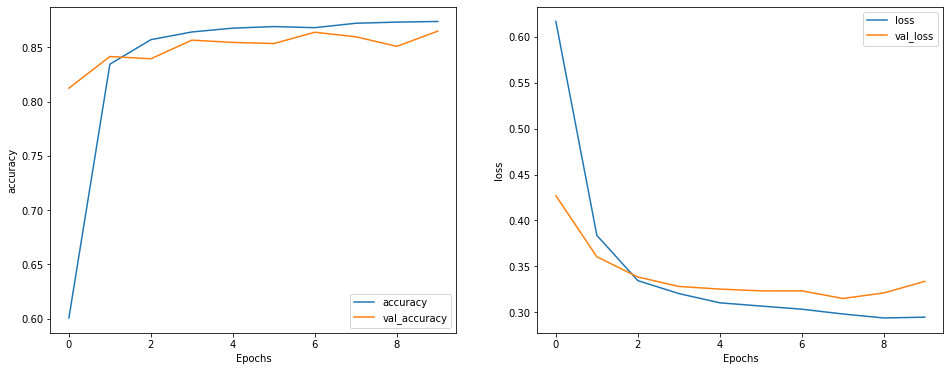

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
